In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
# batch, N, timeout, num_cpus, sleep
data = {
    
}
    

BATCH = "batch"
N_ENTRY = "N"
TIMEOUT = "timeout"
NUM_CPUS = "num_cpus"
SLEEP = "sleep"
    
def Set(batch = None, N = None, timeout = None, num_cpus = None, sleep = None, v = None, attack_p = None):
    if v == None:
        raise Exception("V must be a value")
    global data
    if batch not in data:
        data[batch] = {}
    if N not in data[batch]:
        data[batch][N] = {}
    if timeout not in data[batch][N]:
        data[batch][N][timeout] = {}
    if num_cpus not in data[batch][N][timeout]:
        data[batch][N][timeout][num_cpus] = {}
    if sleep in data[batch][N][timeout][num_cpus]:
        rep = 2
        if 'repetition' in data[batch][N][timeout][num_cpus][sleep]:
            data[batch][N][timeout][num_cpus][sleep]['repetition'] += 1
            rep = data[batch][N][timeout][num_cpus][sleep]['repetition']
        else:
            rep = data[batch][N][timeout][num_cpus][sleep]['repetition'] = 2
        
        data[batch][N][timeout][num_cpus][sleep]['total time'] = (data[batch][N][timeout][num_cpus][sleep]['total time'] * (rep-1) + v['total time']) / rep
        data[batch][N][timeout][num_cpus][sleep]['avg latency'] = (data[batch][N][timeout][num_cpus][sleep]['avg latency'] * (rep-1) + v['avg latency']) / rep
    else:
        data[batch][N][timeout][num_cpus][sleep] = v
    
    data[batch][N][timeout][num_cpus][sleep]['attack_p'] = attack_p

def Get(batch = None, N = None, timeout = None, num_cpus = None, sleep = None):
    return data[batch][N][timeout][num_cpus][sleep]

def Clear():
    global data
    data = {}

def Exists(batch = None, N = None, timeout = None, num_cpus = None, sleep = None):
    if batch not in data:
        return False
    if N not in data[batch]:
        return False
    if timeout not in data[batch][N]:
        return False
    if num_cpus not in data[batch][N][timeout]:
        return False
    if sleep not in data[batch][N][timeout][sleep]:
        return False
    return True


def GetEntry(batch = None, N = None, timeout = None, num_cpus = None, sleep = None):
    return {BATCH: batch, N_ENTRY: N, TIMEOUT: timeout, NUM_CPUS: num_cpus, SLEEP: sleep}

def GetElementFromEntry(entry):
    return Get(batch=entry[BATCH],N = entry[N_ENTRY], timeout=entry[TIMEOUT], num_cpus=entry[NUM_CPUS], sleep=entry[SLEEP])

def GetElementsFromEntryList(entries):
    ans = []
    for e in entries:
        ans += [GetElementFromEntry(e)]
    return ans

def FindKeys(batch = None, N = None, timeout = None, num_cpus = None, sleep = None):
    all_entries = []
    for b in data:
        for n in data[b]:
            for t in data[b][n]:
                for ncpu in data[b][n][t]:
                    for sl in data[b][n][t][ncpu]:
                        all_entries += [GetEntry(batch=b,N=n,timeout=t,num_cpus=ncpu,sleep=sl)]
    
    entries_tuples = [(batch,BATCH), (N,N_ENTRY), (timeout, TIMEOUT), (num_cpus,NUM_CPUS), (sleep,SLEEP)]
    for tup in entries_tuples:
        entry = tup[0]
        dict_key = tup[1]
        if entry != None:
            if not isinstance(entry,list):
                entry = [entry]
            idx_to_remove = []
            for i in range(len(all_entries)):
                elm = all_entries[i]
                if elm[dict_key] not in entry:
                    idx_to_remove += [i]
            all_entries = np.delete(all_entries,idx_to_remove)
    
    return all_entries


Clear()


In [3]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def generate_color_list(num_colors):
    # Get a list of distinct colors from the TABLEAU_COLORS dictionary
    tableau_colors = list(mcolors.TABLEAU_COLORS.values())

    # If the number of colors requested is less than the length of tableau_colors,
    # return the first num_colors colors; otherwise, cycle through the colors
    if num_colors <= len(tableau_colors):
        return tableau_colors[:num_colors]
    else:
        color_list = []
        for i in range(num_colors):
            color_list.append(tableau_colors[i % len(tableau_colors)])
        return color_list

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
import random

def line_plot(xx,yy,labels, x_label, y_label, title,
              stddev = None,
              horizontal_grid_only = None,
              file_path = None,
              curve_line = None,
              extra_y_value = None,
              extra_value_label = None,
              x_ticks = None,
              line_type = '-',
              put_point = True,
              fig_size = None
              ):
    
    n_plots = len(xx)
    if fig_size == None:
        fig_size = (15,8)
    fig, ax = plt.subplots(figsize=fig_size)

    colors = generate_color_list(n_plots)
    for i in range(n_plots):
        x = xx[i]
        y = yy[i]
        label_i = labels[i]
        
        if curve_line: 
            f = interp1d(x, y, kind='quadratic')  # 'cubic' for a smooth curve, you can try other options too

            x_new = np.linspace(min(x), max(x), 100)
            y_new = f(x_new)
            for j in range(len(y_new)):
                if y_new[j] < 0:
                    y_new[j] = 0
            plt.plot(x_new, y_new, line_type, color = colors[i])
            plt.plot(x, y, 'o', color = colors[i], label=label_i)
        else:
            plt.plot(x, y,line_type, color = colors[i], label=label_i)
            if put_point:
                plt.plot(x, y, 'o', color = colors[i])#, label=label_i)
            

        if stddev != None:
            errors = stddev[i]
            for err_idx in range(len(x)):
                plt.fill_between([x[err_idx]], [y[err_idx] - errors[err_idx]], [y[err_idx] + errors[err_idx]], color = colors[i], alpha=1)


    if extra_y_value != None:
        ax.axhline(y = extra_y_value, color = generate_color_list(10)[random.randint(0,9)], linestyle = ':', label=extra_value_label)
        plt.legend()

    plt.grid()
    if horizontal_grid_only:
        plt.grid(axis='y', which='both', linestyle='-', linewidth=0.7, alpha = 0.5)

    if x_ticks != None:
        ax.set_xticks(x_ticks)

    plt.legend()
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    if file_path != None:
        plt.savefig(file_path)
    plt.show()



In [5]:
import numpy as np
import random

def bar_plot(xx,yy, x_label, y_label, title,
              horizontal_grid_only = None,
              file_path = None,
              rotation = None,
              extra_y_value = None,
              extra_value_label = None,
              fig_size = None,
              width = None,
              y_lim = None,
              y_text = None,
              ):
    
    if fig_size == None:
        fig_size = (15,8)

    fig, ax = plt.subplots(figsize=fig_size)

    color = generate_color_list(10)[random.randint(0,9)]
    
    if width == None:
        width = 0.25  

    ax.bar(xx, yy, width, color = color)

    plt.xticks(xx)

    plt.grid()
    if horizontal_grid_only:
        plt.grid(axis='y', which='both', linestyle='-', linewidth=0.7, alpha = 0.5)

    if rotation:
        plt.xticks(rotation=15)
    
    if extra_y_value != None:
        ax.axhline(y = extra_y_value, color = generate_color_list(10)[random.randint(0,9)], linestyle = ':', label=extra_value_label)
        plt.legend()
    
    if y_lim != None:
        plt.ylim(y_lim[0],y_lim[1])

    if y_text != None:
        for i, v in enumerate(yy):

            plt.text(i,v+0.01,str(v),color='black')


    # plt.tight_layout()
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    if file_path != None:
        plt.savefig(file_path)
    plt.show()



In [6]:
def ConvertHistogram(hist_text: str):
    #  &[map[4.994ms - 4.998ms:2] map[4.998ms - 5.001ms:1]]
    # hist_text = hist_text.replace("ms","*pow(10,3)")
    x = []
    y = []
    args = hist_text.split("map[")
    for i in range(1,len(args)):
        field = args[i].split("]")[0]
        first_num = field.split("ms")[0]
        second_num = field.split("ms")[1].split(" - ")[1]
        mid_point = (float(first_num) + float(second_num))/2
        x += [mid_point]
        y += [int(field.split(":")[1])]
    
    return x,y

def DisplayHistogram(x,y, x_label = "Latency(ms)", y_label = "Number of Messages Verified", title = "Number of messages verified by their Latency",
              horizontal_grid_only = None,
              file_path = None,
              rotation = None,
              extra_y_value = None,
              extra_value_label = None,
              fig_size = None
              ):
    
    bar_plot(x,y, x_label, y_label, title,
              horizontal_grid_only = None,
              file_path = None,
              rotation = None,
              extra_y_value = None,
              extra_value_label = None,
              fig_size = None,
              width=0.05
              )

In [8]:
def SleepHistogram(sleep_list, min_value = None, max_value = None):

    x = []
    if min_value != None and max_value != None:
        x = list(range(min_value,max_value,int((max_value-min_value)/10)))
    else:
        x = list(range(min(sleep_list), max(sleep_list)+1,int((max(sleep_list)-min(sleep_list))/10)))
    y = [0] * len(x)

    for elm in sleep_list:
        for x_idx in range(len(x)):
            if x_idx == len(x)-1:
                y[x_idx] += 1
                break
            elif elm < x[x_idx]:
                y[x_idx] += 1
                break
            elif elm - x[x_idx] < x[x_idx+1] - elm:
                y[x_idx] += 1
                break

    print(x,y)
    


    bar_plot(x,y, x_label = "sleep time", y_label = "Frequency", title = "Histogram of sleep time",
              horizontal_grid_only = None,
              file_path = None,
              rotation = None,
              extra_y_value = None,
              extra_value_label = None,
              fig_size = None,
              width=40
              )

a = [0,23,65,67,73,79,80,96,105,105,105,115,115,116,116,118,118,120,126,131,134,134,135,135,136,136,141,142,144,144,144,145,149,152,154,155,157,160,160,161,163,164,165,165,165,166,167,168,169,172,173,174,174,175,177,178,179,179,180,181,184,184,185,185,186,186,188,190,190,191,191,194,195,196,196,197,197,198,199,199,201,202,202,202,202,204,205,205,205,206,206,207,207,208,209,210,210,211,212,212,212,213,214,215,215,216,216,216,216,217,217,218,219,219,220,220,220,222,222,222,223,223,225,225,226,226,227,227,227,227,228,230,230,231,231,231,232,232,233,234,234,236,236,237,237,238,238,238,239,239,239,239,240,240,240,241,241,242,242,243,243,243,243,245,245,246,246,246,246,247,247,247,247,248,248,248,249,249,249,249,250,250,250,250,251,251,251,252,252,252,253,253,253,253,254,254,255,255,255,256,256,256,258,258,259,259,259,260,260,260,260,260,260,260,261,261,261,261,261,262,262,262,262,263,263,264,264,264,265,265,265,265,265,266,266,266,267,267,267,268,268,269,269,269,270,271,271,271,272,272,272,273,273,273,273,274,274,275,275,275,275,275,275,276,276,277,277,277,277,277,278,278,279,279,279,279,279,279,279,280,280,280,280,280,281,281,282,282,283,283,283,283,283,283,284,284,284,284,286,286,286,286,287,287,287,287,287,287,287,288,288,288,289,289,289,289,290,290,291,291,291,291,291,291,291,292,292,292,292,293,293,293,293,294,294,294,294,294,294,295,295,295,295,296,296,296,296,297,297,298,298,298,299,299,299,299,299,299,300,300,301,301,301,302,302,302,302,302,302,303,303,303,304,304,304,305,305,306,306,306,306,306,307,307,307,307,307,307,308,308,309,309,309,309,309,309,309,310,311,311,311,311,312,312,312,313,313,313,313,314,314,314,314,314,315,315,317,317,317,317,318,318,318,319,319,319,319,319,319,319,319,320,320,320,320,321,321,321,321,321,321,321,321,322,322,322,322,322,323,323,323,323,324,324,324,325,326,326,326,326,326,327,327,327,327,327,327,328,329,330,330,331,331,331,332,332,332,332,332,333,333,333,333,333,334,334,334,334,334,334,335,335,335,335,336,336,337,337,337,337,337,338,339,339,339,339,339,339,339,340,340,340,340,341,341,341,342,342,342,342,342,342,344,344,344,344,344,344,345,345,346,346,347,347,347,347,347,347,348,348,348,348,348,348,348,349,349,349,349,349,349,350,350,350,350,350,350,350,351,351,351,351,352,352,352,352,352,352,352,353,353,353,353,353,353,354,354,354,354,354,354,354,354,354,354,355,355,355,355,355,355,356,356,357,357,357,358,359,359,359,359,360,360,361,361,361,361,361,361,361,361,362,363,363,363,363,364,364,364,365,365,365,365,365,366,366,367,367,369,369,369,369,369,370,370,370,371,371,372,372,372,372,372,373,373,374,374,374,374,374,375,375,375,375,375,375,376,376,377,377,378,378,378,378,379,379,379,379,379,380,380,380,381,381,381,382,382,382,383,383,383,384,384,384,384,384,385,385,385,385,385,386,386,386,386,387,387,389,389,389,390,390,390,390,391,391,392,392,393,393,393,393,394,394,394,395,396,396,396,396,396,396,398,398,398,398,399,399,400,400,400,402,402,403,403,404,404,404,404,404,405,405,406,406,406,406,407,407,407,407,408,408,408,408,409,409,409,409,409,410,410,410,410,410,411,411,412,412,412,413,413,413,413,414,414,414,414,415,416,417,417,417,417,418,418,418,419,419,419,419,419,419,420,420,421,421,422,422,424,424,424,425,425,425,425,426,426,426,426,426,427,428,428,429,429,429,429,429,430,430,431,431,431,431,431,432,432,434,434,435,435,436,436,437,437,437,439,439,441,442,442,442,443,443,443,443,443,443,444,444,445,445,445,445,446,446,447,447,447,448,448,448,449,449,449,449,450,450,450,451,451,452,452,453,454,454,454,455,455,455,456,456,456,457,457,457,459,459,459,460,461,461,461,462,462,463,463,463,463,464,464,465,465,466,467,468,468,469,469,469,470,470,470,471,473,474,474,474,475,476,476,477,477,477,477,477,478,479,481,481,483,483,484,485,485,487,489,489,490,490,491,493,493,494,494,494,494,497,498,498,499,499,500,500,503,505,505,505,507,507,510,511,511,512,516,516,516,519,521,523,524,525,525,527,528,529,530,535,537,551,554,555,565,567,568,572,572,573,575,575,585,590,592,596,597,602,610,613,633,641]
a2 = [0,0,1,1,2,2,3,5,6,6,7,8,10,11,12,13,15,17,20,22,24,27,27,31,32,32,32,32,33,34,34,35,35,36,39,40,40,43,43,43,44,44,49,49,50,51,51,51,51,53,54,55,55,56,56,58,60,60,63,65,65,65,69,70,71,72,75,76,79,79,80,84,84,87,88,89,89,90,90,93,96,97,98,98,98,98,99,100,101,102,103,106,107,111,111,114,114,115,116,116,116,117,117,118,119,119,121,121,122,123,125,126,127,129,129,130,130,131,134,135,136,137,138,138,138,139,139,140,141,141,145,145,148,149,149,149,152,153,156,157,157,158,158,158,160,160,160,161,162,162,164,164,164,165,165,166,168,170,171,171,172,172,172,173,175,176,177,180,182,183,184,187,187,187,187,190,190,193,193,194,196,198,200,202,203,203,204,206,206,206,206,207,207,209,210,212,215,217,220,221,221,222,225,226,227,228,230,233,233,234,237,238,238,239,239,239,240,240,242,245,247,248,249,249,250,251,251,252,255,256,256,259,261,261,262,262,263,264,264,265,265,268,269,271,271,271,272,274,275,276,277,278,278,278,279,281,281,281,284,285,286,286,288,290,293,294,296,297,297,301,302,302,302,302,303,303,303,304,305,305,306,306,306,308,308,309,310,310,311,314,314,315,315,316,316,316,316,318,318,319,319,319,320,320,321,322,323,324,324,326,329,329,330,331,331,333,333,334,337,337,338,338,339,339,339,340,340,340,341,341,341,341,343,344,347,347,349,350,350,350,351,352,352,353,354,354,357,357,359,360,360,361,361,361,362,363,363,364,365,365,365,365,366,366,369,371,372,372,373,375,375,375,376,380,381,382,383,384,385,385,385,386,387,387,387,388,388,389,390,391,391,392,392,394,394,394,395,396,396,396,397,398,399,401,401,401,401,403,403,407,407,408,409,409,412,412,412,413,414,415,416,416,417,420,420,422,424,425,425,425,426,428,429,430,434,436,437,438,439,441,442,447,448,449,449,449,451,451,452,455,455,456,457,458,459,459,460,462,463,463,464,464,465,467,467,468,468,475,475,476,477,478,479,480,480,480,480,480,480,481,484,484,485,486,487,487,488,488,491,491,491,491,491,493,494,495,498,498,499,499,500,500,500,501,502,505,507,507,508,509,510,512,512,514,515,515,515,515,515,517,517,524,524,524,526,527,527,528,528,531,532,533,534,536,539,540,542,542,543,543,545,545,546,547,547,548,549,551,553,553,553,553,554,555,555,556,556,559,559,561,562,565,568,568,568,569,570,571,573,573,573,574,579,580,580,580,580,581,582,583,583,584,585,585,585,587,588,589,590,591,591,592,593,594,594,596,596,598,598,598,599,600,601,604,604,604,605,605,606,606,607,607,608,610,611,612,613,616,617,618,618,619,620,621,621,621,622,624,625,627,629,629,629,630,632,635,636,636,638,639,640,641,644,644,644,644,647,649,649,649,654,656,658,659,661,661,662,663,664,665,666,666,670,671,672,673,674,676,678,678,678,681,681,681,682,683,683,684,685,685,686,686,686,688,691,692,693,693,694,694,695,698,698,698,699,699,700,701,701,702,704,706,707,710,711,711,712,713,714,716,716,720,720,721,721,721,721,722,724,724,726,726,727,727,728,730,730,732,732,733,733,734,734,735,735,735,735,737,738,738,740,743,744,745,746,746,749,750,750,750,753,753,754,755,756,756,758,758,759,759,759,760,763,763,766,768,769,770,772,772,773,775,775,775,777,777,778,779,785,785,786,786,786,787,791,794,795,795,795,796,799,799,800,801,802,804,804,805,805,805,806,806,807,807,807,807,808,808,809,810,810,810,812,812,813,815,819,820,820,821,822,824,825,828,828,828,829,829,829,830,832,833,837,837,839,839,841,842,843,843,844,844,844,844,847,847,848,849,849,850,850,850,852,852,854,855,856,859,859,859,859,860,861,863,865,865,865,867,867,867,868,868,869,869,871,872,872,872,875,875,875,876,877,877,877,878,878,879,881,882,884,885,886,887,888,889,890,891,892,895,895,897,899,900,901,905,906,907,908,908,908,910,912,912,913,916,917,918,919,921,921,922,922,923,924,924,925,925,925,926,927,927,927,928,929,929,930,931,933,933,934,934,935,936,936,937,937,939,939,939,939,940,942,942,943,943,949,950,951,952,954,955,956,957,960,962,962,962,962,963,963,964,965,965,965,966,966,969,969,970,971,972,979,980,981,983,983,984,984,984,987,991,991,991,995,995,996,997,997,998]

# SleepHistogram(a,min_value=0,max_value=1000)
# SleepHistogram(a2)


In [9]:
import copy
import itertools
from hashlib import sha256


def plot_graph_one_dim(tup_dict, first_dim, data_keys, duration = 1000, use_normal = False,  Y_values = [('total time','Total time (ms)' ),('avg latency','Average Latency')]):


    Y_descriptor = [e[0] for e in Y_values]
    Y_label = [e[1] for e in Y_values]

    for y_index in range(len(Y_descriptor)):

        y_descriptor = Y_descriptor[y_index]
        y_label = Y_label[y_index]

        xx = []
        yy = []
        labels = []

        keys = [k for k in data_keys]
        y = [v[y_descriptor] for v in GetElementsFromEntryList(keys)]
        x = [v[first_dim] for v in keys]
        labels += ['']
        xx += [x]
        yy += [y]

            
    
        x_label = tup_dict[first_dim]['text']
        y_label = y_label
        title = f'{y_label} by {x_label} '
        for id in tup_dict:
            if id != first_dim:
                title += f"{tup_dict[id]['id']}={data_keys[0][id]}," 

        title += f"(duration {duration}, normal dist={use_normal})"

        stddev = None
        horizontal_grid_only = True
        file_path = f"{y_label}by{x_label}"
        for id in tup_dict:
            if id != first_dim:
                file_path += f"_{tup_dict[id]['id']}{data_keys[0][id]}"
        file_path += f"{sha256(title.encode('utf-8')).hexdigest()[:10]}.png"
        file_path = file_path.replace(" ","_")
        curve_line = False
        extra_y_value = None
        extra_value_label = None
        x_ticks = x
        line_type = '--'
        put_point = True
        fig_size = (12,7)   

        line_plot(xx,yy,
                    labels = labels,
                    x_label=x_label,
                    y_label=y_label,
                    title=title,
                    stddev=stddev,
                    horizontal_grid_only = horizontal_grid_only,
                    file_path = file_path,
                    curve_line = curve_line,
                    extra_y_value = extra_y_value,
                    extra_value_label = extra_value_label,
                    x_ticks = x_ticks,
                    line_type = line_type,
                    put_point = put_point,
                    fig_size=fig_size)


def plot_graph_two_dim(tup_dict, dim_tup, data_keys, duration = 1000, use_normal = False, Y_values = [('total time','Total time (ms)' ),('avg latency','Average Latency')]):
    first_dim = dim_tup[0]
    second_dim = dim_tup[1]


    Y_descriptor = [e[0] for e in Y_values]
    Y_label = [e[1] for e in Y_values]


    for y_index in range(len(Y_descriptor)):

        y_descriptor = Y_descriptor[y_index]
        y_label = Y_label[y_index]

        xx = []
        yy = []
        labels = []

        for value in tup_dict[second_dim]['lst']:
            keys = [k for k in data_keys if k[second_dim] == value]
            y = [v[y_descriptor] for v in GetElementsFromEntryList(keys)]
            x = [v[first_dim] for v in keys]
        
            xx += [x]
            yy += [y]
            labels += [f"{tup_dict[second_dim]['text']}={value}"]

            
    
        x_label = tup_dict[first_dim]['text']
        y_label = y_label
        title = f'{y_label} by {x_label} '
        for id in tup_dict:
            if id not in dim_tup:
                title += f"{tup_dict[id]['text']}={data_keys[0][id]}," 

        title += f"(duration {duration}, normal dist={use_normal})"

        stddev = None
        horizontal_grid_only = True
        file_path = f"{y_label}by{x_label}"
        for id in tup_dict:
            if id not in dim_tup:
                file_path += f"_{tup_dict[id]['id']}{data_keys[0][id]}"
        file_path += f"{sha256(title.encode('utf-8')).hexdigest()[:10]}.png"
        file_path = file_path.replace(" ","_")
        curve_line = False
        extra_y_value = None
        extra_value_label = None
        x_ticks = x
        line_type = '--'
        put_point = True
        fig_size = (12,7)   

        line_plot(xx,yy,
                    labels = labels,
                    x_label=x_label,
                    y_label=y_label,
                    title=title,
                    stddev=stddev,
                    horizontal_grid_only = horizontal_grid_only,
                    file_path = file_path,
                    curve_line = curve_line,
                    extra_y_value = extra_y_value,
                    extra_value_label = extra_value_label,
                    x_ticks = x_ticks,
                    line_type = line_type,
                    put_point = put_point,
                    fig_size=fig_size)

def analyse_data(duration = 1000, use_normal = False, Y_values = [('total time','Total time (ms)' ),('avg latency','Average Latency')]):

    keys = FindKeys()

    batch_lst = list(set([k[BATCH] for k in keys]))
    N_lst = list(set([k[N_ENTRY] for k in keys]))
    timeout_lst = list(set([k[TIMEOUT] for k in keys]))
    num_cpus_lst = list(set([k[NUM_CPUS] for k in keys]))
    sleep_lst = list(set([k[SLEEP] for k in keys]))


    tup_dict = {
        BATCH: {'id':BATCH,'text':"Batch Size"},
        N_ENTRY: {'id':N_ENTRY,'text':"Number of messages"},
        TIMEOUT: {'id':TIMEOUT,'text':"Timeout(ms)"},
        NUM_CPUS: {'id':NUM_CPUS,'text':"Cpus"},
        SLEEP: {'id':SLEEP,'text':"Spread by duration"},
    }

    variables = []
    for entry in tup_dict.values():
        entry['lst'] = list(set([k[entry['id']] for k in keys]))
        entry['unique'] = len(entry['lst']) == 1

        if not entry['unique']:
            variables += [entry['id']]
    

    if len(variables) == 1:
        data_keys = FindKeys()
        plot_graph_one_dim(tup_dict, variables[0], data_keys, duration = duration, use_normal = use_normal, Y_values = Y_values)
        return

    dimensions = []
    for v in variables:
        for vv in variables:
            if v != vv:
                dimensions += [(v,vv)]
    

    def restrict(keys,id,value):
        if id == BATCH:
            filtered_keys = FindKeys(batch = [value])
            return [k for k in filtered_keys if k in keys]
        if id == N_ENTRY:
            filtered_keys = FindKeys(N = [value])
            return [k for k in filtered_keys if k in keys]
        if id == TIMEOUT:
            filtered_keys = FindKeys(timeout = [value])
            return [k for k in filtered_keys if k in keys]
        if id == NUM_CPUS:
            filtered_keys = FindKeys(num_cpus = [value])
            return [k for k in filtered_keys if k in keys]
        if id == SLEEP:
            filtered_keys = FindKeys(sleep = [value])
            return [k for k in filtered_keys if k in keys]


    data_keys = FindKeys()

    for dim_tup in dimensions:

        extra_variables = []
        for id in variables:
            if id not in dim_tup:
                extra_variables += [id]




        combinations = [dict(zip(extra_variables, values)) for values in itertools.product(*[tup_dict[dim]['lst'] for dim in extra_variables])]

        for elm in combinations:
            data_keys = FindKeys()
            for e in elm:
                data_keys = restrict(data_keys,e,elm[e])
            
            plot_graph_two_dim(tup_dict,dim_tup,data_keys, duration = duration, use_normal = use_normal, Y_values = Y_values)
    


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


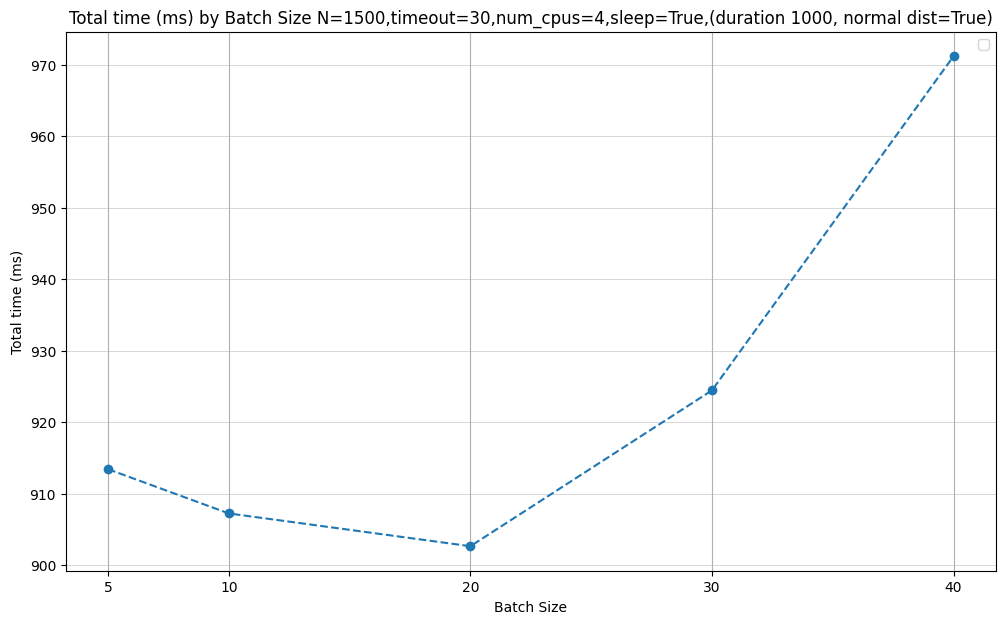

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


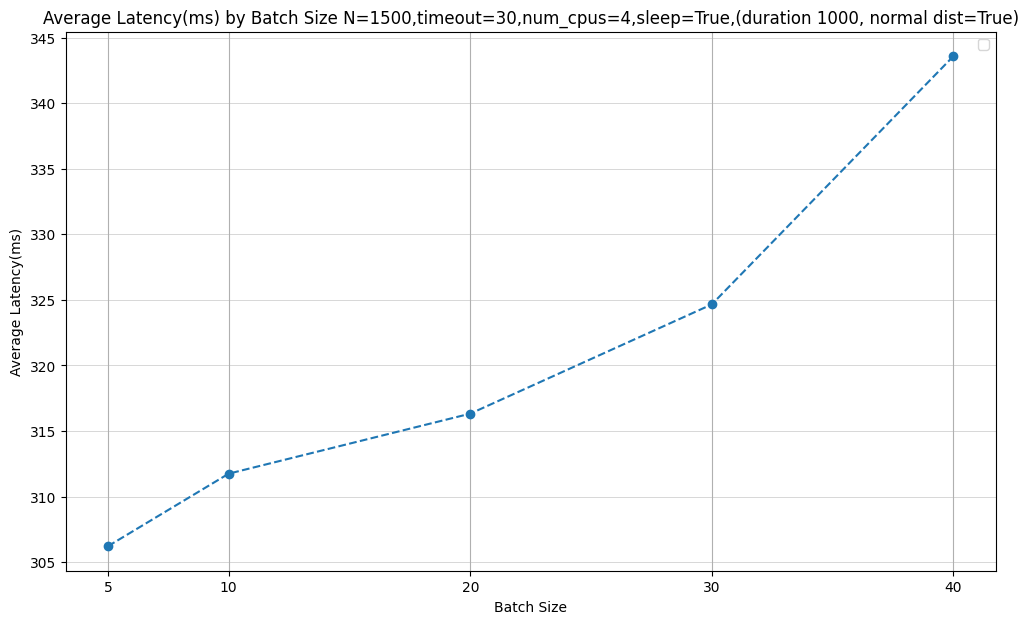

In [11]:
Clear()

Set(batch=5,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=4, v = {"total time": 913.424542,"avg latency": 306.20769,"cumulative": 459324,"hmean": 84,"avg": 306,"p50": 297,"p75": 454,"p95": 596,"p99": 620,"p999": 643,"Long5": 611,"Short5": 10,"MaxM": 648,"MinM": 5,"RangM": 642,"StdDevM": 181,"RateSec": 3.2656679960194537,"HistogramM":""" &[map[5.882ms - 70.105ms:216] map[70.105ms - 134.327ms:108] map[134.327ms - 198.55ms:90] map[198.55ms - 262.772ms:219] map[262.772ms - 326.995ms:194] map[326.995ms - 391.217ms:173] map[391.217ms - 455.44ms:126] map[455.44ms - 519.662ms:121] map[519.662ms - 583.885ms:142] map[583.885ms - 648.107ms:111]]""","HistogramBinSize": 64.222485,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 303,"avg batch size": 4.930693069306931,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 227,"failed requests": 1122,"recent batches": [5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5],"recent batches avg": 5,"timeouts triggered": 8,})
Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=4, v = {"total time": 907.235292,"avg latency": 311.743539,"cumulative": 467615,"hmean": 117,"avg": 311,"p50": 318,"p75": 455,"p95": 555,"p99": 588,"p999": 593,"Long5": 574,"Short5": 17,"MaxM": 594,"MinM": 8,"RangM": 585,"StdDevM": 169,"RateSec": 3.207764947729072,"HistogramM":""" &[map[8.344ms - 66.921ms:187] map[66.921ms - 125.498ms:53] map[125.498ms - 184.075ms:133] map[184.075ms - 242.653ms:185] map[242.653ms - 301.23ms:144] map[301.23ms - 359.807ms:176] map[359.807ms - 418.385ms:139] map[418.385ms - 476.962ms:144] map[476.962ms - 535.539ms:176] map[535.539ms - 594.117ms:163]]""","HistogramBinSize": 58.577328,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 156,"avg batch size": 9.551282051282051,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 147,"failed requests": 1417,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 10,})
Set(batch=20,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=4, v = {"total time": 902.652625,"avg latency": 316.322404,"cumulative": 475013,"hmean": 166,"avg": 316,"p50": 326,"p75": 473,"p95": 547,"p99": 563,"p999": 585,"Long5": 559,"Short5": 35,"MaxM": 603,"MinM": 16,"RangM": 587,"StdDevM": 166,"RateSec": 3.157802013104954,"HistogramM":""" &[map[16.516ms - 75.24ms:196] map[75.24ms - 133.963ms:84] map[133.963ms - 192.686ms:103] map[192.686ms - 251.41ms:177] map[251.41ms - 310.133ms:140] map[310.133ms - 368.857ms:173] map[368.857ms - 427.58ms:120] map[427.58ms - 486.303ms:199] map[486.303ms - 545.027ms:219] map[545.027ms - 603.75ms:89]]""","HistogramBinSize": 58.723401,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 78,"avg batch size": 18.96153846153846,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 78,"failed requests": 1499,"recent batches": [20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20],"recent batches avg": 20,"timeouts triggered": 9,})
Set(batch=30,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=4, v = {"total time": 924.444333,"avg latency": 324.659433,"cumulative": 486989,"hmean": 199,"avg": 324,"p50": 316,"p75": 462,"p95": 599,"p99": 643,"p999": 656,"Long5": 627,"Short5": 46,"MaxM": 659,"MinM": 7,"RangM": 651,"StdDevM": 166,"RateSec": 3.080150753812885,"HistogramM":""" &[map[7.82ms - 72.968ms:103] map[72.968ms - 138.117ms:105] map[138.117ms - 203.265ms:211] map[203.265ms - 268.414ms:207] map[268.414ms - 333.562ms:170] map[333.562ms - 398.711ms:180] map[398.711ms - 463.86ms:150] map[463.86ms - 529.008ms:167] map[529.008ms - 594.157ms:120] map[594.157ms - 659.305ms:87]]""","HistogramBinSize": 65.148552,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 54,"avg batch size": 27.185185185185187,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 53,"failed requests": 1493,"recent batches": [30,2,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30],"recent batches avg": 29,"timeouts triggered": 9,})
Set(batch=40,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=4, v = {"total time": 971.166458,"avg latency": 343.593331,"cumulative": 515389,"hmean": 217,"avg": 343,"p50": 333,"p75": 474,"p95": 638,"p99": 679,"p999": 697,"Long5": 666,"Short5": 49,"MaxM": 701,"MinM": 12,"RangM": 688,"StdDevM": 172,"RateSec": 2.910417369891724,"HistogramM":""" &[map[12.999ms - 81.853ms:89] map[81.853ms - 150.707ms:134] map[150.707ms - 219.56ms:196] map[219.56ms - 288.414ms:184] map[288.414ms - 357.268ms:212] map[357.268ms - 426.122ms:173] map[426.122ms - 494.976ms:175] map[494.976ms - 563.83ms:147] map[563.83ms - 632.683ms:103] map[632.683ms - 701.537ms:87]]""","HistogramBinSize": 68.853833,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 41,"avg batch size": 35.5609756097561,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 41,"failed requests": 1498,"recent batches": [40,40,40,17,40,10,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40],"recent batches avg": 38,"timeouts triggered": 8,})

analyse_data(duration=1000, use_normal=True, Y_values = [
    ('total time','Total time (ms)'),
    ('avg latency','Average Latency(ms)'),
    # ('avg batch size','Average batch size'),
    # ('cumulative','Cumulative'),
    # ('p75','p75'),
    ])

# Total time by number of messages (normal vs N = Batch)

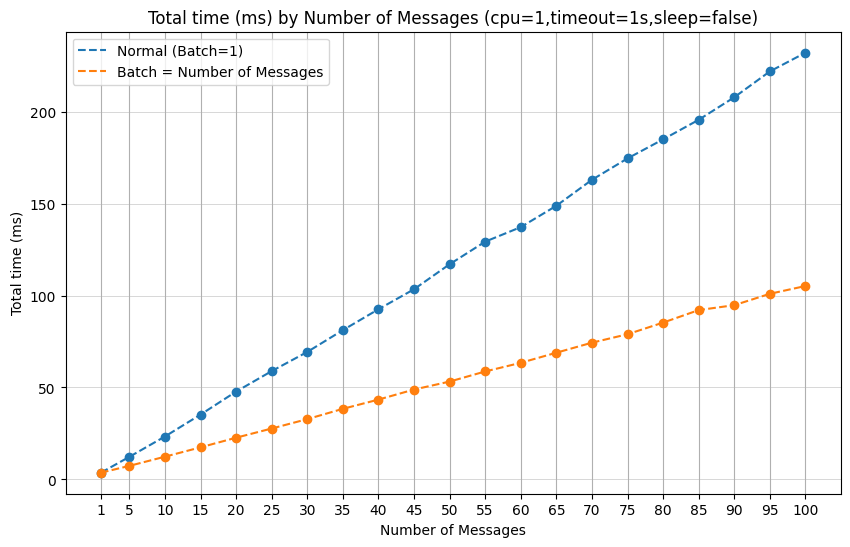

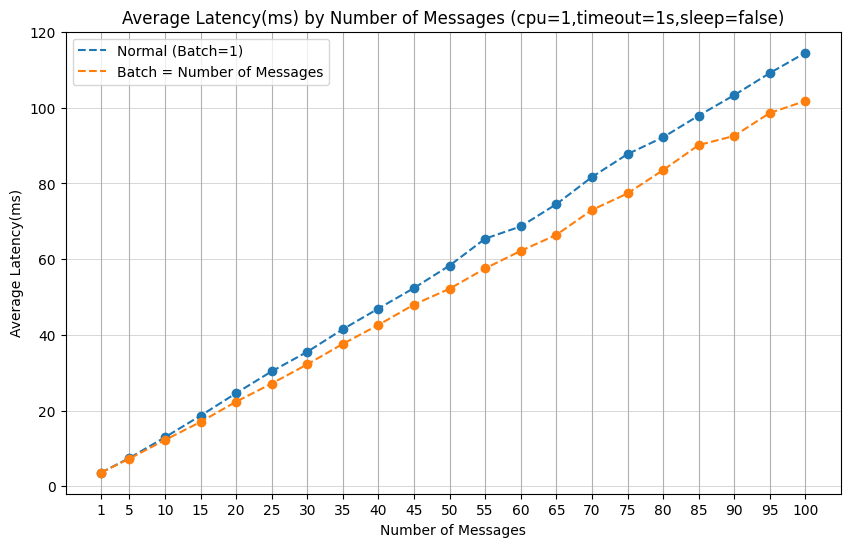

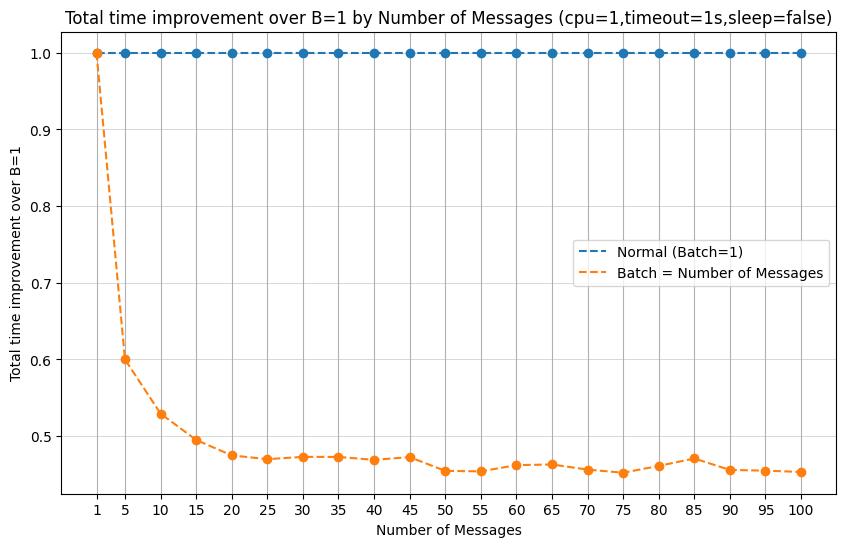

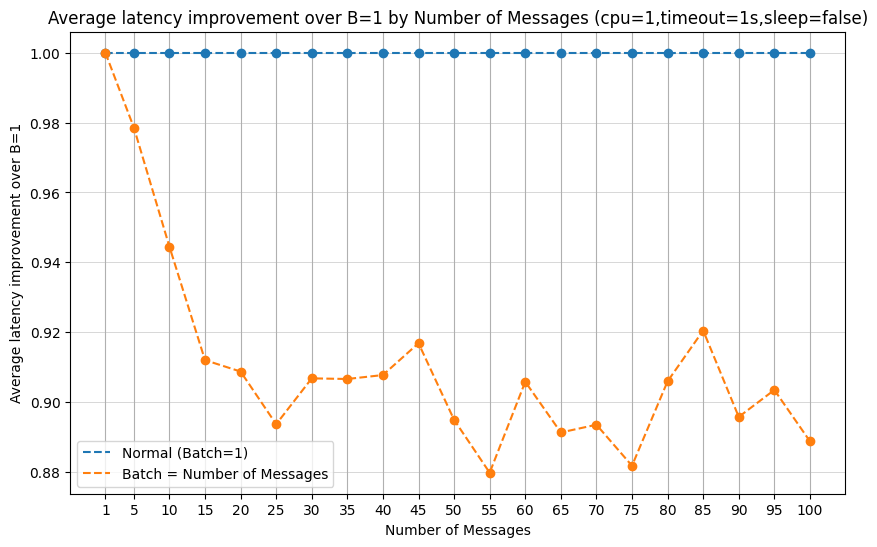

In [13]:
# Total time by number of messages (normal vs N = Batch)
Clear()

def Set1to5():
    # batch = 1 & [1,2,3,4,5], timeout = 1000, cpu = 1, sleep = False, N = [1,2,3,4,5]
    
    Set(batch=1,N=1,timeout=1000,num_cpus=1,sleep=False, v = {"total time": 3.869208,"avg latency": 3.854041,"cumulative": 3,"hmean": 3,"avg": 3,"p50": 3,"p75": 3,"p95": 3,"p99": 3,"p999": 3,"Long5": 3,"Short5": 3,"MaxM": 3,"MinM": 3,"RangM": 0,"StdDevM": 0,"RateSec": 259.467919516165,"HistogramM":""" &[map[3.854ms - 3.854ms:1]]""","HistogramBinSize": 0*pow(10,3),"Samples": 1,"Count": 1,})
    "================================================================================================================"
    Set(batch=2,N=2,timeout=1000,num_cpus=1,sleep=False, v = {"total time": 4.073916,"avg latency": 4.053208,"cumulative": 8,"hmean": 4,"avg": 4,"p50": 4,"p75": 4,"p95": 4,"p99": 4,"p999": 4,"Long5": 4,"Short5": 4,"MaxM": 4,"MinM": 4,"RangM": 0,"StdDevM": 0,"RateSec": 246.71812466592826,"HistogramM":""" &[map[4.043ms - 4.045ms:1] map[4.045ms - 4.047ms:1]]""","HistogramBinSize": 2.008*pow(10,-3),"Samples": 2,"Count": 2,})
    "================================================================================================================"
    Set(batch=3,N=3,timeout=1000,num_cpus=1,sleep=False, v = {"total time": 5.066958,"avg latency": 5.005402,"cumulative": 15,"hmean": 5,"avg": 5,"p50": 4,"p75": 4,"p95": 5,"p99": 5,"p999": 5,"Long5": 5,"Short5": 4,"MaxM": 5,"MinM": 4,"RangM": 0,"StdDevM": 0,"RateSec": 199.78412659174674,"HistogramM":""" &[map[4.994ms - 4.998ms:2] map[4.998ms - 5.001ms:1]]""","HistogramBinSize": 3.104*pow(10,-3),"Samples": 3,"Count": 3,})
    "================================================================================================================"
    Set(batch=4,N=4,timeout=1000,num_cpus=1,sleep=False, v = {"total time": 6.352625,"avg latency": 6.106792,"cumulative": 24,"hmean": 6,"avg": 6,"p50": 6,"p75": 6,"p95": 6,"p99": 6,"p999": 6,"Long5": 6,"Short5": 5,"MaxM": 6,"MinM": 5,"RangM": 0,"StdDevM": 0,"RateSec": 163.7520976643711,"HistogramM":""" &[map[5.998ms - 6.032ms:2] map[6.032ms - 6.067ms:1] map[6.067ms - 6.101ms:1]]""","HistogramBinSize": 34.516*pow(10,-3),"Samples": 4,"Count": 4,})
    "================================================================================================================"
    Set(batch=5,N=5,timeout=1000,num_cpus=1,sleep=False, v = {"total time": 7.658291,"avg latency": 7.392883,"cumulative": 36,"hmean": 7,"avg": 7,"p50": 7,"p75": 7,"p95": 7,"p99": 7,"p999": 7,"Long5": 7,"Short5": 7,"MaxM": 7,"MinM": 7,"RangM": 0,"StdDevM": 0,"RateSec": 135.2652237221873,"HistogramM":""" &[map[7.036ms - 7.096ms:2] map[7.096ms - 7.155ms:1] map[7.155ms - 7.215ms:1] map[7.215ms - 7.275ms:1]]""","HistogramBinSize": 59.825*pow(10,-3),"Samples": 5,"Count": 5,})
    "================================================================================================================"

    Set(batch=1,N=1,timeout=1000,num_cpus=1,sleep=False, v = {"total time": 3.78225,"avg latency": 3.771083,"cumulative": 3,"hmean": 3,"avg": 3,"p50": 3,"p75": 3,"p95": 3,"p99": 3,"p999": 3,"Long5": 3,"Short5": 3,"MaxM": 3,"MinM": 3,"RangM": 0,"StdDevM": 0,"RateSec": 265.175812889825,"HistogramM":""" &[map[3.771ms - 3.771ms:1]]""","HistogramBinSize": 0*pow(10,3),"Samples": 1,"Count": 1,})
    "================================================================================================================"
    Set(batch=1,N=2,timeout=1000,num_cpus=1,sleep=False, v = {"total time": 5.249625,"avg latency": 4.047145,"cumulative": 8,"hmean": 3,"avg": 4,"p50": 5,"p75": 5,"p95": 5,"p99": 5,"p999": 5,"Long5": 5,"Short5": 2,"MaxM": 5,"MinM": 2,"RangM": 2,"StdDevM": 1,"RateSec": 247.08773134052137,"HistogramM":""" &[map[2.863ms - 3.1ms:1] map[3.1ms - 3.337ms:1]]""","HistogramBinSize": 236.637*pow(10,-3),"Samples": 2,"Count": 2,})
    "================================================================================================================"
    Set(batch=1,N=3,timeout=1000,num_cpus=1,sleep=False, v = {"total time": 7.845542,"avg latency": 5.375749,"cumulative": 16,"hmean": 4,"avg": 5,"p50": 5,"p75": 5,"p95": 7,"p99": 7,"p999": 7,"Long5": 7,"Short5": 2,"MaxM": 7,"MinM": 2,"RangM": 5,"StdDevM": 2,"RateSec": 186.0205668059072,"HistogramM":""" &[map[2.802ms - 3.303ms:1] map[3.303ms - 3.803ms:1] map[3.803ms - 4.304ms:1]]""","HistogramBinSize": 500.491*pow(10,-3),"Samples": 3,"Count": 3,})
    "================================================================================================================"
    Set(batch=1,N=4,timeout=1000,num_cpus=1,sleep=False, v = {"total time": 9.527333,"avg latency": 6.08825,"cumulative": 24,"hmean": 4,"avg": 6,"p50": 7,"p75": 7,"p95": 9,"p99": 9,"p999": 9,"Long5": 9,"Short5": 2,"MaxM": 9,"MinM": 2,"RangM": 6,"StdDevM": 2,"RateSec": 164.25081098837924,"HistogramM":""" &[map[2.657ms - 3.343ms:1] map[3.343ms - 4.028ms:1] map[4.028ms - 4.714ms:1] map[4.714ms - 5.399ms:1]]""","HistogramBinSize": 685.454*pow(10,-3),"Samples": 4,"Count": 4,})
    "================================================================================================================"
    Set(batch=1,N=5,timeout=1000,num_cpus=1,sleep=False, v = {"total time": 12.75525,"avg latency": 7.737016,"cumulative": 38,"hmean": 5,"avg": 7,"p50": 7,"p75": 10,"p95": 12,"p99": 12,"p999": 12,"Long5": 12,"Short5": 2,"MaxM": 12,"MinM": 2,"RangM": 9,"StdDevM": 3,"RateSec": 129.24878897762193,"HistogramM":""" &[map[2.844ms - 3.827ms:1] map[3.827ms - 4.81ms:1] map[4.81ms - 5.793ms:1] map[5.793ms - 6.776ms:1] map[6.776ms - 7.758ms:1]]""","HistogramBinSize": 982.991*pow(10,-3),"Samples": 5,"Count": 5,})
    "================================================================================================================"

def Set1to100():
    # batch = 1 & [1,5,10,...,100], timeout = 1000, cpu = 1, sleep = False, N = [1,5,10,...,100]
    Set(batch=1,N=1,timeout=1000,num_cpus=1,sleep=False, v = {"total time": 3.604625,"avg latency": 3.552916,"cumulative": 3,"hmean": 3,"avg": 3,"p50": 3,"p75": 3,"p95": 3,"p99": 3,"p999": 3,"Long5": 3,"Short5": 3,"MaxM": 3,"MinM": 3,"RangM": 0,"StdDevM": 0,"RateSec": 281.4589480865858,"HistogramM":""" &[map[3.552ms - 3.552ms:1]]""","HistogramBinSize": 0*pow(10,3),"Samples": 1,"Count": 1,})
    "================================================================================================================"
    Set(batch=1,N=5,timeout=1000,num_cpus=1,sleep=False, v = {"total time": 12.268042,"avg latency": 7.452525,"cumulative": 37,"hmean": 5,"avg": 7,"p50": 7,"p75": 9,"p95": 12,"p99": 12,"p999": 12,"Long5": 12,"Short5": 2,"MaxM": 12,"MinM": 2,"RangM": 9,"StdDevM": 3,"RateSec": 134.18270628591767,"HistogramM":""" &[map[2.748ms - 3.698ms:1] map[3.698ms - 4.648ms:1] map[4.648ms - 5.598ms:1] map[5.598ms - 6.548ms:1] map[6.548ms - 7.498ms:1]]""","HistogramBinSize": 950.112*pow(10,-3),"Samples": 5,"Count": 5,})
    "================================================================================================================"
    Set(batch=1,N=10,timeout=1000,num_cpus=1,sleep=False, v = {"total time": 23.336167,"avg latency": 12.9367,"cumulative": 129,"hmean": 8,"avg": 12,"p50": 14,"p75": 18,"p95": 23,"p99": 23,"p999": 23,"Long5": 23,"Short5": 2,"MaxM": 23,"MinM": 2,"RangM": 20,"StdDevM": 6,"RateSec": 77.2994658606909,"HistogramM":""" &[map[2.699ms - 4.744ms:1] map[4.744ms - 6.789ms:1] map[6.789ms - 8.835ms:1] map[8.835ms - 10.88ms:1] map[10.88ms - 12.925ms:1] map[12.925ms - 14.97ms:1] map[14.97ms - 17.015ms:1] map[17.015ms - 19.06ms:1] map[19.06ms - 21.105ms:1] map[21.105ms - 23.15ms:1]]""","HistogramBinSize": 2.045112,"Samples": 10,"Count": 10,})
    "================================================================================================================"
    Set(batch=1,N=15,timeout=1000,num_cpus=1,sleep=False, v = {"total time": 35.242958,"avg latency": 18.6391,"cumulative": 279,"hmean": 11,"avg": 18,"p50": 18,"p75": 25,"p95": 32,"p99": 34,"p999": 34,"Long5": 34,"Short5": 2,"MaxM": 34,"MinM": 2,"RangM": 32,"StdDevM": 9,"RateSec": 53.65065909834703,"HistogramM":""" &[map[2.684ms - 5.886ms:2] map[5.886ms - 9.089ms:1] map[9.089ms - 12.291ms:2] map[12.291ms - 15.493ms:1] map[15.493ms - 18.696ms:2] map[18.696ms - 21.898ms:1] map[21.898ms - 25.1ms:1] map[25.1ms - 28.303ms:2] map[28.303ms - 31.505ms:1] map[31.505ms - 34.707ms:2]]""","HistogramBinSize": 3.202316,"Samples": 15,"Count": 15,})
    "================================================================================================================"
    Set(batch=1,N=20,timeout=1000,num_cpus=1,sleep=False, v = {"total time": 47.764125,"avg latency": 24.584022,"cumulative": 491,"hmean": 13,"avg": 24,"p50": 25,"p75": 35,"p95": 44,"p99": 46,"p999": 46,"Long5": 46,"Short5": 2,"MaxM": 46,"MinM": 2,"RangM": 44,"StdDevM": 13,"RateSec": 40.67682519258641,"HistogramM":""" &[map[2.683ms - 7.104ms:2] map[7.104ms - 11.526ms:2] map[11.526ms - 15.947ms:2] map[15.947ms - 20.368ms:2] map[20.368ms - 24.789ms:2] map[24.789ms - 29.211ms:2] map[29.211ms - 33.632ms:2] map[33.632ms - 38.053ms:2] map[38.053ms - 42.474ms:2] map[42.474ms - 46.895ms:2]]""","HistogramBinSize": 4.421216,"Samples": 20,"Count": 20,})
    "================================================================================================================"
    Set(batch=1,N=25,timeout=1000,num_cpus=1,sleep=False, v = {"total time": 58.903792,"avg latency": 30.364548,"cumulative": 759,"hmean": 16,"avg": 30,"p50": 30,"p75": 44,"p95": 55,"p99": 57,"p999": 57,"Long5": 57,"Short5": 2,"MaxM": 57,"MinM": 2,"RangM": 54,"StdDevM": 16,"RateSec": 32.93314264973482,"HistogramM":""" &[map[2.789ms - 8.261ms:3] map[8.261ms - 13.732ms:2] map[13.732ms - 19.204ms:3] map[19.204ms - 24.675ms:2] map[24.675ms - 30.147ms:2] map[30.147ms - 35.618ms:3] map[35.618ms - 41.089ms:2] map[41.089ms - 46.561ms:3] map[46.561ms - 52.032ms:2] map[52.032ms - 57.504ms:3]]""","HistogramBinSize": 5.471449,"Samples": 25,"Count": 25,})
    "================================================================================================================"
    Set(batch=1,N=30,timeout=1000,num_cpus=1,sleep=False, v = {"total time": 69.33275,"avg latency": 35.521618,"cumulative": 1065,"hmean": 18,"avg": 35,"p50": 36,"p75": 52,"p95": 65,"p99": 68,"p999": 68,"Long5": 68,"Short5": 3,"MaxM": 68,"MinM": 2,"RangM": 65,"StdDevM": 19,"RateSec": 28.15187078471482,"HistogramM":""" &[map[2.732ms - 9.263ms:3] map[9.263ms - 15.795ms:3] map[15.795ms - 22.326ms:3] map[22.326ms - 28.858ms:3] map[28.858ms - 35.389ms:3] map[35.389ms - 41.921ms:3] map[41.921ms - 48.452ms:2] map[48.452ms - 54.983ms:4] map[54.983ms - 61.515ms:3] map[61.515ms - 68.046ms:3]]""","HistogramBinSize": 6.531437,"Samples": 30,"Count": 30,})
    "================================================================================================================"
    Set(batch=1,N=35,timeout=1000,num_cpus=1,sleep=False, v = {"total time": 81.182625,"avg latency": 41.495602,"cumulative": 1452,"hmean": 20,"avg": 41,"p50": 41,"p75": 59,"p95": 75,"p99": 79,"p999": 79,"Long5": 78,"Short5": 4,"MaxM": 79,"MinM": 2,"RangM": 76,"StdDevM": 22,"RateSec": 24.098939183563168,"HistogramM":""" &[map[2.799ms - 10.473ms:4] map[10.473ms - 18.146ms:3] map[18.146ms - 25.82ms:4] map[25.82ms - 33.494ms:3] map[33.494ms - 41.168ms:3] map[41.168ms - 48.842ms:4] map[48.842ms - 56.516ms:3] map[56.516ms - 64.189ms:4] map[64.189ms - 71.863ms:3] map[71.863ms - 79.537ms:4]]""","HistogramBinSize": 7.673833,"Samples": 35,"Count": 35,})
    "================================================================================================================"
    Set(batch=1,N=40,timeout=1000,num_cpus=1,sleep=False, v = {"total time": 92.558542,"avg latency": 46.958144,"cumulative": 1878,"hmean": 22,"avg": 46,"p50": 48,"p75": 68,"p95": 86,"p99": 90,"p999": 90,"Long5": 90,"Short5": 3,"MaxM": 90,"MinM": 2,"RangM": 88,"StdDevM": 26,"RateSec": 21.295560279339103,"HistogramM":""" &[map[2.729ms - 11.535ms:4] map[11.535ms - 20.342ms:4] map[20.342ms - 29.148ms:4] map[29.148ms - 37.955ms:4] map[37.955ms - 46.761ms:4] map[46.761ms - 55.568ms:4] map[55.568ms - 64.374ms:4] map[64.374ms - 73.181ms:4] map[73.181ms - 81.987ms:4] map[81.987ms - 90.793ms:4]]""","HistogramBinSize": 8.806437,"Samples": 40,"Count": 40,})
    "================================================================================================================"
    Set(batch=1,N=45,timeout=1000,num_cpus=1,sleep=False, v = {"total time": 103.439708,"avg latency": 52.370613,"cumulative": 2356,"hmean": 25,"avg": 52,"p50": 53,"p75": 77,"p95": 97,"p99": 101,"p999": 101,"Long5": 100,"Short5": 3,"MaxM": 101,"MinM": 2,"RangM": 98,"StdDevM": 29,"RateSec": 19.094678146610082,"HistogramM":""" &[map[2.789ms - 12.669ms:5] map[12.669ms - 22.55ms:4] map[22.55ms - 32.431ms:5] map[32.431ms - 42.311ms:4] map[42.311ms - 52.192ms:4] map[52.192ms - 62.072ms:5] map[62.072ms - 71.953ms:4] map[71.953ms - 81.833ms:5] map[81.833ms - 91.714ms:4] map[91.714ms - 101.595ms:5]]""","HistogramBinSize": 9.880587,"Samples": 45,"Count": 45,})
    "================================================================================================================"
    Set(batch=1,N=50,timeout=1000,num_cpus=1,sleep=False, v = {"total time": 117.035,"avg latency": 58.315545,"cumulative": 2915,"hmean": 26,"avg": 58,"p50": 59,"p75": 86,"p95": 109,"p99": 114,"p999": 114,"Long5": 113,"Short5": 5,"MaxM": 114,"MinM": 2,"RangM": 112,"StdDevM": 32,"RateSec": 17.148086317534656,"HistogramM":""" &[map[2.752ms - 13.96ms:5] map[13.96ms - 25.168ms:5] map[25.168ms - 36.376ms:5] map[36.376ms - 47.584ms:5] map[47.584ms - 58.792ms:5] map[58.792ms - 70ms:5] map[70ms - 81.208ms:5] map[81.208ms - 92.417ms:5] map[92.417ms - 103.625ms:5] map[103.625ms - 114.833ms:5]]""","HistogramBinSize": 11.20812,"Samples": 50,"Count": 50,})
    "================================================================================================================"
    Set(batch=1,N=55,timeout=1000,num_cpus=1,sleep=False, v = {"total time": 129.33125,"avg latency": 65.418222,"cumulative": 3598,"hmean": 31,"avg": 65,"p50": 65,"p75": 95,"p95": 119,"p99": 124,"p999": 127,"Long5": 124,"Short5": 5,"MaxM": 127,"MinM": 3,"RangM": 124,"StdDevM": 36,"RateSec": 15.286260573865668,"HistogramM":""" &[map[3.294ms - 15.701ms:6] map[15.701ms - 28.109ms:5] map[28.109ms - 40.516ms:6] map[40.516ms - 52.924ms:5] map[52.924ms - 65.331ms:5] map[65.331ms - 77.739ms:6] map[77.739ms - 90.146ms:5] map[90.146ms - 102.554ms:6] map[102.554ms - 114.962ms:5] map[114.962ms - 127.369ms:6]]""","HistogramBinSize": 12.40757,"Samples": 55,"Count": 55,})
    "================================================================================================================"
    Set(batch=1,N=60,timeout=1000,num_cpus=1,sleep=False, v = {"total time": 137.233,"avg latency": 68.658911,"cumulative": 4119,"hmean": 30,"avg": 68,"p50": 69,"p75": 100,"p95": 127,"p99": 132,"p999": 134,"Long5": 132,"Short5": 5,"MaxM": 134,"MinM": 2,"RangM": 131,"StdDevM": 38,"RateSec": 14.564751807060166,"HistogramM":""" &[map[2.757ms - 15.924ms:6] map[15.924ms - 29.091ms:6] map[29.091ms - 42.258ms:6] map[42.258ms - 55.426ms:6] map[55.426ms - 68.593ms:6] map[68.593ms - 81.76ms:6] map[81.76ms - 94.927ms:6] map[94.927ms - 108.094ms:5] map[108.094ms - 121.261ms:7] map[121.261ms - 134.428ms:6]]""","HistogramBinSize": 13.167091,"Samples": 60,"Count": 60,})
    "================================================================================================================"
    Set(batch=1,N=65,timeout=1000,num_cpus=1,sleep=False, v = {"total time": 148.845375,"avg latency": 74.525656,"cumulative": 4844,"hmean": 34,"avg": 74,"p50": 74,"p75": 109,"p95": 138,"p99": 142,"p999": 145,"Long5": 143,"Short5": 5,"MaxM": 145,"MinM": 3,"RangM": 142,"StdDevM": 41,"RateSec": 13.418197808462356,"HistogramM":""" &[map[3.003ms - 17.225ms:7] map[17.225ms - 31.446ms:6] map[31.446ms - 45.668ms:7] map[45.668ms - 59.89ms:6] map[59.89ms - 74.112ms:6] map[74.112ms - 88.333ms:7] map[88.333ms - 102.555ms:6] map[102.555ms - 116.777ms:6] map[116.777ms - 130.999ms:7] map[130.999ms - 145.22ms:7]]""","HistogramBinSize": 14.22177,"Samples": 65,"Count": 65,})
    "================================================================================================================"
    Set(batch=1,N=70,timeout=1000,num_cpus=1,sleep=False, v = {"total time": 162.975625,"avg latency": 81.697957,"cumulative": 5718,"hmean": 35,"avg": 81,"p50": 83,"p75": 121,"p95": 153,"p99": 158,"p999": 159,"Long5": 157,"Short5": 6,"MaxM": 159,"MinM": 2,"RangM": 156,"StdDevM": 46,"RateSec": 12.240208133072636,"HistogramM":""" &[map[2.882ms - 18.554ms:8] map[18.554ms - 34.227ms:7] map[34.227ms - 49.899ms:6] map[49.899ms - 65.571ms:7] map[65.571ms - 81.244ms:7] map[81.244ms - 96.916ms:6] map[96.916ms - 112.589ms:7] map[112.589ms - 128.261ms:7] map[128.261ms - 143.933ms:7] map[143.933ms - 159.606ms:8]]""","HistogramBinSize": 15.672395,"Samples": 70,"Count": 70,})
    "================================================================================================================"
    Set(batch=1,N=75,timeout=1000,num_cpus=1,sleep=False, v = {"total time": 174.6065,"avg latency": 87.754134,"cumulative": 6581,"hmean": 40,"avg": 87,"p50": 88,"p75": 128,"p95": 162,"p99": 168,"p999": 170,"Long5": 166,"Short5": 7,"MaxM": 170,"MinM": 3,"RangM": 166,"StdDevM": 48,"RateSec": 11.3954744888699,"HistogramM":""" &[map[3.593ms - 20.281ms:8] map[20.281ms - 36.968ms:7] map[36.968ms - 53.656ms:8] map[53.656ms - 70.344ms:6] map[70.344ms - 87.031ms:8] map[87.031ms - 103.719ms:7] map[103.719ms - 120.406ms:8] map[120.406ms - 137.094ms:8] map[137.094ms - 153.781ms:7] map[153.781ms - 170.469ms:8]]""","HistogramBinSize": 16.687587,"Samples": 75,"Count": 75,})
    "================================================================================================================"
    Set(batch=1,N=80,timeout=1000,num_cpus=1,sleep=False, v = {"total time": 184.975083,"avg latency": 92.19863,"cumulative": 7375,"hmean": 42,"avg": 92,"p50": 93,"p75": 135,"p95": 171,"p99": 178,"p999": 180,"Long5": 177,"Short5": 6,"MaxM": 180,"MinM": 4,"RangM": 175,"StdDevM": 51,"RateSec": 10.846148116874254,"HistogramM":""" &[map[4.687ms - 22.272ms:9] map[22.272ms - 39.858ms:8] map[39.858ms - 57.444ms:8] map[57.444ms - 75.029ms:7] map[75.029ms - 92.615ms:8] map[92.615ms - 110.2ms:8] map[110.2ms - 127.786ms:8] map[127.786ms - 145.372ms:8] map[145.372ms - 162.957ms:8] map[162.957ms - 180.543ms:8]]""","HistogramBinSize": 17.585591,"Samples": 80,"Count": 80,})
    "================================================================================================================"
    Set(batch=1,N=85,timeout=1000,num_cpus=1,sleep=False, v = {"total time": 195.613917,"avg latency": 97.933768,"cumulative": 8324,"hmean": 43,"avg": 97,"p50": 97,"p75": 144,"p95": 182,"p99": 189,"p999": 191,"Long5": 188,"Short5": 6,"MaxM": 191,"MinM": 2,"RangM": 188,"StdDevM": 54,"RateSec": 10.210982573838272,"HistogramM":""" &[map[2.941ms - 21.786ms:8] map[21.786ms - 40.631ms:9] map[40.631ms - 59.476ms:8] map[59.476ms - 78.321ms:9] map[78.321ms - 97.166ms:8] map[97.166ms - 116.011ms:8] map[116.011ms - 134.856ms:9] map[134.856ms - 153.701ms:9] map[153.701ms - 172.545ms:8] map[172.545ms - 191.39ms:9]]""","HistogramBinSize": 18.844941,"Samples": 85,"Count": 85,})
    "================================================================================================================"
    Set(batch=1,N=90,timeout=1000,num_cpus=1,sleep=False, v = {"total time": 207.871875,"avg latency": 103.346723,"cumulative": 9301,"hmean": 46,"avg": 103,"p50": 104,"p75": 153,"p95": 193,"p99": 200,"p999": 202,"Long5": 200,"Short5": 7,"MaxM": 202,"MinM": 4,"RangM": 197,"StdDevM": 58,"RateSec": 9.67616552875442,"HistogramM":""" &[map[4.862ms - 24.632ms:10] map[24.632ms - 44.402ms:9] map[44.402ms - 64.172ms:8] map[64.172ms - 83.941ms:9] map[83.941ms - 103.711ms:9] map[103.711ms - 123.481ms:9] map[123.481ms - 143.251ms:9] map[143.251ms - 163.02ms:9] map[163.02ms - 182.79ms:9] map[182.79ms - 202.56ms:9]]""","HistogramBinSize": 19.769766,"Samples": 90,"Count": 90,})
    "================================================================================================================"
    Set(batch=1,N=95,timeout=1000,num_cpus=1,sleep=False, v = {"total time": 221.936,"avg latency": 109.175903,"cumulative": 10371,"hmean": 49,"avg": 109,"p50": 108,"p75": 161,"p95": 205,"p99": 213,"p999": 216,"Long5": 211,"Short5": 8,"MaxM": 216,"MinM": 5,"RangM": 210,"StdDevM": 62,"RateSec": 9.159530300489465,"HistogramM":""" &[map[5.692ms - 26.745ms:11] map[26.745ms - 47.798ms:10] map[47.798ms - 68.852ms:9] map[68.852ms - 89.905ms:9] map[89.905ms - 110.958ms:9] map[110.958ms - 132.011ms:10] map[132.011ms - 153.065ms:9] map[153.065ms - 174.118ms:9] map[174.118ms - 195.171ms:10] map[195.171ms - 216.224ms:9]]""","HistogramBinSize": 21.053262,"Samples": 95,"Count": 95,})
    "================================================================================================================"
    Set(batch=1,N=100,timeout=1000,num_cpus=1,sleep=False, v = {"total time": 232.10825,"avg latency": 114.544263,"cumulative": 11454,"hmean": 50,"avg": 114,"p50": 115,"p75": 169,"p95": 215,"p99": 224,"p999": 226,"Long5": 222,"Short5": 7,"MaxM": 226,"MinM": 5,"RangM": 221,"StdDevM": 65,"RateSec": 8.73024948837737,"HistogramM":""" &[map[5.109ms - 27.293ms:11] map[27.293ms - 49.477ms:10] map[49.477ms - 71.66ms:10] map[71.66ms - 93.844ms:10] map[93.844ms - 116.028ms:10] map[116.028ms - 138.211ms:9] map[138.211ms - 160.395ms:10] map[160.395ms - 182.579ms:10] map[182.579ms - 204.763ms:10] map[204.763ms - 226.946ms:10]]""","HistogramBinSize": 22.183716,"Samples": 100,"Count": 100,})
    "================================================================================================================"

    Set(batch=1,N=1,timeout=1000,num_cpus=1,sleep=False, v = {"total time": 3.661417,"avg latency": 3.609916,"cumulative": 3,"hmean": 3,"avg": 3,"p50": 3,"p75": 3,"p95": 3,"p99": 3,"p999": 3,"Long5": 3,"Short5": 3,"MaxM": 3,"MinM": 3,"RangM": 0,"StdDevM": 0,"RateSec": 277.0147560220238,"HistogramM":""" &[map[3.609ms - 3.609ms:1]]""","HistogramBinSize": 0*pow(10,3),"Samples": 1,"Count": 1,})
    "================================================================================================================"
    Set(batch=5,N=5,timeout=1000,num_cpus=1,sleep=False, v = {"total time": 7.359917,"avg latency": 7.292858,"cumulative": 36,"hmean": 7,"avg": 7,"p50": 7,"p75": 7,"p95": 7,"p99": 7,"p999": 7,"Long5": 7,"Short5": 7,"MaxM": 7,"MinM": 7,"RangM": 0,"StdDevM": 0,"RateSec": 137.12045025090436,"HistogramM":""" &[map[7.254ms - 7.263ms:1] map[7.263ms - 7.272ms:1] map[7.272ms - 7.281ms:1] map[7.281ms - 7.29ms:1] map[7.29ms - 7.299ms:1]]""","HistogramBinSize": 8.845*pow(10,-3),"Samples": 5,"Count": 5,})
    "================================================================================================================"
    Set(batch=10,N=10,timeout=1000,num_cpus=1,sleep=False, v = {"total time": 12.353583,"avg latency": 12.218379,"cumulative": 122,"hmean": 12,"avg": 12,"p50": 12,"p75": 12,"p95": 12,"p99": 12,"p999": 12,"Long5": 12,"Short5": 11,"MaxM": 12,"MinM": 11,"RangM": 0,"StdDevM": 0,"RateSec": 81.84391592626295,"HistogramM":""" &[map[11.902ms - 11.945ms:1] map[11.945ms - 11.989ms:1] map[11.989ms - 12.033ms:1] map[12.033ms - 12.077ms:1] map[12.077ms - 12.121ms:1] map[12.121ms - 12.165ms:1] map[12.165ms - 12.208ms:1] map[12.208ms - 12.252ms:1] map[12.252ms - 12.296ms:1] map[12.296ms - 12.34ms:1]]""","HistogramBinSize": 43.845*pow(10,-3),"Samples": 10,"Count": 10,})
    "================================================================================================================"
    Set(batch=15,N=15,timeout=1000,num_cpus=1,sleep=False, v = {"total time": 17.444791,"avg latency": 16.998619,"cumulative": 254,"hmean": 16,"avg": 16,"p50": 17,"p75": 17,"p95": 17,"p99": 17,"p999": 17,"Long5": 17,"Short5": 16,"MaxM": 17,"MinM": 16,"RangM": 0,"StdDevM": 0,"RateSec": 58.82830696238778,"HistogramM":""" &[map[16.698ms - 16.768ms:3] map[16.768ms - 16.839ms:1] map[16.839ms - 16.91ms:1] map[16.91ms - 16.98ms:1] map[16.98ms - 17.051ms:3] map[17.051ms - 17.122ms:4] map[17.122ms - 17.192ms:1] map[17.192ms - 17.263ms:1]]""","HistogramBinSize": 70.67*pow(10,-3),"Samples": 15,"Count": 15,})
    "================================================================================================================"
    Set(batch=20,N=20,timeout=1000,num_cpus=1,sleep=False, v = {"total time": 22.680667,"avg latency": 22.339972,"cumulative": 446,"hmean": 22,"avg": 22,"p50": 22,"p75": 22,"p95": 22,"p99": 22,"p999": 22,"Long5": 22,"Short5": 21,"MaxM": 22,"MinM": 21,"RangM": 0,"StdDevM": 0,"RateSec": 44.762811586125935,"HistogramM":""" &[map[21.845ms - 21.924ms:1] map[21.924ms - 22.004ms:1] map[22.004ms - 22.083ms:1] map[22.083ms - 22.162ms:2] map[22.162ms - 22.241ms:3] map[22.241ms - 22.32ms:2] map[22.321ms - 22.4ms:1] map[22.4ms - 22.479ms:1] map[22.479ms - 22.558ms:3] map[22.558ms - 22.637ms:5]]""","HistogramBinSize": 79.229*pow(10,-3),"Samples": 20,"Count": 20,})
    "================================================================================================================"
    Set(batch=25,N=25,timeout=1000,num_cpus=1,sleep=False, v = {"total time": 27.678584,"avg latency": 27.134946,"cumulative": 678,"hmean": 27,"avg": 27,"p50": 27,"p75": 27,"p95": 27,"p99": 27,"p999": 27,"Long5": 27,"Short5": 26,"MaxM": 27,"MinM": 26,"RangM": 0,"StdDevM": 0,"RateSec": 36.85284591260096,"HistogramM":""" &[map[26.626ms - 26.72ms:4] map[26.72ms - 26.814ms:2] map[26.814ms - 26.908ms:1] map[26.908ms - 27.002ms:1] map[27.002ms - 27.096ms:5] map[27.096ms - 27.19ms:2] map[27.19ms - 27.284ms:1] map[27.284ms - 27.378ms:1] map[27.378ms - 27.472ms:3] map[27.472ms - 27.567ms:5]]""","HistogramBinSize": 94.079*pow(10,-3),"Samples": 25,"Count": 25,})
    "================================================================================================================"
    Set(batch=30,N=30,timeout=1000,num_cpus=1,sleep=False, v = {"total time": 32.788959,"avg latency": 32.209973,"cumulative": 966,"hmean": 32,"avg": 32,"p50": 32,"p75": 32,"p95": 32,"p99": 32,"p999": 32,"Long5": 32,"Short5": 31,"MaxM": 32,"MinM": 31,"RangM": 1,"StdDevM": 0,"RateSec": 31.046284339864343,"HistogramM":""" &[map[31.52ms - 31.643ms:4] map[31.643ms - 31.766ms:1] map[31.766ms - 31.889ms:4] map[31.889ms - 32.012ms:3] map[32.012ms - 32.135ms:1] map[32.135ms - 32.258ms:1] map[32.258ms - 32.381ms:5] map[32.381ms - 32.504ms:1] map[32.504ms - 32.628ms:4] map[32.628ms - 32.751ms:6]]""","HistogramBinSize": 123.083*pow(10,-3),"Samples": 30,"Count": 30,})
    "================================================================================================================"
    Set(batch=35,N=35,timeout=1000,num_cpus=1,sleep=False, v = {"total time": 38.387167,"avg latency": 37.619519,"cumulative": 1316,"hmean": 37,"avg": 37,"p50": 37,"p75": 37,"p95": 38,"p99": 38,"p999": 38,"Long5": 38,"Short5": 36,"MaxM": 38,"MinM": 36,"RangM": 1,"StdDevM": 0,"RateSec": 26.58194537895383,"HistogramM":""" &[map[36.75ms - 36.91ms:5] map[36.91ms - 37.069ms:1] map[37.069ms - 37.228ms:5] map[37.228ms - 37.388ms:1] map[37.388ms - 37.547ms:3] map[37.547ms - 37.706ms:4] map[37.706ms - 37.866ms:1] map[37.866ms - 38.025ms:6] map[38.025ms - 38.184ms:1] map[38.184ms - 38.344ms:8]]""","HistogramBinSize": 159.325*pow(10,-3),"Samples": 35,"Count": 35,})
    "================================================================================================================"
    Set(batch=40,N=40,timeout=1000,num_cpus=1,sleep=False, v = {"total time": 43.412,"avg latency": 42.624867,"cumulative": 1704,"hmean": 42,"avg": 42,"p50": 42,"p75": 42,"p95": 43,"p99": 43,"p999": 43,"Long5": 43,"Short5": 41,"MaxM": 43,"MinM": 41,"RangM": 1,"StdDevM": 0,"RateSec": 23.460483305322718,"HistogramM":""" &[map[41.796ms - 41.952ms:5] map[41.952ms - 42.107ms:1] map[42.107ms - 42.262ms:8] map[42.262ms - 42.418ms:1] map[42.418ms - 42.573ms:5] map[42.573ms - 42.728ms:2] map[42.728ms - 42.884ms:3] map[42.884ms - 43.039ms:5] map[43.039ms - 43.194ms:1] map[43.194ms - 43.35ms:9]]""","HistogramBinSize": 155.362*pow(10,-3),"Samples": 40,"Count": 40,})
    "================================================================================================================"
    Set(batch=45,N=45,timeout=1000,num_cpus=1,sleep=False, v = {"total time": 48.88725,"avg latency": 48.014998,"cumulative": 2160,"hmean": 48,"avg": 48,"p50": 48,"p75": 48,"p95": 48,"p99": 48,"p999": 48,"Long5": 48,"Short5": 46,"MaxM": 48,"MinM": 46,"RangM": 1,"StdDevM": 0,"RateSec": 20.82682575057634,"HistogramM":""" &[map[46.975ms - 47.162ms:2] map[47.162ms - 47.349ms:6] map[47.349ms - 47.536ms:1] map[47.536ms - 47.723ms:9] map[47.723ms - 47.91ms:1] map[47.91ms - 48.097ms:5] map[48.097ms - 48.284ms:3] map[48.284ms - 48.47ms:6] map[48.47ms - 48.657ms:2] map[48.657ms - 48.844ms:10]]""","HistogramBinSize": 186.879*pow(10,-3),"Samples": 45,"Count": 45,})
    "================================================================================================================"
    Set(batch=50,N=50,timeout=1000,num_cpus=1,sleep=False, v = {"total time": 53.213416,"avg latency": 52.186377,"cumulative": 2609,"hmean": 52,"avg": 52,"p50": 52,"p75": 52,"p95": 53,"p99": 53,"p999": 53,"Long5": 53,"Short5": 51,"MaxM": 53,"MinM": 51,"RangM": 2,"StdDevM": 0,"RateSec": 19.162088803730438,"HistogramM":""" &[map[51.114ms - 51.321ms:7] map[51.321ms - 51.528ms:3] map[51.528ms - 51.735ms:6] map[51.735ms - 51.942ms:3] map[51.942ms - 52.149ms:5] map[52.149ms - 52.355ms:3] map[52.355ms - 52.562ms:5] map[52.562ms - 52.769ms:8] map[52.769ms - 52.976ms:1] map[52.976ms - 53.183ms:9]]""","HistogramBinSize": 206.833*pow(10,-3),"Samples": 50,"Count": 50,})
    "================================================================================================================"
    Set(batch=55,N=55,timeout=1000,num_cpus=1,sleep=False, v = {"total time": 58.715917,"avg latency": 57.551935,"cumulative": 3165,"hmean": 57,"avg": 57,"p50": 57,"p75": 58,"p95": 58,"p99": 58,"p999": 58,"Long5": 58,"Short5": 56,"MaxM": 58,"MinM": 56,"RangM": 2,"StdDevM": 0,"RateSec": 17.375610229654214,"HistogramM":""" &[map[56.337ms - 56.569ms:7] map[56.569ms - 56.801ms:3] map[56.801ms - 57.032ms:6] map[57.032ms - 57.264ms:4] map[57.264ms - 57.496ms:8] map[57.496ms - 57.728ms:4] map[57.728ms - 57.96ms:5] map[57.96ms - 58.192ms:4] map[58.192ms - 58.423ms:5] map[58.423ms - 58.655ms:9]]""","HistogramBinSize": 231.82*pow(10,-3),"Samples": 55,"Count": 55,})
    "================================================================================================================"
    Set(batch=60,N=60,timeout=1000,num_cpus=1,sleep=False, v = {"total time": 63.418417,"avg latency": 62.190902,"cumulative": 3731,"hmean": 62,"avg": 62,"p50": 62,"p75": 62,"p95": 63,"p99": 63,"p999": 63,"Long5": 63,"Short5": 60,"MaxM": 63,"MinM": 60,"RangM": 2,"StdDevM": 0,"RateSec": 16.07952237129476,"HistogramM":""" &[map[60.958ms - 61.2ms:8] map[61.2ms - 61.441ms:7] map[61.441ms - 61.682ms:2] map[61.682ms - 61.923ms:7] map[61.923ms - 62.164ms:5] map[62.164ms - 62.406ms:5] map[62.406ms - 62.647ms:8] map[62.647ms - 62.888ms:3] map[62.888ms - 63.129ms:5] map[63.129ms - 63.371ms:10]]""","HistogramBinSize": 241.237*pow(10,-3),"Samples": 60,"Count": 60,})
    "================================================================================================================"
    Set(batch=65,N=65,timeout=1000,num_cpus=1,sleep=False, v = {"total time": 68.918917,"avg latency": 66.422807,"cumulative": 4385,"hmean": 67,"avg": 67,"p50": 67,"p75": 68,"p95": 68,"p99": 68,"p999": 68,"Long5": 68,"Short5": 66,"MaxM": 68,"MinM": 65,"RangM": 2,"StdDevM": 0,"RateSec": 14.822611528749174,"HistogramM":""" &[map[65.915ms - 66.21ms:5] map[66.21ms - 66.505ms:6] map[66.505ms - 66.799ms:8] map[66.799ms - 67.094ms:4] map[67.094ms - 67.389ms:6] map[67.389ms - 67.684ms:7] map[67.684ms - 67.978ms:9] map[67.978ms - 68.273ms:6] map[68.273ms - 68.568ms:7] map[68.568ms - 68.863ms:7]]""","HistogramBinSize": 294.779*pow(10,-3),"Samples": 65,"Count": 65,})
    "================================================================================================================"
    Set(batch=70,N=70,timeout=1000,num_cpus=1,sleep=False, v = {"total time": 74.3695,"avg latency": 72.996905,"cumulative": 5109,"hmean": 72,"avg": 72,"p50": 73,"p75": 73,"p95": 74,"p99": 74,"p999": 74,"Long5": 74,"Short5": 71,"MaxM": 74,"MinM": 71,"RangM": 2,"StdDevM": 0,"RateSec": 13.699210873611953,"HistogramM":""" &[map[71.496ms - 71.781ms:7] map[71.781ms - 72.066ms:7] map[72.066ms - 72.35ms:7] map[72.35ms - 72.635ms:6] map[72.635ms - 72.92ms:5] map[72.92ms - 73.205ms:8] map[73.205ms - 73.49ms:7] map[73.49ms - 73.775ms:3] map[73.775ms - 74.059ms:11] map[74.059ms - 74.344ms:9]]""","HistogramBinSize": 284.833*pow(10,-3),"Samples": 70,"Count": 70,})
    "================================================================================================================"
    Set(batch=75,N=75,timeout=1000,num_cpus=1,sleep=False, v = {"total time": 78.964417,"avg latency": 77.376578,"cumulative": 5803,"hmean": 77,"avg": 77,"p50": 77,"p75": 78,"p95": 78,"p99": 78,"p999": 78,"Long5": 78,"Short5": 75,"MaxM": 78,"MinM": 75,"RangM": 3,"StdDevM": 0,"RateSec": 12.923807458432467,"HistogramM":""" &[map[75.802ms - 76.11ms:8] map[76.11ms - 76.418ms:8] map[76.418ms - 76.726ms:6] map[76.726ms - 77.034ms:8] map[77.034ms - 77.342ms:7] map[77.342ms - 77.65ms:5] map[77.65ms - 77.958ms:8] map[77.958ms - 78.266ms:7] map[78.266ms - 78.574ms:8] map[78.574ms - 78.882ms:10]]""","HistogramBinSize": 308.02*pow(10,-3),"Samples": 75,"Count": 75,})
    "================================================================================================================"
    Set(batch=80,N=80,timeout=1000,num_cpus=1,sleep=False, v = {"total time": 85.295834,"avg latency": 83.525787,"cumulative": 6682,"hmean": 83,"avg": 83,"p50": 83,"p75": 84,"p95": 85,"p99": 85,"p999": 85,"Long5": 85,"Short5": 81,"MaxM": 85,"MinM": 81,"RangM": 3,"StdDevM": 1,"RateSec": 11.97235045344943,"HistogramM":""" &[map[81.557ms - 81.922ms:4] map[81.922ms - 82.288ms:7] map[82.288ms - 82.654ms:10] map[82.654ms - 83.019ms:8] map[83.019ms - 83.385ms:8] map[83.385ms - 83.751ms:8] map[83.751ms - 84.116ms:9] map[84.116ms - 84.482ms:8] map[84.482ms - 84.847ms:8] map[84.847ms - 85.213ms:10]]""","HistogramBinSize": 365.608*pow(10,-3),"Samples": 80,"Count": 80,})
    "================================================================================================================"
    Set(batch=85,N=85,timeout=1000,num_cpus=1,sleep=False, v = {"total time": 92.1005,"avg latency": 90.145286,"cumulative": 7662,"hmean": 90,"avg": 90,"p50": 90,"p75": 91,"p95": 91,"p99": 92,"p999": 92,"Long5": 91,"Short5": 88,"MaxM": 92,"MinM": 88,"RangM": 3,"StdDevM": 1,"RateSec": 11.09320338189356,"HistogramM":""" &[map[88.089ms - 88.482ms:9] map[88.482ms - 88.875ms:9] map[88.875ms - 89.267ms:9] map[89.267ms - 89.66ms:8] map[89.66ms - 90.053ms:6] map[90.053ms - 90.446ms:8] map[90.446ms - 90.839ms:6] map[90.839ms - 91.231ms:10] map[91.231ms - 91.624ms:10] map[91.624ms - 92.017ms:10]]""","HistogramBinSize": 392.795*pow(10,-3),"Samples": 85,"Count": 85,})
    "================================================================================================================"
    Set(batch=90,N=90,timeout=1000,num_cpus=1,sleep=False, v = {"total time": 94.774291,"avg latency": 92.57104,"cumulative": 8331,"hmean": 92,"avg": 92,"p50": 92,"p75": 93,"p95": 94,"p99": 94,"p999": 94,"Long5": 94,"Short5": 90,"MaxM": 94,"MinM": 90,"RangM": 4,"StdDevM": 1,"RateSec": 10.802514455054942,"HistogramM":""" &[map[90.53ms - 90.938ms:10] map[90.938ms - 91.346ms:10] map[91.346ms - 91.754ms:7] map[91.754ms - 92.162ms:11] map[92.162ms - 92.57ms:9] map[92.57ms - 92.978ms:8] map[92.978ms - 93.387ms:7] map[93.387ms - 93.795ms:9] map[93.795ms - 94.203ms:9] map[94.203ms - 94.611ms:10]]""","HistogramBinSize": 408.091*pow(10,-3),"Samples": 90,"Count": 90,})
    "================================================================================================================"
    Set(batch=95,N=95,timeout=1000,num_cpus=1,sleep=False, v = {"total time": 100.963875,"avg latency": 98.635042,"cumulative": 9370,"hmean": 98,"avg": 98,"p50": 98,"p75": 99,"p95": 100,"p99": 100,"p999": 100,"Long5": 100,"Short5": 96,"MaxM": 100,"MinM": 96,"RangM": 4,"StdDevM": 1,"RateSec": 10.138384644248514,"HistogramM":""" &[map[96.18ms - 96.655ms:9] map[96.655ms - 97.129ms:9] map[97.129ms - 97.604ms:8] map[97.604ms - 98.079ms:12] map[98.079ms - 98.553ms:7] map[98.553ms - 99.028ms:10] map[99.028ms - 99.503ms:8] map[99.503ms - 99.977ms:9] map[99.977ms - 100.452ms:11] map[100.452ms - 100.927ms:12]]""","HistogramBinSize": 474.654*pow(10,-3),"Samples": 95,"Count": 95,})
    "================================================================================================================"
    Set(batch=100,N=100,timeout=1000,num_cpus=1,sleep=False, v = {"total time": 105.202708,"avg latency": 101.80327,"cumulative": 10283,"hmean": 102,"avg": 102,"p50": 102,"p75": 103,"p95": 105,"p99": 105,"p999": 105,"Long5": 105,"Short5": 100,"MaxM": 105,"MinM": 100,"RangM": 4,"StdDevM": 1,"RateSec": 9.724364388947402,"HistogramM":""" &[map[100.462ms - 100.927ms:11] map[100.927ms - 101.393ms:10] map[101.393ms - 101.859ms:8] map[101.859ms - 102.325ms:11] map[102.325ms - 102.79ms:9] map[102.79ms - 103.256ms:10] map[103.256ms - 103.722ms:8] map[103.722ms - 104.188ms:9] map[104.188ms - 104.654ms:13] map[104.654ms - 105.119ms:11]]""","HistogramBinSize": 465.791*pow(10,-3),"Samples": 100,"Count": 100,})
    "================================================================================================================"


contex = [#{"f":Set1to5,"suffix":'1to5'},
          {"f":Set1to100,"suffix":'1to100'},
          ]


for ctx in contex:

    Clear()
    ctx['f']()
    file_path_suffix = ctx['suffix']

    keys = FindKeys(batch = 1)
    keys2 = list(FindKeys(batch = 1, N = 1)) + list(FindKeys(batch = 2))
    keys5 = list(FindKeys(batch = 1, N = 1)) + list(FindKeys(batch = 5))
    keys10 = list(FindKeys(batch = 1, N = 1)) + list(FindKeys(batch = 10))
    keys20 = list(FindKeys(batch = 1, N = 1)) + list(FindKeys(batch = 20))
    keys50 = list(FindKeys(batch = 1, N = 1)) + list(FindKeys(batch = 50))
    keys100 = list(FindKeys(batch = 1, N = 1)) + list(FindKeys(batch = 100))
    keys500 = list(FindKeys(batch = 1, N = 1)) + list(FindKeys(batch = 500))
    keys1000 = list(FindKeys(batch = 1, N = 1)) + list(FindKeys(batch = 1000))
    keysN = [k for k in FindKeys() if k[BATCH] == k[N_ENTRY]]
    
    for keys_lst in [keys,keys2,keys5,keys10,keys20,keys50,keys100,keys500,keys1000,keysN]:
        for elm in keys_lst:
            base = GetElementsFromEntryList([k for k in keys if k[BATCH] == 1 and k[N_ENTRY] == elm[N_ENTRY]])[0]
            elm_entry = GetElementsFromEntryList([elm])[0]
            elm_entry['total time to B=1'] = elm_entry['total time'] / base['total time']
            elm_entry['avg latency to B=1'] = elm_entry['avg latency'] / base['avg latency']
    


    Y_descriptor = ['total time', 'avg latency', 'total time to B=1','avg latency to B=1']
    Y_label = ['Total time (ms)', 'Average Latency(ms)', 'Total time improvement over B=1','Average latency improvement over B=1']

    for y_index in range(len(Y_descriptor)):

        y_descriptor = Y_descriptor[y_index]
        y_label = Y_label[y_index]


        xx = []
        yy = []
        stddev = []
        labels = []

        keys = FindKeys(batch = 1)
        y = [v[y_descriptor] for v in GetElementsFromEntryList(keys)]
        x = [v[N_ENTRY] for v in keys]
        xx += [x]
        yy += [y]
        labels += ['Normal (Batch=1)']

        keys = FindKeys()
        keys = [k for k in keys if k[BATCH] == k[N_ENTRY]]
        y = [v[y_descriptor] for v in GetElementsFromEntryList(keys)]
        x = [v[N_ENTRY] for v in keys]
        xx += [x]
        yy += [y]
        labels += ['Batch = Number of Messages']


        x_label = 'Number of Messages'
        y_label = y_label
        title = f'{y_label} by Number of Messages (cpu=1,timeout=1s,sleep=false)'

        stddev = None
        horizontal_grid_only = True
        file_path = f"{y_label}_by_number_messages_{file_path_suffix}.png"
        curve_line = False
        extra_y_value = None
        extra_value_label = None
        x_ticks = x
        line_type = '--'
        put_point = True
        fig_size = (10,6)

        line_plot(xx,yy,
                    labels = labels,
                    x_label=x_label,
                    y_label=y_label,
                    title=title,
                    stddev=stddev,
                    horizontal_grid_only = horizontal_grid_only,
                    file_path = file_path,
                    curve_line = curve_line,
                    extra_y_value = extra_y_value,
                    extra_value_label = extra_value_label,
                    x_ticks = x_ticks,
                    line_type = line_type,
                    put_point = put_point,
                    fig_size=fig_size)

# Adjusted timeout

1.0160777525786504 1.0167225485068285
1431.7226918000001 1454.741575 592.9261916 602.8414286000001


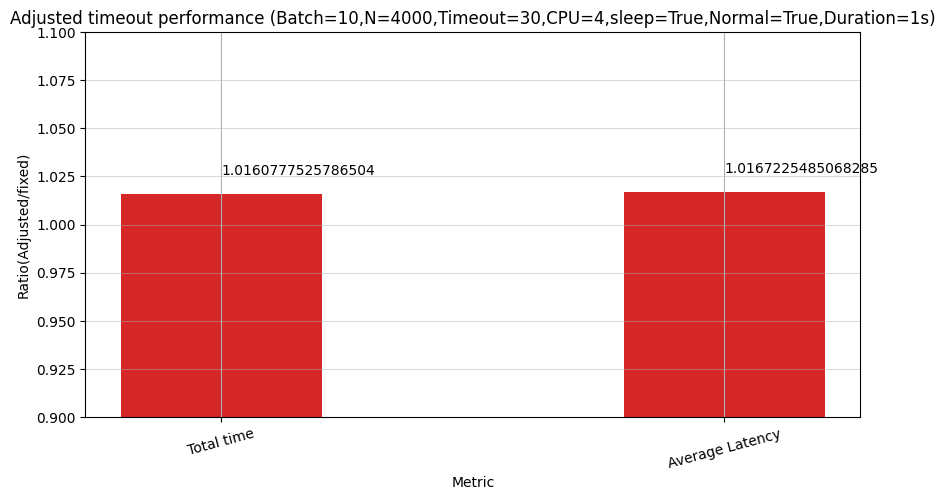

In [160]:
Clear()
Set(batch=10,N=4000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 1.429385375*pow(10,3),"avg latency": 592.069577,"cumulative": 2368278,"hmean": 192,"avg": 592,"p50": 594,"p75": 862,"p95": 1082,"p99": 1135,"p999": 1168,"Long5": 1113,"Short5": 19,"MaxM": 1188,"MinM": 6,"RangM": 1182,"StdDevM": 314,"RateSec": 1.6889906839863977,"HistogramM":""" &[map[6.088ms - 124.333ms:359] map[124.333ms - 242.577ms:202] map[242.577ms - 360.822ms:535] map[360.822ms - 479.066ms:479] map[479.066ms - 597.311ms:433] map[597.311ms - 715.556ms:454] map[715.556ms - 833.8ms:435] map[833.8ms - 952.045ms:461] map[952.045ms - 1.07029s:394] map[1.07029s - 1.188534s:248]]""","HistogramBinSize": 118.24465,"Samples": 4000,"Count": 4000,"total requests": 4000,"duplicated requests": 0,"total batches": 405,"avg batch size": 9.851851851851851,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 10,})
Set(batch=10,N=4000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 1.429587375*pow(10,3),"avg latency": 593.382138,"cumulative": 2373528,"hmean": 178,"avg": 593,"p50": 587,"p75": 837,"p95": 1065,"p99": 1109,"p999": 1142,"Long5": 1093,"Short5": 16,"MaxM": 1169,"MinM": 3,"RangM": 1165,"StdDevM": 309,"RateSec": 1.6852546361848093,"HistogramM":""" &[map[3.973ms - 120.559ms:286] map[120.559ms - 237.145ms:254] map[237.145ms - 353.731ms:490] map[353.731ms - 470.317ms:480] map[470.317ms - 586.903ms:480] map[586.903ms - 703.489ms:456] map[703.489ms - 820.075ms:469] map[820.075ms - 936.661ms:336] map[936.661ms - 1.053248s:485] map[1.053248s - 1.169834s:264]]""","HistogramBinSize": 116.586067,"Samples": 4000,"Count": 4000,"total requests": 4000,"duplicated requests": 0,"total batches": 404,"avg batch size": 9.876237623762377,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 8,})
Set(batch=10,N=4000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 1.436256625*pow(10,3),"avg latency": 586.962678,"cumulative": 2347850,"hmean": 185,"avg": 586,"p50": 576,"p75": 860,"p95": 1076,"p99": 1119,"p999": 1141,"Long5": 1104,"Short5": 18,"MaxM": 1144,"MinM": 3,"RangM": 1141,"StdDevM": 315,"RateSec": 1.703685833333987,"HistogramM":""" &[map[3.036ms - 117.18ms:341] map[117.18ms - 231.323ms:217] map[231.323ms - 345.466ms:477] map[345.466ms - 459.61ms:508] map[459.61ms - 573.753ms:445] map[573.753ms - 687.896ms:408] map[687.896ms - 802.04ms:406] map[802.04ms - 916.183ms:406] map[916.183ms - 1.030326s:413] map[1.030326s - 1.14447s:379]]""","HistogramBinSize": 114.143322,"Samples": 4000,"Count": 4000,"total requests": 4000,"duplicated requests": 0,"total batches": 403,"avg batch size": 9.898263027295286,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 9,})
Set(batch=10,N=4000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 1.437242042*pow(10,3),"avg latency": 600.992207,"cumulative": 2404397,"hmean": 179,"avg": 601,"p50": 597,"p75": 865,"p95": 1097,"p99": 1123,"p999": 1152,"Long5": 1114,"Short5": 17,"MaxM": 1183,"MinM": 4,"RangM": 1179,"StdDevM": 315,"RateSec": 1.66361816226333,"HistogramM":""" &[map[4.112ms - 122.074ms:320] map[122.074ms - 240.035ms:200] map[240.035ms - 357.997ms:526] map[357.997ms - 475.959ms:467] map[475.959ms - 593.92ms:468] map[593.92ms - 711.882ms:444] map[711.882ms - 829.844ms:459] map[829.844ms - 947.806ms:438] map[947.806ms - 1.065767s:310] map[1.065767s - 1.183729s:368]]""","HistogramBinSize": 117.961713,"Samples": 4000,"Count": 4000,"total requests": 4000,"duplicated requests": 0,"total batches": 403,"avg batch size": 9.893300248138958,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 9,})
Set(batch=10,N=4000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 1.426142042*pow(10,3),"avg latency": 591.224358,"cumulative": 2365362,"hmean": 191,"avg": 591,"p50": 587,"p75": 855,"p95": 1079,"p99": 1107,"p999": 1127,"Long5": 1097,"Short5": 18,"MaxM": 1136,"MinM": 7,"RangM": 1129,"StdDevM": 312,"RateSec": 1.691072675184853,"HistogramM":""" &[map[7.751ms - 120.674ms:317] map[120.674ms - 233.597ms:221] map[233.597ms - 346.52ms:466] map[346.52ms - 459.443ms:491] map[459.443ms - 572.366ms:462] map[572.366ms - 685.289ms:414] map[685.289ms - 798.212ms:425] map[798.212ms - 911.135ms:429] map[911.135ms - 1.024058s:328] map[1.024058s - 1.136982s:447]]""","HistogramBinSize": 112.923042,"Samples": 4000,"Count": 4000,"total requests": 4000,"duplicated requests": 0,"total batches": 404,"avg batch size": 9.871287128712872,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 12,})
# Set(batch=10,N=500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 450.17125,"avg latency": 16.847048,"cumulative": 8423,"hmean": 15,"avg": 16,"p50": 15,"p75": 19,"p95": 22,"p99": 33,"p999": 43,"Long5": 30,"Short5": 9,"MaxM": 43,"MinM": 4,"RangM": 39,"StdDevM": 4,"RateSec": 59.35757939295481,"HistogramM":""" &[map[4.352ms - 8.276ms:7] map[8.276ms - 12.2ms:30] map[12.2ms - 16.124ms:221] map[16.124ms - 20.048ms:143] map[20.048ms - 23.973ms:77] map[23.973ms - 27.897ms:7] map[27.897ms - 31.821ms:6] map[31.821ms - 35.745ms:4] map[35.745ms - 39.669ms:2] map[39.669ms - 43.593ms:3]]""","HistogramBinSize": 3.924085,"Samples": 500,"Count": 500,"total requests": 500,"duplicated requests": 0,"total batches": 54,"avg batch size": 9.166666666666666,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,2,10,10,10,10,10,10,10,5,10,10,10,4,6],"recent batches avg": 9,"timeouts triggered": 11,})
# Set(batch=10,N=500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 430.524625,"avg latency": 16.053305,"cumulative": 8026,"hmean": 15,"avg": 16,"p50": 15,"p75": 17,"p95": 21,"p99": 28,"p999": 36,"Long5": 25,"Short5": 10,"MaxM": 36,"MinM": 2,"RangM": 33,"StdDevM": 3,"RateSec": 62.29246562728719,"HistogramM":""" &[map[2.831ms - 6.201ms:4] map[6.201ms - 9.571ms:1] map[9.571ms - 12.94ms:75] map[12.94ms - 16.31ms:209] map[16.31ms - 19.679ms:154] map[19.679ms - 23.049ms:43] map[23.049ms - 26.418ms:8] map[26.418ms - 29.788ms:2] map[29.788ms - 33.158ms:3] map[33.158ms - 36.527ms:1]]""","HistogramBinSize": 3.369576,"Samples": 500,"Count": 500,"total requests": 500,"duplicated requests": 0,"total batches": 54,"avg batch size": 9.12962962962963,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,8,10,10,10,10,10,10,10,10,10,10,10,5,10,10,3],"recent batches avg": 9,"timeouts triggered": 11,})
# Set(batch=10,N=500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 403.231667,"avg latency": 20.271834,"cumulative": 10135,"hmean": 17,"avg": 20,"p50": 17,"p75": 23,"p95": 39,"p99": 47,"p999": 48,"Long5": 43,"Short5": 9,"MaxM": 48,"MinM": 4,"RangM": 43,"StdDevM": 8,"RateSec": 49.32952677580579,"HistogramM":""" &[map[4.805ms - 9.18ms:7] map[9.18ms - 13.556ms:66] map[13.556ms - 17.931ms:177] map[17.931ms - 22.306ms:106] map[22.306ms - 26.682ms:70] map[26.682ms - 31.057ms:14] map[31.057ms - 35.432ms:21] map[35.432ms - 39.808ms:19] map[39.808ms - 44.183ms:10] map[44.183ms - 48.558ms:10]]""","HistogramBinSize": 4.37531,"Samples": 500,"Count": 500,"total requests": 500,"duplicated requests": 0,"total batches": 53,"avg batch size": 9.264150943396226,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,7,10,10,10,10,10,10,10,10,10,2,10,10,10,10,10,10,10,10,10,10,10,10,5,10,10,10,10],"recent batches avg": 9,"timeouts triggered": 9,})
# Set(batch=10,N=500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 417.042792,"avg latency": 16.496254,"cumulative": 8248,"hmean": 15,"avg": 16,"p50": 15,"p75": 18,"p95": 23,"p99": 33,"p999": 41,"Long5": 28,"Short5": 9,"MaxM": 41,"MinM": 4,"RangM": 37,"StdDevM": 4,"RateSec": 60.61981987233953,"HistogramM":""" &[map[4.858ms - 8.569ms:12] map[8.569ms - 12.28ms:29] map[12.28ms - 15.992ms:233] map[15.992ms - 19.703ms:134] map[19.703ms - 23.415ms:68] map[23.415ms - 27.126ms:13] map[27.126ms - 30.837ms:3] map[30.837ms - 34.549ms:4] map[34.549ms - 38.26ms:2] map[38.26ms - 41.972ms:2]]""","HistogramBinSize": 3.711395,"Samples": 500,"Count": 500,"total requests": 500,"duplicated requests": 0,"total batches": 55,"avg batch size": 9.036363636363637,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,5,10,10,10,10,10,10,10,10,9,10,10,10,10,10,10,6,10,10,2,10,9],"recent batches avg": 9,"timeouts triggered": 11,})
# Set(batch=10,N=500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 444.157333,"avg latency": 18.272811,"cumulative": 9136,"hmean": 16,"avg": 18,"p50": 16,"p75": 23,"p95": 26,"p99": 28,"p999": 31,"Long5": 27,"Short5": 8,"MaxM": 31,"MinM": 4,"RangM": 26,"StdDevM": 5,"RateSec": 54.726114428245026,"HistogramM":""" &[map[4.908ms - 7.576ms:8] map[7.576ms - 10.244ms:18] map[10.244ms - 12.912ms:58] map[12.912ms - 15.58ms:112] map[15.58ms - 18.248ms:81] map[18.248ms - 20.916ms:48] map[20.916ms - 23.584ms:40] map[23.584ms - 26.252ms:108] map[26.252ms - 28.919ms:25] map[28.919ms - 31.587ms:2]]""","HistogramBinSize": 2.66793,"Samples": 500,"Count": 500,"total requests": 500,"duplicated requests": 0,"total batches": 54,"avg batch size": 9.148148148148149,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,3,10,10,10,10,10,10,10,10,10,10,10,10,10,5,10,10,10,10,10,10,10,10,4,10,10],"recent batches avg": 9,"timeouts triggered": 12,})


x = [e['total time'] for e in GetElementsFromEntryList(FindKeys())]
x = sum(x)/len(x)
total_1 = x
x = [e['avg latency'] for e in GetElementsFromEntryList(FindKeys())]
x = sum(x)/len(x)
avg_1 = x

Clear()
Set(batch=10,N=4000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 1.453069041*pow(10,3),"avg latency": 596.447905,"cumulative": 2386325,"hmean": 185,"avg": 596,"p50": 595,"p75": 861,"p95": 1106,"p99": 1152,"p999": 1173,"Long5": 1133,"Short5": 17,"MaxM": 1177,"MinM": 8,"RangM": 1169,"StdDevM": 320,"RateSec": 1.6762174787120625,"HistogramM":""" &[map[8.017ms - 124.982ms:298] map[124.982ms - 241.948ms:309] map[241.948ms - 358.914ms:480] map[358.914ms - 475.88ms:460] map[475.88ms - 592.846ms:445] map[592.846ms - 709.812ms:454] map[709.812ms - 826.778ms:433] map[826.778ms - 943.743ms:334] map[943.743ms - 1.060709s:463] map[1.060709s - 1.177675s:324]]""","HistogramBinSize": 116.965837,"Samples": 4000,"Count": 4000,"total requests": 4000,"duplicated requests": 0,"total batches": 402,"avg batch size": 9.92039800995025,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 8,})
Set(batch=10,N=4000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 1.426372709*pow(10,3),"avg latency": 582.837981,"cumulative": 2331351,"hmean": 169,"avg": 582,"p50": 586,"p75": 863,"p95": 1055,"p99": 1087,"p999": 1105,"Long5": 1076,"Short5": 16,"MaxM": 1112,"MinM": 2,"RangM": 1109,"StdDevM": 315,"RateSec": 1.7157426782413614,"HistogramM":""" &[map[2.986ms - 113.917ms:367] map[113.917ms - 224.848ms:188] map[224.848ms - 335.779ms:482] map[335.779ms - 446.71ms:450] map[446.71ms - 557.64ms:424] map[557.64ms - 668.571ms:416] map[668.571ms - 779.502ms:367] map[779.502ms - 890.433ms:439] map[890.433ms - 1.001363s:382] map[1.001363s - 1.112294s:485]]""","HistogramBinSize": 110.93077,"Samples": 4000,"Count": 4000,"total requests": 4000,"duplicated requests": 0,"total batches": 404,"avg batch size": 9.868811881188119,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 11,})
Set(batch=10,N=4000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 1.472531708*pow(10,3),"avg latency": 620.955309,"cumulative": 2484391,"hmean": 192,"avg": 621,"p50": 621,"p75": 889,"p95": 1099,"p99": 1142,"p999": 1167,"Long5": 1127,"Short5": 17,"MaxM": 1172,"MinM": 4,"RangM": 1168,"StdDevM": 317,"RateSec": 1.6100522249727671,"HistogramM":""" &[map[4.535ms - 121.336ms:246] map[121.336ms - 238.136ms:240] map[238.136ms - 354.936ms:476] map[354.936ms - 471.736ms:476] map[471.736ms - 588.536ms:439] map[588.536ms - 705.337ms:457] map[705.337ms - 822.137ms:407] map[822.137ms - 938.937ms:416] map[938.937ms - 1.055737s:426] map[1.055737s - 1.172537s:417]]""","HistogramBinSize": 116.800183,"Samples": 4000,"Count": 4000,"total requests": 4000,"duplicated requests": 0,"total batches": 404,"avg batch size": 9.873762376237623,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 9,})
Set(batch=10,N=4000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 1.465810667*pow(10,3),"avg latency": 602.13984,"cumulative": 2409082,"hmean": 189,"avg": 602,"p50": 604,"p75": 875,"p95": 1106,"p99": 1131,"p999": 1159,"Long5": 1122,"Short5": 19,"MaxM": 1161,"MinM": 5,"RangM": 1156,"StdDevM": 323,"RateSec": 1.6603829953993576,"HistogramM":""" &[map[5.103ms - 120.764ms:349] map[120.764ms - 236.426ms:207] map[236.426ms - 352.087ms:484] map[352.087ms - 467.748ms:491] map[467.748ms - 583.409ms:391] map[583.409ms - 699.07ms:433] map[699.07ms - 814.732ms:463] map[814.732ms - 930.393ms:337] map[930.393ms - 1.046054s:418] map[1.046054s - 1.161715s:427]]""","HistogramBinSize": 115.66122,"Samples": 4000,"Count": 4000,"total requests": 4000,"duplicated requests": 0,"total batches": 406,"avg batch size": 9.82512315270936,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 11,})
Set(batch=10,N=4000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 1.45592375*pow(10,3),"avg latency": 611.826108,"cumulative": 2448344,"hmean": 186,"avg": 612,"p50": 606,"p75": 905,"p95": 1086,"p99": 1157,"p999": 1178,"Long5": 1139,"Short5": 17,"MaxM": 1206,"MinM": 3,"RangM": 1203,"StdDevM": 315,"RateSec": 1.6337570481007362,"HistogramM":""" &[map[3.071ms - 123.419ms:240] map[123.419ms - 243.768ms:288] map[243.768ms - 364.116ms:492] map[364.116ms - 484.464ms:503] map[484.464ms - 604.812ms:473] map[604.812ms - 725.161ms:465] map[725.161ms - 845.509ms:438] map[845.509ms - 965.857ms:365] map[965.857ms - 1.086205s:534] map[1.086205s - 1.206554s:202]]""","HistogramBinSize": 120.348254,"Samples": 4000,"Count": 4000,"total requests": 4000,"duplicated requests": 0,"total batches": 404,"avg batch size": 9.871287128712872,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 11,})
# Set(batch=10,N=500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 401.449833,"avg latency": 15.80895,"cumulative": 7904,"hmean": 14,"avg": 15,"p50": 15,"p75": 17,"p95": 20,"p99": 30,"p999": 40,"Long5": 26,"Short5": 8,"MaxM": 40,"MinM": 6,"RangM": 33,"StdDevM": 3,"RateSec": 63.25530703075362,"HistogramM":""" &[map[6.422ms - 9.788ms:21] map[9.788ms - 13.153ms:83] map[13.153ms - 16.518ms:202] map[16.518ms - 19.883ms:151] map[19.883ms - 23.248ms:30] map[23.248ms - 26.613ms:5] map[26.613ms - 29.978ms:2] map[29.978ms - 33.344ms:2] map[33.344ms - 36.709ms:1] map[36.709ms - 40.074ms:3]]""","HistogramBinSize": 3.365161,"Samples": 500,"Count": 500,"total requests": 500,"duplicated requests": 0,"total batches": 54,"avg batch size": 9.12962962962963,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,4,10,10,10,10,10,10,7,10,10,10,10,10,10,10,10,10,7,10,10,10,10,10,5,10],"recent batches avg": 9,"timeouts triggered": 10,})
# Set(batch=10,N=500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 429.761,"avg latency": 19.612197,"cumulative": 9806,"hmean": 17,"avg": 19,"p50": 19,"p75": 24,"p95": 29,"p99": 32,"p999": 33,"Long5": 31,"Short5": 10,"MaxM": 33,"MinM": 2,"RangM": 30,"StdDevM": 5,"RateSec": 50.98867654668364,"HistogramM":""" &[map[2.971ms - 6.066ms:1] map[6.066ms - 9.162ms:2] map[9.162ms - 12.257ms:29] map[12.257ms - 15.353ms:107] map[15.353ms - 18.448ms:90] map[18.448ms - 21.543ms:106] map[21.543ms - 24.639ms:52] map[24.639ms - 27.734ms:64] map[27.734ms - 30.83ms:32] map[30.83ms - 33.925ms:17]]""","HistogramBinSize": 3.095416,"Samples": 500,"Count": 500,"total requests": 500,"duplicated requests": 0,"total batches": 53,"avg batch size": 9.283018867924529,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [7,10,10,10,10,10,10,10,10,10,7,10,10,10,10,10,10,10,10,10,8,10,10,10,10,10,10,10,10,10,10,4],"recent batches avg": 9,"timeouts triggered": 10,})
# Set(batch=10,N=500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 398.4475,"avg latency": 17.116849,"cumulative": 8558,"hmean": 15,"avg": 17,"p50": 16,"p75": 20,"p95": 24,"p99": 30,"p999": 33,"Long5": 27,"Short5": 9,"MaxM": 33,"MinM": 2,"RangM": 30,"StdDevM": 4,"RateSec": 58.42196462888773,"HistogramM":""" &[map[2.974ms - 6.059ms:2] map[6.059ms - 9.145ms:7] map[9.145ms - 12.231ms:23] map[12.231ms - 15.317ms:195] map[15.317ms - 18.402ms:91] map[18.402ms - 21.488ms:89] map[21.488ms - 24.574ms:72] map[24.574ms - 27.66ms:13] map[27.66ms - 30.746ms:5] map[30.746ms - 33.831ms:3]]""","HistogramBinSize": 3.085782,"Samples": 500,"Count": 500,"total requests": 500,"duplicated requests": 0,"total batches": 53,"avg batch size": 9.339622641509434,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,5,10,10,10,10,10,10,2,10],"recent batches avg": 9,"timeouts triggered": 9,})
# Set(batch=10,N=500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 406.039291,"avg latency": 16.386889,"cumulative": 8193,"hmean": 15,"avg": 16,"p50": 15,"p75": 18,"p95": 22,"p99": 32,"p999": 39,"Long5": 27,"Short5": 9,"MaxM": 39,"MinM": 3,"RangM": 36,"StdDevM": 4,"RateSec": 61.02439325887063,"HistogramM":""" &[map[3.374ms - 6.983ms:1] map[6.983ms - 10.591ms:16] map[10.591ms - 14.2ms:131] map[14.2ms - 17.809ms:210] map[17.809ms - 21.418ms:101] map[21.418ms - 25.026ms:24] map[25.026ms - 28.635ms:8] map[28.635ms - 32.244ms:3] map[32.244ms - 35.853ms:4] map[35.853ms - 39.461ms:2]]""","HistogramBinSize": 3.60873,"Samples": 500,"Count": 500,"total requests": 500,"duplicated requests": 0,"total batches": 53,"avg batch size": 9.283018867924529,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,8,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,6,10,10,10,6,10],"recent batches avg": 9,"timeouts triggered": 11,})
# Set(batch=10,N=500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 406.300542,"avg latency": 15.267291,"cumulative": 7633,"hmean": 14,"avg": 15,"p50": 14,"p75": 16,"p95": 20,"p99": 28,"p999": 43,"Long5": 26,"Short5": 8,"MaxM": 43,"MinM": 5,"RangM": 38,"StdDevM": 3,"RateSec": 65.49950188224864,"HistogramM":""" &[map[5.17ms - 9.045ms:13] map[9.045ms - 12.92ms:65] map[12.92ms - 16.795ms:318] map[16.795ms - 20.67ms:80] map[20.67ms - 24.545ms:14] map[24.545ms - 28.42ms:3] map[28.42ms - 32.295ms:2] map[32.295ms - 36.17ms:1] map[36.17ms - 40.045ms:1] map[40.045ms - 43.92ms:3]]""","HistogramBinSize": 3.875004,"Samples": 500,"Count": 500,"total requests": 500,"duplicated requests": 0,"total batches": 55,"avg batch size": 9,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,5,10,10,10,2,10,10,5],"recent batches avg": 9,"timeouts triggered": 9,})

x = [e['total time'] for e in GetElementsFromEntryList(FindKeys())]
x = sum(x)/len(x)
total_2 = x
x = [e['avg latency'] for e in GetElementsFromEntryList(FindKeys())]
x = sum(x)/len(x)
avg_2 = x

print(total_2/total_1,avg_2/avg_1)

print(total_1,total_2,avg_1,avg_2)

bar_plot(['Total time','Average Latency'],[total_2/total_1,avg_2/avg_1],x_label='Metric',y_label='Ratio(Adjusted/fixed)',rotation=True,title="Adjusted timeout performance (Batch=10,N=4000,Timeout=30,CPU=4,sleep=True,Normal=True,Duration=1s)",horizontal_grid_only=True,file_path='ajudsted_timeout_perf_4000.png',width=0.4,fig_size=(10,5),y_lim = [0.9,1.1],y_text = True)

# bar_plot(['Fixed','Adjusted'],[total_1,total_2],x_label='Timeout type',y_label='Total time(ms)',title="Total time(ms) by timeout type (Batch=10,N=500,Timeout=30,CPU=4,sleep=True,Normal=True,Duration=1s)",horizontal_grid_only=True,file_path='total_time_adjuted_timeout.png',width=0.4,fig_size=(10,5))
# bar_plot(['Fixed','Adjusted'],[avg_1,avg_2],x_label='Timeout type',y_label='Average Latency(ms)',title="Average Latency(ms) by timeout type (Batch=10,N=500,Timeout=30,CPU=4,sleep=True,Normal=True,Duration=1s)",horizontal_grid_only=True,file_path='avg_lat_adjuted_timeout.png',width=0.4,fig_size=(10,5))

0.951923839971619 0.9573684031698798
429.0255334 408.39963320000004 17.5882504 16.8384352


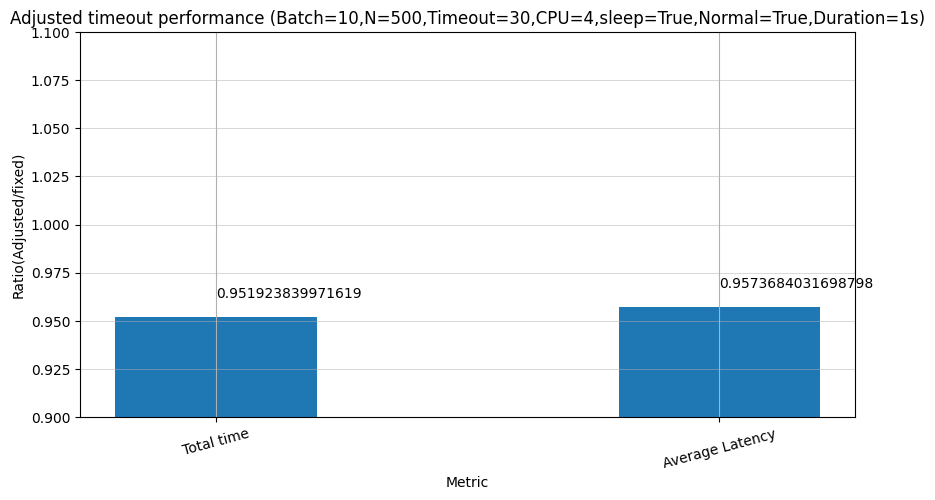

In [161]:
Clear()
Set(batch=10,N=500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 450.17125,"avg latency": 16.847048,"cumulative": 8423,"hmean": 15,"avg": 16,"p50": 15,"p75": 19,"p95": 22,"p99": 33,"p999": 43,"Long5": 30,"Short5": 9,"MaxM": 43,"MinM": 4,"RangM": 39,"StdDevM": 4,"RateSec": 59.35757939295481,"HistogramM":""" &[map[4.352ms - 8.276ms:7] map[8.276ms - 12.2ms:30] map[12.2ms - 16.124ms:221] map[16.124ms - 20.048ms:143] map[20.048ms - 23.973ms:77] map[23.973ms - 27.897ms:7] map[27.897ms - 31.821ms:6] map[31.821ms - 35.745ms:4] map[35.745ms - 39.669ms:2] map[39.669ms - 43.593ms:3]]""","HistogramBinSize": 3.924085,"Samples": 500,"Count": 500,"total requests": 500,"duplicated requests": 0,"total batches": 54,"avg batch size": 9.166666666666666,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,2,10,10,10,10,10,10,10,5,10,10,10,4,6],"recent batches avg": 9,"timeouts triggered": 11,})
Set(batch=10,N=500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 430.524625,"avg latency": 16.053305,"cumulative": 8026,"hmean": 15,"avg": 16,"p50": 15,"p75": 17,"p95": 21,"p99": 28,"p999": 36,"Long5": 25,"Short5": 10,"MaxM": 36,"MinM": 2,"RangM": 33,"StdDevM": 3,"RateSec": 62.29246562728719,"HistogramM":""" &[map[2.831ms - 6.201ms:4] map[6.201ms - 9.571ms:1] map[9.571ms - 12.94ms:75] map[12.94ms - 16.31ms:209] map[16.31ms - 19.679ms:154] map[19.679ms - 23.049ms:43] map[23.049ms - 26.418ms:8] map[26.418ms - 29.788ms:2] map[29.788ms - 33.158ms:3] map[33.158ms - 36.527ms:1]]""","HistogramBinSize": 3.369576,"Samples": 500,"Count": 500,"total requests": 500,"duplicated requests": 0,"total batches": 54,"avg batch size": 9.12962962962963,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,8,10,10,10,10,10,10,10,10,10,10,10,5,10,10,3],"recent batches avg": 9,"timeouts triggered": 11,})
Set(batch=10,N=500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 403.231667,"avg latency": 20.271834,"cumulative": 10135,"hmean": 17,"avg": 20,"p50": 17,"p75": 23,"p95": 39,"p99": 47,"p999": 48,"Long5": 43,"Short5": 9,"MaxM": 48,"MinM": 4,"RangM": 43,"StdDevM": 8,"RateSec": 49.32952677580579,"HistogramM":""" &[map[4.805ms - 9.18ms:7] map[9.18ms - 13.556ms:66] map[13.556ms - 17.931ms:177] map[17.931ms - 22.306ms:106] map[22.306ms - 26.682ms:70] map[26.682ms - 31.057ms:14] map[31.057ms - 35.432ms:21] map[35.432ms - 39.808ms:19] map[39.808ms - 44.183ms:10] map[44.183ms - 48.558ms:10]]""","HistogramBinSize": 4.37531,"Samples": 500,"Count": 500,"total requests": 500,"duplicated requests": 0,"total batches": 53,"avg batch size": 9.264150943396226,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,7,10,10,10,10,10,10,10,10,10,2,10,10,10,10,10,10,10,10,10,10,10,10,5,10,10,10,10],"recent batches avg": 9,"timeouts triggered": 9,})
Set(batch=10,N=500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 417.042792,"avg latency": 16.496254,"cumulative": 8248,"hmean": 15,"avg": 16,"p50": 15,"p75": 18,"p95": 23,"p99": 33,"p999": 41,"Long5": 28,"Short5": 9,"MaxM": 41,"MinM": 4,"RangM": 37,"StdDevM": 4,"RateSec": 60.61981987233953,"HistogramM":""" &[map[4.858ms - 8.569ms:12] map[8.569ms - 12.28ms:29] map[12.28ms - 15.992ms:233] map[15.992ms - 19.703ms:134] map[19.703ms - 23.415ms:68] map[23.415ms - 27.126ms:13] map[27.126ms - 30.837ms:3] map[30.837ms - 34.549ms:4] map[34.549ms - 38.26ms:2] map[38.26ms - 41.972ms:2]]""","HistogramBinSize": 3.711395,"Samples": 500,"Count": 500,"total requests": 500,"duplicated requests": 0,"total batches": 55,"avg batch size": 9.036363636363637,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,5,10,10,10,10,10,10,10,10,9,10,10,10,10,10,10,6,10,10,2,10,9],"recent batches avg": 9,"timeouts triggered": 11,})
Set(batch=10,N=500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 444.157333,"avg latency": 18.272811,"cumulative": 9136,"hmean": 16,"avg": 18,"p50": 16,"p75": 23,"p95": 26,"p99": 28,"p999": 31,"Long5": 27,"Short5": 8,"MaxM": 31,"MinM": 4,"RangM": 26,"StdDevM": 5,"RateSec": 54.726114428245026,"HistogramM":""" &[map[4.908ms - 7.576ms:8] map[7.576ms - 10.244ms:18] map[10.244ms - 12.912ms:58] map[12.912ms - 15.58ms:112] map[15.58ms - 18.248ms:81] map[18.248ms - 20.916ms:48] map[20.916ms - 23.584ms:40] map[23.584ms - 26.252ms:108] map[26.252ms - 28.919ms:25] map[28.919ms - 31.587ms:2]]""","HistogramBinSize": 2.66793,"Samples": 500,"Count": 500,"total requests": 500,"duplicated requests": 0,"total batches": 54,"avg batch size": 9.148148148148149,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,3,10,10,10,10,10,10,10,10,10,10,10,10,10,5,10,10,10,10,10,10,10,10,4,10,10],"recent batches avg": 9,"timeouts triggered": 12,})


x = [e['total time'] for e in GetElementsFromEntryList(FindKeys())]
x = sum(x)/len(x)
total_1 = x
x = [e['avg latency'] for e in GetElementsFromEntryList(FindKeys())]
x = sum(x)/len(x)
avg_1 = x

Clear()
Set(batch=10,N=500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 401.449833,"avg latency": 15.80895,"cumulative": 7904,"hmean": 14,"avg": 15,"p50": 15,"p75": 17,"p95": 20,"p99": 30,"p999": 40,"Long5": 26,"Short5": 8,"MaxM": 40,"MinM": 6,"RangM": 33,"StdDevM": 3,"RateSec": 63.25530703075362,"HistogramM":""" &[map[6.422ms - 9.788ms:21] map[9.788ms - 13.153ms:83] map[13.153ms - 16.518ms:202] map[16.518ms - 19.883ms:151] map[19.883ms - 23.248ms:30] map[23.248ms - 26.613ms:5] map[26.613ms - 29.978ms:2] map[29.978ms - 33.344ms:2] map[33.344ms - 36.709ms:1] map[36.709ms - 40.074ms:3]]""","HistogramBinSize": 3.365161,"Samples": 500,"Count": 500,"total requests": 500,"duplicated requests": 0,"total batches": 54,"avg batch size": 9.12962962962963,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,4,10,10,10,10,10,10,7,10,10,10,10,10,10,10,10,10,7,10,10,10,10,10,5,10],"recent batches avg": 9,"timeouts triggered": 10,})
Set(batch=10,N=500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 429.761,"avg latency": 19.612197,"cumulative": 9806,"hmean": 17,"avg": 19,"p50": 19,"p75": 24,"p95": 29,"p99": 32,"p999": 33,"Long5": 31,"Short5": 10,"MaxM": 33,"MinM": 2,"RangM": 30,"StdDevM": 5,"RateSec": 50.98867654668364,"HistogramM":""" &[map[2.971ms - 6.066ms:1] map[6.066ms - 9.162ms:2] map[9.162ms - 12.257ms:29] map[12.257ms - 15.353ms:107] map[15.353ms - 18.448ms:90] map[18.448ms - 21.543ms:106] map[21.543ms - 24.639ms:52] map[24.639ms - 27.734ms:64] map[27.734ms - 30.83ms:32] map[30.83ms - 33.925ms:17]]""","HistogramBinSize": 3.095416,"Samples": 500,"Count": 500,"total requests": 500,"duplicated requests": 0,"total batches": 53,"avg batch size": 9.283018867924529,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [7,10,10,10,10,10,10,10,10,10,7,10,10,10,10,10,10,10,10,10,8,10,10,10,10,10,10,10,10,10,10,4],"recent batches avg": 9,"timeouts triggered": 10,})
Set(batch=10,N=500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 398.4475,"avg latency": 17.116849,"cumulative": 8558,"hmean": 15,"avg": 17,"p50": 16,"p75": 20,"p95": 24,"p99": 30,"p999": 33,"Long5": 27,"Short5": 9,"MaxM": 33,"MinM": 2,"RangM": 30,"StdDevM": 4,"RateSec": 58.42196462888773,"HistogramM":""" &[map[2.974ms - 6.059ms:2] map[6.059ms - 9.145ms:7] map[9.145ms - 12.231ms:23] map[12.231ms - 15.317ms:195] map[15.317ms - 18.402ms:91] map[18.402ms - 21.488ms:89] map[21.488ms - 24.574ms:72] map[24.574ms - 27.66ms:13] map[27.66ms - 30.746ms:5] map[30.746ms - 33.831ms:3]]""","HistogramBinSize": 3.085782,"Samples": 500,"Count": 500,"total requests": 500,"duplicated requests": 0,"total batches": 53,"avg batch size": 9.339622641509434,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,5,10,10,10,10,10,10,2,10],"recent batches avg": 9,"timeouts triggered": 9,})
Set(batch=10,N=500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 406.039291,"avg latency": 16.386889,"cumulative": 8193,"hmean": 15,"avg": 16,"p50": 15,"p75": 18,"p95": 22,"p99": 32,"p999": 39,"Long5": 27,"Short5": 9,"MaxM": 39,"MinM": 3,"RangM": 36,"StdDevM": 4,"RateSec": 61.02439325887063,"HistogramM":""" &[map[3.374ms - 6.983ms:1] map[6.983ms - 10.591ms:16] map[10.591ms - 14.2ms:131] map[14.2ms - 17.809ms:210] map[17.809ms - 21.418ms:101] map[21.418ms - 25.026ms:24] map[25.026ms - 28.635ms:8] map[28.635ms - 32.244ms:3] map[32.244ms - 35.853ms:4] map[35.853ms - 39.461ms:2]]""","HistogramBinSize": 3.60873,"Samples": 500,"Count": 500,"total requests": 500,"duplicated requests": 0,"total batches": 53,"avg batch size": 9.283018867924529,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,8,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,6,10,10,10,6,10],"recent batches avg": 9,"timeouts triggered": 11,})
Set(batch=10,N=500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 406.300542,"avg latency": 15.267291,"cumulative": 7633,"hmean": 14,"avg": 15,"p50": 14,"p75": 16,"p95": 20,"p99": 28,"p999": 43,"Long5": 26,"Short5": 8,"MaxM": 43,"MinM": 5,"RangM": 38,"StdDevM": 3,"RateSec": 65.49950188224864,"HistogramM":""" &[map[5.17ms - 9.045ms:13] map[9.045ms - 12.92ms:65] map[12.92ms - 16.795ms:318] map[16.795ms - 20.67ms:80] map[20.67ms - 24.545ms:14] map[24.545ms - 28.42ms:3] map[28.42ms - 32.295ms:2] map[32.295ms - 36.17ms:1] map[36.17ms - 40.045ms:1] map[40.045ms - 43.92ms:3]]""","HistogramBinSize": 3.875004,"Samples": 500,"Count": 500,"total requests": 500,"duplicated requests": 0,"total batches": 55,"avg batch size": 9,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,5,10,10,10,2,10,10,5],"recent batches avg": 9,"timeouts triggered": 9,})

x = [e['total time'] for e in GetElementsFromEntryList(FindKeys())]
x = sum(x)/len(x)
total_2 = x
x = [e['avg latency'] for e in GetElementsFromEntryList(FindKeys())]
x = sum(x)/len(x)
avg_2 = x

print(total_2/total_1,avg_2/avg_1)

print(total_1,total_2,avg_1,avg_2)

bar_plot(['Total time','Average Latency'],[total_2/total_1,avg_2/avg_1],x_label='Metric',y_label='Ratio(Adjusted/fixed)',rotation=True,title="Adjusted timeout performance (Batch=10,N=500,Timeout=30,CPU=4,sleep=True,Normal=True,Duration=1s)",horizontal_grid_only=True,file_path='ajudsted_timeout_perf_500.png',width=0.4,fig_size=(10,5),y_lim = [0.9,1.1],y_text = True)


# bar_plot(['Fixed','Adjusted'],[total_1,total_2],x_label='Timeout type',y_label='Total time(ms)',title="Total time(ms) by timeout type (Batch=10,N=500,Timeout=30,CPU=4,sleep=True,Normal=True,Duration=1s)",horizontal_grid_only=True,file_path='total_time_adjuted_timeout.png',width=0.4,fig_size=(10,5))
# bar_plot(['Fixed','Adjusted'],[avg_1,avg_2],x_label='Timeout type',y_label='Average Latency(ms)',title="Average Latency(ms) by timeout type (Batch=10,N=500,Timeout=30,CPU=4,sleep=True,Normal=True,Duration=1s)",horizontal_grid_only=True,file_path='avg_lat_adjuted_timeout.png',width=0.4,fig_size=(10,5))

{500: 417.78635813333347, 1000: 462.82466680000005, 1500: 601.0742637999999, 2000: 760.4516000666666, 2500: 928.7245279333333, 3000: 1097.9171139999999, 3500: 1263.193164, 4000: 1435.6271582666666}
{500: 427.20898320000003, 1000: 465.7614972, 1500: 603.9683638, 2000: 759.9991917333333, 2500: 926.6595610000002, 3000: 1097.6359971333334, 3500: 1269.2514472000005, 4000: 1431.8393}
{500: 417.78635813333347, 1000: 462.82466680000005, 1500: 601.0742637999999, 2000: 760.4516000666666, 2500: 928.7245279333333, 3000: 1097.9171139999999, 3500: 1263.193164, 4000: 1435.6271582666666}
{500: 17.20239493333333, 1000: 67.11800546666667, 1500: 134.14718873333334, 2000: 215.58942353333336, 2500: 306.90789, 3000: 404.39066253333334, 3500: 500.77673219999997, 4000: 590.9700817333335}
{500: 17.171782066666665, 1000: 66.11137726666668, 1500: 131.95257266666664, 2000: 215.3902321333333, 2500: 309.0663647333334, 3000: 405.19484099999994, 3500: 494.5507275999999, 4000: 592.5379173333333}
{500: 0.97794375718392

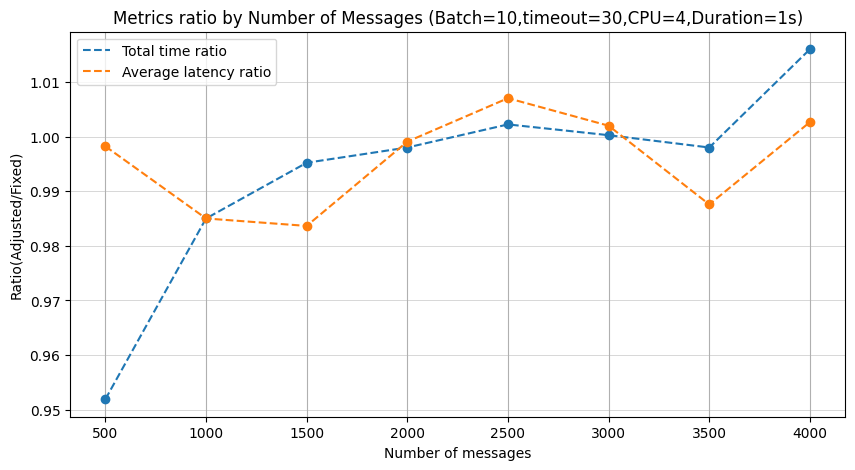

In [184]:
def SetNoAdaptionCase():
    Clear()
    Set(batch=10,N=500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 428.66325,"avg latency": 18.675953,"cumulative": 9355,"hmean": 17,"avg": 18,"p50": 17,"p75": 22,"p95": 27,"p99": 32,"p999": 38,"Long5": 30,"Short5": 10,"MaxM": 38,"MinM": 4,"RangM": 34,"StdDevM": 5,"RateSec": 53.442431431123104,"HistogramM":""" &[map[4.337ms - 7.776ms:5] map[7.776ms - 11.216ms:4] map[11.216ms - 14.655ms:117] map[14.655ms - 18.095ms:140] map[18.095ms - 21.535ms:77] map[21.535ms - 24.974ms:92] map[24.974ms - 28.414ms:41] map[28.414ms - 31.854ms:18] map[31.854ms - 35.293ms:5] map[35.293ms - 38.733ms:1]]""","HistogramBinSize": 3.439616,"Samples": 500,"Count": 500,"total requests": 500,"duplicated requests": 0,"total batches": 53,"avg batch size": 9.283018867924529,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,9,10,10,3,10,10,10,10,10,10,10,10,10,10,10,10,10,2,10,10,10,9,10,6],"recent batches avg": 9,"timeouts triggered": 12,})
    Set(batch=10,N=1000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 461.898417,"avg latency": 65.733029,"cumulative": 65733,"hmean": 34,"avg": 65,"p50": 64,"p75": 106,"p95": 123,"p99": 125,"p999": 126,"Long5": 124,"Short5": 10,"MaxM": 126,"MinM": 4,"RangM": 122,"StdDevM": 40,"RateSec": 15.213052062820656,"HistogramM":""" &[map[4.131ms - 16.385ms:149] map[16.385ms - 28.638ms:149] map[28.638ms - 40.891ms:68] map[40.891ms - 53.145ms:74] map[53.145ms - 65.398ms:76] map[65.398ms - 77.651ms:54] map[77.651ms - 89.905ms:84] map[89.905ms - 102.158ms:66] map[102.158ms - 114.411ms:92] map[114.411ms - 126.665ms:188]]""","HistogramBinSize": 12.253312,"Samples": 1000,"Count": 1000,"total requests": 1000,"duplicated requests": 0,"total batches": 104,"avg batch size": 9.5,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,4,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 9,"timeouts triggered": 9,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 607.428583,"avg latency": 135.33224,"cumulative": 202998,"hmean": 54,"avg": 135,"p50": 134,"p75": 215,"p95": 255,"p99": 258,"p999": 259,"Long5": 257,"Short5": 12,"MaxM": 260,"MinM": 3,"RangM": 257,"StdDevM": 84,"RateSec": 7.389222212182865,"HistogramM":""" &[map[3.001ms - 28.711ms:252] map[28.711ms - 54.422ms:128] map[54.422ms - 80.132ms:110] map[80.132ms - 105.842ms:120] map[105.842ms - 131.552ms:120] map[131.552ms - 157.262ms:104] map[157.262ms - 182.973ms:123] map[182.973ms - 208.683ms:128] map[208.683ms - 234.393ms:144] map[234.393ms - 260.103ms:271]]""","HistogramBinSize": 25.710215,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 154,"avg batch size": 9.668831168831169,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 10,})
    Set(batch=10,N=2000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 764.456542,"avg latency": 221.49253,"cumulative": 442985,"hmean": 75,"avg": 221,"p50": 228,"p75": 341,"p95": 406,"p99": 412,"p999": 414,"Long5": 409,"Short5": 12,"MaxM": 414,"MinM": 2,"RangM": 411,"StdDevM": 129,"RateSec": 4.51482492999965,"HistogramM":""" &[map[2.75ms - 43.937ms:299] map[43.937ms - 85.124ms:77] map[85.124ms - 126.311ms:194] map[126.311ms - 167.497ms:176] map[167.497ms - 208.684ms:178] map[208.684ms - 249.871ms:176] map[249.871ms - 291.058ms:178] map[291.058ms - 332.245ms:182] map[332.245ms - 373.432ms:196] map[373.432ms - 414.618ms:344]]""","HistogramBinSize": 41.186833,"Samples": 2000,"Count": 2000,"total requests": 2000,"duplicated requests": 0,"total batches": 206,"avg batch size": 9.655339805825243,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 11,})
    Set(batch=10,N=2500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 921.420375,"avg latency": 303.725815,"cumulative": 759748,"hmean": 94,"avg": 303,"p50": 306,"p75": 467,"p95": 554,"p99": 561,"p999": 564,"Long5": 559,"Short5": 12,"MaxM": 564,"MinM": 2,"RangM": 561,"StdDevM": 173,"RateSec": 3.290564094952437,"HistogramM":""" &[map[2.933ms - 59.102ms:340] map[59.102ms - 115.271ms:67] map[115.271ms - 171.44ms:250] map[171.44ms - 227.609ms:245] map[227.609ms - 283.778ms:249] map[283.778ms - 339.947ms:226] map[339.947ms - 396.116ms:204] map[396.116ms - 452.285ms:234] map[452.285ms - 508.454ms:283] map[508.454ms - 564.623ms:402]]""","HistogramBinSize": 56.168955,"Samples": 2500,"Count": 2500,"total requests": 2500,"duplicated requests": 0,"total batches": 253,"avg batch size": 9.826086956521738,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 12,})
    Set(batch=10,N=3000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 1.102841208*pow(10,3),"avg latency": 409.57742,"cumulative": 1228732,"hmean": 130,"avg": 409,"p50": 413,"p75": 604,"p95": 744,"p99": 785,"p999": 804,"Long5": 762,"Short5": 14,"MaxM": 807,"MinM": 4,"RangM": 803,"StdDevM": 223,"RateSec": 2.4415408443599667,"HistogramM":""" &[map[4.147ms - 84.494ms:299] map[84.494ms - 164.84ms:181] map[164.84ms - 245.186ms:324] map[245.186ms - 325.533ms:344] map[325.533ms - 405.879ms:315] map[405.879ms - 486.225ms:336] map[486.225ms - 566.572ms:292] map[566.572ms - 646.918ms:350] map[646.918ms - 727.264ms:285] map[727.264ms - 807.611ms:274]]""","HistogramBinSize": 80.346317,"Samples": 3000,"Count": 3000,"total requests": 3000,"duplicated requests": 0,"total batches": 303,"avg batch size": 9.854785478547855,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 12,})
    Set(batch=10,N=3500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 1.276419125*pow(10,3),"avg latency": 508.016697,"cumulative": 1778058,"hmean": 156,"avg": 508,"p50": 513,"p75": 733,"p95": 901,"p99": 929,"p999": 968,"Long5": 919,"Short5": 15,"MaxM": 970,"MinM": 3,"RangM": 967,"StdDevM": 264,"RateSec": 1.9684392369011516,"HistogramM":""" &[map[3.637ms - 100.355ms:308] map[100.355ms - 197.073ms:142] map[197.073ms - 293.79ms:409] map[293.79ms - 390.508ms:395] map[390.508ms - 487.226ms:392] map[487.226ms - 583.943ms:401] map[583.943ms - 680.661ms:360] map[680.661ms - 777.379ms:368] map[777.379ms - 874.096ms:386] map[874.096ms - 970.814ms:339]]""","HistogramBinSize": 96.717653,"Samples": 3500,"Count": 3500,"total requests": 3500,"duplicated requests": 0,"total batches": 353,"avg batch size": 9.88385269121813,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 9,})
    Set(batch=10,N=4000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 1.437330625*pow(10,3),"avg latency": 599.277148,"cumulative": 2397292,"hmean": 183,"avg": 599,"p50": 595,"p75": 860,"p95": 1108,"p99": 1142,"p999": 1181,"Long5": 1129,"Short5": 17,"MaxM": 1187,"MinM": 6,"RangM": 1181,"StdDevM": 312,"RateSec": 1.6685493370934878,"HistogramM":""" &[map[6.016ms - 124.203ms:284] map[124.203ms - 242.39ms:269] map[242.39ms - 360.577ms:492] map[360.577ms - 478.764ms:490] map[478.764ms - 596.951ms:468] map[596.951ms - 715.137ms:439] map[715.137ms - 833.324ms:467] map[833.324ms - 951.511ms:442] map[951.511ms - 1.069698s:354] map[1.069698s - 1.187885s:295]]""","HistogramBinSize": 118.186957,"Samples": 4000,"Count": 4000,"total requests": 4000,"duplicated requests": 0,"total batches": 404,"avg batch size": 9.876237623762377,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 9,})
    Set(batch=10,N=500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 466.6225,"avg latency": 17.687947,"cumulative": 8858,"hmean": 16,"avg": 17,"p50": 17,"p75": 20,"p95": 24,"p99": 33,"p999": 43,"Long5": 29,"Short5": 8,"MaxM": 43,"MinM": 3,"RangM": 40,"StdDevM": 4,"RateSec": 56.4442594325045,"HistogramM":""" &[map[3.228ms - 7.294ms:5] map[7.294ms - 11.359ms:14] map[11.359ms - 15.425ms:161] map[15.425ms - 19.49ms:149] map[19.49ms - 23.555ms:133] map[23.555ms - 27.621ms:23] map[27.621ms - 31.686ms:5] map[31.686ms - 35.752ms:7] map[35.752ms - 39.817ms:2] map[39.817ms - 43.882ms:1]]""","HistogramBinSize": 4.065395,"Samples": 500,"Count": 500,"total requests": 500,"duplicated requests": 0,"total batches": 54,"avg batch size": 9.166666666666666,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,9,10,10,10,10,10,2,10,10,10,10,10,10,7,10],"recent batches avg": 9,"timeouts triggered": 10,})
    Set(batch=10,N=1000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 470.600375,"avg latency": 72.503738,"cumulative": 72503,"hmean": 37,"avg": 72,"p50": 70,"p75": 117,"p95": 131,"p99": 133,"p999": 136,"Long5": 133,"Short5": 10,"MaxM": 136,"MinM": 3,"RangM": 133,"StdDevM": 43,"RateSec": 13.792392176513719,"HistogramM":""" &[map[3.176ms - 16.557ms:144] map[16.557ms - 29.938ms:108] map[29.938ms - 43.319ms:92] map[43.319ms - 56.701ms:81] map[56.701ms - 70.082ms:76] map[70.082ms - 83.463ms:42] map[83.463ms - 96.844ms:78] map[96.844ms - 110.226ms:87] map[110.226ms - 123.607ms:102] map[123.607ms - 136.988ms:190]]""","HistogramBinSize": 13.381228,"Samples": 1000,"Count": 1000,"total requests": 1000,"duplicated requests": 0,"total batches": 104,"avg batch size": 9.5,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,2,10,10,10,10,10,10,10,10,10,10,10,7,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 9,"timeouts triggered": 10,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 606.719292,"avg latency": 136.626195,"cumulative": 204939,"hmean": 52,"avg": 136,"p50": 141,"p75": 220,"p95": 253,"p99": 258,"p999": 260,"Long5": 256,"Short5": 11,"MaxM": 260,"MinM": 4,"RangM": 255,"StdDevM": 84,"RateSec": 7.319240594670102,"HistogramM":""" &[map[4.923ms - 30.462ms:270] map[30.462ms - 56.002ms:110] map[56.002ms - 81.541ms:117] map[81.541ms - 107.08ms:102] map[107.08ms - 132.619ms:110] map[132.619ms - 158.158ms:130] map[158.158ms - 183.697ms:119] map[183.697ms - 209.237ms:119] map[209.237ms - 234.776ms:153] map[234.776ms - 260.315ms:270]]""","HistogramBinSize": 25.539174,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 154,"avg batch size": 9.668831168831169,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 11,})
    Set(batch=10,N=2000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 757.505542,"avg latency": 213.443686,"cumulative": 426904,"hmean": 74,"avg": 213,"p50": 219,"p75": 327,"p95": 398,"p99": 403,"p999": 406,"Long5": 401,"Short5": 12,"MaxM": 406,"MinM": 3,"RangM": 403,"StdDevM": 127,"RateSec": 4.684885122888286,"HistogramM":""" &[map[3.09ms - 43.454ms:280] map[43.454ms - 83.818ms:155] map[83.818ms - 124.181ms:167] map[124.181ms - 164.545ms:160] map[164.545ms - 204.908ms:178] map[204.908ms - 245.272ms:170] map[245.272ms - 285.636ms:192] map[285.636ms - 325.999ms:170] map[325.999ms - 366.363ms:199] map[366.363ms - 406.726ms:329]]""","HistogramBinSize": 40.36359,"Samples": 2000,"Count": 2000,"total requests": 2000,"duplicated requests": 0,"total batches": 204,"avg batch size": 9.745098039215685,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 10,})
    Set(batch=10,N=2500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 931.974375,"avg latency": 311.975795,"cumulative": 779939,"hmean": 102,"avg": 311,"p50": 315,"p75": 469,"p95": 564,"p99": 572,"p999": 575,"Long5": 570,"Short5": 14,"MaxM": 614,"MinM": 4,"RangM": 610,"StdDevM": 175,"RateSec": 3.2053768743991213,"HistogramM":""" &[map[4.028ms - 65.035ms:319] map[65.035ms - 126.041ms:130] map[126.041ms - 187.048ms:267] map[187.048ms - 248.054ms:240] map[248.054ms - 309.061ms:272] map[309.061ms - 370.067ms:255] map[370.067ms - 431.074ms:228] map[431.074ms - 492.08ms:252] map[492.08ms - 553.087ms:322] map[553.087ms - 614.094ms:215]]""","HistogramBinSize": 61.006553,"Samples": 2500,"Count": 2500,"total requests": 2500,"duplicated requests": 0,"total batches": 256,"avg batch size": 9.71875,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 12,})
    Set(batch=10,N=3000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 1.090434458*pow(10,3),"avg latency": 393.485946,"cumulative": 1180457,"hmean": 121,"avg": 393,"p50": 397,"p75": 586,"p95": 724,"p99": 746,"p999": 772,"Long5": 737,"Short5": 14,"MaxM": 784,"MinM": 4,"RangM": 779,"StdDevM": 221,"RateSec": 2.541386827079106,"HistogramM":""" &[map[4.508ms - 82.497ms:329] map[82.497ms - 160.487ms:222] map[160.487ms - 238.477ms:295] map[238.477ms - 316.467ms:318] map[316.467ms - 394.457ms:325] map[394.457ms - 472.446ms:305] map[472.446ms - 550.436ms:308] map[550.436ms - 628.426ms:316] map[628.426ms - 706.416ms:299] map[706.416ms - 784.406ms:283]]""","HistogramBinSize": 77.989825,"Samples": 3000,"Count": 3000,"total requests": 3000,"duplicated requests": 0,"total batches": 305,"avg batch size": 9.80327868852459,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 11,})
    Set(batch=10,N=3500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 1.265226291*pow(10,3),"avg latency": 494.373754,"cumulative": 1730308,"hmean": 143,"avg": 494,"p50": 486,"p75": 711,"p95": 952,"p99": 987,"p999": 1008,"Long5": 971,"Short5": 15,"MaxM": 1009,"MinM": 8,"RangM": 1001,"StdDevM": 274,"RateSec": 2.022761101945507,"HistogramM":""" &[map[8.034ms - 108.148ms:403] map[108.148ms - 208.262ms:156] map[208.262ms - 308.377ms:429] map[308.377ms - 408.491ms:442] map[408.491ms - 508.606ms:393] map[508.606ms - 608.72ms:366] map[608.72ms - 708.835ms:428] map[708.835ms - 808.949ms:360] map[808.949ms - 909.064ms:259] map[909.064ms - 1.009178s:264]]""","HistogramBinSize": 100.114457,"Samples": 3500,"Count": 3500,"total requests": 3500,"duplicated requests": 0,"total batches": 356,"avg batch size": 9.803370786516854,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 12,})
    Set(batch=10,N=4000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 1.421060583*pow(10,3),"avg latency": 581.879047,"cumulative": 2327516,"hmean": 179,"avg": 581,"p50": 573,"p75": 853,"p95": 1050,"p99": 1133,"p999": 1160,"Long5": 1104,"Short5": 17,"MaxM": 1170,"MinM": 8,"RangM": 1162,"StdDevM": 311,"RateSec": 1.7185702167680108,"HistogramM":""" &[map[8.13ms - 124.397ms:359] map[124.397ms - 240.664ms:251] map[240.664ms - 356.931ms:502] map[356.931ms - 473.198ms:481] map[473.198ms - 589.465ms:462] map[589.465ms - 705.732ms:406] map[705.732ms - 821.999ms:402] map[821.999ms - 938.266ms:482] map[938.266ms - 1.054533s:465] map[1.054533s - 1.1708s:190]]""","HistogramBinSize": 116.266919,"Samples": 4000,"Count": 4000,"total requests": 4000,"duplicated requests": 0,"total batches": 403,"avg batch size": 9.895781637717121,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 8,})
    Set(batch=10,N=500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 403.402791,"avg latency": 15.984438,"cumulative": 8006,"hmean": 15,"avg": 16,"p50": 15,"p75": 17,"p95": 22,"p99": 25,"p999": 33,"Long5": 25,"Short5": 9,"MaxM": 33,"MinM": 5,"RangM": 27,"StdDevM": 3,"RateSec": 62.45141026572473,"HistogramM":""" &[map[5.941ms - 8.74ms:11] map[8.74ms - 11.54ms:9] map[11.54ms - 14.339ms:150] map[14.339ms - 17.138ms:178] map[17.138ms - 19.938ms:78] map[19.938ms - 22.737ms:41] map[22.737ms - 25.537ms:28] map[25.537ms - 28.336ms:2] map[28.336ms - 31.135ms:1] map[31.135ms - 33.935ms:2]]""","HistogramBinSize": 2.799397,"Samples": 500,"Count": 500,"total requests": 500,"duplicated requests": 0,"total batches": 55,"avg batch size": 9.054545454545455,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,5,10,10,10,10,10,4,10,10,10,10,10,4,10,10,4],"recent batches avg": 9,"timeouts triggered": 9,})
    Set(batch=10,N=1000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 466.958917,"avg latency": 70.83139,"cumulative": 70831,"hmean": 37,"avg": 70,"p50": 70,"p75": 112,"p95": 130,"p99": 133,"p999": 133,"Long5": 131,"Short5": 10,"MaxM": 134,"MinM": 4,"RangM": 130,"StdDevM": 42,"RateSec": 14.11803428600904,"HistogramM":""" &[map[4.119ms - 17.128ms:149] map[17.128ms - 30.136ms:125] map[30.136ms - 43.144ms:86] map[43.144ms - 56.153ms:68] map[56.153ms - 69.161ms:65] map[69.161ms - 82.17ms:57] map[82.17ms - 95.178ms:89] map[95.178ms - 108.187ms:79] map[108.187ms - 121.195ms:105] map[121.195ms - 134.204ms:177]]""","HistogramBinSize": 13.008435,"Samples": 1000,"Count": 1000,"total requests": 1000,"duplicated requests": 0,"total batches": 104,"avg batch size": 9.5,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,6,10,10,10,10,10,10,10,10,2,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 9,"timeouts triggered": 11,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 600.488458,"avg latency": 133.047737,"cumulative": 199571,"hmean": 53,"avg": 133,"p50": 139,"p75": 211,"p95": 249,"p99": 251,"p999": 253,"Long5": 251,"Short5": 11,"MaxM": 253,"MinM": 7,"RangM": 246,"StdDevM": 82,"RateSec": 7.516099266361023,"HistogramM":""" &[map[7.647ms - 32.248ms:269] map[32.248ms - 56.848ms:130] map[56.848ms - 81.449ms:112] map[81.449ms - 106.05ms:107] map[106.05ms - 130.65ms:107] map[130.65ms - 155.251ms:116] map[155.251ms - 179.852ms:121] map[179.852ms - 204.452ms:129] map[204.452ms - 229.053ms:135] map[229.053ms - 253.654ms:274]]""","HistogramBinSize": 24.600671,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 155,"avg batch size": 9.606451612903227,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 12,})
    Set(batch=10,N=2000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 767.105375,"avg latency": 218.88741,"cumulative": 437774,"hmean": 74,"avg": 218,"p50": 231,"p75": 337,"p95": 405,"p99": 412,"p999": 414,"Long5": 409,"Short5": 12,"MaxM": 414,"MinM": 5,"RangM": 409,"StdDevM": 131,"RateSec": 4.568558776013901,"HistogramM":""" &[map[5.194ms - 46.145ms:320] map[46.145ms - 87.096ms:110] map[87.096ms - 128.047ms:174] map[128.047ms - 168.998ms:176] map[168.998ms - 209.949ms:132] map[209.949ms - 250.901ms:195] map[250.901ms - 291.852ms:162] map[291.852ms - 332.803ms:200] map[332.803ms - 373.754ms:201] map[373.754ms - 414.705ms:330]]""","HistogramBinSize": 40.951148,"Samples": 2000,"Count": 2000,"total requests": 2000,"duplicated requests": 0,"total batches": 205,"avg batch size": 9.697560975609756,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 13,})
    Set(batch=10,N=2500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 922.098708,"avg latency": 304.143484,"cumulative": 760358,"hmean": 97,"avg": 304,"p50": 311,"p75": 458,"p95": 554,"p99": 559,"p999": 561,"Long5": 557,"Short5": 13,"MaxM": 561,"MinM": 4,"RangM": 557,"StdDevM": 172,"RateSec": 3.287921821853138,"HistogramM":""" &[map[4.249ms - 60.014ms:290] map[60.014ms - 115.779ms:133] map[115.779ms - 171.545ms:259] map[171.545ms - 227.31ms:213] map[227.31ms - 283.075ms:234] map[283.075ms - 338.84ms:229] map[338.84ms - 394.606ms:238] map[394.606ms - 450.371ms:246] map[450.371ms - 506.136ms:256] map[506.136ms - 561.902ms:402]]""","HistogramBinSize": 55.76531,"Samples": 2500,"Count": 2500,"total requests": 2500,"duplicated requests": 0,"total batches": 255,"avg batch size": 9.760784313725491,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 11,})
    Set(batch=10,N=3000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 1.096752708*pow(10,3),"avg latency": 401.361573,"cumulative": 1204084,"hmean": 127,"avg": 401,"p50": 400,"p75": 590,"p95": 726,"p99": 759,"p999": 782,"Long5": 746,"Short5": 14,"MaxM": 793,"MinM": 4,"RangM": 789,"StdDevM": 221,"RateSec": 2.4915190342187485,"HistogramM":""" &[map[4.009ms - 82.926ms:350] map[82.926ms - 161.844ms:113] map[161.844ms - 240.761ms:344] map[240.761ms - 319.678ms:327] map[319.678ms - 398.595ms:359] map[398.595ms - 477.512ms:302] map[477.512ms - 556.429ms:306] map[556.429ms - 635.346ms:342] map[635.346ms - 714.263ms:274] map[714.263ms - 793.18ms:283]]""","HistogramBinSize": 78.917055,"Samples": 3000,"Count": 3000,"total requests": 3000,"duplicated requests": 0,"total batches": 305,"avg batch size": 9.80327868852459,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 10,})
    Set(batch=10,N=3500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 1.272566458*pow(10,3),"avg latency": 507.616287,"cumulative": 1776657,"hmean": 153,"avg": 507,"p50": 507,"p75": 744,"p95": 910,"p99": 949,"p999": 971,"Long5": 933,"Short5": 15,"MaxM": 978,"MinM": 5,"RangM": 972,"StdDevM": 267,"RateSec": 1.9699919498397727,"HistogramM":""" &[map[5.437ms - 102.715ms:300] map[102.715ms - 199.993ms:190] map[199.993ms - 297.271ms:394] map[297.271ms - 394.549ms:400] map[394.549ms - 491.827ms:407] map[491.827ms - 589.105ms:370] map[589.105ms - 686.384ms:373] map[686.384ms - 783.662ms:393] map[783.662ms - 880.94ms:353] map[880.94ms - 978.218ms:320]]""","HistogramBinSize": 97.278138,"Samples": 3500,"Count": 3500,"total requests": 3500,"duplicated requests": 0,"total batches": 353,"avg batch size": 9.886685552407933,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 9,})
    Set(batch=10,N=4000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 1.461279417*pow(10,3),"avg latency": 611.654806,"cumulative": 2446619,"hmean": 203,"avg": 611,"p50": 612,"p75": 883,"p95": 1093,"p99": 1159,"p999": 1182,"Long5": 1128,"Short5": 19,"MaxM": 1190,"MinM": 7,"RangM": 1183,"StdDevM": 315,"RateSec": 1.6349090841484886,"HistogramM":""" &[map[7.022ms - 125.359ms:240] map[125.359ms - 243.696ms:310] map[243.696ms - 362.033ms:520] map[362.033ms - 480.37ms:417] map[480.37ms - 598.708ms:467] map[598.708ms - 717.045ms:463] map[717.045ms - 835.382ms:418] map[835.382ms - 953.719ms:416] map[953.719ms - 1.072056s:446] map[1.072056s - 1.190394s:303]]""","HistogramBinSize": 118.337208,"Samples": 4000,"Count": 4000,"total requests": 4000,"duplicated requests": 0,"total batches": 402,"avg batch size": 9.92039800995025,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 9,})
    Set(batch=10,N=500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 411.494042,"avg latency": 16.430715,"cumulative": 8215,"hmean": 15,"avg": 16,"p50": 15,"p75": 18,"p95": 24,"p99": 35,"p999": 40,"Long5": 28,"Short5": 8,"MaxM": 40,"MinM": 6,"RangM": 34,"StdDevM": 4,"RateSec": 60.86162064626948,"HistogramM":""" &[map[6.525ms - 9.927ms:23] map[9.927ms - 13.329ms:92] map[13.329ms - 16.73ms:200] map[16.73ms - 20.132ms:90] map[20.132ms - 23.534ms:54] map[23.534ms - 26.936ms:32] map[26.936ms - 30.337ms:1] map[30.337ms - 33.739ms:1] map[33.739ms - 37.141ms:4] map[37.141ms - 40.543ms:3]]""","HistogramBinSize": 3.401751,"Samples": 500,"Count": 500,"total requests": 500,"duplicated requests": 0,"total batches": 54,"avg batch size": 9.166666666666666,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,5,10,10,10,10,10,10,10,10,10,5,10,10,10,10,10,10,10,10,10,10,10,10,10,3,10,9],"recent batches avg": 9,"timeouts triggered": 10,})
    Set(batch=10,N=1000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 464.8735,"avg latency": 68.193209,"cumulative": 68193,"hmean": 37,"avg": 68,"p50": 68,"p75": 107,"p95": 125,"p99": 127,"p999": 128,"Long5": 126,"Short5": 10,"MaxM": 128,"MinM": 3,"RangM": 125,"StdDevM": 40,"RateSec": 14.664216728921382,"HistogramM":""" &[map[3.491ms - 16.038ms:95] map[16.038ms - 28.584ms:160] map[28.584ms - 41.13ms:85] map[41.13ms - 53.677ms:76] map[53.677ms - 66.223ms:74] map[66.223ms - 78.769ms:80] map[78.769ms - 91.316ms:70] map[91.316ms - 103.862ms:84] map[103.862ms - 116.409ms:82] map[116.409ms - 128.955ms:194]]""","HistogramBinSize": 12.546366,"Samples": 1000,"Count": 1000,"total requests": 1000,"duplicated requests": 0,"total batches": 104,"avg batch size": 9.509615384615385,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,7,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 9,"timeouts triggered": 9,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 609.146458,"avg latency": 135.945274,"cumulative": 204028,"hmean": 53,"avg": 136,"p50": 138,"p75": 218,"p95": 254,"p99": 256,"p999": 257,"Long5": 255,"Short5": 11,"MaxM": 258,"MinM": 3,"RangM": 254,"StdDevM": 84,"RateSec": 7.351912954214344,"HistogramM":""" &[map[3.092ms - 28.588ms:245] map[28.588ms - 54.083ms:134] map[54.083ms - 79.579ms:108] map[79.579ms - 105.074ms:113] map[105.074ms - 130.57ms:119] map[130.57ms - 156.065ms:101] map[156.065ms - 181.561ms:130] map[181.561ms - 207.056ms:120] map[207.056ms - 232.552ms:148] map[232.552ms - 258.047ms:282]]""","HistogramBinSize": 25.495494,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 153,"avg batch size": 9.712418300653594,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 11,})
    Set(batch=10,N=2000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 758.390167,"avg latency": 214.308693,"cumulative": 428617,"hmean": 70,"avg": 214,"p50": 222,"p75": 336,"p95": 400,"p99": 406,"p999": 407,"Long5": 404,"Short5": 11,"MaxM": 408,"MinM": 2,"RangM": 405,"StdDevM": 130,"RateSec": 4.66616628816432,"HistogramM":""" &[map[2.854ms - 43.378ms:316] map[43.378ms - 83.902ms:113] map[83.902ms - 124.426ms:171] map[124.426ms - 164.95ms:170] map[164.95ms - 205.474ms:158] map[205.474ms - 245.998ms:184] map[245.998ms - 286.522ms:194] map[286.522ms - 327.046ms:155] map[327.046ms - 367.57ms:192] map[367.57ms - 408.094ms:347]]""","HistogramBinSize": 40.523941,"Samples": 2000,"Count": 2000,"total requests": 2000,"duplicated requests": 0,"total batches": 203,"avg batch size": 9.788177339901479,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 12,})
    Set(batch=10,N=2500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 923.343958,"avg latency": 303.582312,"cumulative": 759098,"hmean": 98,"avg": 303,"p50": 310,"p75": 460,"p95": 558,"p99": 564,"p999": 567,"Long5": 562,"Short5": 13,"MaxM": 574,"MinM": 3,"RangM": 570,"StdDevM": 174,"RateSec": 3.2933787635711504,"HistogramM":""" &[map[3.961ms - 60.981ms:311] map[60.981ms - 118ms:137] map[118ms - 175.019ms:252] map[175.019ms - 232.038ms:217] map[232.038ms - 289.058ms:248] map[289.058ms - 346.077ms:230] map[346.077ms - 403.096ms:247] map[403.096ms - 460.115ms:230] map[460.115ms - 517.134ms:263] map[517.134ms - 574.154ms:365]]""","HistogramBinSize": 57.019234,"Samples": 2500,"Count": 2500,"total requests": 2500,"duplicated requests": 0,"total batches": 257,"avg batch size": 9.688715953307392,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 12,})
    Set(batch=10,N=3000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 1.095539125*pow(10,3),"avg latency": 400.12195,"cumulative": 1200365,"hmean": 115,"avg": 400,"p50": 405,"p75": 595,"p95": 731,"p99": 763,"p999": 786,"Long5": 750,"Short5": 13,"MaxM": 796,"MinM": 3,"RangM": 792,"StdDevM": 222,"RateSec": 2.499238040399609,"HistogramM":""" &[map[3.879ms - 83.167ms:350] map[83.167ms - 162.456ms:145] map[162.456ms - 241.744ms:321] map[241.744ms - 321.032ms:333] map[321.032ms - 400.321ms:330] map[400.321ms - 479.609ms:330] map[479.609ms - 558.897ms:315] map[558.897ms - 638.186ms:317] map[638.186ms - 717.474ms:311] map[717.474ms - 796.762ms:248]]""","HistogramBinSize": 79.288363,"Samples": 3000,"Count": 3000,"total requests": 3000,"duplicated requests": 0,"total batches": 305,"avg batch size": 9.8,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 12,})
    Set(batch=10,N=3500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 1.273308042*pow(10,3),"avg latency": 495.795347,"cumulative": 1735283,"hmean": 150,"avg": 495,"p50": 491,"p75": 722,"p95": 934,"p99": 975,"p999": 1000,"Long5": 958,"Short5": 16,"MaxM": 1004,"MinM": 7,"RangM": 997,"StdDevM": 276,"RateSec": 2.0169612442306386,"HistogramM":""" &[map[7.345ms - 107.059ms:380] map[107.059ms - 206.773ms:197] map[206.773ms - 306.488ms:409] map[306.488ms - 406.202ms:420] map[406.202ms - 505.916ms:421] map[505.916ms - 605.63ms:367] map[605.63ms - 705.344ms:355] map[705.344ms - 805.058ms:367] map[805.058ms - 904.772ms:275] map[904.772ms - 1.004487s:309]]""","HistogramBinSize": 99.714144,"Samples": 3500,"Count": 3500,"total requests": 3500,"duplicated requests": 0,"total batches": 355,"avg batch size": 9.828169014084507,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 11,})
    Set(batch=10,N=4000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 1.421426958*pow(10,3),"avg latency": 577.871897,"cumulative": 2311487,"hmean": 173,"avg": 577,"p50": 567,"p75": 856,"p95": 1070,"p99": 1117,"p999": 1138,"Long5": 1100,"Short5": 17,"MaxM": 1147,"MinM": 5,"RangM": 1141,"StdDevM": 315,"RateSec": 1.7304873353542862,"HistogramM":""" &[map[5.306ms - 119.505ms:359] map[119.505ms - 233.704ms:252] map[233.704ms - 347.904ms:481] map[347.904ms - 462.103ms:494] map[462.103ms - 576.303ms:453] map[576.303ms - 690.502ms:407] map[690.502ms - 804.701ms:419] map[804.701ms - 918.901ms:360] map[918.901ms - 1.0331s:425] map[1.0331s - 1.1473s:350]]""","HistogramBinSize": 114.199405,"Samples": 4000,"Count": 4000,"total requests": 4000,"duplicated requests": 0,"total batches": 403,"avg batch size": 9.895781637717121,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 10,})
    Set(batch=10,N=500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 438.614791,"avg latency": 18.032144,"cumulative": 9016,"hmean": 16,"avg": 18,"p50": 17,"p75": 21,"p95": 24,"p99": 30,"p999": 38,"Long5": 28,"Short5": 8,"MaxM": 38,"MinM": 2,"RangM": 35,"StdDevM": 4,"RateSec": 55.456520598621275,"HistogramM":""" &[map[2.907ms - 6.445ms:9] map[6.445ms - 9.984ms:5] map[9.984ms - 13.522ms:69] map[13.522ms - 17.06ms:149] map[17.06ms - 20.599ms:98] map[20.599ms - 24.137ms:130] map[24.137ms - 27.676ms:31] map[27.676ms - 31.214ms:4] map[31.214ms - 34.753ms:3] map[34.753ms - 38.291ms:2]]""","HistogramBinSize": 3.538443,"Samples": 500,"Count": 500,"total requests": 500,"duplicated requests": 0,"total batches": 53,"avg batch size": 9.320754716981131,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,4,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,3,10,10],"recent batches avg": 9,"timeouts triggered": 10,})
    Set(batch=10,N=1000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 464.287083,"avg latency": 68.053932,"cumulative": 68053,"hmean": 36,"avg": 68,"p50": 67,"p75": 112,"p95": 125,"p99": 127,"p999": 128,"Long5": 126,"Short5": 10,"MaxM": 128,"MinM": 4,"RangM": 124,"StdDevM": 40,"RateSec": 14.694227932690326,"HistogramM":""" &[map[4.74ms - 17.153ms:143] map[17.153ms - 29.565ms:130] map[29.565ms - 41.977ms:87] map[41.977ms - 54.39ms:80] map[54.39ms - 66.802ms:49] map[66.802ms - 79.214ms:62] map[79.214ms - 91.627ms:79] map[91.627ms - 104.039ms:80] map[104.039ms - 116.451ms:94] map[116.451ms - 128.864ms:196]]""","HistogramBinSize": 12.412348,"Samples": 1000,"Count": 1000,"total requests": 1000,"duplicated requests": 0,"total batches": 105,"avg batch size": 9.41904761904762,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,9,10,10,5,10,10,10,10,10,10,10,10,10,6,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 9,"timeouts triggered": 11,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 614.84675,"avg latency": 137.85286,"cumulative": 206779,"hmean": 55,"avg": 137,"p50": 140,"p75": 218,"p95": 260,"p99": 266,"p999": 268,"Long5": 264,"Short5": 11,"MaxM": 268,"MinM": 3,"RangM": 264,"StdDevM": 86,"RateSec": 7.2541113308985805,"HistogramM":""" &[map[3.973ms - 30.43ms:232] map[30.43ms - 56.887ms:138] map[56.887ms - 83.345ms:150] map[83.345ms - 109.802ms:119] map[109.802ms - 136.259ms:111] map[136.259ms - 162.717ms:110] map[162.717ms - 189.174ms:118] map[189.174ms - 215.631ms:121] map[215.631ms - 242.089ms:151] map[242.089ms - 268.546ms:250]]""","HistogramBinSize": 26.457339,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 155,"avg batch size": 9.6,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 12,})
    Set(batch=10,N=2000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 761.992583,"avg latency": 217.933238,"cumulative": 435866,"hmean": 72,"avg": 217,"p50": 223,"p75": 335,"p95": 406,"p99": 412,"p999": 414,"Long5": 410,"Short5": 11,"MaxM": 415,"MinM": 3,"RangM": 411,"StdDevM": 130,"RateSec": 4.5885611808860105,"HistogramM":""" &[map[3.352ms - 44.55ms:319] map[44.55ms - 85.747ms:97] map[85.747ms - 126.945ms:184] map[126.945ms - 168.143ms:162] map[168.143ms - 209.341ms:174] map[209.341ms - 250.539ms:166] map[250.539ms - 291.737ms:192] map[291.737ms - 332.935ms:187] map[332.935ms - 374.132ms:189] map[374.132ms - 415.33ms:330]]""","HistogramBinSize": 41.197868,"Samples": 2000,"Count": 2000,"total requests": 2000,"duplicated requests": 0,"total batches": 204,"avg batch size": 9.735294117647058,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 14,})
    Set(batch=10,N=2500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 912.930583,"avg latency": 295.849517,"cumulative": 739623,"hmean": 98,"avg": 295,"p50": 299,"p75": 451,"p95": 553,"p99": 567,"p999": 577,"Long5": 560,"Short5": 13,"MaxM": 581,"MinM": 4,"RangM": 577,"StdDevM": 173,"RateSec": 3.3800967722103383,"HistogramM":""" &[map[4.023ms - 61.773ms:321] map[61.773ms - 119.523ms:178] map[119.523ms - 177.273ms:240] map[177.273ms - 235.022ms:241] map[235.022ms - 292.772ms:244] map[292.772ms - 350.522ms:248] map[350.522ms - 408.271ms:251] map[408.271ms - 466.021ms:204] map[466.021ms - 523.771ms:253] map[523.771ms - 581.52ms:320]]""","HistogramBinSize": 57.749696,"Samples": 2500,"Count": 2500,"total requests": 2500,"duplicated requests": 0,"total batches": 253,"avg batch size": 9.8300395256917,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 12,})
    Set(batch=10,N=3000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 1.097463708*pow(10,3),"avg latency": 403.405192,"cumulative": 1210215,"hmean": 123,"avg": 403,"p50": 409,"p75": 596,"p95": 730,"p99": 747,"p999": 762,"Long5": 740,"Short5": 14,"MaxM": 816,"MinM": 3,"RangM": 813,"StdDevM": 221,"RateSec": 2.478897193868476,"HistogramM":""" &[map[3.699ms - 85.017ms:340] map[85.017ms - 166.336ms:156] map[166.336ms - 247.654ms:344] map[247.654ms - 328.972ms:332] map[328.972ms - 410.291ms:329] map[410.291ms - 491.609ms:337] map[491.609ms - 572.927ms:302] map[572.927ms - 654.246ms:344] map[654.246ms - 735.564ms:433] map[735.564ms - 816.882ms:83]]""","HistogramBinSize": 81.31832,"Samples": 3000,"Count": 3000,"total requests": 3000,"duplicated requests": 0,"total batches": 304,"avg batch size": 9.832236842105264,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 11,})
    Set(batch=10,N=3500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 1.258003458*pow(10,3),"avg latency": 489.60061,"cumulative": 1713602,"hmean": 145,"avg": 489,"p50": 497,"p75": 716,"p95": 881,"p99": 948,"p999": 960,"Long5": 922,"Short5": 15,"MaxM": 967,"MinM": 2,"RangM": 964,"StdDevM": 265,"RateSec": 2.0424811121808246,"HistogramM":""" &[map[2.896ms - 99.322ms:341] map[99.322ms - 195.748ms:189] map[195.748ms - 292.173ms:409] map[292.173ms - 388.599ms:392] map[388.599ms - 485.025ms:363] map[485.025ms - 581.45ms:387] map[581.45ms - 677.876ms:414] map[677.876ms - 774.302ms:329] map[774.302ms - 870.727ms:446] map[870.727ms - 967.153ms:230]]""","HistogramBinSize": 96.425673,"Samples": 3500,"Count": 3500,"total requests": 3500,"duplicated requests": 0,"total batches": 352,"avg batch size": 9.90625,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 10,})
    Set(batch=10,N=4000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 1.436126709*pow(10,3),"avg latency": 593.552052,"cumulative": 2374208,"hmean": 173,"avg": 593,"p50": 593,"p75": 848,"p95": 1077,"p99": 1119,"p999": 1164,"Long5": 1104,"Short5": 16,"MaxM": 1191,"MinM": 3,"RangM": 1188,"StdDevM": 310,"RateSec": 1.6847722032057768,"HistogramM":""" &[map[3.003ms - 121.806ms:280] map[121.806ms - 240.609ms:298] map[240.609ms - 359.412ms:493] map[359.412ms - 478.215ms:459] map[478.215ms - 597.017ms:479] map[597.017ms - 715.82ms:480] map[715.82ms - 834.623ms:448] map[834.623ms - 953.426ms:430] map[953.426ms - 1.072229s:419] map[1.072229s - 1.191032s:214]]""","HistogramBinSize": 118.802864,"Samples": 4000,"Count": 4000,"total requests": 4000,"duplicated requests": 0,"total batches": 403,"avg batch size": 9.890818858560793,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 11,})
    Set(batch=10,N=500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 406.831625,"avg latency": 15.932212,"cumulative": 7966,"hmean": 15,"avg": 15,"p50": 15,"p75": 17,"p95": 22,"p99": 24,"p999": 30,"Long5": 24,"Short5": 9,"MaxM": 30,"MinM": 6,"RangM": 23,"StdDevM": 3,"RateSec": 62.76592219492925,"HistogramM":""" &[map[6.398ms - 8.76ms:9] map[8.76ms - 11.122ms:6] map[11.123ms - 13.485ms:110] map[13.485ms - 15.847ms:158] map[15.847ms - 18.209ms:103] map[18.209ms - 20.571ms:70] map[20.571ms - 22.933ms:24] map[22.933ms - 25.296ms:16] map[25.296ms - 27.658ms:2] map[27.658ms - 30.02ms:2]]""","HistogramBinSize": 2.362188,"Samples": 500,"Count": 500,"total requests": 500,"duplicated requests": 0,"total batches": 54,"avg batch size": 9.203703703703704,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,7,10,10,10,10,6,10,5],"recent batches avg": 9,"timeouts triggered": 9,})
    Set(batch=10,N=1000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 464.466833,"avg latency": 64.036355,"cumulative": 64036,"hmean": 33,"avg": 64,"p50": 66,"p75": 101,"p95": 116,"p99": 120,"p999": 122,"Long5": 118,"Short5": 9,"MaxM": 122,"MinM": 3,"RangM": 118,"StdDevM": 38,"RateSec": 15.616129301914413,"HistogramM":""" &[map[3.928ms - 15.774ms:163] map[15.774ms - 27.62ms:118] map[27.62ms - 39.465ms:80] map[39.465ms - 51.311ms:56] map[51.311ms - 63.157ms:63] map[63.157ms - 75.002ms:70] map[75.002ms - 86.848ms:94] map[86.848ms - 98.694ms:69] map[98.694ms - 110.539ms:106] map[110.539ms - 122.385ms:181]]""","HistogramBinSize": 11.845652,"Samples": 1000,"Count": 1000,"total requests": 1000,"duplicated requests": 0,"total batches": 106,"avg batch size": 9.339622641509434,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,6,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,6,10,10,10,10,10,10,10,10,10],"recent batches avg": 9,"timeouts triggered": 10,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 597.945417,"avg latency": 131.052945,"cumulative": 196693,"hmean": 54,"avg": 131,"p50": 134,"p75": 209,"p95": 247,"p99": 251,"p999": 252,"Long5": 249,"Short5": 11,"MaxM": 252,"MinM": 5,"RangM": 246,"StdDevM": 82,"RateSec": 7.626085096614323,"HistogramM":""" &[map[5.575ms - 30.261ms:250] map[30.261ms - 54.947ms:135] map[54.947ms - 79.632ms:116] map[79.632ms - 104.318ms:119] map[104.318ms - 129.004ms:110] map[129.004ms - 153.69ms:120] map[153.69ms - 178.375ms:112] map[178.375ms - 203.061ms:125] map[203.061ms - 227.747ms:141] map[227.747ms - 252.433ms:272]]""","HistogramBinSize": 24.685771,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 154,"avg batch size": 9.668831168831169,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 11,})
    Set(batch=10,N=2000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 763.324459,"avg latency": 216.14863,"cumulative": 432297,"hmean": 78,"avg": 216,"p50": 223,"p75": 333,"p95": 404,"p99": 409,"p999": 410,"Long5": 407,"Short5": 12,"MaxM": 410,"MinM": 3,"RangM": 407,"StdDevM": 129,"RateSec": 4.626446152530318,"HistogramM":""" &[map[3.234ms - 44.008ms:288] map[44.008ms - 84.781ms:133] map[84.781ms - 125.555ms:199] map[125.555ms - 166.328ms:158] map[166.328ms - 207.101ms:170] map[207.102ms - 247.875ms:170] map[247.875ms - 288.648ms:162] map[288.648ms - 329.422ms:190] map[329.422ms - 370.195ms:198] map[370.195ms - 410.969ms:332]]""","HistogramBinSize": 40.773452,"Samples": 2000,"Count": 2000,"total requests": 2000,"duplicated requests": 0,"total batches": 203,"avg batch size": 9.793103448275861,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 10,})
    Set(batch=10,N=2500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 936.893583,"avg latency": 311.478043,"cumulative": 778695,"hmean": 93,"avg": 311,"p50": 320,"p75": 470,"p95": 567,"p99": 573,"p999": 577,"Long5": 571,"Short5": 12,"MaxM": 577,"MinM": 4,"RangM": 572,"StdDevM": 177,"RateSec": 3.210499168321105,"HistogramM":""" &[map[4.881ms - 62.178ms:320] map[62.178ms - 119.476ms:110] map[119.476ms - 176.773ms:248] map[176.773ms - 234.071ms:229] map[234.071ms - 291.368ms:237] map[291.368ms - 348.666ms:227] map[348.666ms - 405.963ms:231] map[405.963ms - 463.261ms:246] map[463.261ms - 520.558ms:235] map[520.558ms - 577.856ms:417]]""","HistogramBinSize": 57.297453,"Samples": 2500,"Count": 2500,"total requests": 2500,"duplicated requests": 0,"total batches": 255,"avg batch size": 9.760784313725491,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 12,})
    Set(batch=10,N=3000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 1.1103725*pow(10,3),"avg latency": 419.932028,"cumulative": 1259796,"hmean": 138,"avg": 419,"p50": 425,"p75": 614,"p95": 738,"p99": 750,"p999": 753,"Long5": 747,"Short5": 15,"MaxM": 754,"MinM": 5,"RangM": 748,"StdDevM": 219,"RateSec": 2.381337767607607,"HistogramM":""" &[map[5.775ms - 80.627ms:270] map[80.627ms - 155.479ms:98] map[155.479ms - 230.331ms:320] map[230.331ms - 305.182ms:322] map[305.182ms - 380.034ms:301] map[380.034ms - 454.886ms:312] map[454.886ms - 529.738ms:298] map[529.738ms - 604.59ms:271] map[604.59ms - 679.442ms:339] map[679.442ms - 754.294ms:469]]""","HistogramBinSize": 74.851953,"Samples": 3000,"Count": 3000,"total requests": 3000,"duplicated requests": 0,"total batches": 304,"avg batch size": 9.832236842105264,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 9,})
    Set(batch=10,N=3500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 1.258702209*pow(10,3),"avg latency": 493.696161,"cumulative": 1728163,"hmean": 156,"avg": 493,"p50": 491,"p75": 721,"p95": 903,"p99": 943,"p999": 952,"Long5": 925,"Short5": 16,"MaxM": 955,"MinM": 3,"RangM": 952,"StdDevM": 267,"RateSec": 2.02527085800304,"HistogramM":""" &[map[3.247ms - 98.452ms:333] map[98.452ms - 193.657ms:183] map[193.657ms - 288.863ms:386] map[288.863ms - 384.068ms:419] map[384.068ms - 479.273ms:377] map[479.273ms - 574.479ms:370] map[574.479ms - 669.684ms:359] map[669.684ms - 764.889ms:338] map[764.889ms - 860.094ms:396] map[860.094ms - 955.3ms:339]]""","HistogramBinSize": 95.205291,"Samples": 3500,"Count": 3500,"total requests": 3500,"duplicated requests": 0,"total batches": 354,"avg batch size": 9.853107344632768,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 11,})
    Set(batch=10,N=4000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 1.429806042*pow(10,3),"avg latency": 587.210704,"cumulative": 2348842,"hmean": 176,"avg": 587,"p50": 574,"p75": 856,"p95": 1069,"p99": 1121,"p999": 1144,"Long5": 1098,"Short5": 17,"MaxM": 1155,"MinM": 3,"RangM": 1152,"StdDevM": 315,"RateSec": 1.7029662299088522,"HistogramM":""" &[map[3.147ms - 118.381ms:346] map[118.381ms - 233.616ms:218] map[233.616ms - 348.85ms:483] map[348.85ms - 464.085ms:472] map[464.085ms - 579.319ms:497] map[579.319ms - 694.553ms:384] map[694.553ms - 809.788ms:432] map[809.788ms - 925.022ms:395] map[925.022ms - 1.040256s:432] map[1.040256s - 1.155491s:341]]""","HistogramBinSize": 115.234353,"Samples": 4000,"Count": 4000,"total requests": 4000,"duplicated requests": 0,"total batches": 404,"avg batch size": 9.868811881188119,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 12,})
    Set(batch=10,N=500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 433.853791,"avg latency": 18.494108,"cumulative": 9247,"hmean": 16,"avg": 18,"p50": 18,"p75": 22,"p95": 26,"p99": 31,"p999": 38,"Long5": 28,"Short5": 9,"MaxM": 38,"MinM": 3,"RangM": 34,"StdDevM": 4,"RateSec": 54.07127234634482,"HistogramM":""" &[map[3.848ms - 7.302ms:5] map[7.302ms - 10.755ms:8] map[10.755ms - 14.209ms:104] map[14.209ms - 17.663ms:110] map[17.663ms - 21.116ms:106] map[21.116ms - 24.57ms:116] map[24.57ms - 28.023ms:40] map[28.023ms - 31.477ms:5] map[31.477ms - 34.931ms:5] map[34.931ms - 38.384ms:1]]""","HistogramBinSize": 3.453608,"Samples": 500,"Count": 500,"total requests": 500,"duplicated requests": 0,"total batches": 54,"avg batch size": 9.12962962962963,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,3,10,10,10,10,10,10,10,10,10,10,10,8,10,10,10,10,10,10,10,9,10,10,10,5,10,10,4],"recent batches avg": 9,"timeouts triggered": 10,})
    Set(batch=10,N=1000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 461.515958,"avg latency": 65.110737,"cumulative": 65110,"hmean": 33,"avg": 65,"p50": 63,"p75": 106,"p95": 125,"p99": 127,"p999": 130,"Long5": 126,"Short5": 10,"MaxM": 130,"MinM": 2,"RangM": 127,"StdDevM": 40,"RateSec": 15.358449873118888,"HistogramM":""" &[map[2.837ms - 15.577ms:153] map[15.577ms - 28.317ms:133] map[28.317ms - 41.057ms:96] map[41.057ms - 53.797ms:61] map[53.797ms - 66.537ms:77] map[66.537ms - 79.277ms:80] map[79.277ms - 92.017ms:70] map[92.017ms - 104.757ms:76] map[104.757ms - 117.497ms:100] map[117.497ms - 130.237ms:154]]""","HistogramBinSize": 12.739995,"Samples": 1000,"Count": 1000,"total requests": 1000,"duplicated requests": 0,"total batches": 103,"avg batch size": 9.58252427184466,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,2,10,10,10],"recent batches avg": 9,"timeouts triggered": 12,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 595.642708,"avg latency": 130.512696,"cumulative": 195769,"hmean": 50,"avg": 130,"p50": 131,"p75": 209,"p95": 250,"p99": 255,"p999": 256,"Long5": 253,"Short5": 10,"MaxM": 256,"MinM": 2,"RangM": 253,"StdDevM": 83,"RateSec": 7.662089819021557,"HistogramM":""" &[map[2.969ms - 28.359ms:259] map[28.359ms - 53.748ms:133] map[53.748ms - 79.137ms:118] map[79.137ms - 104.526ms:123] map[104.526ms - 129.915ms:117] map[129.915ms - 155.304ms:109] map[155.304ms - 180.694ms:121] map[180.694ms - 206.083ms:120] map[206.083ms - 231.472ms:158] map[231.472ms - 256.861ms:242]]""","HistogramBinSize": 25.38918,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 154,"avg batch size": 9.662337662337663,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 12,})
    Set(batch=10,N=2000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 756.431333,"avg latency": 213.391941,"cumulative": 427143,"hmean": 73,"avg": 213,"p50": 218,"p75": 333,"p95": 399,"p99": 406,"p999": 409,"Long5": 403,"Short5": 12,"MaxM": 409,"MinM": 2,"RangM": 406,"StdDevM": 129,"RateSec": 4.682263815694431,"HistogramM":""" &[map[2.837ms - 43.521ms:316] map[43.521ms - 84.205ms:114] map[84.205ms - 124.889ms:169] map[124.889ms - 165.573ms:171] map[165.573ms - 206.258ms:170] map[206.258ms - 246.942ms:182] map[246.942ms - 287.626ms:173] map[287.626ms - 328.31ms:191] map[328.31ms - 368.995ms:204] map[368.995ms - 409.679ms:310]]""","HistogramBinSize": 40.684236,"Samples": 2000,"Count": 2000,"total requests": 2000,"duplicated requests": 0,"total batches": 204,"avg batch size": 9.745098039215685,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 12,})
    Set(batch=10,N=2500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 937.4685,"avg latency": 315.944363,"cumulative": 789860,"hmean": 97,"avg": 315,"p50": 323,"p75": 474,"p95": 566,"p99": 575,"p999": 577,"Long5": 572,"Short5": 12,"MaxM": 577,"MinM": 4,"RangM": 573,"StdDevM": 176,"RateSec": 3.1651142263551457,"HistogramM":""" &[map[4.205ms - 61.519ms:320] map[61.519ms - 118.832ms:69] map[118.832ms - 176.146ms:248] map[176.146ms - 233.46ms:240] map[233.46ms - 290.773ms:234] map[290.773ms - 348.087ms:238] map[348.087ms - 405.401ms:241] map[405.401ms - 462.714ms:222] map[462.714ms - 520.028ms:253] map[520.028ms - 577.342ms:435]]""","HistogramBinSize": 57.313687,"Samples": 2500,"Count": 2500,"total requests": 2500,"duplicated requests": 0,"total batches": 253,"avg batch size": 9.837944664031621,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 11,})
    Set(batch=10,N=3000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 1.102207667*pow(10,3),"avg latency": 409.036601,"cumulative": 1227109,"hmean": 128,"avg": 409,"p50": 410,"p75": 604,"p95": 733,"p99": 758,"p999": 767,"Long5": 742,"Short5": 14,"MaxM": 771,"MinM": 4,"RangM": 767,"StdDevM": 220,"RateSec": 2.444768994321639,"HistogramM":""" &[map[4.663ms - 81.395ms:297] map[81.395ms - 158.127ms:123] map[158.127ms - 234.859ms:330] map[234.859ms - 311.592ms:328] map[311.592ms - 388.324ms:326] map[388.324ms - 465.056ms:311] map[465.056ms - 541.788ms:301] map[541.788ms - 618.521ms:290] map[618.521ms - 695.253ms:325] map[695.253ms - 771.985ms:369]]""","HistogramBinSize": 76.732239,"Samples": 3000,"Count": 3000,"total requests": 3000,"duplicated requests": 0,"total batches": 304,"avg batch size": 9.828947368421053,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 10,})
    Set(batch=10,N=3500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 1.272635125*pow(10,3),"avg latency": 507.038381,"cumulative": 1776204,"hmean": 156,"avg": 507,"p50": 507,"p75": 739,"p95": 901,"p99": 935,"p999": 952,"Long5": 920,"Short5": 15,"MaxM": 953,"MinM": 3,"RangM": 949,"StdDevM": 264,"RateSec": 1.9704940407924905,"HistogramM":""" &[map[3.605ms - 98.545ms:292] map[98.545ms - 193.486ms:148] map[193.486ms - 288.426ms:390] map[288.426ms - 383.366ms:411] map[383.366ms - 478.306ms:376] map[478.306ms - 573.246ms:353] map[573.246ms - 668.186ms:413] map[668.186ms - 763.126ms:349] map[763.126ms - 858.067ms:361] map[858.067ms - 953.007ms:407]]""","HistogramBinSize": 94.940154,"Samples": 3500,"Count": 3500,"total requests": 3500,"duplicated requests": 0,"total batches": 354,"avg batch size": 9.85593220338983,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 9,})
    Set(batch=10,N=4000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 1.42869025*pow(10,3),"avg latency": 589.093404,"cumulative": 2356373,"hmean": 185,"avg": 589,"p50": 588,"p75": 844,"p95": 1065,"p99": 1097,"p999": 1125,"Long5": 1085,"Short5": 18,"MaxM": 1131,"MinM": 6,"RangM": 1124,"StdDevM": 308,"RateSec": 1.697523672738758,"HistogramM":""" &[map[6.068ms - 118.565ms:298] map[118.565ms - 231.063ms:261] map[231.063ms - 343.56ms:457] map[343.56ms - 456.058ms:457] map[456.058ms - 568.555ms:447] map[568.555ms - 681.052ms:440] map[681.052ms - 793.55ms:410] map[793.55ms - 906.047ms:416] map[906.047ms - 1.018545s:431] map[1.018545s - 1.131042s:383]]""","HistogramBinSize": 112.4974,"Samples": 4000,"Count": 4000,"total requests": 4000,"duplicated requests": 0,"total batches": 404,"avg batch size": 9.871287128712872,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 10,})
    Set(batch=10,N=500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 434.950584,"avg latency": 17.772798,"cumulative": 8904,"hmean": 16,"avg": 17,"p50": 16,"p75": 22,"p95": 26,"p99": 32,"p999": 40,"Long5": 30,"Short5": 8,"MaxM": 40,"MinM": 3,"RangM": 36,"StdDevM": 5,"RateSec": 56.15269612269987,"HistogramM":""" &[map[3.906ms - 7.537ms:4] map[7.537ms - 11.167ms:27] map[11.167ms - 14.798ms:168] map[14.798ms - 18.428ms:100] map[18.428ms - 22.059ms:67] map[22.059ms - 25.689ms:92] map[25.689ms - 29.32ms:31] map[29.32ms - 32.95ms:6] map[32.95ms - 36.581ms:1] map[36.581ms - 40.211ms:4]]""","HistogramBinSize": 3.630507,"Samples": 500,"Count": 500,"total requests": 500,"duplicated requests": 0,"total batches": 55,"avg batch size": 9.018181818181818,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,8,10,10,10,10,6,10,10,10,10,10,10,10,10,4,10,10,10,10,10,3,10,10],"recent batches avg": 9,"timeouts triggered": 11,})
    Set(batch=10,N=1000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 462.113083,"avg latency": 67.147023,"cumulative": 67147,"hmean": 35,"avg": 67,"p50": 66,"p75": 108,"p95": 123,"p99": 124,"p999": 125,"Long5": 124,"Short5": 10,"MaxM": 125,"MinM": 2,"RangM": 122,"StdDevM": 40,"RateSec": 14.892692812162075,"HistogramM":""" &[map[2.905ms - 15.172ms:103] map[15.172ms - 27.439ms:171] map[27.439ms - 39.707ms:81] map[39.707ms - 51.974ms:67] map[51.974ms - 64.241ms:58] map[64.241ms - 76.508ms:80] map[76.508ms - 88.776ms:52] map[88.776ms - 101.043ms:73] map[101.043ms - 113.31ms:96] map[113.31ms - 125.578ms:219]]""","HistogramBinSize": 12.267312,"Samples": 1000,"Count": 1000,"total requests": 1000,"duplicated requests": 0,"total batches": 104,"avg batch size": 9.490384615384615,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,7,10,10,10,10,10,10,10,10,10,10,2,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 9,"timeouts triggered": 11,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 596.561916,"avg latency": 128.501483,"cumulative": 192752,"hmean": 54,"avg": 128,"p50": 125,"p75": 205,"p95": 245,"p99": 248,"p999": 249,"Long5": 247,"Short5": 11,"MaxM": 249,"MinM": 4,"RangM": 245,"StdDevM": 80,"RateSec": 7.782011295723153,"HistogramM":""" &[map[4.191ms - 28.759ms:240] map[28.759ms - 53.327ms:136] map[53.327ms - 77.895ms:144] map[77.895ms - 102.462ms:120] map[102.462ms - 127.03ms:122] map[127.03ms - 151.598ms:118] map[151.598ms - 176.166ms:92] map[176.166ms - 200.734ms:128] map[200.734ms - 225.302ms:122] map[225.302ms - 249.869ms:278]]""","HistogramBinSize": 24.567831,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 153,"avg batch size": 9.72549019607843,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 10,})
    Set(batch=10,N=2000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 759.484417,"avg latency": 216.574435,"cumulative": 433429,"hmean": 78,"avg": 216,"p50": 224,"p75": 330,"p95": 396,"p99": 402,"p999": 404,"Long5": 399,"Short5": 12,"MaxM": 405,"MinM": 4,"RangM": 401,"StdDevM": 127,"RateSec": 4.614365639665695,"HistogramM":""" &[map[4.103ms - 44.205ms:273] map[44.205ms - 84.306ms:127] map[84.306ms - 124.408ms:163] map[124.408ms - 164.509ms:186] map[164.509ms - 204.611ms:170] map[204.611ms - 244.713ms:180] map[244.713ms - 284.814ms:170] map[284.814ms - 324.916ms:198] map[324.916ms - 365.018ms:198] map[365.018ms - 405.119ms:335]]""","HistogramBinSize": 40.10163,"Samples": 2000,"Count": 2000,"total requests": 2000,"duplicated requests": 0,"total batches": 203,"avg batch size": 9.788177339901479,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 9,})
    Set(batch=10,N=2500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 929.315667,"avg latency": 309.250952,"cumulative": 773127,"hmean": 96,"avg": 309,"p50": 316,"p75": 466,"p95": 560,"p99": 567,"p999": 569,"Long5": 565,"Short5": 12,"MaxM": 570,"MinM": 4,"RangM": 565,"StdDevM": 175,"RateSec": 3.2336197924797285,"HistogramM":""" &[map[4.036ms - 60.633ms:288] map[60.633ms - 117.229ms:150] map[117.229ms - 173.826ms:224] map[173.826ms - 230.422ms:231] map[230.422ms - 287.019ms:238] map[287.019ms - 343.615ms:221] map[343.615ms - 400.212ms:252] map[400.212ms - 456.808ms:231] map[456.808ms - 513.405ms:218] map[513.405ms - 570.001ms:447]]""","HistogramBinSize": 56.596496,"Samples": 2500,"Count": 2500,"total requests": 2500,"duplicated requests": 0,"total batches": 255,"avg batch size": 9.75686274509804,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 13,})
    Set(batch=10,N=3000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 1.092483958*pow(10,3),"avg latency": 400.102876,"cumulative": 1200516,"hmean": 129,"avg": 400,"p50": 403,"p75": 589,"p95": 722,"p99": 738,"p999": 747,"Long5": 731,"Short5": 15,"MaxM": 754,"MinM": 6,"RangM": 747,"StdDevM": 218,"RateSec": 2.4989249945972523,"HistogramM":""" &[map[6.578ms - 81.326ms:300] map[81.326ms - 156.074ms:170] map[156.074ms - 230.821ms:304] map[230.821ms - 305.569ms:306] map[305.569ms - 380.317ms:305] map[380.317ms - 455.064ms:326] map[455.064ms - 529.812ms:305] map[529.812ms - 604.56ms:284] map[604.56ms - 679.307ms:330] map[679.307ms - 754.055ms:370]]""","HistogramBinSize": 74.747656,"Samples": 3000,"Count": 3000,"total requests": 3000,"duplicated requests": 0,"total batches": 306,"avg batch size": 9.764705882352942,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 13,})
    Set(batch=10,N=3500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 1.284610333*pow(10,3),"avg latency": 506.382673,"cumulative": 1772339,"hmean": 153,"avg": 506,"p50": 502,"p75": 739,"p95": 939,"p99": 970,"p999": 999,"Long5": 960,"Short5": 15,"MaxM": 1001,"MinM": 3,"RangM": 998,"StdDevM": 274,"RateSec": 1.9747911066034576,"HistogramM":""" &[map[3.264ms - 103.087ms:320] map[103.087ms - 202.911ms:198] map[202.911ms - 302.734ms:418] map[302.734ms - 402.557ms:434] map[402.557ms - 502.381ms:380] map[502.381ms - 602.204ms:374] map[602.204ms - 702.028ms:368] map[702.028ms - 801.851ms:381] map[801.851ms - 901.675ms:320] map[901.675ms - 1.001498s:307]]""","HistogramBinSize": 99.823454,"Samples": 3500,"Count": 3500,"total requests": 3500,"duplicated requests": 0,"total batches": 353,"avg batch size": 9.88385269121813,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 9,})
    Set(batch=10,N=4000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 1.438854083*pow(10,3),"avg latency": 594.832621,"cumulative": 2380411,"hmean": 180,"avg": 595,"p50": 599,"p75": 849,"p95": 1062,"p99": 1147,"p999": 1169,"Long5": 1099,"Short5": 17,"MaxM": 1172,"MinM": 3,"RangM": 1168,"StdDevM": 310,"RateSec": 1.6803818793451875,"HistogramM":""" &[map[3.957ms - 120.761ms:330] map[120.761ms - 237.566ms:210] map[237.566ms - 354.37ms:504] map[354.37ms - 471.175ms:476] map[471.175ms - 587.979ms:437] map[587.979ms - 704.783ms:451] map[704.783ms - 821.588ms:500] map[821.588ms - 938.392ms:401] map[938.392ms - 1.055197s:431] map[1.055197s - 1.172001s:260]]""","HistogramBinSize": 116.804439,"Samples": 4000,"Count": 4000,"total requests": 4000,"duplicated requests": 0,"total batches": 405,"avg batch size": 9.849382716049382,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 9,})
    Set(batch=10,N=500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 437.199417,"avg latency": 16.922403,"cumulative": 8461,"hmean": 15,"avg": 16,"p50": 16,"p75": 19,"p95": 22,"p99": 27,"p999": 33,"Long5": 25,"Short5": 9,"MaxM": 33,"MinM": 2,"RangM": 31,"StdDevM": 3,"RateSec": 59.093259950257874,"HistogramM":""" &[map[2.877ms - 5.987ms:1] map[5.987ms - 9.098ms:9] map[9.098ms - 12.209ms:41] map[12.209ms - 15.319ms:118] map[15.319ms - 18.43ms:168] map[18.43ms - 21.541ms:108] map[21.541ms - 24.651ms:47] map[24.651ms - 27.762ms:3] map[27.762ms - 30.873ms:2] map[30.873ms - 33.983ms:3]]""","HistogramBinSize": 3.110633,"Samples": 500,"Count": 500,"total requests": 500,"duplicated requests": 0,"total batches": 54,"avg batch size": 9.185185185185185,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,7,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,8,10,10,10,10,10,6,10,5],"recent batches avg": 9,"timeouts triggered": 10,})
    Set(batch=10,N=1000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 461.711334,"avg latency": 67.165583,"cumulative": 67165,"hmean": 35,"avg": 67,"p50": 65,"p75": 108,"p95": 125,"p99": 129,"p999": 130,"Long5": 127,"Short5": 10,"MaxM": 131,"MinM": 2,"RangM": 128,"StdDevM": 40,"RateSec": 14.88857755952436,"HistogramM":""" &[map[2.859ms - 15.747ms:112] map[15.747ms - 28.636ms:161] map[28.636ms - 41.524ms:79] map[41.524ms - 54.412ms:80] map[54.412ms - 67.301ms:87] map[67.301ms - 80.189ms:80] map[80.189ms - 93.078ms:51] map[93.078ms - 105.966ms:77] map[105.966ms - 118.854ms:112] map[118.854ms - 131.743ms:161]]""","HistogramBinSize": 12.88841,"Samples": 1000,"Count": 1000,"total requests": 1000,"duplicated requests": 0,"total batches": 104,"avg batch size": 9.48076923076923,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,6,10,10,10,10,10,10,3,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 9,"timeouts triggered": 13,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 606.903459,"avg latency": 136.034824,"cumulative": 204071,"hmean": 55,"avg": 136,"p50": 139,"p75": 218,"p95": 257,"p99": 263,"p999": 264,"Long5": 260,"Short5": 11,"MaxM": 265,"MinM": 7,"RangM": 257,"StdDevM": 85,"RateSec": 7.3503784282259135,"HistogramM":""" &[map[7.207ms - 33.004ms:266] map[33.004ms - 58.801ms:144] map[58.801ms - 84.597ms:121] map[84.597ms - 110.394ms:89] map[110.394ms - 136.191ms:110] map[136.191ms - 161.987ms:110] map[161.987ms - 187.784ms:128] map[187.784ms - 213.581ms:136] map[213.581ms - 239.377ms:150] map[239.377ms - 265.174ms:246]]""","HistogramBinSize": 25.796644,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 153,"avg batch size": 9.738562091503267,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 9,})
    Set(batch=10,N=2000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 757.244792,"avg latency": 210.936225,"cumulative": 421872,"hmean": 71,"avg": 210,"p50": 215,"p75": 329,"p95": 399,"p99": 402,"p999": 404,"Long5": 401,"Short5": 11,"MaxM": 404,"MinM": 3,"RangM": 400,"StdDevM": 128,"RateSec": 4.740769373729171,"HistogramM":""" &[map[3.942ms - 44.034ms:310] map[44.034ms - 84.126ms:129] map[84.126ms - 124.218ms:187] map[124.218ms - 164.31ms:153] map[164.31ms - 204.402ms:172] map[204.402ms - 244.494ms:178] map[244.494ms - 284.586ms:174] map[284.586ms - 324.678ms:186] map[324.678ms - 364.769ms:184] map[364.769ms - 404.861ms:327]]""","HistogramBinSize": 40.091913,"Samples": 2000,"Count": 2000,"total requests": 2000,"duplicated requests": 0,"total batches": 207,"avg batch size": 9.603864734299517,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 13,})
    Set(batch=10,N=2500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 927.308125,"avg latency": 305.076636,"cumulative": 762691,"hmean": 100,"avg": 305,"p50": 307,"p75": 461,"p95": 558,"p99": 566,"p999": 602,"Long5": 565,"Short5": 13,"MaxM": 605,"MinM": 6,"RangM": 599,"StdDevM": 174,"RateSec": 3.2778649079542728,"HistogramM":""" &[map[6.356ms - 66.273ms:300] map[66.273ms - 126.191ms:180] map[126.191ms - 186.109ms:244] map[186.109ms - 246.027ms:258] map[246.027ms - 305.944ms:259] map[305.944ms - 365.862ms:256] map[365.862ms - 425.78ms:238] map[425.78ms - 485.698ms:232] map[485.698ms - 545.616ms:315] map[545.616ms - 605.533ms:218]]""","HistogramBinSize": 59.91778,"Samples": 2500,"Count": 2500,"total requests": 2500,"duplicated requests": 0,"total batches": 254,"avg batch size": 9.795275590551181,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 10,})
    Set(batch=10,N=3000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 1.103884292*pow(10,3),"avg latency": 409.015797,"cumulative": 1227047,"hmean": 126,"avg": 409,"p50": 412,"p75": 613,"p95": 737,"p99": 751,"p999": 763,"Long5": 743,"Short5": 14,"MaxM": 767,"MinM": 3,"RangM": 763,"StdDevM": 221,"RateSec": 2.4448933409641715,"HistogramM":""" &[map[3.902ms - 80.288ms:330] map[80.288ms - 156.673ms:115] map[156.673ms - 233.059ms:296] map[233.059ms - 309.444ms:326] map[309.444ms - 385.83ms:320] map[385.83ms - 462.216ms:312] map[462.216ms - 538.601ms:324] map[538.601ms - 614.987ms:238] map[614.987ms - 691.373ms:325] map[691.373ms - 767.758ms:414]]""","HistogramBinSize": 76.385616,"Samples": 3000,"Count": 3000,"total requests": 3000,"duplicated requests": 0,"total batches": 303,"avg batch size": 9.858085808580858,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 11,})
    Set(batch=10,N=3500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 1.271907625*pow(10,3),"avg latency": 507.785352,"cumulative": 1777263,"hmean": 155,"avg": 507,"p50": 512,"p75": 734,"p95": 901,"p99": 915,"p999": 966,"Long5": 914,"Short5": 14,"MaxM": 970,"MinM": 4,"RangM": 965,"StdDevM": 260,"RateSec": 1.9693200708179242,"HistogramM":""" &[map[4.538ms - 101.096ms:230] map[101.096ms - 197.654ms:234] map[197.654ms - 294.211ms:409] map[294.211ms - 390.769ms:405] map[390.769ms - 487.327ms:362] map[487.327ms - 583.885ms:406] map[583.885ms - 680.443ms:389] map[680.443ms - 777.001ms:373] map[777.001ms - 873.558ms:378] map[873.558ms - 970.116ms:314]]""","HistogramBinSize": 96.557822,"Samples": 3500,"Count": 3500,"total requests": 3500,"duplicated requests": 0,"total batches": 353,"avg batch size": 9.886685552407933,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 7,})
    Set(batch=10,N=4000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 1.424491042*pow(10,3),"avg latency": 587.169875,"cumulative": 2349249,"hmean": 183,"avg": 587,"p50": 588,"p75": 851,"p95": 1071,"p99": 1130,"p999": 1157,"Long5": 1104,"Short5": 18,"MaxM": 1160,"MinM": 3,"RangM": 1156,"StdDevM": 313,"RateSec": 1.702671455031378,"HistogramM":""" &[map[3.841ms - 119.476ms:333] map[119.476ms - 235.112ms:243] map[235.112ms - 350.747ms:481] map[350.747ms - 466.383ms:493] map[466.383ms - 582.018ms:428] map[582.018ms - 697.654ms:457] map[697.654ms - 813.289ms:416] map[813.289ms - 928.924ms:436] map[928.924ms - 1.04456s:386] map[1.04456s - 1.160195s:327]]""","HistogramBinSize": 115.635423,"Samples": 4000,"Count": 4000,"total requests": 4000,"duplicated requests": 0,"total batches": 404,"avg batch size": 9.871287128712872,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 10,})
    Set(batch=10,N=500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 466.947667,"avg latency": 16.931358,"cumulative": 8465,"hmean": 15,"avg": 16,"p50": 16,"p75": 19,"p95": 25,"p99": 26,"p999": 33,"Long5": 26,"Short5": 8,"MaxM": 33,"MinM": 4,"RangM": 29,"StdDevM": 4,"RateSec": 59.06200611671272,"HistogramM":""" &[map[4.177ms - 7.123ms:5] map[7.123ms - 10.069ms:12] map[10.069ms - 13.015ms:59] map[13.015ms - 15.962ms:154] map[15.962ms - 18.908ms:124] map[18.908ms - 21.854ms:67] map[21.854ms - 24.8ms:49] map[24.8ms - 27.746ms:27] map[27.746ms - 30.692ms:1] map[30.692ms - 33.638ms:2]]""","HistogramBinSize": 2.946104,"Samples": 500,"Count": 500,"total requests": 500,"duplicated requests": 0,"total batches": 56,"avg batch size": 8.857142857142858,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,7,10,10,10,10,10,10,10,10,10,10,5,10,10,10,10,10,10,10,10,10,9,10,10,2,10,10,7],"recent batches avg": 9,"timeouts triggered": 13,})
    Set(batch=10,N=1000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 467.771542,"avg latency": 71.683299,"cumulative": 71683,"hmean": 36,"avg": 71,"p50": 73,"p75": 114,"p95": 128,"p99": 129,"p999": 131,"Long5": 129,"Short5": 10,"MaxM": 131,"MinM": 2,"RangM": 128,"StdDevM": 42,"RateSec": 13.950250657704142,"HistogramM":""" &[map[2.964ms - 15.783ms:123] map[15.783ms - 28.603ms:126] map[28.603ms - 41.422ms:80] map[41.422ms - 54.241ms:71] map[54.241ms - 67.06ms:76] map[67.06ms - 79.879ms:46] map[79.879ms - 92.698ms:80] map[92.698ms - 105.518ms:90] map[105.518ms - 118.337ms:102] map[118.337ms - 131.156ms:206]]""","HistogramBinSize": 12.819171,"Samples": 1000,"Count": 1000,"total requests": 1000,"duplicated requests": 0,"total batches": 105,"avg batch size": 9.40952380952381,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,2,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 9,"timeouts triggered": 10,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 601.814125,"avg latency": 128.799455,"cumulative": 193434,"hmean": 49,"avg": 128,"p50": 131,"p75": 208,"p95": 244,"p99": 248,"p999": 251,"Long5": 247,"Short5": 10,"MaxM": 252,"MinM": 2,"RangM": 249,"StdDevM": 82,"RateSec": 7.754552407875466,"HistogramM":""" &[map[2.985ms - 27.927ms:267] map[27.927ms - 52.869ms:133] map[52.869ms - 77.811ms:110] map[77.811ms - 102.754ms:120] map[102.754ms - 127.696ms:110] map[127.696ms - 152.638ms:120] map[152.638ms - 177.58ms:109] map[177.58ms - 202.523ms:121] map[202.523ms - 227.465ms:134] map[227.465ms - 252.407ms:276]]""","HistogramBinSize": 24.942255,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 153,"avg batch size": 9.718954248366012,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 12,})
    Set(batch=10,N=2000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 756.182375,"avg latency": 212.302547,"cumulative": 424605,"hmean": 74,"avg": 212,"p50": 220,"p75": 331,"p95": 393,"p99": 397,"p999": 399,"Long5": 396,"Short5": 12,"MaxM": 400,"MinM": 2,"RangM": 397,"StdDevM": 127,"RateSec": 4.7102590800941755,"HistogramM":""" &[map[2.782ms - 42.537ms:300] map[42.537ms - 82.292ms:120] map[82.292ms - 122.048ms:168] map[122.048ms - 161.803ms:172] map[161.803ms - 201.558ms:160] map[201.558ms - 241.314ms:176] map[241.314ms - 281.069ms:177] map[281.069ms - 320.824ms:176] map[320.824ms - 360.58ms:213] map[360.58ms - 400.335ms:338]]""","HistogramBinSize": 39.755352,"Samples": 2000,"Count": 2000,"total requests": 2000,"duplicated requests": 0,"total batches": 203,"avg batch size": 9.783251231527094,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 12,})
    Set(batch=10,N=2500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 919.829417,"avg latency": 303.260252,"cumulative": 758150,"hmean": 100,"avg": 303,"p50": 308,"p75": 461,"p95": 554,"p99": 558,"p999": 573,"Long5": 558,"Short5": 13,"MaxM": 580,"MinM": 3,"RangM": 576,"StdDevM": 172,"RateSec": 3.2974977498491,"HistogramM":""" &[map[3.958ms - 61.626ms:320] map[61.626ms - 119.294ms:110] map[119.294ms - 176.962ms:269] map[176.962ms - 234.629ms:236] map[234.629ms - 292.297ms:249] map[292.297ms - 349.965ms:252] map[349.965ms - 407.633ms:233] map[407.633ms - 465.301ms:218] map[465.301ms - 522.969ms:268] map[522.969ms - 580.636ms:345]]""","HistogramBinSize": 57.667843,"Samples": 2500,"Count": 2500,"total requests": 2500,"duplicated requests": 0,"total batches": 254,"avg batch size": 9.78740157480315,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 13,})
    Set(batch=10,N=3000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 1.09808325*pow(10,3),"avg latency": 406.225578,"cumulative": 1219150,"hmean": 123,"avg": 406,"p50": 410,"p75": 597,"p95": 732,"p99": 762,"p999": 777,"Long5": 746,"Short5": 13,"MaxM": 782,"MinM": 6,"RangM": 775,"StdDevM": 222,"RateSec": 2.460729381057253,"HistogramM":""" &[map[6.916ms - 84.49ms:320] map[84.49ms - 162.064ms:135] map[162.064ms - 239.639ms:338] map[239.639ms - 317.213ms:305] map[317.213ms - 394.787ms:354] map[394.787ms - 472.361ms:302] map[472.361ms - 549.935ms:278] map[549.935ms - 627.509ms:326] map[627.509ms - 705.083ms:298] map[705.083ms - 782.657ms:344]]""","HistogramBinSize": 77.574068,"Samples": 3000,"Count": 3000,"total requests": 3000,"duplicated requests": 0,"total batches": 305,"avg batch size": 9.79672131147541,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 11,})
    Set(batch=10,N=3500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 1.267527083*pow(10,3),"avg latency": 498.730443,"cumulative": 1745556,"hmean": 142,"avg": 498,"p50": 490,"p75": 739,"p95": 905,"p99": 936,"p999": 953,"Long5": 927,"Short5": 14,"MaxM": 1036,"MinM": 2,"RangM": 1033,"StdDevM": 271,"RateSec": 2.0050911540466143,"HistogramM":""" &[map[2.952ms - 106.305ms:350] map[106.305ms - 209.657ms:207] map[209.657ms - 313.009ms:435] map[313.009ms - 416.362ms:424] map[416.362ms - 519.714ms:441] map[519.714ms - 623.067ms:383] map[623.067ms - 726.419ms:324] map[726.419ms - 829.772ms:425] map[829.772ms - 933.124ms:457] map[933.124ms - 1.036476s:54]]""","HistogramBinSize": 103.352436,"Samples": 3500,"Count": 3500,"total requests": 3500,"duplicated requests": 0,"total batches": 353,"avg batch size": 9.881019830028329,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 11,})
    Set(batch=10,N=4000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 1.436623458*pow(10,3),"avg latency": 595.108078,"cumulative": 2380432,"hmean": 180,"avg": 595,"p50": 593,"p75": 856,"p95": 1072,"p99": 1110,"p999": 1169,"Long5": 1099,"Short5": 17,"MaxM": 1177,"MinM": 3,"RangM": 1173,"StdDevM": 310,"RateSec": 1.6803670385111782,"HistogramM":""" &[map[3.541ms - 120.933ms:301] map[120.933ms - 238.326ms:249] map[238.326ms - 355.719ms:510] map[355.719ms - 473.111ms:447] map[473.111ms - 590.504ms:451] map[590.504ms - 707.896ms:506] map[707.896ms - 825.289ms:389] map[825.289ms - 942.681ms:442] map[942.681ms - 1.060074s:450] map[1.060074s - 1.177466s:255]]""","HistogramBinSize": 117.392567,"Samples": 4000,"Count": 4000,"total requests": 4000,"duplicated requests": 0,"total batches": 402,"avg batch size": 9.91542288557214,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 8,})
    Set(batch=10,N=500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 408.269958,"avg latency": 18.821926,"cumulative": 9410,"hmean": 17,"avg": 18,"p50": 18,"p75": 23,"p95": 27,"p99": 29,"p999": 33,"Long5": 28,"Short5": 8,"MaxM": 33,"MinM": 4,"RangM": 29,"StdDevM": 5,"RateSec": 53.129524871618834,"HistogramM":""" &[map[4.577ms - 7.48ms:8] map[7.48ms - 10.384ms:13] map[10.384ms - 13.287ms:51] map[13.287ms - 16.19ms:97] map[16.19ms - 19.094ms:95] map[19.094ms - 21.997ms:82] map[21.997ms - 24.9ms:83] map[24.9ms - 27.804ms:51] map[27.804ms - 30.707ms:19] map[30.707ms - 33.61ms:1]]""","HistogramBinSize": 2.903358,"Samples": 500,"Count": 500,"total requests": 500,"duplicated requests": 0,"total batches": 54,"avg batch size": 9.166666666666666,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,7,10,10,10,10,10,10,10,10,10,4,10,10,10,10,10,10,10,10,10,2,10,10,10,10,10,10,10,10,3],"recent batches avg": 9,"timeouts triggered": 9,})
    Set(batch=10,N=1000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 465.711417,"avg latency": 64.638015,"cumulative": 64638,"hmean": 34,"avg": 64,"p50": 64,"p75": 102,"p95": 121,"p99": 125,"p999": 126,"Long5": 124,"Short5": 10,"MaxM": 127,"MinM": 3,"RangM": 123,"StdDevM": 39,"RateSec": 15.47077203290458,"HistogramM":""" &[map[3.298ms - 15.68ms:156] map[15.68ms - 28.062ms:125] map[28.062ms - 40.444ms:79] map[40.444ms - 52.826ms:79] map[52.826ms - 65.208ms:67] map[65.208ms - 77.59ms:61] map[77.59ms - 89.972ms:105] map[89.972ms - 102.354ms:74] map[102.354ms - 114.736ms:89] map[114.736ms - 127.117ms:165]]""","HistogramBinSize": 12.381948,"Samples": 1000,"Count": 1000,"total requests": 1000,"duplicated requests": 0,"total batches": 103,"avg batch size": 9.58252427184466,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,4,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 9,"timeouts triggered": 9,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 609.881625,"avg latency": 140.875909,"cumulative": 211328,"hmean": 57,"avg": 140,"p50": 146,"p75": 221,"p95": 259,"p99": 264,"p999": 266,"Long5": 262,"Short5": 11,"MaxM": 266,"MinM": 6,"RangM": 259,"StdDevM": 85,"RateSec": 7.0979642396218665,"HistogramM":""" &[map[6.843ms - 32.778ms:254] map[32.778ms - 58.713ms:106] map[58.713ms - 84.648ms:110] map[84.648ms - 110.583ms:120] map[110.583ms - 136.519ms:114] map[136.519ms - 162.454ms:116] map[162.454ms - 188.389ms:120] map[188.389ms - 214.324ms:150] map[214.324ms - 240.26ms:136] map[240.26ms - 266.195ms:274]]""","HistogramBinSize": 25.935235,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 155,"avg batch size": 9.612903225806452,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 10,})
    Set(batch=10,N=2000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 760.29325,"avg latency": 215.206685,"cumulative": 430413,"hmean": 73,"avg": 215,"p50": 218,"p75": 335,"p95": 403,"p99": 408,"p999": 411,"Long5": 407,"Short5": 11,"MaxM": 412,"MinM": 3,"RangM": 408,"StdDevM": 129,"RateSec": 4.646695795099406,"HistogramM":""" &[map[3.997ms - 44.843ms:315] map[44.843ms - 85.69ms:105] map[85.69ms - 126.537ms:188] map[126.537ms - 167.383ms:172] map[167.383ms - 208.23ms:176] map[208.23ms - 249.077ms:174] map[249.077ms - 289.923ms:170] map[289.923ms - 330.77ms:185] map[330.77ms - 371.617ms:206] map[371.617ms - 412.463ms:309]]""","HistogramBinSize": 40.846658,"Samples": 2000,"Count": 2000,"total requests": 2000,"duplicated requests": 0,"total batches": 205,"avg batch size": 9.702439024390245,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 12,})
    Set(batch=10,N=2500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 936.767416,"avg latency": 317.911346,"cumulative": 794778,"hmean": 99,"avg": 317,"p50": 325,"p75": 476,"p95": 573,"p99": 578,"p999": 581,"Long5": 576,"Short5": 12,"MaxM": 582,"MinM": 5,"RangM": 576,"StdDevM": 176,"RateSec": 3.145531013208519,"HistogramM":""" &[map[5.971ms - 63.589ms:300] map[63.589ms - 121.207ms:87] map[121.207ms - 178.825ms:253] map[178.825ms - 236.443ms:242] map[236.443ms - 294.061ms:237] map[294.061ms - 351.679ms:242] map[351.679ms - 409.297ms:236] map[409.297ms - 466.915ms:232] map[466.915ms - 524.533ms:270] map[524.533ms - 582.151ms:401]]""","HistogramBinSize": 57.617976,"Samples": 2500,"Count": 2500,"total requests": 2500,"duplicated requests": 0,"total batches": 254,"avg batch size": 9.803149606299213,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 10,})
    Set(batch=10,N=3000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 1.108720333*pow(10,3),"avg latency": 413.229398,"cumulative": 1239688,"hmean": 125,"avg": 413,"p50": 416,"p75": 602,"p95": 745,"p99": 806,"p999": 819,"Long5": 778,"Short5": 14,"MaxM": 826,"MinM": 3,"RangM": 822,"StdDevM": 224,"RateSec": 2.4199633498619733,"HistogramM":""" &[map[3.982ms - 86.26ms:350] map[86.26ms - 168.538ms:100] map[168.538ms - 250.816ms:342] map[250.816ms - 333.095ms:326] map[333.095ms - 415.373ms:381] map[415.373ms - 497.651ms:336] map[497.651ms - 579.93ms:330] map[579.93ms - 662.208ms:323] map[662.208ms - 744.486ms:356] map[744.486ms - 826.765ms:156]]""","HistogramBinSize": 82.278318,"Samples": 3000,"Count": 3000,"total requests": 3000,"duplicated requests": 0,"total batches": 304,"avg batch size": 9.828947368421053,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 10,})
    Set(batch=10,N=3500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 1.270162875*pow(10,3),"avg latency": 502.671575,"cumulative": 1759942,"hmean": 161,"avg": 502,"p50": 499,"p75": 720,"p95": 928,"p99": 964,"p999": 976,"Long5": 950,"Short5": 16,"MaxM": 980,"MinM": 6,"RangM": 974,"StdDevM": 270,"RateSec": 1.9887016809329034,"HistogramM":""" &[map[6.253ms - 103.72ms:284] map[103.72ms - 201.186ms:216] map[201.186ms - 298.653ms:414] map[298.653ms - 396.119ms:440] map[396.119ms - 493.586ms:371] map[493.586ms - 591.052ms:371] map[591.052ms - 688.519ms:359] map[688.519ms - 785.985ms:355] map[785.985ms - 883.452ms:363] map[883.452ms - 980.918ms:327]]""","HistogramBinSize": 97.466513,"Samples": 3500,"Count": 3500,"total requests": 3500,"duplicated requests": 0,"total batches": 355,"avg batch size": 9.830985915492958,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 10,})
    Set(batch=10,N=4000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 1.427268625*pow(10,3),"avg latency": 587.514564,"cumulative": 2350058,"hmean": 177,"avg": 587,"p50": 580,"p75": 852,"p95": 1052,"p99": 1163,"p999": 1184,"Long5": 1122,"Short5": 16,"MaxM": 1195,"MinM": 7,"RangM": 1188,"StdDevM": 310,"RateSec": 1.702085463540233,"HistogramM":""" &[map[7.4ms - 126.245ms:335] map[126.245ms - 245.091ms:273] map[245.091ms - 363.936ms:496] map[363.936ms - 482.782ms:474] map[482.782ms - 601.627ms:538] map[601.627ms - 720.473ms:394] map[720.473ms - 839.318ms:441] map[839.318ms - 958.164ms:454] map[958.164ms - 1.077009s:424] map[1.077009s - 1.195854s:171]]""","HistogramBinSize": 118.845449,"Samples": 4000,"Count": 4000,"total requests": 4000,"duplicated requests": 0,"total batches": 405,"avg batch size": 9.849382716049382,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 11,})
    Set(batch=10,N=500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 435.113041,"avg latency": 17.126662,"cumulative": 8563,"hmean": 16,"avg": 17,"p50": 16,"p75": 20,"p95": 23,"p99": 31,"p999": 43,"Long5": 27,"Short5": 10,"MaxM": 43,"MinM": 6,"RangM": 36,"StdDevM": 4,"RateSec": 58.38849058246471,"HistogramM":""" &[map[6.91ms - 10.549ms:11] map[10.549ms - 14.188ms:124] map[14.188ms - 17.827ms:160] map[17.827ms - 21.467ms:121] map[21.467ms - 25.106ms:75] map[25.106ms - 28.745ms:2] map[28.745ms - 32.385ms:2] map[32.385ms - 36.024ms:2] map[36.024ms - 39.663ms:2] map[39.663ms - 43.302ms:1]]""","HistogramBinSize": 3.639268,"Samples": 500,"Count": 500,"total requests": 500,"duplicated requests": 0,"total batches": 53,"avg batch size": 9.339622641509434,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,5,10,10,10,10,6,10,6],"recent batches avg": 9,"timeouts triggered": 9,})
    Set(batch=10,N=1000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 460.742208,"avg latency": 65.755499,"cumulative": 65755,"hmean": 35,"avg": 65,"p50": 65,"p75": 104,"p95": 122,"p99": 124,"p999": 125,"Long5": 123,"Short5": 10,"MaxM": 126,"MinM": 2,"RangM": 123,"StdDevM": 39,"RateSec": 15.207853400451775,"HistogramM":""" &[map[2.88ms - 15.214ms:101] map[15.214ms - 27.547ms:161] map[27.547ms - 39.88ms:84] map[39.88ms - 52.214ms:83] map[52.214ms - 64.547ms:65] map[64.547ms - 76.881ms:76] map[76.881ms - 89.214ms:82] map[89.214ms - 101.547ms:71] map[101.547ms - 113.881ms:120] map[113.881ms - 126.214ms:157]]""","HistogramBinSize": 12.333387,"Samples": 1000,"Count": 1000,"total requests": 1000,"duplicated requests": 0,"total batches": 105,"avg batch size": 9.41904761904762,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,4,10,10,10,10,10,10,10,10,10,10,10,10,10,2,10,10,10,10],"recent batches avg": 9,"timeouts triggered": 10,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 603.53225,"avg latency": 134.91447,"cumulative": 202385,"hmean": 52,"avg": 134,"p50": 137,"p75": 218,"p95": 253,"p99": 255,"p999": 257,"Long5": 254,"Short5": 10,"MaxM": 257,"MinM": 3,"RangM": 254,"StdDevM": 84,"RateSec": 7.41158500069306,"HistogramM":""" &[map[3.792ms - 29.212ms:265] map[29.212ms - 54.632ms:104] map[54.632ms - 80.051ms:122] map[80.051ms - 105.471ms:100] map[105.471ms - 130.891ms:130] map[130.891ms - 156.31ms:127] map[156.31ms - 181.73ms:112] map[181.73ms - 207.15ms:120] map[207.15ms - 232.569ms:130] map[232.569ms - 257.989ms:290]]""","HistogramBinSize": 25.419639,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 156,"avg batch size": 9.544871794871796,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 11,})
    Set(batch=10,N=2000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 762.334875,"avg latency": 218.032099,"cumulative": 436064,"hmean": 75,"avg": 218,"p50": 223,"p75": 337,"p95": 404,"p99": 407,"p999": 410,"Long5": 406,"Short5": 12,"MaxM": 410,"MinM": 4,"RangM": 406,"StdDevM": 130,"RateSec": 4.586480627867375,"HistogramM":""" &[map[4.07ms - 44.721ms:310] map[44.721ms - 85.373ms:110] map[85.373ms - 126.024ms:160] map[126.024ms - 166.675ms:178] map[166.675ms - 207.327ms:166] map[207.327ms - 247.978ms:192] map[247.978ms - 288.629ms:163] map[288.629ms - 329.28ms:188] map[329.28ms - 369.932ms:189] map[369.932ms - 410.583ms:344]]""","HistogramBinSize": 40.651284,"Samples": 2000,"Count": 2000,"total requests": 2000,"duplicated requests": 0,"total batches": 204,"avg batch size": 9.740196078431373,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 12,})
    Set(batch=10,N=2500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 931.738333,"avg latency": 312.270203,"cumulative": 780675,"hmean": 97,"avg": 312,"p50": 319,"p75": 465,"p95": 564,"p99": 572,"p999": 576,"Long5": 570,"Short5": 12,"MaxM": 613,"MinM": 2,"RangM": 610,"StdDevM": 175,"RateSec": 3.2023548455917092,"HistogramM":""" &[map[2.939ms - 63.97ms:305] map[63.97ms - 125ms:130] map[125ms - 186.031ms:249] map[186.031ms - 247.061ms:257] map[247.061ms - 308.092ms:263] map[308.092ms - 369.123ms:254] map[369.123ms - 430.153ms:266] map[430.153ms - 491.184ms:251] map[491.184ms - 552.214ms:286] map[552.214ms - 613.245ms:239]]""","HistogramBinSize": 61.03056,"Samples": 2500,"Count": 2500,"total requests": 2500,"duplicated requests": 0,"total batches": 255,"avg batch size": 9.760784313725491,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 11,})
    Set(batch=10,N=3000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 1.089607375*pow(10,3),"avg latency": 399.839555,"cumulative": 1199518,"hmean": 131,"avg": 399,"p50": 401,"p75": 580,"p95": 730,"p99": 778,"p999": 807,"Long5": 758,"Short5": 15,"MaxM": 808,"MinM": 2,"RangM": 805,"StdDevM": 220,"RateSec": 2.501003183222496,"HistogramM":""" &[map[2.965ms - 83.483ms:307] map[83.483ms - 164ms:181] map[164ms - 244.518ms:344] map[244.518ms - 325.035ms:345] map[325.035ms - 405.553ms:347] map[405.553ms - 486.07ms:337] map[486.07ms - 566.588ms:329] map[566.588ms - 647.105ms:284] map[647.105ms - 727.623ms:342] map[727.623ms - 808.141ms:184]]""","HistogramBinSize": 80.517533,"Samples": 3000,"Count": 3000,"total requests": 3000,"duplicated requests": 0,"total batches": 304,"avg batch size": 9.832236842105264,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 10,})
    Set(batch=10,N=3500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 1.264326375*pow(10,3),"avg latency": 499.830623,"cumulative": 1749407,"hmean": 157,"avg": 499,"p50": 498,"p75": 745,"p95": 893,"p99": 926,"p999": 963,"Long5": 913,"Short5": 16,"MaxM": 1003,"MinM": 3,"RangM": 1000,"StdDevM": 265,"RateSec": 2.0006777349468163,"HistogramM":""" &[map[3.176ms - 103.238ms:313] map[103.238ms - 203.3ms:197] map[203.3ms - 303.362ms:430] map[303.362ms - 403.424ms:422] map[403.424ms - 503.487ms:403] map[503.487ms - 603.549ms:403] map[603.549ms - 703.611ms:339] map[703.611ms - 803.673ms:389] map[803.673ms - 903.735ms:489] map[903.735ms - 1.003798s:115]]""","HistogramBinSize": 100.062214,"Samples": 3500,"Count": 3500,"total requests": 3500,"duplicated requests": 0,"total batches": 353,"avg batch size": 9.878186968838527,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 9,})
    Set(batch=10,N=4000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 1.429194583*pow(10,3),"avg latency": 587.437998,"cumulative": 2349751,"hmean": 181,"avg": 587,"p50": 592,"p75": 853,"p95": 1051,"p99": 1120,"p999": 1138,"Long5": 1095,"Short5": 17,"MaxM": 1140,"MinM": 5,"RangM": 1135,"StdDevM": 309,"RateSec": 1.702307310816257,"HistogramM":""" &[map[5.059ms - 118.562ms:360] map[118.562ms - 232.066ms:184] map[232.066ms - 345.569ms:494] map[345.569ms - 459.073ms:473] map[459.073ms - 572.577ms:407] map[572.577ms - 686.08ms:448] map[686.08ms - 799.584ms:429] map[799.584ms - 913.087ms:436] map[913.087ms - 1.026591s:453] map[1.026591s - 1.140095s:316]]""","HistogramBinSize": 113.503588,"Samples": 4000,"Count": 4000,"total requests": 4000,"duplicated requests": 0,"total batches": 405,"avg batch size": 9.851851851851851,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 10,})
    Set(batch=10,N=500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 406.532916,"avg latency": 15.601597,"cumulative": 7800,"hmean": 14,"avg": 15,"p50": 14,"p75": 17,"p95": 22,"p99": 25,"p999": 41,"Long5": 25,"Short5": 9,"MaxM": 41,"MinM": 3,"RangM": 38,"StdDevM": 3,"RateSec": 64.09600232363084,"HistogramM":""" &[map[3.106ms - 6.977ms:6] map[6.977ms - 10.849ms:5] map[10.849ms - 14.72ms:235] map[14.72ms - 18.592ms:166] map[18.592ms - 22.463ms:66] map[22.463ms - 26.335ms:18] map[26.335ms - 30.206ms:1] map[30.206ms - 34.078ms:1] map[34.078ms - 37.949ms:1] map[37.949ms - 41.821ms:1]]""","HistogramBinSize": 3.871503,"Samples": 500,"Count": 500,"total requests": 500,"duplicated requests": 0,"total batches": 53,"avg batch size": 9.320754716981131,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,9,10,10,10,10,10,10,2,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,5,10,6],"recent batches avg": 9,"timeouts triggered": 9,})
    Set(batch=10,N=1000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 460.799958,"avg latency": 63.658426,"cumulative": 63658,"hmean": 34,"avg": 63,"p50": 63,"p75": 102,"p95": 122,"p99": 125,"p999": 127,"Long5": 124,"Short5": 10,"MaxM": 127,"MinM": 4,"RangM": 123,"StdDevM": 39,"RateSec": 15.708839435618861,"HistogramM":""" &[map[4.34ms - 16.641ms:150] map[16.641ms - 28.942ms:148] map[28.942ms - 41.243ms:98] map[41.243ms - 53.545ms:64] map[53.545ms - 65.846ms:52] map[65.846ms - 78.147ms:78] map[78.147ms - 90.448ms:71] map[90.448ms - 102.749ms:90] map[102.749ms - 115.05ms:108] map[115.05ms - 127.351ms:141]]""","HistogramBinSize": 12.301106,"Samples": 1000,"Count": 1000,"total requests": 1000,"duplicated requests": 0,"total batches": 105,"avg batch size": 9.41904761904762,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,3,10,10,10,10,10,10,3,10,10,10,10,10,10,10,10,10,10,10,2,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 9,"timeouts triggered": 10,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 598.326916,"avg latency": 131.897502,"cumulative": 197846,"hmean": 52,"avg": 131,"p50": 138,"p75": 212,"p95": 244,"p99": 248,"p999": 250,"Long5": 246,"Short5": 11,"MaxM": 250,"MinM": 2,"RangM": 247,"StdDevM": 81,"RateSec": 7.5816446864800495,"HistogramM":""" &[map[2.847ms - 27.628ms:259] map[27.628ms - 52.408ms:104] map[52.408ms - 77.189ms:107] map[77.189ms - 101.97ms:120] map[101.97ms - 126.75ms:120] map[126.75ms - 151.531ms:120] map[151.531ms - 176.312ms:120] map[176.312ms - 201.092ms:121] map[201.092ms - 225.873ms:149] map[225.873ms - 250.654ms:280]]""","HistogramBinSize": 24.780666,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 152,"avg batch size": 9.776315789473685,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 10,})
    Set(batch=10,N=2000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 753.914791,"avg latency": 211.150004,"cumulative": 422300,"hmean": 68,"avg": 211,"p50": 217,"p75": 326,"p95": 396,"p99": 400,"p999": 402,"Long5": 398,"Short5": 11,"MaxM": 402,"MinM": 5,"RangM": 397,"StdDevM": 128,"RateSec": 4.735969581919745,"HistogramM":""" &[map[5.015ms - 44.734ms:321] map[44.734ms - 84.454ms:119] map[84.454ms - 124.174ms:154] map[124.174ms - 163.894ms:175] map[163.894ms - 203.614ms:178] map[203.614ms - 243.334ms:155] map[243.334ms - 283.053ms:203] map[283.053ms - 322.773ms:165] map[322.773ms - 362.493ms:200] map[362.493ms - 402.213ms:330]]""","HistogramBinSize": 39.719841,"Samples": 2000,"Count": 2000,"total requests": 2000,"duplicated requests": 0,"total batches": 206,"avg batch size": 9.655339805825243,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 12,})
    Set(batch=10,N=2500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 921.46375,"avg latency": 301.985797,"cumulative": 754964,"hmean": 93,"avg": 301,"p50": 310,"p75": 458,"p95": 554,"p99": 560,"p999": 563,"Long5": 558,"Short5": 12,"MaxM": 563,"MinM": 3,"RangM": 559,"StdDevM": 173,"RateSec": 3.3114140076262784,"HistogramM":""" &[map[3.841ms - 59.794ms:331] map[59.794ms - 115.746ms:99] map[115.746ms - 171.699ms:247] map[171.699ms - 227.652ms:232] map[227.652ms - 283.605ms:237] map[283.605ms - 339.558ms:230] map[339.558ms - 395.51ms:241] map[395.51ms - 451.463ms:229] map[451.463ms - 507.416ms:244] map[507.416ms - 563.369ms:410]]""","HistogramBinSize": 55.952799,"Samples": 2500,"Count": 2500,"total requests": 2500,"duplicated requests": 0,"total batches": 256,"avg batch size": 9.7265625,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 12,})
    Set(batch=10,N=3000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 1.095382875*pow(10,3),"avg latency": 405.167474,"cumulative": 1215845,"hmean": 120,"avg": 405,"p50": 414,"p75": 590,"p95": 726,"p99": 733,"p999": 748,"Long5": 731,"Short5": 13,"MaxM": 750,"MinM": 4,"RangM": 746,"StdDevM": 217,"RateSec": 2.467417905391113,"HistogramM":""" &[map[4.884ms - 79.489ms:290] map[79.489ms - 154.094ms:150] map[154.094ms - 228.7ms:299] map[228.7ms - 303.305ms:304] map[303.305ms - 377.911ms:314] map[377.911ms - 452.516ms:304] map[452.516ms - 527.122ms:298] map[527.122ms - 601.727ms:333] map[601.727ms - 676.333ms:291] map[676.333ms - 750.938ms:417]]""","HistogramBinSize": 74.60546,"Samples": 3000,"Count": 3000,"total requests": 3000,"duplicated requests": 0,"total batches": 305,"avg batch size": 9.80327868852459,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 10,})
    Set(batch=10,N=3500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 1.269704958*pow(10,3),"avg latency": 497.126579,"cumulative": 1739943,"hmean": 140,"avg": 497,"p50": 496,"p75": 722,"p95": 904,"p99": 966,"p999": 982,"Long5": 938,"Short5": 14,"MaxM": 988,"MinM": 3,"RangM": 984,"StdDevM": 273,"RateSec": 2.011560116228068,"HistogramM":""" &[map[3.355ms - 101.826ms:390] map[101.826ms - 200.297ms:149] map[200.297ms - 298.768ms:394] map[298.768ms - 397.239ms:428] map[397.239ms - 495.71ms:386] map[495.71ms - 594.182ms:365] map[594.182ms - 692.653ms:399] map[692.653ms - 791.124ms:320] map[791.124ms - 889.595ms:380] map[889.595ms - 988.066ms:289]]""","HistogramBinSize": 98.471138,"Samples": 3500,"Count": 3500,"total requests": 3500,"duplicated requests": 0,"total batches": 354,"avg batch size": 9.853107344632768,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 12,})
    Set(batch=10,N=4000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 1.406888167*pow(10,3),"avg latency": 571.165638,"cumulative": 2284662,"hmean": 170,"avg": 571,"p50": 567,"p75": 837,"p95": 1038,"p99": 1090,"p999": 1112,"Long5": 1069,"Short5": 17,"MaxM": 1114,"MinM": 5,"RangM": 1109,"StdDevM": 307,"RateSec": 1.7508056033104702,"HistogramM":""" &[map[5.027ms - 115.99ms:348] map[115.99ms - 226.953ms:251] map[226.953ms - 337.916ms:466] map[337.916ms - 448.879ms:460] map[448.879ms - 559.842ms:439] map[559.842ms - 670.806ms:411] map[670.806ms - 781.769ms:422] map[781.769ms - 892.732ms:407] map[892.732ms - 1.003695s:479] map[1.003695s - 1.114658s:317]]""","HistogramBinSize": 110.963173,"Samples": 4000,"Count": 4000,"total requests": 4000,"duplicated requests": 0,"total batches": 406,"avg batch size": 9.827586206896552,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 12,})
    Set(batch=10,N=500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 421.520083,"avg latency": 16.661212,"cumulative": 8343,"hmean": 15,"avg": 16,"p50": 15,"p75": 19,"p95": 22,"p99": 34,"p999": 39,"Long5": 27,"Short5": 8,"MaxM": 39,"MinM": 3,"RangM": 35,"StdDevM": 4,"RateSec": 59.92663472155951,"HistogramM":""" &[map[3.897ms - 7.456ms:8] map[7.456ms - 11.015ms:10] map[11.015ms - 14.573ms:150] map[14.573ms - 18.132ms:161] map[18.132ms - 21.691ms:127] map[21.691ms - 25.249ms:33] map[25.249ms - 28.808ms:3] map[28.808ms - 32.367ms:2] map[32.367ms - 35.926ms:2] map[35.926ms - 39.484ms:4]]""","HistogramBinSize": 3.558702,"Samples": 500,"Count": 500,"total requests": 500,"duplicated requests": 0,"total batches": 55,"avg batch size": 9.036363636363637,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,2,10,10,10,10,10,10,10,10,10,10,10,3,10,10,10,10,10,10,10,6,10,10,9,9],"recent batches avg": 9,"timeouts triggered": 11,})
    Set(batch=10,N=1000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 475.741417,"avg latency": 65.200016,"cumulative": 65200,"hmean": 34,"avg": 65,"p50": 65,"p75": 104,"p95": 123,"p99": 125,"p999": 127,"Long5": 124,"Short5": 10,"MaxM": 127,"MinM": 2,"RangM": 124,"StdDevM": 40,"RateSec": 15.337419510285486,"HistogramM":""" &[map[2.952ms - 15.446ms:143] map[15.446ms - 27.939ms:166] map[27.939ms - 40.433ms:51] map[40.433ms - 52.927ms:71] map[52.927ms - 65.421ms:69] map[65.421ms - 77.915ms:79] map[77.915ms - 90.408ms:82] map[90.408ms - 102.902ms:76] map[102.902ms - 115.396ms:110] map[115.396ms - 127.89ms:153]]""","HistogramBinSize": 12.493825,"Samples": 1000,"Count": 1000,"total requests": 1000,"duplicated requests": 0,"total batches": 102,"avg batch size": 9.656862745098039,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,7,10,10,10,10,10,10,3,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 9,"timeouts triggered": 12,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 605.789875,"avg latency": 134.453936,"cumulative": 201680,"hmean": 54,"avg": 134,"p50": 134,"p75": 213,"p95": 253,"p99": 255,"p999": 257,"Long5": 255,"Short5": 11,"MaxM": 257,"MinM": 4,"RangM": 252,"StdDevM": 83,"RateSec": 7.437491427327974,"HistogramM":""" &[map[4.958ms - 30.226ms:258] map[30.226ms - 55.494ms:112] map[55.494ms - 80.762ms:124] map[80.762ms - 106.03ms:124] map[106.03ms - 131.298ms:122] map[131.298ms - 156.566ms:99] map[156.566ms - 181.834ms:119] map[181.834ms - 207.103ms:132] map[207.103ms - 232.371ms:141] map[232.371ms - 257.639ms:269]]""","HistogramBinSize": 25.268064,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 154,"avg batch size": 9.668831168831169,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 10,})
    Set(batch=10,N=2000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 755.713708,"avg latency": 215.749829,"cumulative": 431499,"hmean": 69,"avg": 215,"p50": 224,"p75": 334,"p95": 400,"p99": 407,"p999": 408,"Long5": 404,"Short5": 11,"MaxM": 409,"MinM": 4,"RangM": 405,"StdDevM": 129,"RateSec": 4.634997863909681,"HistogramM":""" &[map[4.011ms - 44.57ms:290] map[44.57ms - 85.128ms:135] map[85.128ms - 125.686ms:165] map[125.686ms - 166.244ms:170] map[166.244ms - 206.802ms:159] map[206.802ms - 247.36ms:196] map[247.36ms - 287.918ms:164] map[287.918ms - 328.476ms:199] map[328.476ms - 369.034ms:207] map[369.034ms - 409.592ms:315]]""","HistogramBinSize": 40.558079,"Samples": 2000,"Count": 2000,"total requests": 2000,"duplicated requests": 0,"total batches": 207,"avg batch size": 9.603864734299517,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 13,})
    Set(batch=10,N=2500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 917.68675,"avg latency": 299.828716,"cumulative": 749656,"hmean": 90,"avg": 299,"p50": 306,"p75": 455,"p95": 547,"p99": 552,"p999": 554,"Long5": 550,"Short5": 12,"MaxM": 555,"MinM": 3,"RangM": 552,"StdDevM": 171,"RateSec": 3.3348617257627344,"HistogramM":""" &[map[3.105ms - 58.309ms:320] map[58.309ms - 113.513ms:100] map[113.513ms - 168.717ms:254] map[168.717ms - 223.921ms:232] map[223.921ms - 279.124ms:224] map[279.124ms - 334.328ms:232] map[334.328ms - 389.532ms:222] map[389.532ms - 444.736ms:246] map[444.736ms - 499.94ms:249] map[499.94ms - 555.144ms:421]]""","HistogramBinSize": 55.203915,"Samples": 2500,"Count": 2500,"total requests": 2500,"duplicated requests": 0,"total batches": 255,"avg batch size": 9.75686274509804,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 12,})
    Set(batch=10,N=3000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 1.086707834*pow(10,3),"avg latency": 391.248713,"cumulative": 1174645,"hmean": 122,"avg": 391,"p50": 400,"p75": 583,"p95": 714,"p99": 748,"p999": 758,"Long5": 731,"Short5": 14,"MaxM": 771,"MinM": 3,"RangM": 768,"StdDevM": 221,"RateSec": 2.5539609650467363,"HistogramM":""" &[map[3.367ms - 80.171ms:320] map[80.171ms - 156.974ms:210] map[156.974ms - 233.778ms:304] map[233.778ms - 310.581ms:329] map[310.581ms - 387.385ms:286] map[387.385ms - 464.188ms:325] map[464.188ms - 540.992ms:311] map[540.992ms - 617.795ms:284] map[617.795ms - 694.599ms:338] map[694.599ms - 771.402ms:293]]""","HistogramBinSize": 76.803514,"Samples": 3000,"Count": 3000,"total requests": 3000,"duplicated requests": 0,"total batches": 304,"avg batch size": 9.828947368421053,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 11,})
    Set(batch=10,N=3500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 1.259693167*pow(10,3),"avg latency": 493.095923,"cumulative": 1725835,"hmean": 143,"avg": 493,"p50": 495,"p75": 718,"p95": 889,"p99": 913,"p999": 929,"Long5": 905,"Short5": 14,"MaxM": 956,"MinM": 4,"RangM": 952,"StdDevM": 265,"RateSec": 2.028002976008762,"HistogramM":""" &[map[4.153ms - 99.383ms:348] map[99.383ms - 194.613ms:162] map[194.613ms - 289.843ms:395] map[289.843ms - 385.074ms:406] map[385.074ms - 480.304ms:377] map[480.304ms - 575.534ms:375] map[575.534ms - 670.764ms:356] map[670.764ms - 765.995ms:379] map[765.995ms - 861.225ms:342] map[861.225ms - 956.455ms:360]]""","HistogramBinSize": 95.230252,"Samples": 3500,"Count": 3500,"total requests": 3500,"duplicated requests": 0,"total batches": 355,"avg batch size": 9.825352112676056,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 11,})
    Set(batch=10,N=4000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 1.433057542*pow(10,3),"avg latency": 594.369932,"cumulative": 2378713,"hmean": 182,"avg": 594,"p50": 599,"p75": 853,"p95": 1066,"p99": 1104,"p999": 1137,"Long5": 1088,"Short5": 17,"MaxM": 1146,"MinM": 4,"RangM": 1141,"StdDevM": 308,"RateSec": 1.6815809664707755,"HistogramM":""" &[map[4.904ms - 119.037ms:307] map[119.037ms - 233.169ms:209] map[233.169ms - 347.302ms:486] map[347.302ms - 461.434ms:444] map[461.434ms - 575.567ms:495] map[575.567ms - 689.699ms:383] map[689.699ms - 803.832ms:460] map[803.832ms - 917.964ms:417] map[917.964ms - 1.032097s:478] map[1.032097s - 1.146229s:321]]""","HistogramBinSize": 114.132458,"Samples": 4000,"Count": 4000,"total requests": 4000,"duplicated requests": 0,"total batches": 406,"avg batch size": 9.827586206896552,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 12,})
    Set(batch=10,N=500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 408.118292,"avg latency": 16.960451,"cumulative": 8480,"hmean": 15,"avg": 16,"p50": 16,"p75": 20,"p95": 23,"p99": 30,"p999": 32,"Long5": 26,"Short5": 8,"MaxM": 32,"MinM": 4,"RangM": 27,"StdDevM": 4,"RateSec": 58.9606948995334,"HistogramM":""" &[map[4.911ms - 7.704ms:7] map[7.704ms - 10.498ms:15] map[10.498ms - 13.291ms:77] map[13.291ms - 16.085ms:141] map[16.085ms - 18.878ms:90] map[18.878ms - 21.672ms:116] map[21.672ms - 24.465ms:35] map[24.465ms - 27.259ms:11] map[27.259ms - 30.052ms:2] map[30.052ms - 32.846ms:6]]""","HistogramBinSize": 2.79352,"Samples": 500,"Count": 500,"total requests": 500,"duplicated requests": 0,"total batches": 55,"avg batch size": 9.054545454545455,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,3,10,10,10,10,10,10,10,10,10,10,10,6,10,10,10,10,10,10,10,10,10,10,9,10,10,10,5,10,2,10],"recent batches avg": 9,"timeouts triggered": 10,})
    Set(batch=10,N=1000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 477.230416,"avg latency": 67.059831,"cumulative": 67059,"hmean": 35,"avg": 67,"p50": 68,"p75": 107,"p95": 122,"p99": 125,"p999": 126,"Long5": 124,"Short5": 10,"MaxM": 126,"MinM": 2,"RangM": 123,"StdDevM": 40,"RateSec": 14.912056657939827,"HistogramM":""" &[map[2.806ms - 15.185ms:134] map[15.185ms - 27.564ms:123] map[27.564ms - 39.943ms:93] map[39.943ms - 52.322ms:66] map[52.322ms - 64.701ms:64] map[64.701ms - 77.08ms:80] map[77.08ms - 89.459ms:78] map[89.459ms - 101.838ms:82] map[101.838ms - 114.217ms:81] map[114.217ms - 126.596ms:199]]""","HistogramBinSize": 12.378986,"Samples": 1000,"Count": 1000,"total requests": 1000,"duplicated requests": 0,"total batches": 104,"avg batch size": 9.490384615384615,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,4,10,10,10,10,10,10,10,10,10,3,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 9,"timeouts triggered": 11,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 604.497625,"avg latency": 136.360305,"cumulative": 204748,"hmean": 52,"avg": 136,"p50": 138,"p75": 220,"p95": 260,"p99": 264,"p999": 266,"Long5": 262,"Short5": 11,"MaxM": 266,"MinM": 2,"RangM": 264,"StdDevM": 86,"RateSec": 7.326068331457477,"HistogramM":""" &[map[2.837ms - 29.242ms:270] map[29.242ms - 55.647ms:110] map[55.647ms - 82.052ms:130] map[82.052ms - 108.457ms:129] map[108.457ms - 134.862ms:101] map[134.862ms - 161.267ms:111] map[161.267ms - 187.673ms:99] map[187.673ms - 214.078ms:138] map[214.078ms - 240.483ms:159] map[240.483ms - 266.888ms:253]]""","HistogramBinSize": 26.405131,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 154,"avg batch size": 9.662337662337663,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 12,})
    Set(batch=10,N=2000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 765.613667,"avg latency": 218.283401,"cumulative": 436580,"hmean": 75,"avg": 218,"p50": 223,"p75": 337,"p95": 407,"p99": 411,"p999": 413,"Long5": 410,"Short5": 12,"MaxM": 414,"MinM": 2,"RangM": 411,"StdDevM": 130,"RateSec": 4.581056518553594,"HistogramM":""" &[map[2.941ms - 44.052ms:300] map[44.052ms - 85.162ms:108] map[85.162ms - 126.273ms:182] map[126.273ms - 167.383ms:174] map[167.383ms - 208.494ms:176] map[208.494ms - 249.604ms:178] map[249.604ms - 290.715ms:177] map[290.715ms - 331.826ms:180] map[331.826ms - 372.936ms:182] map[372.936ms - 414.047ms:343]]""","HistogramBinSize": 41.110574,"Samples": 2000,"Count": 2000,"total requests": 2000,"duplicated requests": 0,"total batches": 204,"avg batch size": 9.740196078431373,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 11,})
    Set(batch=10,N=2500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 929.653875,"avg latency": 307.335119,"cumulative": 768353,"hmean": 98,"avg": 307,"p50": 314,"p75": 461,"p95": 564,"p99": 571,"p999": 573,"Long5": 568,"Short5": 13,"MaxM": 573,"MinM": 2,"RangM": 571,"StdDevM": 174,"RateSec": 3.2537126085401438,"HistogramM":""" &[map[2.88ms - 59.991ms:314] map[59.991ms - 117.102ms:116] map[117.102ms - 174.213ms:251] map[174.213ms - 231.324ms:214] map[231.324ms - 288.435ms:244] map[288.435ms - 345.546ms:233] map[345.546ms - 402.656ms:233] map[402.656ms - 459.767ms:261] map[459.767ms - 516.878ms:263] map[516.878ms - 573.989ms:371]]""","HistogramBinSize": 57.110965,"Samples": 2500,"Count": 2500,"total requests": 2500,"duplicated requests": 0,"total batches": 254,"avg batch size": 9.795275590551181,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 12,})
    Set(batch=10,N=3000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 1.094058666*pow(10,3),"avg latency": 404.109837,"cumulative": 1213060,"hmean": 124,"avg": 404,"p50": 409,"p75": 597,"p95": 726,"p99": 753,"p999": 806,"Long5": 742,"Short5": 13,"MaxM": 840,"MinM": 5,"RangM": 835,"StdDevM": 219,"RateSec": 2.4730833484419117,"HistogramM":""" &[map[5.429ms - 88.98ms:340] map[88.98ms - 172.531ms:166] map[172.531ms - 256.082ms:356] map[256.082ms - 339.633ms:328] map[339.633ms - 423.184ms:363] map[423.184ms - 506.735ms:339] map[506.735ms - 590.286ms:324] map[590.286ms - 673.837ms:356] map[673.837ms - 757.388ms:399] map[757.388ms - 840.939ms:29]]""","HistogramBinSize": 83.551027,"Samples": 3000,"Count": 3000,"total requests": 3000,"duplicated requests": 0,"total batches": 303,"avg batch size": 9.867986798679867,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 8,})
    Set(batch=10,N=3500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 1.273978584*pow(10,3),"avg latency": 509.890578,"cumulative": 1785881,"hmean": 153,"avg": 510,"p50": 511,"p75": 732,"p95": 900,"p99": 909,"p999": 951,"Long5": 909,"Short5": 14,"MaxM": 963,"MinM": 3,"RangM": 960,"StdDevM": 262,"RateSec": 1.9598161570120836,"HistogramM":""" &[map[3.159ms - 99.164ms:230] map[99.164ms - 195.168ms:220] map[195.168ms - 291.172ms:398] map[291.172ms - 387.177ms:391] map[387.177ms - 483.181ms:398] map[483.181ms - 579.185ms:397] map[579.185ms - 675.19ms:326] map[675.19ms - 771.194ms:413] map[771.194ms - 867.198ms:324] map[867.198ms - 963.203ms:403]]""","HistogramBinSize": 96.004336,"Samples": 3500,"Count": 3500,"total requests": 3500,"duplicated requests": 0,"total batches": 353,"avg batch size": 9.88385269121813,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 8,})
    Set(batch=10,N=4000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 1.445491416*pow(10,3),"avg latency": 606.413462,"cumulative": 2426009,"hmean": 198,"avg": 606,"p50": 609,"p75": 860,"p95": 1065,"p99": 1137,"p999": 1168,"Long5": 1109,"Short5": 19,"MaxM": 1174,"MinM": 5,"RangM": 1168,"StdDevM": 306,"RateSec": 1.6487984254474615,"HistogramM":""" &[map[5.411ms - 122.306ms:240] map[122.306ms - 239.201ms:276] map[239.201ms - 356.097ms:465] map[356.097ms - 472.992ms:477] map[472.992ms - 589.887ms:478] map[589.887ms - 706.783ms:465] map[706.783ms - 823.678ms:439] map[823.678ms - 940.573ms:391] map[940.573ms - 1.057469s:523] map[1.057469s - 1.174364s:246]]""","HistogramBinSize": 116.89536,"Samples": 4000,"Count": 4000,"total requests": 4000,"duplicated requests": 0,"total batches": 405,"avg batch size": 9.851851851851851,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 10,})


def SetAdpationCase():
    Clear()
    Set(batch=10,N=500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 428.021,"avg latency": 16.391381,"cumulative": 8195,"hmean": 15,"avg": 16,"p50": 15,"p75": 18,"p95": 21,"p99": 31,"p999": 40,"Long5": 28,"Short5": 8,"MaxM": 40,"MinM": 4,"RangM": 36,"StdDevM": 4,"RateSec": 61.00766940540945,"HistogramM":""" &[map[4.098ms - 7.787ms:10] map[7.787ms - 11.476ms:8] map[11.476ms - 15.164ms:189] map[15.164ms - 18.853ms:201] map[18.853ms - 22.542ms:72] map[22.542ms - 26.231ms:5] map[26.231ms - 29.92ms:7] map[29.92ms - 33.608ms:3] map[33.608ms - 37.297ms:2] map[37.297ms - 40.986ms:3]]""","HistogramBinSize": 3.688759,"Samples": 500,"Count": 500,"total requests": 500,"duplicated requests": 0,"total batches": 53,"avg batch size": 9.20754716981132,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,5,10,10,10,10,10,10,10,10,10,4,10,10,10,10,10,9,10,2,10],"recent batches avg": 9,"timeouts triggered": 10,})
    Set(batch=10,N=1000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 460.248417,"avg latency": 64.421581,"cumulative": 64457,"hmean": 34,"avg": 64,"p50": 62,"p75": 100,"p95": 121,"p99": 123,"p999": 124,"Long5": 122,"Short5": 10,"MaxM": 125,"MinM": 6,"RangM": 119,"StdDevM": 39,"RateSec": 15.513985198040169,"HistogramM":""" &[map[6.028ms - 17.934ms:176] map[17.934ms - 29.84ms:133] map[29.84ms - 41.746ms:74] map[41.746ms - 53.652ms:77] map[53.652ms - 65.558ms:50] map[65.558ms - 77.464ms:75] map[77.464ms - 89.37ms:63] map[89.37ms - 101.276ms:102] map[101.276ms - 113.182ms:80] map[113.182ms - 125.088ms:170]]""","HistogramBinSize": 11.906067,"Samples": 1000,"Count": 1000,"total requests": 1000,"duplicated requests": 0,"total batches": 104,"avg batch size": 9.5,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,8,10,10,10,10,10,10,10,5,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 9,"timeouts triggered": 11,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 602.882041,"avg latency": 136.028089,"cumulative": 204042,"hmean": 54,"avg": 136,"p50": 139,"p75": 219,"p95": 256,"p99": 259,"p999": 261,"Long5": 257,"Short5": 11,"MaxM": 261,"MinM": 6,"RangM": 255,"StdDevM": 85,"RateSec": 7.351422820952572,"HistogramM":""" &[map[6.113ms - 31.654ms:275] map[31.654ms - 57.195ms:123] map[57.195ms - 82.735ms:122] map[82.735ms - 108.276ms:101] map[108.276ms - 133.817ms:119] map[133.817ms - 159.358ms:110] map[159.358ms - 184.898ms:108] map[184.898ms - 210.439ms:112] map[210.439ms - 235.98ms:152] map[235.98ms - 261.52ms:278]]""","HistogramBinSize": 25.5407,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 153,"avg batch size": 9.732026143790849,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 11,})
    Set(batch=10,N=2000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 765.096292,"avg latency": 214.870505,"cumulative": 429741,"hmean": 73,"avg": 214,"p50": 219,"p75": 333,"p95": 406,"p99": 412,"p999": 415,"Long5": 410,"Short5": 12,"MaxM": 415,"MinM": 4,"RangM": 411,"StdDevM": 131,"RateSec": 4.653965884523709,"HistogramM":""" &[map[4.049ms - 45.203ms:312] map[45.203ms - 86.357ms:138] map[86.357ms - 127.511ms:167] map[127.511ms - 168.665ms:181] map[168.665ms - 209.819ms:163] map[209.819ms - 250.973ms:172] map[250.973ms - 292.127ms:186] map[292.127ms - 333.281ms:180] map[333.281ms - 374.435ms:173] map[374.435ms - 415.589ms:328]]""","HistogramBinSize": 41.153958,"Samples": 2000,"Count": 2000,"total requests": 2000,"duplicated requests": 0,"total batches": 205,"avg batch size": 9.692682926829269,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 13,})
    Set(batch=10,N=2500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 926.917917,"avg latency": 302.046631,"cumulative": 755116,"hmean": 100,"avg": 302,"p50": 294,"p75": 473,"p95": 556,"p99": 571,"p999": 585,"Long5": 564,"Short5": 13,"MaxM": 589,"MinM": 3,"RangM": 585,"StdDevM": 174,"RateSec": 3.3107470699178614,"HistogramM":""" &[map[3.217ms - 61.807ms:307] map[61.807ms - 120.397ms:134] map[120.397ms - 178.987ms:282] map[178.987ms - 237.577ms:246] map[237.577ms - 296.167ms:289] map[296.167ms - 354.757ms:241] map[354.757ms - 413.347ms:182] map[413.347ms - 471.937ms:183] map[471.937ms - 530.527ms:311] map[530.527ms - 589.117ms:325]]""","HistogramBinSize": 58.589966,"Samples": 2500,"Count": 2500,"total requests": 2500,"duplicated requests": 0,"total batches": 254,"avg batch size": 9.799212598425196,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 9,})
    Set(batch=10,N=3000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 1.104520208*pow(10,3),"avg latency": 410.201869,"cumulative": 1230622,"hmean": 127,"avg": 410,"p50": 412,"p75": 599,"p95": 734,"p99": 768,"p999": 789,"Long5": 750,"Short5": 14,"MaxM": 846,"MinM": 4,"RangM": 842,"StdDevM": 221,"RateSec": 2.4377911246084905,"HistogramM":""" &[map[4.541ms - 88.771ms:320] map[88.771ms - 173.001ms:146] map[173.001ms - 257.231ms:382] map[257.231ms - 341.461ms:344] map[341.461ms - 425.691ms:362] map[425.691ms - 509.921ms:324] map[509.921ms - 594.151ms:358] map[594.151ms - 678.381ms:286] map[678.381ms - 762.611ms:447] map[762.611ms - 846.841ms:31]]""","HistogramBinSize": 84.230003,"Samples": 3000,"Count": 3000,"total requests": 3000,"duplicated requests": 0,"total batches": 302,"avg batch size": 9.890728476821192,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 9,})
    Set(batch=10,N=3500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 1.290750917*pow(10,3),"avg latency": 509.712675,"cumulative": 1784275,"hmean": 154,"avg": 509,"p50": 508,"p75": 744,"p95": 921,"p99": 961,"p999": 976,"Long5": 944,"Short5": 16,"MaxM": 983,"MinM": 4,"RangM": 978,"StdDevM": 277,"RateSec": 1.9615801926769947,"HistogramM":""" &[map[4.932ms - 102.766ms:347] map[102.766ms - 200.601ms:163] map[200.601ms - 298.436ms:407] map[298.436ms - 396.271ms:392] map[396.271ms - 494.106ms:395] map[494.106ms - 591.941ms:373] map[591.941ms - 689.776ms:328] map[689.776ms - 787.611ms:323] map[787.611ms - 885.446ms:377] map[885.446ms - 983.281ms:395]]""","HistogramBinSize": 97.834941,"Samples": 3500,"Count": 3500,"total requests": 3500,"duplicated requests": 0,"total batches": 355,"avg batch size": 9.830985915492958,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 10,})
    Set(batch=10,N=4000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 1.495080125*pow(10,3),"avg latency": 647.196044,"cumulative": 2588784,"hmean": 209,"avg": 647,"p50": 645,"p75": 919,"p95": 1133,"p99": 1174,"p999": 1208,"Long5": 1159,"Short5": 20,"MaxM": 1236,"MinM": 5,"RangM": 1230,"StdDevM": 320,"RateSec": 1.5451268724275316,"HistogramM":""" &[map[5.764ms - 128.858ms:247] map[128.858ms - 251.953ms:166] map[251.953ms - 375.047ms:542] map[375.047ms - 498.142ms:451] map[498.142ms - 621.236ms:489] map[621.236ms - 744.331ms:479] map[744.331ms - 867.425ms:427] map[867.425ms - 990.519ms:478] map[990.519ms - 1.113614s:433] map[1.113614s - 1.236708s:288]]""","HistogramBinSize": 123.09448,"Samples": 4000,"Count": 4000,"total requests": 4000,"duplicated requests": 0,"total batches": 404,"avg batch size": 9.871287128712872,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 9,})
    Set(batch=10,N=500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 406.261708,"avg latency": 18.935935,"cumulative": 9467,"hmean": 17,"avg": 18,"p50": 18,"p75": 23,"p95": 27,"p99": 29,"p999": 30,"Long5": 28,"Short5": 9,"MaxM": 30,"MinM": 3,"RangM": 27,"StdDevM": 5,"RateSec": 52.80964257246007,"HistogramM":""" &[map[3.813ms - 6.526ms:4] map[6.526ms - 9.24ms:5] map[9.24ms - 11.953ms:13] map[11.953ms - 14.666ms:114] map[14.666ms - 17.38ms:78] map[17.38ms - 20.093ms:70] map[20.093ms - 22.807ms:74] map[22.807ms - 25.52ms:91] map[25.52ms - 28.234ms:38] map[28.234ms - 30.947ms:13]]""","HistogramBinSize": 2.713422,"Samples": 500,"Count": 500,"total requests": 500,"duplicated requests": 0,"total batches": 54,"avg batch size": 9.148148148148149,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,5,10,10,10,10,10,10,10,10,10,10,10,10,10,8,10,10,10,10,10,10,8,10,10,10,10,9,10,2],"recent batches avg": 9,"timeouts triggered": 11,})
    Set(batch=10,N=1000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 473.710292,"avg latency": 70.987201,"cumulative": 70987,"hmean": 34,"avg": 70,"p50": 69,"p75": 115,"p95": 132,"p99": 134,"p999": 135,"Long5": 133,"Short5": 9,"MaxM": 135,"MinM": 4,"RangM": 131,"StdDevM": 44,"RateSec": 14.087046390100575,"HistogramM":""" &[map[4.184ms - 17.335ms:179] map[17.335ms - 30.487ms:110] map[30.487ms - 43.638ms:70] map[43.638ms - 56.789ms:71] map[56.789ms - 69.94ms:70] map[69.94ms - 83.091ms:50] map[83.091ms - 96.242ms:71] map[96.242ms - 109.394ms:87] map[109.394ms - 122.545ms:114] map[122.545ms - 135.696ms:178]]""","HistogramBinSize": 13.151185,"Samples": 1000,"Count": 1000,"total requests": 1000,"duplicated requests": 0,"total batches": 105,"avg batch size": 9.40952380952381,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,3,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 9,"timeouts triggered": 11,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 603.245875,"avg latency": 129.841333,"cumulative": 194780,"hmean": 54,"avg": 129,"p50": 130,"p75": 209,"p95": 250,"p99": 255,"p999": 256,"Long5": 253,"Short5": 11,"MaxM": 256,"MinM": 3,"RangM": 253,"StdDevM": 81,"RateSec": 7.7009623432492464,"HistogramM":""" &[map[3.177ms - 28.553ms:247] map[28.553ms - 53.929ms:133] map[53.929ms - 79.305ms:124] map[79.305ms - 104.681ms:131] map[104.681ms - 130.057ms:116] map[130.057ms - 155.433ms:129] map[155.433ms - 180.809ms:119] map[180.809ms - 206.185ms:121] map[206.185ms - 231.56ms:154] map[231.56ms - 256.936ms:226]]""","HistogramBinSize": 25.375893,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 152,"avg batch size": 9.782894736842104,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 10,})
    Set(batch=10,N=2000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 771.452208,"avg latency": 224.90437,"cumulative": 449833,"hmean": 77,"avg": 224,"p50": 233,"p75": 349,"p95": 412,"p99": 415,"p999": 417,"Long5": 414,"Short5": 12,"MaxM": 418,"MinM": 4,"RangM": 413,"StdDevM": 132,"RateSec": 4.446092980266389,"HistogramM":""" &[map[4.293ms - 45.689ms:300] map[45.689ms - 87.086ms:90] map[87.086ms - 128.482ms:170] map[128.482ms - 169.879ms:170] map[169.879ms - 211.275ms:178] map[211.275ms - 252.672ms:187] map[252.672ms - 294.068ms:175] map[294.068ms - 335.465ms:160] map[335.465ms - 376.862ms:224] map[376.862ms - 418.258ms:346]]""","HistogramBinSize": 41.396553,"Samples": 2000,"Count": 2000,"total requests": 2000,"duplicated requests": 0,"total batches": 207,"avg batch size": 9.608695652173912,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 13,})
    Set(batch=10,N=2500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 932.111209,"avg latency": 313.083894,"cumulative": 782709,"hmean": 99,"avg": 313,"p50": 320,"p75": 468,"p95": 565,"p99": 571,"p999": 573,"Long5": 569,"Short5": 12,"MaxM": 574,"MinM": 2,"RangM": 571,"StdDevM": 174,"RateSec": 3.1940320751493414,"HistogramM":""" &[map[2.933ms - 60.08ms:290] map[60.08ms - 117.227ms:115] map[117.227ms - 174.374ms:238] map[174.374ms - 231.521ms:230] map[231.521ms - 288.668ms:238] map[288.668ms - 345.815ms:242] map[345.815ms - 402.962ms:238] map[402.962ms - 460.109ms:243] map[460.109ms - 517.256ms:273] map[517.256ms - 574.403ms:393]]""","HistogramBinSize": 57.147032,"Samples": 2500,"Count": 2500,"total requests": 2500,"duplicated requests": 0,"total batches": 255,"avg batch size": 9.75686274509804,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 13,})
    Set(batch=10,N=3000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 1.093913875*pow(10,3),"avg latency": 400.376046,"cumulative": 1201510,"hmean": 118,"avg": 400,"p50": 404,"p75": 590,"p95": 722,"p99": 732,"p999": 750,"Long5": 729,"Short5": 13,"MaxM": 794,"MinM": 4,"RangM": 790,"StdDevM": 220,"RateSec": 2.4968576330880117,"HistogramM":""" &[map[4.915ms - 83.923ms:350] map[83.923ms - 162.931ms:141] map[162.931ms - 241.938ms:337] map[241.938ms - 320.946ms:338] map[320.946ms - 399.954ms:308] map[399.954ms - 478.962ms:318] map[478.962ms - 557.97ms:340] map[557.97ms - 636.977ms:277] map[636.977ms - 715.985ms:369] map[715.985ms - 794.993ms:222]]""","HistogramBinSize": 79.007772,"Samples": 3000,"Count": 3000,"total requests": 3000,"duplicated requests": 0,"total batches": 305,"avg batch size": 9.80327868852459,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 9,})
    Set(batch=10,N=3500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 1.270549667*pow(10,3),"avg latency": 504.768674,"cumulative": 1766716,"hmean": 164,"avg": 504,"p50": 504,"p75": 727,"p95": 910,"p99": 951,"p999": 980,"Long5": 932,"Short5": 17,"MaxM": 988,"MinM": 4,"RangM": 983,"StdDevM": 266,"RateSec": 1.981076472718324,"HistogramM":""" &[map[4.67ms - 103.044ms:269] map[103.044ms - 201.419ms:217] map[201.419ms - 299.794ms:431] map[299.794ms - 398.169ms:395] map[398.169ms - 496.543ms:414] map[496.543ms - 594.918ms:386] map[594.918ms - 693.293ms:414] map[693.293ms - 791.668ms:318] map[791.668ms - 890.042ms:311] map[890.042ms - 988.417ms:345]]""","HistogramBinSize": 98.374748,"Samples": 3500,"Count": 3500,"total requests": 3500,"duplicated requests": 0,"total batches": 354,"avg batch size": 9.85593220338983,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 8,})
    Set(batch=10,N=4000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 1.450485667*pow(10,3),"avg latency": 603.176993,"cumulative": 2413769,"hmean": 178,"avg": 603,"p50": 604,"p75": 880,"p95": 1062,"p99": 1115,"p999": 1131,"Long5": 1093,"Short5": 16,"MaxM": 1133,"MinM": 5,"RangM": 1127,"StdDevM": 311,"RateSec": 1.657158766195509,"HistogramM":""" &[map[5.926ms - 118.724ms:260] map[118.724ms - 231.521ms:221] map[231.521ms - 344.319ms:492] map[344.319ms - 457.117ms:468] map[457.117ms - 569.915ms:438] map[569.915ms - 682.713ms:419] map[682.713ms - 795.511ms:412] map[795.511ms - 908.308ms:425] map[908.308ms - 1.021106s:391] map[1.021106s - 1.133904s:474]]""","HistogramBinSize": 112.797834,"Samples": 4000,"Count": 4000,"total requests": 4000,"duplicated requests": 0,"total batches": 404,"avg batch size": 9.873762376237623,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 10,})
    Set(batch=10,N=500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 412.818625,"avg latency": 15.32113,"cumulative": 7660,"hmean": 14,"avg": 15,"p50": 14,"p75": 17,"p95": 20,"p99": 31,"p999": 37,"Long5": 26,"Short5": 7,"MaxM": 37,"MinM": 4,"RangM": 32,"StdDevM": 3,"RateSec": 65.26933604165083,"HistogramM":""" &[map[4.402ms - 7.697ms:9] map[7.697ms - 10.992ms:17] map[10.992ms - 14.287ms:200] map[14.287ms - 17.582ms:168] map[17.582ms - 20.877ms:86] map[20.877ms - 24.171ms:6] map[24.171ms - 27.466ms:6] map[27.466ms - 30.761ms:1] map[30.761ms - 34.056ms:3] map[34.056ms - 37.351ms:4]]""","HistogramBinSize": 3.294921,"Samples": 500,"Count": 500,"total requests": 500,"duplicated requests": 0,"total batches": 54,"avg batch size": 9.11111111111111,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,6,10,10,10,10,10,10,10,10,10,10,10,8,10,10,10,10,10,10,3,10,10,10,10,10,2,10,10],"recent batches avg": 9,"timeouts triggered": 11,})
    Set(batch=10,N=1000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 457.366167,"avg latency": 65.969949,"cumulative": 65984,"hmean": 34,"avg": 65,"p50": 67,"p75": 106,"p95": 119,"p99": 122,"p999": 124,"Long5": 121,"Short5": 10,"MaxM": 124,"MinM": 2,"RangM": 121,"StdDevM": 39,"RateSec": 15.155137229542635,"HistogramM":""" &[map[2.982ms - 15.105ms:136] map[15.105ms - 27.228ms:135] map[27.228ms - 39.35ms:65] map[39.35ms - 51.473ms:78] map[51.473ms - 63.596ms:76] map[63.596ms - 75.719ms:63] map[75.719ms - 87.842ms:81] map[87.842ms - 99.965ms:65] map[99.965ms - 112.088ms:114] map[112.088ms - 124.211ms:187]]""","HistogramBinSize": 12.122935,"Samples": 1000,"Count": 1000,"total requests": 1000,"duplicated requests": 0,"total batches": 104,"avg batch size": 9.5,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,6,10,10,10,10,10,10,10,10,10,3,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 9,"timeouts triggered": 9,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 599.529583,"avg latency": 131.982321,"cumulative": 197973,"hmean": 52,"avg": 131,"p50": 134,"p75": 212,"p95": 245,"p99": 248,"p999": 251,"Long5": 247,"Short5": 11,"MaxM": 251,"MinM": 4,"RangM": 247,"StdDevM": 82,"RateSec": 7.57677234198477,"HistogramM":""" &[map[4.381ms - 29.098ms:260] map[29.098ms - 53.815ms:120] map[53.815ms - 78.532ms:110] map[78.532ms - 103.25ms:120] map[103.25ms - 127.967ms:100] map[127.967ms - 152.684ms:130] map[152.684ms - 177.401ms:110] map[177.401ms - 202.118ms:120] map[202.118ms - 226.836ms:142] map[226.836ms - 251.553ms:288]]""","HistogramBinSize": 24.717199,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 154,"avg batch size": 9.662337662337663,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 11,})
    Set(batch=10,N=2000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 757.771709,"avg latency": 216.891975,"cumulative": 433783,"hmean": 74,"avg": 216,"p50": 226,"p75": 336,"p95": 402,"p99": 409,"p999": 413,"Long5": 407,"Short5": 12,"MaxM": 438,"MinM": 3,"RangM": 435,"StdDevM": 130,"RateSec": 4.610590131447276,"HistogramM":""" &[map[3.076ms - 46.631ms:320] map[46.631ms - 90.185ms:120] map[90.185ms - 133.74ms:176] map[133.74ms - 177.295ms:193] map[177.295ms - 220.85ms:189] map[220.85ms - 264.404ms:199] map[264.404ms - 307.959ms:184] map[307.959ms - 351.514ms:190] map[351.514ms - 395.069ms:205] map[395.069ms - 438.624ms:224]]""","HistogramBinSize": 43.55478,"Samples": 2000,"Count": 2000,"total requests": 2000,"duplicated requests": 0,"total batches": 205,"avg batch size": 9.702439024390245,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 11,})
    Set(batch=10,N=2500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 919.934666,"avg latency": 303.689962,"cumulative": 759224,"hmean": 98,"avg": 303,"p50": 309,"p75": 457,"p95": 549,"p99": 557,"p999": 560,"Long5": 554,"Short5": 13,"MaxM": 560,"MinM": 4,"RangM": 556,"StdDevM": 172,"RateSec": 3.2928319170683276,"HistogramM":""" &[map[4.212ms - 59.812ms:300] map[59.812ms - 115.413ms:110] map[115.413ms - 171.013ms:250] map[171.013ms - 226.614ms:229] map[226.614ms - 282.214ms:241] map[282.214ms - 337.815ms:237] map[337.815ms - 393.416ms:246] map[393.416ms - 449.016ms:237] map[449.016ms - 504.617ms:214] map[504.617ms - 560.217ms:436]]""","HistogramBinSize": 55.600529,"Samples": 2500,"Count": 2500,"total requests": 2500,"duplicated requests": 0,"total batches": 254,"avg batch size": 9.791338582677165,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 12,})
    Set(batch=10,N=3000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 1.092216959*pow(10,3),"avg latency": 400.097924,"cumulative": 1200293,"hmean": 127,"avg": 400,"p50": 403,"p75": 590,"p95": 726,"p99": 749,"p999": 759,"Long5": 739,"Short5": 14,"MaxM": 772,"MinM": 7,"RangM": 765,"StdDevM": 221,"RateSec": 2.4993881227629133,"HistogramM":""" &[map[7.001ms - 83.516ms:330] map[83.516ms - 160.032ms:158] map[160.032ms - 236.547ms:321] map[236.547ms - 313.062ms:329] map[313.062ms - 389.577ms:317] map[389.577ms - 466.093ms:305] map[466.093ms - 542.608ms:306] map[542.608ms - 619.123ms:294] map[619.123ms - 695.638ms:254] map[695.638ms - 772.154ms:386]]""","HistogramBinSize": 76.515252,"Samples": 3000,"Count": 3000,"total requests": 3000,"duplicated requests": 0,"total batches": 305,"avg batch size": 9.80327868852459,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 9,})
    Set(batch=10,N=3500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 1.252973333*pow(10,3),"avg latency": 484.817245,"cumulative": 1696860,"hmean": 145,"avg": 484,"p50": 483,"p75": 719,"p95": 883,"p99": 955,"p999": 987,"Long5": 930,"Short5": 15,"MaxM": 991,"MinM": 3,"RangM": 988,"StdDevM": 267,"RateSec": 2.062632899642217,"HistogramM":""" &[map[3.54ms - 102.356ms:390] map[102.356ms - 201.172ms:176] map[201.172ms - 299.987ms:419] map[299.987ms - 398.803ms:428] map[398.803ms - 497.619ms:404] map[497.619ms - 596.435ms:370] map[596.435ms - 695.251ms:358] map[695.251ms - 794.067ms:378] map[794.067ms - 892.883ms:424] map[892.883ms - 991.698ms:153]]""","HistogramBinSize": 98.815842,"Samples": 3500,"Count": 3500,"total requests": 3500,"duplicated requests": 0,"total batches": 353,"avg batch size": 9.881019830028329,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 9,})
    Set(batch=10,N=4000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 1.421798208*pow(10,3),"avg latency": 579.596521,"cumulative": 2318386,"hmean": 174,"avg": 579,"p50": 570,"p75": 844,"p95": 1059,"p99": 1111,"p999": 1126,"Long5": 1093,"Short5": 17,"MaxM": 1132,"MinM": 3,"RangM": 1129,"StdDevM": 313,"RateSec": 1.7253381669239662,"HistogramM":""" &[map[3.078ms - 116.035ms:319] map[116.035ms - 228.993ms:272] map[228.993ms - 341.95ms:466] map[341.95ms - 454.908ms:492] map[454.908ms - 567.865ms:444] map[567.865ms - 680.823ms:424] map[680.823ms - 793.78ms:385] map[793.78ms - 906.738ms:404] map[906.738ms - 1.019695s:391] map[1.019695s - 1.132653s:403]]""","HistogramBinSize": 112.957507,"Samples": 4000,"Count": 4000,"total requests": 4000,"duplicated requests": 0,"total batches": 404,"avg batch size": 9.873762376237623,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 9,})
    Set(batch=10,N=500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 406.661583,"avg latency": 16.614289,"cumulative": 8321,"hmean": 15,"avg": 16,"p50": 16,"p75": 18,"p95": 24,"p99": 26,"p999": 40,"Long5": 26,"Short5": 9,"MaxM": 40,"MinM": 3,"RangM": 36,"StdDevM": 4,"RateSec": 60.08656770591709,"HistogramM":""" &[map[3.888ms - 7.585ms:7] map[7.585ms - 11.281ms:10] map[11.281ms - 14.977ms:171] map[14.977ms - 18.674ms:184] map[18.674ms - 22.37ms:87] map[22.37ms - 26.066ms:35] map[26.066ms - 29.763ms:3] map[29.763ms - 33.459ms:1] map[33.459ms - 37.155ms:1] map[37.155ms - 40.851ms:1]]""","HistogramBinSize": 3.696313,"Samples": 500,"Count": 500,"total requests": 500,"duplicated requests": 0,"total batches": 54,"avg batch size": 9.185185185185185,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,2,10,10,10,10,10,10,10,10,10,10,10,4,10,10,10,10,10,10,10,10,10,10,8,10,10,10,10,9,10,4],"recent batches avg": 9,"timeouts triggered": 10,})
    Set(batch=10,N=1000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 463.703,"avg latency": 66.23725,"cumulative": 66237,"hmean": 35,"avg": 66,"p50": 66,"p75": 102,"p95": 122,"p99": 126,"p999": 127,"Long5": 124,"Short5": 10,"MaxM": 127,"MinM": 3,"RangM": 124,"StdDevM": 39,"RateSec": 15.097244988880245,"HistogramM":""" &[map[3.129ms - 15.583ms:122] map[15.583ms - 28.036ms:149] map[28.036ms - 40.49ms:74] map[40.49ms - 52.944ms:79] map[52.944ms - 65.398ms:66] map[65.398ms - 77.852ms:70] map[77.852ms - 90.306ms:90] map[90.306ms - 102.759ms:93] map[102.759ms - 115.213ms:92] map[115.213ms - 127.667ms:165]]""","HistogramBinSize": 12.453831,"Samples": 1000,"Count": 1000,"total requests": 1000,"duplicated requests": 0,"total batches": 104,"avg batch size": 9.490384615384615,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,3,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 9,"timeouts triggered": 11,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 604.289167,"avg latency": 136.210772,"cumulative": 204316,"hmean": 55,"avg": 136,"p50": 136,"p75": 218,"p95": 256,"p99": 260,"p999": 261,"Long5": 258,"Short5": 11,"MaxM": 262,"MinM": 2,"RangM": 259,"StdDevM": 84,"RateSec": 7.34156322362201,"HistogramM":""" &[map[2.808ms - 28.751ms:247] map[28.751ms - 54.693ms:123] map[54.693ms - 80.636ms:130] map[80.636ms - 106.578ms:110] map[106.578ms - 132.521ms:110] map[132.521ms - 158.463ms:124] map[158.463ms - 184.406ms:119] map[184.406ms - 210.348ms:123] map[210.348ms - 236.291ms:135] map[236.291ms - 262.233ms:279]]""","HistogramBinSize": 25.942481,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 154,"avg batch size": 9.655844155844155,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 12,})
    Set(batch=10,N=2000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 754.37725,"avg latency": 210.672026,"cumulative": 421344,"hmean": 71,"avg": 210,"p50": 216,"p75": 329,"p95": 392,"p99": 397,"p999": 399,"Long5": 395,"Short5": 11,"MaxM": 400,"MinM": 5,"RangM": 394,"StdDevM": 127,"RateSec": 4.746714681573091,"HistogramM":""" &[map[5.293ms - 44.78ms:314] map[44.78ms - 84.266ms:123] map[84.266ms - 123.753ms:164] map[123.753ms - 163.239ms:168] map[163.239ms - 202.726ms:160] map[202.726ms - 242.212ms:188] map[242.212ms - 281.699ms:170] map[281.699ms - 321.185ms:178] map[321.185ms - 360.672ms:187] map[360.672ms - 400.158ms:348]]""","HistogramBinSize": 39.486499,"Samples": 2000,"Count": 2000,"total requests": 2000,"duplicated requests": 0,"total batches": 204,"avg batch size": 9.745098039215685,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 12,})
    Set(batch=10,N=2500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 930.346084,"avg latency": 309.642029,"cumulative": 774105,"hmean": 105,"avg": 309,"p50": 316,"p75": 467,"p95": 561,"p99": 565,"p999": 569,"Long5": 564,"Short5": 14,"MaxM": 570,"MinM": 3,"RangM": 567,"StdDevM": 173,"RateSec": 3.229535737036183,"HistogramM":""" &[map[3.405ms - 60.157ms:304] map[60.157ms - 116.908ms:93] map[116.908ms - 173.659ms:250] map[173.659ms - 230.41ms:241] map[230.41ms - 287.162ms:238] map[287.162ms - 343.913ms:251] map[343.913ms - 400.664ms:231] map[400.664ms - 457.416ms:227] map[457.416ms - 514.167ms:259] map[514.167ms - 570.918ms:406]]""","HistogramBinSize": 56.751267,"Samples": 2500,"Count": 2500,"total requests": 2500,"duplicated requests": 0,"total batches": 253,"avg batch size": 9.826086956521738,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 10,})
    Set(batch=10,N=3000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 1.104948709*pow(10,3),"avg latency": 414.271637,"cumulative": 1242830,"hmean": 127,"avg": 414,"p50": 421,"p75": 607,"p95": 735,"p99": 744,"p999": 750,"Long5": 741,"Short5": 13,"MaxM": 764,"MinM": 4,"RangM": 760,"StdDevM": 218,"RateSec": 2.4138439597769414,"HistogramM":""" &[map[4.258ms - 80.272ms:260] map[80.272ms - 156.287ms:150] map[156.287ms - 232.301ms:308] map[232.301ms - 308.315ms:322] map[308.315ms - 384.329ms:313] map[384.329ms - 460.344ms:306] map[460.344ms - 536.358ms:301] map[536.358ms - 612.372ms:314] map[612.372ms - 688.387ms:302] map[688.387ms - 764.401ms:424]]""","HistogramBinSize": 76.014311,"Samples": 3000,"Count": 3000,"total requests": 3000,"duplicated requests": 0,"total batches": 305,"avg batch size": 9.79672131147541,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 13,})
    Set(batch=10,N=3500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 1.259616542*pow(10,3),"avg latency": 492.992734,"cumulative": 1725487,"hmean": 151,"avg": 492,"p50": 491,"p75": 724,"p95": 895,"p99": 953,"p999": 969,"Long5": 933,"Short5": 15,"MaxM": 971,"MinM": 7,"RangM": 964,"StdDevM": 267,"RateSec": 2.028412461328549,"HistogramM":""" &[map[7.269ms - 103.703ms:349] map[103.703ms - 200.137ms:180] map[200.137ms - 296.57ms:407] map[296.57ms - 393.004ms:429] map[393.004ms - 489.437ms:380] map[489.437ms - 585.871ms:385] map[585.871ms - 682.304ms:342] map[682.304ms - 778.738ms:368] map[778.738ms - 875.171ms:389] map[875.171ms - 971.605ms:271]]""","HistogramBinSize": 96.43352,"Samples": 3500,"Count": 3500,"total requests": 3500,"duplicated requests": 0,"total batches": 353,"avg batch size": 9.881019830028329,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 9,})
    Set(batch=10,N=4000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 1.438707333*pow(10,3),"avg latency": 599.197563,"cumulative": 2396790,"hmean": 187,"avg": 599,"p50": 592,"p75": 871,"p95": 1099,"p99": 1137,"p999": 1148,"Long5": 1122,"Short5": 17,"MaxM": 1191,"MinM": 8,"RangM": 1183,"StdDevM": 316,"RateSec": 1.6688986414717732,"HistogramM":""" &[map[8.396ms - 126.712ms:303] map[126.712ms - 245.028ms:257] map[245.028ms - 363.344ms:516] map[363.344ms - 481.661ms:492] map[481.661ms - 599.977ms:468] map[599.977ms - 718.293ms:443] map[718.293ms - 836.609ms:397] map[836.609ms - 954.925ms:433] map[954.925ms - 1.073241s:417] map[1.073241s - 1.191557s:274]]""","HistogramBinSize": 118.31614,"Samples": 4000,"Count": 4000,"total requests": 4000,"duplicated requests": 0,"total batches": 403,"avg batch size": 9.900744416873449,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 7,})
    Set(batch=10,N=500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 437.346667,"avg latency": 16.235149,"cumulative": 8117,"hmean": 15,"avg": 16,"p50": 15,"p75": 18,"p95": 22,"p99": 29,"p999": 38,"Long5": 26,"Short5": 8,"MaxM": 38,"MinM": 3,"RangM": 34,"StdDevM": 4,"RateSec": 61.594750513375246,"HistogramM":""" &[map[3.674ms - 7.132ms:6] map[7.132ms - 10.59ms:12] map[10.59ms - 14.048ms:136] map[14.048ms - 17.506ms:186] map[17.506ms - 20.964ms:114] map[20.964ms - 24.422ms:31] map[24.422ms - 27.88ms:8] map[27.88ms - 31.338ms:2] map[31.338ms - 34.797ms:3] map[34.797ms - 38.255ms:2]]""","HistogramBinSize": 3.458057,"Samples": 500,"Count": 500,"total requests": 500,"duplicated requests": 0,"total batches": 55,"avg batch size": 9.036363636363637,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,5,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,2,10,10,10,10,10,3,10,10,2],"recent batches avg": 9,"timeouts triggered": 9,})
    Set(batch=10,N=1000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 463.693708,"avg latency": 67.261064,"cumulative": 67261,"hmean": 36,"avg": 67,"p50": 68,"p75": 106,"p95": 124,"p99": 126,"p999": 127,"Long5": 125,"Short5": 10,"MaxM": 127,"MinM": 5,"RangM": 122,"StdDevM": 39,"RateSec": 14.867442311787073,"HistogramM":""" &[map[5.255ms - 17.475ms:157] map[17.475ms - 29.694ms:115] map[29.694ms - 41.913ms:70] map[41.913ms - 54.133ms:84] map[54.133ms - 66.352ms:58] map[66.352ms - 78.571ms:77] map[78.571ms - 90.791ms:88] map[90.791ms - 103.01ms:72] map[103.01ms - 115.23ms:121] map[115.23ms - 127.449ms:158]]""","HistogramBinSize": 12.219361,"Samples": 1000,"Count": 1000,"total requests": 1000,"duplicated requests": 0,"total batches": 103,"avg batch size": 9.592233009708737,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 9,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 600.929667,"avg latency": 130.866642,"cumulative": 196299,"hmean": 51,"avg": 130,"p50": 130,"p75": 210,"p95": 248,"p99": 252,"p999": 254,"Long5": 251,"Short5": 11,"MaxM": 254,"MinM": 3,"RangM": 251,"StdDevM": 82,"RateSec": 7.6413666799626565,"HistogramM":""" &[map[3.083ms - 28.224ms:256] map[28.224ms - 53.365ms:124] map[53.365ms - 78.506ms:110] map[78.506ms - 103.648ms:131] map[103.648ms - 128.789ms:119] map[128.789ms - 153.93ms:103] map[153.93ms - 179.071ms:107] map[179.071ms - 204.212ms:145] map[204.212ms - 229.353ms:143] map[229.353ms - 254.494ms:262]]""","HistogramBinSize": 25.141139,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 155,"avg batch size": 9.6,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 13,})
    Set(batch=10,N=2000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 767.709333,"avg latency": 217.58837,"cumulative": 435176,"hmean": 78,"avg": 217,"p50": 219,"p75": 334,"p95": 405,"p99": 411,"p999": 415,"Long5": 409,"Short5": 13,"MaxM": 415,"MinM": 3,"RangM": 412,"StdDevM": 129,"RateSec": 4.595833849939891,"HistogramM":""" &[map[3ms - 44.261ms:287] map[44.261ms - 85.523ms:125] map[85.523ms - 126.784ms:179] map[126.784ms - 168.045ms:186] map[168.045ms - 209.307ms:173] map[209.307ms - 250.568ms:173] map[250.568ms - 291.83ms:189] map[291.83ms - 333.091ms:177] map[333.091ms - 374.352ms:190] map[374.352ms - 415.614ms:321]]""","HistogramBinSize": 41.261406,"Samples": 2000,"Count": 2000,"total requests": 2000,"duplicated requests": 0,"total batches": 202,"avg batch size": 9.826732673267326,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 10,})
    Set(batch=10,N=2500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 944.012166,"avg latency": 322.455145,"cumulative": 806358,"hmean": 112,"avg": 322,"p50": 323,"p75": 476,"p95": 579,"p99": 621,"p999": 640,"Long5": 604,"Short5": 14,"MaxM": 648,"MinM": 4,"RangM": 644,"StdDevM": 177,"RateSec": 3.1003584504526716,"HistogramM":""" &[map[4.022ms - 68.432ms:253] map[68.432ms - 132.841ms:159] map[132.841ms - 197.251ms:294] map[197.251ms - 261.661ms:272] map[261.661ms - 326.071ms:281] map[326.071ms - 390.48ms:253] map[390.48ms - 454.89ms:267] map[454.89ms - 519.3ms:274] map[519.3ms - 583.709ms:346] map[583.709ms - 648.119ms:101]]""","HistogramBinSize": 64.409692,"Samples": 2500,"Count": 2500,"total requests": 2500,"duplicated requests": 0,"total batches": 254,"avg batch size": 9.795275590551181,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 10,})
    Set(batch=10,N=3000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 1.112760459*pow(10,3),"avg latency": 419.438363,"cumulative": 1258937,"hmean": 129,"avg": 419,"p50": 428,"p75": 616,"p95": 741,"p99": 749,"p999": 752,"Long5": 747,"Short5": 14,"MaxM": 752,"MinM": 5,"RangM": 747,"StdDevM": 221,"RateSec": 2.382961996898478,"HistogramM":""" &[map[5.288ms - 80.052ms:263] map[80.052ms - 154.816ms:117] map[154.816ms - 229.58ms:318] map[229.58ms - 304.344ms:315] map[304.344ms - 379.108ms:297] map[379.108ms - 453.873ms:287] map[453.873ms - 528.637ms:298] map[528.637ms - 603.401ms:301] map[603.401ms - 678.165ms:310] map[678.165ms - 752.929ms:494]]""","HistogramBinSize": 74.764169,"Samples": 3000,"Count": 3000,"total requests": 3000,"duplicated requests": 0,"total batches": 304,"avg batch size": 9.828947368421053,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 10,})
    Set(batch=10,N=3500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 1.269896084*pow(10,3),"avg latency": 498.981582,"cumulative": 1747305,"hmean": 148,"avg": 499,"p50": 496,"p75": 735,"p95": 891,"p99": 923,"p999": 970,"Long5": 913,"Short5": 15,"MaxM": 1007,"MinM": 4,"RangM": 1003,"StdDevM": 265,"RateSec": 2.003084196904709,"HistogramM":""" &[map[4.008ms - 104.403ms:330] map[104.403ms - 204.799ms:190] map[204.799ms - 305.194ms:424] map[305.194ms - 405.589ms:434] map[405.589ms - 505.985ms:416] map[505.985ms - 606.38ms:368] map[606.38ms - 706.775ms:406] map[706.775ms - 807.171ms:324] map[807.171ms - 907.566ms:523] map[907.566ms - 1.007962s:85]]""","HistogramBinSize": 100.395377,"Samples": 3500,"Count": 3500,"total requests": 3500,"duplicated requests": 0,"total batches": 354,"avg batch size": 9.85593220338983,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 9,})
    Set(batch=10,N=4000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 1.429076833*pow(10,3),"avg latency": 589.808295,"cumulative": 2359233,"hmean": 180,"avg": 589,"p50": 586,"p75": 861,"p95": 1069,"p99": 1105,"p999": 1127,"Long5": 1095,"Short5": 17,"MaxM": 1129,"MinM": 7,"RangM": 1121,"StdDevM": 312,"RateSec": 1.6954661503950508,"HistogramM":""" &[map[7.521ms - 119.671ms:336] map[119.671ms - 231.821ms:204] map[231.821ms - 343.97ms:478] map[343.97ms - 456.12ms:446] map[456.12ms - 568.27ms:471] map[568.27ms - 680.419ms:421] map[680.419ms - 792.569ms:401] map[792.569ms - 904.719ms:445] map[904.719ms - 1.016868s:370] map[1.016868s - 1.129018s:428]]""","HistogramBinSize": 112.14963,"Samples": 4000,"Count": 4000,"total requests": 4000,"duplicated requests": 0,"total batches": 403,"avg batch size": 9.898263027295286,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 10,})
    Set(batch=10,N=500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 401.278458,"avg latency": 16.428676,"cumulative": 8214,"hmean": 15,"avg": 16,"p50": 16,"p75": 18,"p95": 22,"p99": 28,"p999": 32,"Long5": 25,"Short5": 8,"MaxM": 32,"MinM": 3,"RangM": 29,"StdDevM": 3,"RateSec": 60.869176645505114,"HistogramM":""" &[map[3.015ms - 5.944ms:6] map[5.944ms - 8.873ms:5] map[8.873ms - 11.802ms:17] map[11.802ms - 14.73ms:144] map[14.73ms - 17.659ms:144] map[17.659ms - 20.588ms:124] map[20.588ms - 23.517ms:45] map[23.517ms - 26.445ms:7] map[26.445ms - 29.374ms:3] map[29.374ms - 32.303ms:5]]""","HistogramBinSize": 2.928788,"Samples": 500,"Count": 500,"total requests": 500,"duplicated requests": 0,"total batches": 54,"avg batch size": 9.12962962962963,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,7,10,10,10,10,10,10,10,2,10,10,10,10,10,10,10,10,10,10,3,10,10,10,10,10,10,10],"recent batches avg": 9,"timeouts triggered": 10,})
    Set(batch=10,N=1000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 461.375042,"avg latency": 65.963895,"cumulative": 65963,"hmean": 34,"avg": 65,"p50": 64,"p75": 104,"p95": 121,"p99": 123,"p999": 125,"Long5": 123,"Short5": 9,"MaxM": 125,"MinM": 2,"RangM": 122,"StdDevM": 39,"RateSec": 15.159808213426379,"HistogramM":""" &[map[2.876ms - 15.099ms:103] map[15.099ms - 27.323ms:174] map[27.323ms - 39.547ms:83] map[39.547ms - 51.77ms:70] map[51.77ms - 63.994ms:63] map[63.994ms - 76.218ms:67] map[76.218ms - 88.441ms:72] map[88.441ms - 100.665ms:75] map[100.665ms - 112.889ms:103] map[112.889ms - 125.112ms:190]]""","HistogramBinSize": 12.223654,"Samples": 1000,"Count": 1000,"total requests": 1000,"duplicated requests": 0,"total batches": 103,"avg batch size": 9.592233009708737,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,3,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 9,"timeouts triggered": 10,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 597.768709,"avg latency": 128.316957,"cumulative": 192475,"hmean": 50,"avg": 128,"p50": 129,"p75": 207,"p95": 247,"p99": 251,"p999": 253,"Long5": 250,"Short5": 10,"MaxM": 253,"MinM": 5,"RangM": 248,"StdDevM": 82,"RateSec": 7.79320222525624,"HistogramM":""" &[map[5.028ms - 29.849ms:277] map[29.849ms - 54.67ms:136] map[54.67ms - 79.491ms:117] map[79.491ms - 104.312ms:114] map[104.312ms - 129.133ms:105] map[129.133ms - 153.954ms:128] map[153.954ms - 178.775ms:113] map[178.775ms - 203.597ms:120] map[203.597ms - 228.418ms:130] map[228.418ms - 253.239ms:260]]""","HistogramBinSize": 24.821138,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 155,"avg batch size": 9.6,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 12,})
    Set(batch=10,N=2000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 763.288375,"avg latency": 213.247375,"cumulative": 426691,"hmean": 76,"avg": 213,"p50": 218,"p75": 329,"p95": 394,"p99": 400,"p999": 404,"Long5": 398,"Short5": 12,"MaxM": 404,"MinM": 4,"RangM": 400,"StdDevM": 127,"RateSec": 4.687229879200849,"HistogramM":""" &[map[4.053ms - 44.091ms:309] map[44.091ms - 84.129ms:101] map[84.129ms - 124.167ms:179] map[124.167ms - 164.205ms:179] map[164.205ms - 204.242ms:168] map[204.242ms - 244.28ms:174] map[244.28ms - 284.318ms:183] map[284.318ms - 324.356ms:176] map[324.356ms - 364.394ms:199] map[364.394ms - 404.432ms:332]]""","HistogramBinSize": 40.03791,"Samples": 2000,"Count": 2000,"total requests": 2000,"duplicated requests": 0,"total batches": 204,"avg batch size": 9.745098039215685,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 11,})
    Set(batch=10,N=2500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 931.662459,"avg latency": 309.797626,"cumulative": 774939,"hmean": 100,"avg": 309,"p50": 313,"p75": 464,"p95": 569,"p99": 591,"p999": 599,"Long5": 580,"Short5": 13,"MaxM": 603,"MinM": 4,"RangM": 599,"StdDevM": 176,"RateSec": 3.226056523334668,"HistogramM":""" &[map[4.105ms - 64.067ms:329] map[64.067ms - 124.028ms:141] map[124.028ms - 183.989ms:220] map[183.989ms - 243.951ms:242] map[243.951ms - 303.912ms:266] map[303.912ms - 363.873ms:254] map[363.873ms - 423.835ms:252] map[423.835ms - 483.796ms:267] map[483.796ms - 543.757ms:243] map[543.757ms - 603.719ms:286]]""","HistogramBinSize": 59.961327,"Samples": 2500,"Count": 2500,"total requests": 2500,"duplicated requests": 0,"total batches": 255,"avg batch size": 9.764705882352942,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 11,})
    Set(batch=10,N=3000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 1.107798375*pow(10,3),"avg latency": 416.874455,"cumulative": 1250811,"hmean": 125,"avg": 416,"p50": 424,"p75": 606,"p95": 735,"p99": 747,"p999": 748,"Long5": 743,"Short5": 13,"MaxM": 749,"MinM": 5,"RangM": 743,"StdDevM": 219,"RateSec": 2.3984421944990264,"HistogramM":""" &[map[5.92ms - 80.302ms:271] map[80.302ms - 154.685ms:99] map[154.685ms - 229.067ms:320] map[229.067ms - 303.45ms:307] map[303.45ms - 377.832ms:316] map[377.832ms - 452.215ms:273] map[452.215ms - 526.597ms:334] map[526.597ms - 600.98ms:303] map[600.98ms - 675.362ms:296] map[675.362ms - 749.745ms:481]]""","HistogramBinSize": 74.382515,"Samples": 3000,"Count": 3000,"total requests": 3000,"duplicated requests": 0,"total batches": 303,"avg batch size": 9.864686468646864,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 10,})
    Set(batch=10,N=3500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 1.270181834*pow(10,3),"avg latency": 498.783178,"cumulative": 1745741,"hmean": 151,"avg": 498,"p50": 498,"p75": 733,"p95": 894,"p99": 956,"p999": 981,"Long5": 932,"Short5": 15,"MaxM": 982,"MinM": 4,"RangM": 977,"StdDevM": 267,"RateSec": 2.0048791592404194,"HistogramM":""" &[map[4.999ms - 102.705ms:368] map[102.705ms - 200.411ms:132] map[200.411ms - 298.118ms:412] map[298.118ms - 395.824ms:413] map[395.824ms - 493.53ms:413] map[493.53ms - 591.237ms:367] map[591.237ms - 688.943ms:339] map[688.943ms - 786.649ms:450] map[786.649ms - 884.355ms:361] map[884.355ms - 982.062ms:245]]""","HistogramBinSize": 97.7063,"Samples": 3500,"Count": 3500,"total requests": 3500,"duplicated requests": 0,"total batches": 354,"avg batch size": 9.858757062146893,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 9,})
    Set(batch=10,N=4000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 1.442355625*pow(10,3),"avg latency": 599.765106,"cumulative": 2400024,"hmean": 177,"avg": 600,"p50": 592,"p75": 872,"p95": 1077,"p99": 1109,"p999": 1128,"Long5": 1097,"Short5": 17,"MaxM": 1130,"MinM": 4,"RangM": 1125,"StdDevM": 315,"RateSec": 1.6666497258971955,"HistogramM":""" &[map[4.557ms - 117.115ms:350] map[117.115ms - 229.673ms:150] map[229.673ms - 342.231ms:468] map[342.231ms - 454.79ms:477] map[454.79ms - 567.348ms:445] map[567.348ms - 679.906ms:458] map[679.906ms - 792.464ms:382] map[792.464ms - 905.022ms:382] map[905.022ms - 1.01758s:368] map[1.01758s - 1.130138s:520]]""","HistogramBinSize": 112.55815,"Samples": 4000,"Count": 4000,"total requests": 4000,"duplicated requests": 0,"total batches": 406,"avg batch size": 9.827586206896552,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 10,})
    Set(batch=10,N=500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 432.684167,"avg latency": 16.711594,"cumulative": 8355,"hmean": 15,"avg": 16,"p50": 16,"p75": 19,"p95": 21,"p99": 32,"p999": 42,"Long5": 27,"Short5": 8,"MaxM": 42,"MinM": 4,"RangM": 38,"StdDevM": 4,"RateSec": 59.83869534219126,"HistogramM":""" &[map[4.772ms - 8.576ms:10] map[8.576ms - 12.381ms:49] map[12.381ms - 16.186ms:169] map[16.186ms - 19.991ms:178] map[19.991ms - 23.796ms:81] map[23.796ms - 27.601ms:4] map[27.601ms - 31.406ms:3] map[31.406ms - 35.211ms:4] map[35.211ms - 39.016ms:1] map[39.016ms - 42.821ms:1]]""","HistogramBinSize": 3.804895,"Samples": 500,"Count": 500,"total requests": 500,"duplicated requests": 0,"total batches": 55,"avg batch size": 9,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,7,10,10,10,10,10,10,10,10,10,5,10,10,10,10,10,10,10,10,10,10,4,10,10,10,10,10,8,2,10,4],"recent batches avg": 9,"timeouts triggered": 12,})
    Set(batch=10,N=1000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 463.427709,"avg latency": 67.905414,"cumulative": 67919,"hmean": 35,"avg": 67,"p50": 65,"p75": 109,"p95": 126,"p99": 129,"p999": 131,"Long5": 128,"Short5": 10,"MaxM": 131,"MinM": 3,"RangM": 128,"StdDevM": 41,"RateSec": 14.723289563300552,"HistogramM":""" &[map[3.091ms - 15.9ms:132] map[15.9ms - 28.71ms:124] map[28.71ms - 41.52ms:96] map[41.52ms - 54.329ms:79] map[54.329ms - 67.139ms:81] map[67.139ms - 79.949ms:76] map[79.949ms - 92.759ms:61] map[92.759ms - 105.568ms:85] map[105.568ms - 118.378ms:91] map[118.378ms - 131.188ms:175]]""","HistogramBinSize": 12.809706,"Samples": 1000,"Count": 1000,"total requests": 1000,"duplicated requests": 0,"total batches": 105,"avg batch size": 9.41904761904762,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,5,10,10,10,10,10,10,10,10,10,10,3,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 9,"timeouts triggered": 10,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 599.526291,"avg latency": 130.53903,"cumulative": 195808,"hmean": 53,"avg": 130,"p50": 130,"p75": 209,"p95": 247,"p99": 250,"p999": 251,"Long5": 249,"Short5": 11,"MaxM": 251,"MinM": 3,"RangM": 248,"StdDevM": 81,"RateSec": 7.660544114645593,"HistogramM":""" &[map[3.264ms - 28.126ms:239] map[28.126ms - 52.988ms:141] map[52.988ms - 77.85ms:110] map[77.85ms - 102.712ms:120] map[102.712ms - 127.574ms:110] map[127.574ms - 152.436ms:120] map[152.436ms - 177.298ms:119] map[177.298ms - 202.159ms:121] map[202.159ms - 227.021ms:166] map[227.021ms - 251.883ms:254]]""","HistogramBinSize": 24.86192,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 154,"avg batch size": 9.64935064935065,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 12,})
    Set(batch=10,N=2000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 753.499708,"avg latency": 212.671014,"cumulative": 425342,"hmean": 75,"avg": 212,"p50": 218,"p75": 328,"p95": 396,"p99": 400,"p999": 402,"Long5": 398,"Short5": 12,"MaxM": 402,"MinM": 4,"RangM": 397,"StdDevM": 127,"RateSec": 4.702098233275421,"HistogramM":""" &[map[4.449ms - 44.222ms:290] map[44.222ms - 83.996ms:137] map[83.996ms - 123.769ms:173] map[123.769ms - 163.543ms:160] map[163.543ms - 203.317ms:174] map[203.317ms - 243.09ms:181] map[243.09ms - 282.864ms:170] map[282.864ms - 322.637ms:176] map[322.637ms - 362.411ms:205] map[362.411ms - 402.184ms:334]]""","HistogramBinSize": 39.773583,"Samples": 2000,"Count": 2000,"total requests": 2000,"duplicated requests": 0,"total batches": 206,"avg batch size": 9.655339805825243,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 12,})
    Set(batch=10,N=2500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 941.155708,"avg latency": 320.626042,"cumulative": 801565,"hmean": 107,"avg": 320,"p50": 329,"p75": 475,"p95": 571,"p99": 578,"p999": 581,"Long5": 575,"Short5": 13,"MaxM": 581,"MinM": 3,"RangM": 577,"StdDevM": 174,"RateSec": 3.118898244888718,"HistogramM":""" &[map[3.898ms - 61.674ms:260] map[61.674ms - 119.449ms:110] map[119.449ms - 177.225ms:253] map[177.225ms - 235.001ms:240] map[235.001ms - 292.777ms:248] map[292.777ms - 350.553ms:227] map[350.553ms - 408.329ms:237] map[408.329ms - 466.105ms:254] map[466.105ms - 523.881ms:254] map[523.881ms - 581.657ms:417]]""","HistogramBinSize": 57.775992,"Samples": 2500,"Count": 2500,"total requests": 2500,"duplicated requests": 0,"total batches": 254,"avg batch size": 9.803149606299213,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 8,})
    Set(batch=10,N=3000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 1.089116792*pow(10,3),"avg latency": 396.634821,"cumulative": 1189904,"hmean": 124,"avg": 396,"p50": 398,"p75": 591,"p95": 721,"p99": 745,"p999": 769,"Long5": 735,"Short5": 14,"MaxM": 790,"MinM": 3,"RangM": 786,"StdDevM": 221,"RateSec": 2.521210808188351,"HistogramM":""" &[map[3.204ms - 81.887ms:373] map[81.887ms - 160.57ms:117] map[160.57ms - 239.253ms:335] map[239.253ms - 317.936ms:342] map[317.936ms - 396.618ms:317] map[396.618ms - 475.301ms:332] map[475.301ms - 553.984ms:290] map[553.984ms - 632.667ms:314] map[632.667ms - 711.35ms:338] map[711.35ms - 790.033ms:242]]""","HistogramBinSize": 78.682908,"Samples": 3000,"Count": 3000,"total requests": 3000,"duplicated requests": 0,"total batches": 303,"avg batch size": 9.858085808580858,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 12,})
    Set(batch=10,N=3500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 1.266119875*pow(10,3),"avg latency": 502.163011,"cumulative": 1757934,"hmean": 153,"avg": 502,"p50": 505,"p75": 728,"p95": 893,"p99": 906,"p999": 937,"Long5": 902,"Short5": 15,"MaxM": 941,"MinM": 4,"RangM": 937,"StdDevM": 260,"RateSec": 1.9909726561907857,"HistogramM":""" &[map[4.186ms - 97.939ms:249] map[97.939ms - 191.692ms:221] map[191.692ms - 285.445ms:390] map[285.445ms - 379.198ms:386] map[379.198ms - 472.951ms:382] map[472.951ms - 566.704ms:323] map[566.704ms - 660.457ms:430] map[660.457ms - 754.21ms:351] map[754.21ms - 847.963ms:355] map[847.963ms - 941.716ms:413]]""","HistogramBinSize": 93.753039,"Samples": 3500,"Count": 3500,"total requests": 3500,"duplicated requests": 0,"total batches": 356,"avg batch size": 9.803370786516854,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 10,})
    Set(batch=10,N=4000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 1.412359625*pow(10,3),"avg latency": 571.709465,"cumulative": 2287138,"hmean": 173,"avg": 571,"p50": 560,"p75": 838,"p95": 1053,"p99": 1093,"p999": 1110,"Long5": 1077,"Short5": 17,"MaxM": 1115,"MinM": 5,"RangM": 1110,"StdDevM": 312,"RateSec": 1.7489101954328816,"HistogramM":""" &[map[5.612ms - 116.617ms:355] map[116.617ms - 227.622ms:245] map[227.622ms - 338.628ms:482] map[338.628ms - 449.633ms:446] map[449.633ms - 560.638ms:475] map[560.638ms - 671.643ms:403] map[671.643ms - 782.649ms:372] map[782.649ms - 893.654ms:388] map[893.654ms - 1.004659s:412] map[1.004659s - 1.115665s:422]]""","HistogramBinSize": 111.005285,"Samples": 4000,"Count": 4000,"total requests": 4000,"duplicated requests": 0,"total batches": 405,"avg batch size": 9.849382716049382,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 13,})
    Set(batch=10,N=500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 408.878,"avg latency": 17.136978,"cumulative": 8568,"hmean": 15,"avg": 17,"p50": 16,"p75": 20,"p95": 24,"p99": 27,"p999": 38,"Long5": 27,"Short5": 8,"MaxM": 38,"MinM": 4,"RangM": 34,"StdDevM": 4,"RateSec": 58.35334333859603,"HistogramM":""" &[map[4.005ms - 7.483ms:7] map[7.483ms - 10.961ms:13] map[10.961ms - 14.439ms:117] map[14.439ms - 17.917ms:172] map[17.917ms - 21.395ms:110] map[21.395ms - 24.874ms:55] map[24.874ms - 28.352ms:22] map[28.352ms - 31.83ms:2] map[31.83ms - 35.308ms:1] map[35.308ms - 38.786ms:1]]""","HistogramBinSize": 3.478158,"Samples": 500,"Count": 500,"total requests": 500,"duplicated requests": 0,"total batches": 55,"avg batch size": 9,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,5,10,10,10,10,10,10,10,10,10,2,10,10,10,10,10,10,10,10,5,10,10,10,10,10,10,4],"recent batches avg": 9,"timeouts triggered": 9,})
    Set(batch=10,N=1000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 463.126208,"avg latency": 63.143682,"cumulative": 63143,"hmean": 33,"avg": 63,"p50": 61,"p75": 103,"p95": 119,"p99": 122,"p999": 124,"Long5": 121,"Short5": 10,"MaxM": 124,"MinM": 2,"RangM": 121,"StdDevM": 39,"RateSec": 15.836897167421327,"HistogramM":""" &[map[2.845ms - 14.992ms:125] map[14.992ms - 27.138ms:164] map[27.138ms - 39.285ms:83] map[39.285ms - 51.431ms:83] map[51.431ms - 63.577ms:68] map[63.577ms - 75.724ms:57] map[75.724ms - 87.87ms:83] map[87.87ms - 100.017ms:77] map[100.017ms - 112.163ms:85] map[112.163ms - 124.31ms:175]]""","HistogramBinSize": 12.146405,"Samples": 1000,"Count": 1000,"total requests": 1000,"duplicated requests": 0,"total batches": 104,"avg batch size": 9.5,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,5,10,10,10,10,10,10,10,10,10,10,10,2,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 9,"timeouts triggered": 9,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 603.017875,"avg latency": 133.300619,"cumulative": 200001,"hmean": 53,"avg": 133,"p50": 132,"p75": 215,"p95": 252,"p99": 255,"p999": 256,"Long5": 254,"Short5": 11,"MaxM": 257,"MinM": 3,"RangM": 253,"StdDevM": 84,"RateSec": 7.499934548858685,"HistogramM":""" &[map[3.956ms - 29.334ms:267] map[29.334ms - 54.713ms:123] map[54.713ms - 80.091ms:110] map[80.091ms - 105.469ms:120] map[105.469ms - 130.848ms:110] map[130.848ms - 156.226ms:110] map[156.226ms - 181.604ms:119] map[181.604ms - 206.983ms:121] map[206.983ms - 232.361ms:159] map[232.361ms - 257.739ms:261]]""","HistogramBinSize": 25.378301,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 154,"avg batch size": 9.675324675324676,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 10,})
    Set(batch=10,N=2000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 757.551042,"avg latency": 212.668596,"cumulative": 425337,"hmean": 76,"avg": 212,"p50": 217,"p75": 330,"p95": 393,"p99": 399,"p999": 401,"Long5": 397,"Short5": 12,"MaxM": 402,"MinM": 4,"RangM": 398,"StdDevM": 127,"RateSec": 4.702151697305546,"HistogramM":""" &[map[4.256ms - 44.083ms:300] map[44.083ms - 83.911ms:118] map[83.911ms - 123.738ms:166] map[123.738ms - 163.566ms:191] map[163.566ms - 203.393ms:171] map[203.393ms - 243.221ms:159] map[243.221ms - 283.049ms:183] map[283.049ms - 322.876ms:172] map[322.876ms - 362.704ms:202] map[362.704ms - 402.531ms:338]]""","HistogramBinSize": 39.827546,"Samples": 2000,"Count": 2000,"total requests": 2000,"duplicated requests": 0,"total batches": 204,"avg batch size": 9.745098039215685,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 12,})
    Set(batch=10,N=2500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 923.797459,"avg latency": 306.641187,"cumulative": 766602,"hmean": 102,"avg": 306,"p50": 309,"p75": 459,"p95": 563,"p99": 576,"p999": 604,"Long5": 572,"Short5": 13,"MaxM": 604,"MinM": 4,"RangM": 600,"StdDevM": 174,"RateSec": 3.261140519441067,"HistogramM":""" &[map[4.16ms - 64.203ms:303] map[64.203ms - 124.245ms:138] map[124.245ms - 184.287ms:278] map[184.287ms - 244.329ms:249] map[244.329ms - 304.371ms:253] map[304.371ms - 364.413ms:265] map[364.413ms - 424.455ms:232] map[424.455ms - 484.497ms:259] map[484.497ms - 544.539ms:231] map[544.539ms - 604.581ms:292]]""","HistogramBinSize": 60.042041,"Samples": 2500,"Count": 2500,"total requests": 2500,"duplicated requests": 0,"total batches": 254,"avg batch size": 9.799212598425196,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 10,})
    Set(batch=10,N=3000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 1.108904875*pow(10,3),"avg latency": 416.080666,"cumulative": 1248241,"hmean": 126,"avg": 416,"p50": 424,"p75": 613,"p95": 729,"p99": 739,"p999": 741,"Long5": 736,"Short5": 13,"MaxM": 742,"MinM": 5,"RangM": 736,"StdDevM": 217,"RateSec": 2.403380114055819,"HistogramM":""" &[map[5.067ms - 78.76ms:270] map[78.76ms - 152.454ms:108] map[152.454ms - 226.147ms:312] map[226.147ms - 299.84ms:305] map[299.84ms - 373.534ms:299] map[373.534ms - 447.227ms:293] map[447.227ms - 520.921ms:295] map[520.921ms - 594.614ms:308] map[594.614ms - 668.308ms:284] map[668.308ms - 742.001ms:526]]""","HistogramBinSize": 73.693444,"Samples": 3000,"Count": 3000,"total requests": 3000,"duplicated requests": 0,"total batches": 307,"avg batch size": 9.739413680781759,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 12,})
    Set(batch=10,N=3500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 1.249728*pow(10,3),"avg latency": 481.742191,"cumulative": 1686097,"hmean": 151,"avg": 481,"p50": 475,"p75": 718,"p95": 883,"p99": 948,"p999": 974,"Long5": 923,"Short5": 16,"MaxM": 1004,"MinM": 3,"RangM": 1000,"StdDevM": 267,"RateSec": 2.07579908303852,"HistogramM":""" &[map[3.212ms - 103.305ms:374] map[103.305ms - 203.398ms:222] map[203.398ms - 303.491ms:424] map[303.491ms - 403.584ms:425] map[403.584ms - 503.677ms:393] map[503.677ms - 603.77ms:343] map[603.77ms - 703.863ms:389] map[703.863ms - 803.956ms:422] map[803.956ms - 904.049ms:385] map[904.049ms - 1.004142s:123]]""","HistogramBinSize": 100.092991,"Samples": 3500,"Count": 3500,"total requests": 3500,"duplicated requests": 0,"total batches": 353,"avg batch size": 9.878186968838527,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 12,})
    Set(batch=10,N=4000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 1.416890875*pow(10,3),"avg latency": 571.958558,"cumulative": 2288673,"hmean": 174,"avg": 572,"p50": 560,"p75": 844,"p95": 1053,"p99": 1094,"p999": 1139,"Long5": 1081,"Short5": 18,"MaxM": 1145,"MinM": 4,"RangM": 1141,"StdDevM": 314,"RateSec": 1.7477370906096696,"HistogramM":""" &[map[4.132ms - 118.283ms:429] map[118.283ms - 232.434ms:199] map[232.434ms - 346.586ms:476] map[346.586ms - 460.737ms:466] map[460.737ms - 574.888ms:476] map[574.888ms - 689.039ms:389] map[689.039ms - 803.19ms:401] map[803.19ms - 917.341ms:458] map[917.341ms - 1.031492s:396] map[1.031492s - 1.145643s:310]]""","HistogramBinSize": 114.151073,"Samples": 4000,"Count": 4000,"total requests": 4000,"duplicated requests": 0,"total batches": 405,"avg batch size": 9.844444444444445,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 12,})
    Set(batch=10,N=500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 435.266333,"avg latency": 17.879397,"cumulative": 8939,"hmean": 15,"avg": 17,"p50": 17,"p75": 21,"p95": 26,"p99": 29,"p999": 39,"Long5": 28,"Short5": 7,"MaxM": 39,"MinM": 2,"RangM": 36,"StdDevM": 5,"RateSec": 55.93029547682137,"HistogramM":""" &[map[2.892ms - 6.533ms:12] map[6.533ms - 10.175ms:4] map[10.175ms - 13.817ms:106] map[13.817ms - 17.459ms:137] map[17.459ms - 21.1ms:104] map[21.1ms - 24.742ms:72] map[24.742ms - 28.384ms:55] map[28.384ms - 32.026ms:9] map[32.026ms - 35.667ms:1]]""","HistogramBinSize": 3.641745,"Samples": 500,"Count": 500,"total requests": 500,"duplicated requests": 0,"total batches": 54,"avg batch size": 9.11111111111111,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,2,10,10,10,10,10,10,10,10,10,3,10,10,10,10,10,10,10,10,10,10,10,6,10,10,10,10,10,10,2],"recent batches avg": 9,"timeouts triggered": 11,})
    Set(batch=10,N=1000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 461.329833,"avg latency": 65.36247,"cumulative": 65474,"hmean": 33,"avg": 65,"p50": 66,"p75": 105,"p95": 121,"p99": 123,"p999": 125,"Long5": 123,"Short5": 9,"MaxM": 125,"MinM": 4,"RangM": 121,"StdDevM": 40,"RateSec": 15.273039406733968,"HistogramM":""" &[map[4.005ms - 16.134ms:186] map[16.134ms - 28.263ms:82] map[28.263ms - 40.393ms:101] map[40.393ms - 52.522ms:68] map[52.522ms - 64.652ms:63] map[64.652ms - 76.781ms:70] map[76.781ms - 88.91ms:56] map[88.91ms - 101.04ms:72] map[101.04ms - 113.169ms:127] map[113.169ms - 125.298ms:175]]""","HistogramBinSize": 12.129351,"Samples": 1000,"Count": 1000,"total requests": 1000,"duplicated requests": 0,"total batches": 105,"avg batch size": 9.428571428571429,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,5,10,10,10,10,10,10,10,10,10,6,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 9,"timeouts triggered": 10,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 600.02725,"avg latency": 130.980433,"cumulative": 196470,"hmean": 52,"avg": 130,"p50": 131,"p75": 210,"p95": 253,"p99": 255,"p999": 258,"Long5": 254,"Short5": 11,"MaxM": 258,"MinM": 3,"RangM": 254,"StdDevM": 83,"RateSec": 7.63472810924994,"HistogramM":""" &[map[3.483ms - 28.977ms:256] map[28.977ms - 54.472ms:140] map[54.472ms - 79.966ms:124] map[79.966ms - 105.46ms:114] map[105.46ms - 130.955ms:116] map[130.955ms - 156.449ms:110] map[156.449ms - 181.943ms:120] map[181.943ms - 207.438ms:128] map[207.438ms - 232.932ms:158] map[232.932ms - 258.426ms:234]]""","HistogramBinSize": 25.494315,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 153,"avg batch size": 9.72549019607843,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 11,})
    Set(batch=10,N=2000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 753.637208,"avg latency": 207.192623,"cumulative": 414385,"hmean": 73,"avg": 207,"p50": 212,"p75": 323,"p95": 388,"p99": 394,"p999": 396,"Long5": 392,"Short5": 12,"MaxM": 397,"MinM": 4,"RangM": 392,"StdDevM": 125,"RateSec": 4.826426642035166,"HistogramM":""" &[map[4.759ms - 44.008ms:315] map[44.008ms - 83.256ms:135] map[83.257ms - 122.505ms:160] map[122.505ms - 161.754ms:183] map[161.754ms - 201.003ms:150] map[201.003ms - 240.252ms:177] map[240.252ms - 279.501ms:175] map[279.501ms - 318.75ms:181] map[318.75ms - 357.998ms:196] map[357.998ms - 397.247ms:328]]""","HistogramBinSize": 39.248845,"Samples": 2000,"Count": 2000,"total requests": 2000,"duplicated requests": 0,"total batches": 205,"avg batch size": 9.702439024390245,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 11,})
    Set(batch=10,N=2500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 930.998917,"avg latency": 311.836854,"cumulative": 779622,"hmean": 101,"avg": 311,"p50": 315,"p75": 464,"p95": 563,"p99": 567,"p999": 571,"Long5": 566,"Short5": 13,"MaxM": 601,"MinM": 2,"RangM": 598,"StdDevM": 174,"RateSec": 3.20668180044888,"HistogramM":""" &[map[2.904ms - 62.752ms:310] map[62.752ms - 122.601ms:100] map[122.601ms - 182.449ms:270] map[182.449ms - 242.298ms:249] map[242.298ms - 302.146ms:245] map[302.146ms - 361.995ms:260] map[361.995ms - 421.843ms:242] map[421.843ms - 481.692ms:265] map[481.692ms - 541.54ms:233] map[541.54ms - 601.389ms:326]]""","HistogramBinSize": 59.848499,"Samples": 2500,"Count": 2500,"total requests": 2500,"duplicated requests": 0,"total batches": 253,"avg batch size": 9.8300395256917,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 9,})
    Set(batch=10,N=3000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 1.0861285*pow(10,3),"avg latency": 392.734131,"cumulative": 1178202,"hmean": 120,"avg": 392,"p50": 393,"p75": 580,"p95": 727,"p99": 767,"p999": 782,"Long5": 753,"Short5": 14,"MaxM": 791,"MinM": 3,"RangM": 787,"StdDevM": 221,"RateSec": 2.5462518269034535,"HistogramM":""" &[map[3.401ms - 82.195ms:320] map[82.195ms - 160.989ms:221] map[160.989ms - 239.783ms:296] map[239.783ms - 318.578ms:336] map[318.578ms - 397.372ms:331] map[397.372ms - 476.166ms:335] map[476.166ms - 554.96ms:312] map[554.96ms - 633.754ms:318] map[633.754ms - 712.548ms:283] map[712.548ms - 791.342ms:248]]""","HistogramBinSize": 78.794093,"Samples": 3000,"Count": 3000,"total requests": 3000,"duplicated requests": 0,"total batches": 304,"avg batch size": 9.828947368421053,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 12,})
    Set(batch=10,N=3500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 1.269544542*pow(10,3),"avg latency": 503.03161,"cumulative": 1760610,"hmean": 154,"avg": 503,"p50": 498,"p75": 736,"p95": 914,"p99": 971,"p999": 977,"Long5": 945,"Short5": 16,"MaxM": 980,"MinM": 4,"RangM": 976,"StdDevM": 269,"RateSec": 1.9879466410707165,"HistogramM":""" &[map[4.77ms - 102.389ms:359] map[102.389ms - 200.008ms:128] map[200.008ms - 297.628ms:414] map[297.628ms - 395.247ms:414] map[395.247ms - 492.866ms:410] map[492.866ms - 590.485ms:337] map[590.485ms - 688.104ms:412] map[688.104ms - 785.723ms:368] map[785.723ms - 883.342ms:367] map[883.342ms - 980.961ms:291]]""","HistogramBinSize": 97.619079,"Samples": 3500,"Count": 3500,"total requests": 3500,"duplicated requests": 0,"total batches": 354,"avg batch size": 9.85593220338983,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 10,})
    Set(batch=10,N=4000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 1.437541541*pow(10,3),"avg latency": 594.687574,"cumulative": 2378750,"hmean": 183,"avg": 594,"p50": 598,"p75": 864,"p95": 1055,"p99": 1087,"p999": 1099,"Long5": 1074,"Short5": 16,"MaxM": 1104,"MinM": 9,"RangM": 1095,"StdDevM": 306,"RateSec": 1.6815552270424072,"HistogramM":""" &[map[9.832ms - 119.349ms:292] map[119.349ms - 228.865ms:218] map[228.865ms - 338.381ms:463] map[338.381ms - 447.898ms:424] map[447.898ms - 557.414ms:452] map[557.414ms - 666.93ms:433] map[666.93ms - 776.446ms:391] map[776.446ms - 885.963ms:387] map[885.963ms - 995.479ms:471] map[995.479ms - 1.104995s:469]]""","HistogramBinSize": 109.516268,"Samples": 4000,"Count": 4000,"total requests": 4000,"duplicated requests": 0,"total batches": 403,"avg batch size": 9.900744416873449,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 8,})
    Set(batch=10,N=500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 404.246583,"avg latency": 19.533902,"cumulative": 9766,"hmean": 17,"avg": 19,"p50": 17,"p75": 24,"p95": 31,"p99": 33,"p999": 42,"Long5": 33,"Short5": 8,"MaxM": 42,"MinM": 3,"RangM": 38,"StdDevM": 6,"RateSec": 51.19304817212101,"HistogramM":""" &[map[3.634ms - 7.52ms:7] map[7.52ms - 11.405ms:16] map[11.405ms - 15.291ms:151] map[15.291ms - 19.177ms:108] map[19.177ms - 23.062ms:68] map[23.062ms - 26.948ms:51] map[26.948ms - 30.833ms:70] map[30.833ms - 34.719ms:24] map[34.719ms - 38.605ms:2] map[38.605ms - 42.49ms:3]]""","HistogramBinSize": 3.885592,"Samples": 500,"Count": 500,"total requests": 500,"duplicated requests": 0,"total batches": 54,"avg batch size": 9.12962962962963,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,5,10,10,10,10,10,10,10,7,10,10,10,10,10,10,10,10,10,2,10,10,10,10,10,10,10,3,10,10,10],"recent batches avg": 9,"timeouts triggered": 9,})
    Set(batch=10,N=1000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 463.9675,"avg latency": 67.740808,"cumulative": 67740,"hmean": 36,"avg": 67,"p50": 70,"p75": 107,"p95": 124,"p99": 127,"p999": 129,"Long5": 126,"Short5": 10,"MaxM": 129,"MinM": 2,"RangM": 126,"StdDevM": 39,"RateSec": 14.762150292308029,"HistogramM":""" &[map[2.824ms - 15.46ms:108] map[15.46ms - 28.096ms:153] map[28.096ms - 40.732ms:89] map[40.732ms - 53.368ms:80] map[53.368ms - 66.004ms:65] map[66.004ms - 78.64ms:65] map[78.64ms - 91.276ms:83] map[91.276ms - 103.912ms:84] map[103.912ms - 116.548ms:114] map[116.548ms - 129.184ms:159]]""","HistogramBinSize": 12.635983,"Samples": 1000,"Count": 1000,"total requests": 1000,"duplicated requests": 0,"total batches": 104,"avg batch size": 9.490384615384615,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,3,10,10,10,10,10,10,10,4,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 9,"timeouts triggered": 11,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 597.858125,"avg latency": 129.327912,"cumulative": 193991,"hmean": 50,"avg": 129,"p50": 134,"p75": 207,"p95": 245,"p99": 251,"p999": 254,"Long5": 249,"Short5": 10,"MaxM": 254,"MinM": 2,"RangM": 251,"StdDevM": 82,"RateSec": 7.73228284454289,"HistogramM":""" &[map[2.858ms - 28.016ms:257] map[28.016ms - 53.174ms:134] map[53.174ms - 78.332ms:129] map[78.332ms - 103.49ms:120] map[103.49ms - 128.648ms:110] map[128.648ms - 153.806ms:110] map[153.806ms - 178.963ms:120] map[178.963ms - 204.121ms:120] map[204.121ms - 229.279ms:167] map[229.279ms - 254.437ms:233]]""","HistogramBinSize": 25.157858,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 154,"avg batch size": 9.655844155844155,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 12,})
    Set(batch=10,N=2000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 754.356209,"avg latency": 210.07469,"cumulative": 420149,"hmean": 71,"avg": 210,"p50": 216,"p75": 328,"p95": 396,"p99": 401,"p999": 403,"Long5": 400,"Short5": 11,"MaxM": 403,"MinM": 4,"RangM": 399,"StdDevM": 128,"RateSec": 4.760211711640583,"HistogramM":""" &[map[4.223ms - 44.186ms:310] map[44.186ms - 84.148ms:150] map[84.148ms - 124.111ms:160] map[124.111ms - 164.073ms:159] map[164.073ms - 204.036ms:168] map[204.036ms - 243.998ms:178] map[243.998ms - 283.961ms:182] map[283.961ms - 323.923ms:178] map[323.923ms - 363.886ms:192] map[363.886ms - 403.848ms:323]]""","HistogramBinSize": 39.962506,"Samples": 2000,"Count": 2000,"total requests": 2000,"duplicated requests": 0,"total batches": 205,"avg batch size": 9.697560975609756,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 12,})
    Set(batch=10,N=2500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 916.988,"avg latency": 298.644343,"cumulative": 746610,"hmean": 91,"avg": 298,"p50": 307,"p75": 452,"p95": 549,"p99": 554,"p999": 557,"Long5": 552,"Short5": 12,"MaxM": 559,"MinM": 9,"RangM": 549,"StdDevM": 173,"RateSec": 3.3484645626559466,"HistogramM":""" &[map[9.184ms - 64.18ms:345] map[64.18ms - 119.176ms:135] map[119.176ms - 174.172ms:220] map[174.172ms - 229.168ms:226] map[229.168ms - 284.163ms:232] map[284.163ms - 339.159ms:237] map[339.159ms - 394.155ms:220] map[394.155ms - 449.151ms:246] map[449.151ms - 504.147ms:223] map[504.147ms - 559.143ms:416]]""","HistogramBinSize": 54.995826,"Samples": 2500,"Count": 2500,"total requests": 2500,"duplicated requests": 0,"total batches": 251,"avg batch size": 9.908366533864541,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 10,})
    Set(batch=10,N=3000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 1.084821666*pow(10,3),"avg latency": 393.784564,"cumulative": 1181353,"hmean": 126,"avg": 393,"p50": 379,"p75": 600,"p95": 719,"p99": 748,"p999": 763,"Long5": 733,"Short5": 14,"MaxM": 773,"MinM": 4,"RangM": 769,"StdDevM": 220,"RateSec": 2.5394596205554283,"HistogramM":""" &[map[4.048ms - 81.036ms:329] map[81.036ms - 158.024ms:180] map[158.024ms - 235.012ms:344] map[235.012ms - 312ms:292] map[312ms - 388.988ms:394] map[388.988ms - 465.976ms:178] map[465.976ms - 542.964ms:364] map[542.964ms - 619.952ms:281] map[619.952ms - 696.94ms:348] map[696.94ms - 773.928ms:290]]""","HistogramBinSize": 76.988055,"Samples": 3000,"Count": 3000,"total requests": 3000,"duplicated requests": 0,"total batches": 304,"avg batch size": 9.832236842105264,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 8,})
    Set(batch=10,N=3500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 1.254591292*pow(10,3),"avg latency": 489.869863,"cumulative": 1714544,"hmean": 153,"avg": 489,"p50": 488,"p75": 715,"p95": 897,"p99": 912,"p999": 944,"Long5": 908,"Short5": 16,"MaxM": 966,"MinM": 3,"RangM": 963,"StdDevM": 266,"RateSec": 2.0413584796511635,"HistogramM":""" &[map[3.412ms - 99.744ms:350] map[99.744ms - 196.076ms:173] map[196.076ms - 292.408ms:422] map[292.408ms - 388.74ms:402] map[388.74ms - 485.072ms:389] map[485.072ms - 581.404ms:361] map[581.404ms - 677.736ms:393] map[677.736ms - 774.068ms:390] map[774.068ms - 870.4ms:222] map[870.4ms - 966.732ms:398]]""","HistogramBinSize": 96.331965,"Samples": 3500,"Count": 3500,"total requests": 3500,"duplicated requests": 0,"total batches": 353,"avg batch size": 9.878186968838527,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 11,})
    Set(batch=10,N=4000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 1.435939917*pow(10,3),"avg latency": 591.032158,"cumulative": 2364142,"hmean": 174,"avg": 591,"p50": 590,"p75": 861,"p95": 1075,"p99": 1127,"p999": 1135,"Long5": 1106,"Short5": 16,"MaxM": 1138,"MinM": 8,"RangM": 1130,"StdDevM": 314,"RateSec": 1.6919450987457783,"HistogramM":""" &[map[8.066ms - 121.108ms:350] map[121.108ms - 234.151ms:200] map[234.151ms - 347.194ms:467] map[347.194ms - 460.237ms:504] map[460.237ms - 573.28ms:395] map[573.28ms - 686.323ms:473] map[686.323ms - 799.366ms:427] map[799.366ms - 912.409ms:389] map[912.409ms - 1.025452s:304] map[1.025452s - 1.138495s:491]]""","HistogramBinSize": 113.042901,"Samples": 4000,"Count": 4000,"total requests": 4000,"duplicated requests": 0,"total batches": 404,"avg batch size": 9.873762376237623,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 11,})
    Set(batch=10,N=500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 410.955708,"avg latency": 17.121422,"cumulative": 8560,"hmean": 15,"avg": 17,"p50": 16,"p75": 19,"p95": 23,"p99": 33,"p999": 42,"Long5": 30,"Short5": 9,"MaxM": 42,"MinM": 3,"RangM": 39,"StdDevM": 4,"RateSec": 58.406362421676114,"HistogramM":""" &[map[3.245ms - 7.208ms:5] map[7.208ms - 11.171ms:10] map[11.171ms - 15.135ms:158] map[15.135ms - 19.098ms:198] map[19.098ms - 23.062ms:102] map[23.062ms - 27.025ms:10] map[27.025ms - 30.989ms:4] map[30.989ms - 34.952ms:9] map[34.952ms - 38.916ms:2] map[38.916ms - 42.879ms:2]]""","HistogramBinSize": 3.963454,"Samples": 500,"Count": 500,"total requests": 500,"duplicated requests": 0,"total batches": 54,"avg batch size": 9.166666666666666,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,3,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,5,10,10,10,9,9],"recent batches avg": 9,"timeouts triggered": 11,})
    Set(batch=10,N=1000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 458.224042,"avg latency": 62.354196,"cumulative": 62354,"hmean": 32,"avg": 62,"p50": 59,"p75": 101,"p95": 116,"p99": 119,"p999": 120,"Long5": 118,"Short5": 10,"MaxM": 120,"MinM": 4,"RangM": 115,"StdDevM": 38,"RateSec": 16.037412869117574,"HistogramM":""" &[map[4.307ms - 15.903ms:186] map[15.903ms - 27.5ms:109] map[27.5ms - 39.096ms:85] map[39.096ms - 50.692ms:54] map[50.692ms - 62.288ms:76] map[62.288ms - 73.884ms:62] map[73.884ms - 85.481ms:72] map[85.481ms - 97.077ms:71] map[97.077ms - 108.673ms:94] map[108.673ms - 120.269ms:191]]""","HistogramBinSize": 11.596192,"Samples": 1000,"Count": 1000,"total requests": 1000,"duplicated requests": 0,"total batches": 104,"avg batch size": 9.509615384615385,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,2,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 9,"timeouts triggered": 9,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 605.31,"avg latency": 133.974472,"cumulative": 200961,"hmean": 52,"avg": 133,"p50": 133,"p75": 214,"p95": 250,"p99": 252,"p999": 254,"Long5": 252,"Short5": 11,"MaxM": 254,"MinM": 2,"RangM": 251,"StdDevM": 83,"RateSec": 7.464108513220194,"HistogramM":""" &[map[2.981ms - 28.087ms:256] map[28.087ms - 53.193ms:114] map[53.193ms - 78.299ms:120] map[78.299ms - 103.405ms:110] map[103.405ms - 128.511ms:119] map[128.511ms - 153.618ms:111] map[153.618ms - 178.724ms:110] map[178.724ms - 203.83ms:120] map[203.83ms - 228.936ms:143] map[228.936ms - 254.042ms:297]]""","HistogramBinSize": 25.106139,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 154,"avg batch size": 9.662337662337663,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 11,})
    Set(batch=10,N=2000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 775.900959,"avg latency": 232.003989,"cumulative": 464007,"hmean": 81,"avg": 232,"p50": 241,"p75": 353,"p95": 417,"p99": 421,"p999": 429,"Long5": 419,"Short5": 13,"MaxM": 430,"MinM": 5,"RangM": 425,"StdDevM": 132,"RateSec": 4.310270708672727,"HistogramM":""" &[map[5.376ms - 47.878ms:288] map[47.878ms - 90.381ms:72] map[90.381ms - 132.883ms:170] map[132.883ms - 175.385ms:195] map[175.385ms - 217.888ms:176] map[217.888ms - 260.39ms:203] map[260.39ms - 302.892ms:182] map[302.892ms - 345.394ms:179] map[345.394ms - 387.897ms:214] map[387.897ms - 430.399ms:321]]""","HistogramBinSize": 42.502314,"Samples": 2000,"Count": 2000,"total requests": 2000,"duplicated requests": 0,"total batches": 202,"avg batch size": 9.831683168316832,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 10,})
    Set(batch=10,N=2500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 921.079375,"avg latency": 305.248401,"cumulative": 763121,"hmean": 96,"avg": 305,"p50": 309,"p75": 455,"p95": 559,"p99": 580,"p999": 593,"Long5": 569,"Short5": 13,"MaxM": 610,"MinM": 2,"RangM": 607,"StdDevM": 175,"RateSec": 3.2760204296175814,"HistogramM":""" &[map[2.991ms - 63.712ms:340] map[63.712ms - 124.434ms:127] map[124.434ms - 185.155ms:251] map[185.155ms - 245.877ms:259] map[245.877ms - 306.598ms:260] map[306.598ms - 367.32ms:253] map[367.32ms - 428.042ms:224] map[428.042ms - 488.763ms:283] map[488.763ms - 549.485ms:275] map[549.485ms - 610.206ms:228]]""","HistogramBinSize": 60.721545,"Samples": 2500,"Count": 2500,"total requests": 2500,"duplicated requests": 0,"total batches": 254,"avg batch size": 9.795275590551181,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 11,})
    Set(batch=10,N=3000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 1.105226958*pow(10,3),"avg latency": 412.473701,"cumulative": 1238179,"hmean": 121,"avg": 412,"p50": 421,"p75": 610,"p95": 729,"p99": 743,"p999": 744,"Long5": 738,"Short5": 13,"MaxM": 745,"MinM": 4,"RangM": 740,"StdDevM": 219,"RateSec": 2.4229124577851806,"HistogramM":""" &[map[4.916ms - 78.974ms:260] map[78.974ms - 153.033ms:150] map[153.033ms - 227.091ms:323] map[227.091ms - 301.149ms:287] map[301.149ms - 375.207ms:296] map[375.207ms - 449.266ms:299] map[449.266ms - 523.324ms:312] map[523.324ms - 597.382ms:248] map[597.382ms - 671.441ms:333] map[671.441ms - 745.499ms:492]]""","HistogramBinSize": 74.058308,"Samples": 3000,"Count": 3000,"total requests": 3000,"duplicated requests": 0,"total batches": 306,"avg batch size": 9.764705882352942,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 13,})
    Set(batch=10,N=3500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 1.269072666*pow(10,3),"avg latency": 493.004537,"cumulative": 1725515,"hmean": 150,"avg": 493,"p50": 488,"p75": 725,"p95": 907,"p99": 950,"p999": 983,"Long5": 932,"Short5": 15,"MaxM": 990,"MinM": 7,"RangM": 982,"StdDevM": 273,"RateSec": 2.02837889531058,"HistogramM":""" &[map[7.558ms - 105.805ms:381] map[105.805ms - 204.052ms:182] map[204.052ms - 302.298ms:415] map[302.298ms - 400.545ms:417] map[400.545ms - 498.792ms:414] map[498.792ms - 597.039ms:394] map[597.039ms - 695.285ms:333] map[695.285ms - 793.532ms:312] map[793.532ms - 891.779ms:369] map[891.779ms - 990.025ms:283]]""","HistogramBinSize": 98.246702,"Samples": 3500,"Count": 3500,"total requests": 3500,"duplicated requests": 0,"total batches": 353,"avg batch size": 9.878186968838527,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 11,})
    Set(batch=10,N=4000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 1.432031958*pow(10,3),"avg latency": 591.771259,"cumulative": 2367085,"hmean": 183,"avg": 591,"p50": 584,"p75": 850,"p95": 1057,"p99": 1100,"p999": 1121,"Long5": 1084,"Short5": 17,"MaxM": 1130,"MinM": 5,"RangM": 1125,"StdDevM": 309,"RateSec": 1.6898421197400626,"HistogramM":""" &[map[5.011ms - 117.579ms:300] map[117.579ms - 230.147ms:238] map[230.147ms - 342.716ms:459] map[342.716ms - 455.284ms:449] map[455.284ms - 567.853ms:478] map[567.853ms - 680.421ms:349] map[680.421ms - 792.989ms:525] map[792.989ms - 905.558ms:385] map[905.558ms - 1.018126s:412] map[1.018126s - 1.130694s:405]]""","HistogramBinSize": 112.568366,"Samples": 4000,"Count": 4000,"total requests": 4000,"duplicated requests": 0,"total batches": 404,"avg batch size": 9.868811881188119,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 13,})
    Set(batch=10,N=500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 465.054791,"avg latency": 16.673694,"cumulative": 8336,"hmean": 15,"avg": 16,"p50": 16,"p75": 19,"p95": 23,"p99": 26,"p999": 32,"Long5": 25,"Short5": 8,"MaxM": 32,"MinM": 3,"RangM": 29,"StdDevM": 3,"RateSec": 59.97471133430448,"HistogramM":""" &[map[3.155ms - 6.082ms:7] map[6.082ms - 9.01ms:8] map[9.01ms - 11.937ms:12] map[11.937ms - 14.864ms:156] map[14.864ms - 17.792ms:121] map[17.792ms - 20.719ms:134] map[20.719ms - 23.646ms:38] map[23.646ms - 26.573ms:19] map[26.573ms - 29.501ms:2] map[29.501ms - 32.428ms:3]]""","HistogramBinSize": 2.927305,"Samples": 500,"Count": 500,"total requests": 500,"duplicated requests": 0,"total batches": 53,"avg batch size": 9.283018867924529,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,8,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,3,10,10,10,10,3,10,10],"recent batches avg": 9,"timeouts triggered": 10,})
    Set(batch=10,N=1000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 461.359959,"avg latency": 67.366269,"cumulative": 67366,"hmean": 35,"avg": 67,"p50": 66,"p75": 110,"p95": 126,"p99": 129,"p999": 129,"Long5": 128,"Short5": 10,"MaxM": 129,"MinM": 3,"RangM": 126,"StdDevM": 41,"RateSec": 14.8442239740768,"HistogramM":""" &[map[3.057ms - 15.748ms:140] map[15.748ms - 28.439ms:151] map[28.439ms - 41.13ms:82] map[41.13ms - 53.821ms:67] map[53.821ms - 66.513ms:60] map[66.513ms - 79.204ms:80] map[79.204ms - 91.895ms:77] map[91.895ms - 104.586ms:68] map[104.586ms - 117.277ms:70] map[117.277ms - 129.968ms:205]]""","HistogramBinSize": 12.69116,"Samples": 1000,"Count": 1000,"total requests": 1000,"duplicated requests": 0,"total batches": 105,"avg batch size": 9.40952380952381,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,5,10,10,10,10,10,10,2,10,10,10,10,10,10,10,10,10,10,10,10,2,10,10,10,10],"recent batches avg": 9,"timeouts triggered": 12,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 600.543709,"avg latency": 131.044509,"cumulative": 196566,"hmean": 52,"avg": 131,"p50": 133,"p75": 209,"p95": 246,"p99": 249,"p999": 250,"Long5": 248,"Short5": 11,"MaxM": 251,"MinM": 2,"RangM": 248,"StdDevM": 81,"RateSec": 7.630995001767416,"HistogramM":""" &[map[2.99ms - 27.8ms:249] map[27.8ms - 52.61ms:111] map[52.61ms - 77.42ms:120] map[77.42ms - 102.23ms:131] map[102.23ms - 127.04ms:110] map[127.04ms - 151.85ms:128] map[151.85ms - 176.66ms:111] map[176.66ms - 201.47ms:120] map[201.47ms - 226.28ms:139] map[226.28ms - 251.09ms:281]]""","HistogramBinSize": 24.810052,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 154,"avg batch size": 9.655844155844155,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 12,})
    Set(batch=10,N=2000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 755.99525,"avg latency": 212.088383,"cumulative": 425044,"hmean": 72,"avg": 212,"p50": 218,"p75": 330,"p95": 397,"p99": 402,"p999": 403,"Long5": 401,"Short5": 12,"MaxM": 405,"MinM": 2,"RangM": 402,"StdDevM": 128,"RateSec": 4.705385527370224,"HistogramM":""" &[map[2.801ms - 43.047ms:310] map[43.047ms - 83.293ms:122] map[83.293ms - 123.54ms:158] map[123.54ms - 163.786ms:182] map[163.786ms - 204.032ms:174] map[204.032ms - 244.278ms:161] map[244.278ms - 284.524ms:186] map[284.524ms - 324.77ms:185] map[324.77ms - 365.017ms:180] map[365.017ms - 405.263ms:342]]""","HistogramBinSize": 40.246178,"Samples": 2000,"Count": 2000,"total requests": 2000,"duplicated requests": 0,"total batches": 204,"avg batch size": 9.740196078431373,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 13,})
    Set(batch=10,N=2500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 930.1,"avg latency": 309.63976,"cumulative": 774099,"hmean": 103,"avg": 309,"p50": 318,"p75": 464,"p95": 563,"p99": 567,"p999": 578,"Long5": 566,"Short5": 13,"MaxM": 617,"MinM": 3,"RangM": 613,"StdDevM": 174,"RateSec": 3.2295594019375558,"HistogramM":""" &[map[3.901ms - 65.274ms:310] map[65.274ms - 126.646ms:150] map[126.646ms - 188.019ms:258] map[188.019ms - 249.392ms:242] map[249.392ms - 310.765ms:259] map[310.765ms - 372.137ms:262] map[372.137ms - 433.51ms:256] map[433.51ms - 494.883ms:285] map[494.883ms - 556.255ms:240] map[556.255ms - 617.628ms:238]]""","HistogramBinSize": 61.37273,"Samples": 2500,"Count": 2500,"total requests": 2500,"duplicated requests": 0,"total batches": 253,"avg batch size": 9.837944664031621,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 9,})
    Set(batch=10,N=3000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 1.104261875*pow(10,3),"avg latency": 408.394681,"cumulative": 1225184,"hmean": 121,"avg": 408,"p50": 419,"p75": 599,"p95": 725,"p99": 732,"p999": 735,"Long5": 730,"Short5": 13,"MaxM": 736,"MinM": 5,"RangM": 731,"StdDevM": 219,"RateSec": 2.4486117086357715,"HistogramM":""" &[map[5.206ms - 78.35ms:320] map[78.35ms - 151.494ms:80] map[151.494ms - 224.638ms:304] map[224.638ms - 297.782ms:308] map[297.782ms - 370.926ms:302] map[370.926ms - 444.07ms:297] map[444.07ms - 517.214ms:331] map[517.214ms - 590.358ms:256] map[590.358ms - 663.502ms:287] map[663.502ms - 736.646ms:515]]""","HistogramBinSize": 73.144041,"Samples": 3000,"Count": 3000,"total requests": 3000,"duplicated requests": 0,"total batches": 304,"avg batch size": 9.835526315789474,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 9,})
    Set(batch=10,N=3500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 1.249972541*pow(10,3),"avg latency": 484.570511,"cumulative": 1695996,"hmean": 143,"avg": 484,"p50": 482,"p75": 712,"p95": 895,"p99": 953,"p999": 963,"Long5": 931,"Short5": 15,"MaxM": 1005,"MinM": 3,"RangM": 1002,"StdDevM": 269,"RateSec": 2.063683149174091,"HistogramM":""" &[map[3.08ms - 103.321ms:405] map[103.321ms - 203.561ms:192] map[203.561ms - 303.802ms:416] map[303.802ms - 404.043ms:410] map[404.043ms - 504.283ms:423] map[504.283ms - 604.524ms:371] map[604.524ms - 704.765ms:379] map[704.765ms - 805.005ms:347] map[805.005ms - 905.246ms:421] map[905.246ms - 1.005486s:136]]""","HistogramBinSize": 100.240612,"Samples": 3500,"Count": 3500,"total requests": 3500,"duplicated requests": 0,"total batches": 352,"avg batch size": 9.90625,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 11,})
    Set(batch=10,N=4000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 1.411450375*pow(10,3),"avg latency": 570.56128,"cumulative": 2282245,"hmean": 179,"avg": 570,"p50": 556,"p75": 841,"p95": 1052,"p99": 1093,"p999": 1136,"Long5": 1078,"Short5": 18,"MaxM": 1156,"MinM": 3,"RangM": 1152,"StdDevM": 310,"RateSec": 1.752660114898621,"HistogramM":""" &[map[3.42ms - 118.679ms:350] map[118.679ms - 233.938ms:300] map[233.938ms - 349.197ms:483] map[349.197ms - 464.455ms:477] map[464.455ms - 579.714ms:446] map[579.714ms - 694.973ms:438] map[694.973ms - 810.232ms:400] map[810.232ms - 925.491ms:438] map[925.491ms - 1.04075s:399] map[1.04075s - 1.156008s:269]]""","HistogramBinSize": 115.258812,"Samples": 4000,"Count": 4000,"total requests": 4000,"duplicated requests": 0,"total batches": 403,"avg batch size": 9.893300248138958,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 9,})
    Set(batch=10,N=500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 382.642708,"avg latency": 17.475957,"cumulative": 8737,"hmean": 16,"avg": 17,"p50": 16,"p75": 20,"p95": 25,"p99": 28,"p999": 33,"Long5": 27,"Short5": 9,"MaxM": 33,"MinM": 4,"RangM": 28,"StdDevM": 4,"RateSec": 57.22147229801528,"HistogramM":""" &[map[4.34ms - 7.225ms:2] map[7.225ms - 10.111ms:13] map[10.111ms - 12.997ms:58] map[12.997ms - 15.883ms:157] map[15.883ms - 18.769ms:95] map[18.769ms - 21.655ms:64] map[21.655ms - 24.54ms:68] map[24.54ms - 27.426ms:31] map[27.426ms - 30.312ms:10] map[30.312ms - 33.198ms:2]]""","HistogramBinSize": 2.885813,"Samples": 500,"Count": 500,"total requests": 500,"duplicated requests": 0,"total batches": 54,"avg batch size": 9.148148148148149,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,7,10,10,10,10,10,10,10,10,10,6,10,10,10,10,10,10,10,10,10,10,8,10,10,2,10,10],"recent batches avg": 9,"timeouts triggered": 9,})
    Set(batch=10,N=1000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 461.867333,"avg latency": 64.144086,"cumulative": 64160,"hmean": 34,"avg": 64,"p50": 61,"p75": 103,"p95": 122,"p99": 125,"p999": 126,"Long5": 124,"Short5": 10,"MaxM": 126,"MinM": 5,"RangM": 121,"StdDevM": 39,"RateSec": 15.585951594923973,"HistogramM":""" &[map[5.079ms - 17.26ms:159] map[17.26ms - 29.442ms:132] map[29.442ms - 41.624ms:104] map[41.624ms - 53.806ms:71] map[53.806ms - 65.987ms:59] map[65.987ms - 78.169ms:81] map[78.169ms - 90.351ms:63] map[90.351ms - 102.532ms:61] map[102.532ms - 114.714ms:108] map[114.714ms - 126.896ms:162]]""","HistogramBinSize": 12.181684,"Samples": 1000,"Count": 1000,"total requests": 1000,"duplicated requests": 0,"total batches": 104,"avg batch size": 9.5,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,6,10,10,10,10,10,10,10,10,3,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 9,"timeouts triggered": 11,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 599.229458,"avg latency": 130.218881,"cumulative": 195328,"hmean": 51,"avg": 130,"p50": 132,"p75": 211,"p95": 247,"p99": 250,"p999": 253,"Long5": 249,"Short5": 11,"MaxM": 253,"MinM": 3,"RangM": 250,"StdDevM": 83,"RateSec": 7.679377913986701,"HistogramM":""" &[map[3.292ms - 28.299ms:265] map[28.299ms - 53.305ms:125] map[53.305ms - 78.312ms:130] map[78.312ms - 103.318ms:110] map[103.318ms - 128.325ms:110] map[128.325ms - 153.332ms:100] map[153.332ms - 178.338ms:110] map[178.338ms - 203.345ms:128] map[203.345ms - 228.351ms:161] map[228.351ms - 253.358ms:261]]""","HistogramBinSize": 25.006521,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 152,"avg batch size": 9.789473684210526,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 10,})
    Set(batch=10,N=2000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 757.965208,"avg latency": 214.212625,"cumulative": 428425,"hmean": 74,"avg": 214,"p50": 221,"p75": 334,"p95": 394,"p99": 401,"p999": 403,"Long5": 398,"Short5": 12,"MaxM": 404,"MinM": 3,"RangM": 401,"StdDevM": 128,"RateSec": 4.66825892825751,"HistogramM":""" &[map[3.004ms - 43.149ms:310] map[43.149ms - 83.294ms:111] map[83.294ms - 123.439ms:170] map[123.439ms - 163.584ms:153] map[163.584ms - 203.73ms:192] map[203.73ms - 243.875ms:170] map[243.875ms - 284.02ms:168] map[284.02ms - 324.165ms:173] map[324.165ms - 364.31ms:209] map[364.31ms - 404.455ms:344]]""","HistogramBinSize": 40.145135,"Samples": 2000,"Count": 2000,"total requests": 2000,"duplicated requests": 0,"total batches": 204,"avg batch size": 9.745098039215685,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 11,})
    Set(batch=10,N=2500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 940.743,"avg latency": 319.0611,"cumulative": 798239,"hmean": 100,"avg": 319,"p50": 322,"p75": 475,"p95": 571,"p99": 578,"p999": 580,"Long5": 576,"Short5": 13,"MaxM": 580,"MinM": 2,"RangM": 577,"StdDevM": 176,"RateSec": 3.131891375809148,"HistogramM":""" &[map[2.841ms - 60.605ms:300] map[60.605ms - 118.369ms:76] map[118.369ms - 176.133ms:244] map[176.133ms - 233.896ms:248] map[233.896ms - 291.66ms:245] map[291.66ms - 349.424ms:229] map[349.424ms - 407.187ms:235] map[407.187ms - 464.951ms:250] map[464.951ms - 522.715ms:250] map[522.715ms - 580.478ms:423]]""","HistogramBinSize": 57.763678,"Samples": 2500,"Count": 2500,"total requests": 2500,"duplicated requests": 0,"total batches": 254,"avg batch size": 9.795275590551181,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 11,})
    Set(batch=10,N=3000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 1.084821333*pow(10,3),"avg latency": 392.86013,"cumulative": 1178580,"hmean": 127,"avg": 392,"p50": 398,"p75": 578,"p95": 722,"p99": 742,"p999": 753,"Long5": 733,"Short5": 15,"MaxM": 775,"MinM": 5,"RangM": 770,"StdDevM": 219,"RateSec": 2.545435188014184,"HistogramM":""" &[map[5.056ms - 82.108ms:337] map[82.108ms - 159.16ms:176] map[159.16ms - 236.212ms:322] map[236.212ms - 313.265ms:316] map[313.265ms - 390.317ms:312] map[390.317ms - 467.369ms:320] map[467.369ms - 544.421ms:328] map[544.421ms - 621.473ms:283] map[621.473ms - 698.525ms:333] map[698.525ms - 775.577ms:273]]""","HistogramBinSize": 77.052121,"Samples": 3000,"Count": 3000,"total requests": 3000,"duplicated requests": 0,"total batches": 303,"avg batch size": 9.864686468646864,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 9,})
    Set(batch=10,N=3500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 1.272891875*pow(10,3),"avg latency": 502.683518,"cumulative": 1759392,"hmean": 160,"avg": 502,"p50": 508,"p75": 722,"p95": 893,"p99": 955,"p999": 976,"Long5": 924,"Short5": 16,"MaxM": 982,"MinM": 2,"RangM": 979,"StdDevM": 265,"RateSec": 1.9893232274488228,"HistogramM":""" &[map[2.85ms - 100.786ms:320] map[100.786ms - 198.721ms:170] map[198.721ms - 296.656ms:416] map[296.656ms - 394.592ms:394] map[394.592ms - 492.527ms:383] map[492.527ms - 590.463ms:410] map[590.463ms - 688.398ms:367] map[688.398ms - 786.333ms:360] map[786.333ms - 884.269ms:398] map[884.269ms - 982.204ms:282]]""","HistogramBinSize": 97.935375,"Samples": 3500,"Count": 3500,"total requests": 3500,"duplicated requests": 0,"total batches": 351,"avg batch size": 9.931623931623932,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 10,})
    Set(batch=10,N=4000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 1.434571792*pow(10,3),"avg latency": 592.805437,"cumulative": 2371221,"hmean": 181,"avg": 592,"p50": 588,"p75": 858,"p95": 1052,"p99": 1095,"p999": 1107,"Long5": 1077,"Short5": 17,"MaxM": 1119,"MinM": 4,"RangM": 1115,"StdDevM": 308,"RateSec": 1.6868941083334767,"HistogramM":""" &[map[4.402ms - 115.952ms:286] map[115.952ms - 227.501ms:234] map[227.501ms - 339.051ms:462] map[339.051ms - 450.6ms:459] map[450.6ms - 562.15ms:433] map[562.15ms - 673.7ms:402] map[673.7ms - 785.249ms:425] map[785.249ms - 896.799ms:452] map[896.799ms - 1.008348s:427] map[1.008348s - 1.119898s:420]]""","HistogramBinSize": 111.549575,"Samples": 4000,"Count": 4000,"total requests": 4000,"duplicated requests": 0,"total batches": 405,"avg batch size": 9.849382716049382,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 10,})
    Set(batch=10,N=500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 407.289791,"avg latency": 17.797612,"cumulative": 8898,"hmean": 16,"avg": 17,"p50": 18,"p75": 21,"p95": 25,"p99": 27,"p999": 33,"Long5": 27,"Short5": 8,"MaxM": 33,"MinM": 4,"RangM": 29,"StdDevM": 4,"RateSec": 56.187311817609775,"HistogramM":""" &[map[4.023ms - 6.955ms:8] map[6.955ms - 9.886ms:16] map[9.886ms - 12.818ms:39] map[12.818ms - 15.749ms:136] map[15.749ms - 18.681ms:78] map[18.681ms - 21.612ms:102] map[21.612ms - 24.544ms:87] map[24.544ms - 27.475ms:27] map[27.475ms - 30.407ms:5] map[30.407ms - 33.338ms:2]]""","HistogramBinSize": 2.931522,"Samples": 500,"Count": 500,"total requests": 500,"duplicated requests": 0,"total batches": 54,"avg batch size": 9.203703703703704,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,7,10,10,10,10,10,10,10,10,10,10,10,6,10,10,10,10,10,10,10,10,4,10,10,10,10,8,10],"recent batches avg": 9,"timeouts triggered": 9,})
    Set(batch=10,N=1000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 465.781542,"avg latency": 65.944326,"cumulative": 65944,"hmean": 34,"avg": 65,"p50": 66,"p75": 105,"p95": 122,"p99": 125,"p999": 126,"Long5": 124,"Short5": 10,"MaxM": 126,"MinM": 3,"RangM": 123,"StdDevM": 40,"RateSec": 15.164306732718686,"HistogramM":""" &[map[3.878ms - 16.187ms:155] map[16.187ms - 28.496ms:141] map[28.496ms - 40.805ms:73] map[40.805ms - 53.114ms:61] map[53.114ms - 65.423ms:68] map[65.423ms - 77.732ms:73] map[77.732ms - 90.041ms:59] map[90.041ms - 102.35ms:86] map[102.35ms - 114.658ms:121] map[114.658ms - 126.967ms:163]]""","HistogramBinSize": 12.308937,"Samples": 1000,"Count": 1000,"total requests": 1000,"duplicated requests": 0,"total batches": 106,"avg batch size": 9.339622641509434,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,2,10,10,10,10,10,10,10,10,10,10,10,5,10,10,10,10,10,10,10,10,10,3,10,10,10,10],"recent batches avg": 9,"timeouts triggered": 12,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 600.728041,"avg latency": 134.667454,"cumulative": 202001,"hmean": 50,"avg": 134,"p50": 136,"p75": 215,"p95": 252,"p99": 256,"p999": 259,"Long5": 255,"Short5": 10,"MaxM": 259,"MinM": 5,"RangM": 254,"StdDevM": 84,"RateSec": 7.42569912991058,"HistogramM":""" &[map[5.016ms - 30.465ms:269] map[30.465ms - 55.913ms:121] map[55.913ms - 81.362ms:102] map[81.362ms - 106.81ms:118] map[106.81ms - 132.258ms:110] map[132.258ms - 157.707ms:110] map[157.707ms - 183.155ms:119] map[183.155ms - 208.604ms:146] map[208.604ms - 234.052ms:143] map[234.052ms - 259.501ms:262]]""","HistogramBinSize": 25.44844,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 154,"avg batch size": 9.668831168831169,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 12,})
    Set(batch=10,N=2000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 756.607583,"avg latency": 214.177338,"cumulative": 428354,"hmean": 74,"avg": 214,"p50": 221,"p75": 331,"p95": 402,"p99": 407,"p999": 408,"Long5": 405,"Short5": 12,"MaxM": 409,"MinM": 2,"RangM": 406,"StdDevM": 128,"RateSec": 4.66902804510155,"HistogramM":""" &[map[2.942ms - 43.617ms:307] map[43.617ms - 84.291ms:131] map[84.291ms - 124.966ms:174] map[124.966ms - 165.64ms:156] map[165.64ms - 206.314ms:168] map[206.314ms - 246.989ms:185] map[246.989ms - 287.663ms:178] map[287.663ms - 328.338ms:182] map[328.338ms - 369.012ms:207] map[369.012ms - 409.686ms:312]]""","HistogramBinSize": 40.674416,"Samples": 2000,"Count": 2000,"total requests": 2000,"duplicated requests": 0,"total batches": 203,"avg batch size": 9.788177339901479,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 11,})
    Set(batch=10,N=2500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 915.174292,"avg latency": 299.108615,"cumulative": 747771,"hmean": 98,"avg": 299,"p50": 304,"p75": 449,"p95": 548,"p99": 553,"p999": 563,"Long5": 552,"Short5": 13,"MaxM": 564,"MinM": 5,"RangM": 558,"StdDevM": 171,"RateSec": 3.3432671165283043,"HistogramM":""" &[map[5.548ms - 61.423ms:305] map[61.423ms - 117.298ms:145] map[117.298ms - 173.173ms:239] map[173.173ms - 229.048ms:240] map[229.048ms - 284.923ms:233] map[284.923ms - 340.798ms:253] map[340.798ms - 396.673ms:216] map[396.673ms - 452.548ms:263] map[452.548ms - 508.423ms:242] map[508.423ms - 564.298ms:364]]""","HistogramBinSize": 55.875023,"Samples": 2500,"Count": 2500,"total requests": 2500,"duplicated requests": 0,"total batches": 254,"avg batch size": 9.795275590551181,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 10,})
    Set(batch=10,N=3000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 1.098785417*pow(10,3),"avg latency": 406.705213,"cumulative": 1220115,"hmean": 124,"avg": 406,"p50": 414,"p75": 595,"p95": 730,"p99": 752,"p999": 779,"Long5": 741,"Short5": 14,"MaxM": 792,"MinM": 3,"RangM": 788,"StdDevM": 219,"RateSec": 2.4587833335892175,"HistogramM":""" &[map[3.767ms - 82.622ms:310] map[82.622ms - 161.478ms:140] map[161.478ms - 240.334ms:329] map[240.334ms - 319.19ms:334] map[319.19ms - 398.046ms:328] map[398.046ms - 476.902ms:303] map[476.902ms - 555.758ms:341] map[555.758ms - 634.614ms:330] map[634.614ms - 713.47ms:333] map[713.47ms - 792.326ms:252]]""","HistogramBinSize": 78.85595,"Samples": 3000,"Count": 3000,"total requests": 3000,"duplicated requests": 0,"total batches": 302,"avg batch size": 9.87748344370861,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 14,})
    Set(batch=10,N=3500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 1.243296875*pow(10,3),"avg latency": 480.358285,"cumulative": 1681253,"hmean": 146,"avg": 480,"p50": 476,"p75": 711,"p95": 882,"p99": 934,"p999": 952,"Long5": 912,"Short5": 15,"MaxM": 955,"MinM": 6,"RangM": 948,"StdDevM": 266,"RateSec": 2.0817794353166064,"HistogramM":""" &[map[6.823ms - 101.659ms:367] map[101.659ms - 196.495ms:213] map[196.495ms - 291.33ms:381] map[291.33ms - 386.166ms:401] map[386.166ms - 481.002ms:400] map[481.002ms - 575.837ms:384] map[575.837ms - 670.673ms:299] map[670.673ms - 765.509ms:391] map[765.509ms - 860.344ms:355] map[860.344ms - 955.18ms:309]]""","HistogramBinSize": 94.83566,"Samples": 3500,"Count": 3500,"total requests": 3500,"duplicated requests": 0,"total batches": 354,"avg batch size": 9.85593220338983,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 10,})
    Set(batch=10,N=4000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 1.438901792*pow(10,3),"avg latency": 596.866256,"cumulative": 2387483,"hmean": 180,"avg": 596,"p50": 583,"p75": 871,"p95": 1077,"p99": 1124,"p999": 1131,"Long5": 1105,"Short5": 17,"MaxM": 1136,"MinM": 5,"RangM": 1131,"StdDevM": 315,"RateSec": 1.675404126720659,"HistogramM":""" &[map[5.237ms - 118.381ms:299] map[118.381ms - 231.525ms:198] map[231.525ms - 344.669ms:484] map[344.669ms - 457.813ms:470] map[457.813ms - 570.956ms:514] map[570.956ms - 684.1ms:401] map[684.1ms - 797.244ms:391] map[797.244ms - 910.388ms:378] map[910.388ms - 1.023532s:364] map[1.023532s - 1.136676s:501]]""","HistogramBinSize": 113.143831,"Samples": 4000,"Count": 4000,"total requests": 4000,"duplicated requests": 0,"total batches": 406,"avg batch size": 9.82512315270936,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 12,})
    Set(batch=10,N=500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 427.38925,"avg latency": 17.319615,"cumulative": 8659,"hmean": 16,"avg": 17,"p50": 16,"p75": 19,"p95": 25,"p99": 29,"p999": 42,"Long5": 28,"Short5": 9,"MaxM": 42,"MinM": 3,"RangM": 38,"StdDevM": 4,"RateSec": 57.73800195788525,"HistogramM":""" &[map[3.995ms - 7.881ms:7] map[7.881ms - 11.767ms:9] map[11.767ms - 15.653ms:185] map[15.653ms - 19.538ms:168] map[19.538ms - 23.424ms:79] map[23.424ms - 27.31ms:42] map[27.31ms - 31.195ms:7] map[31.195ms - 35.081ms:1] map[35.081ms - 38.967ms:1] map[38.967ms - 42.853ms:1]]""","HistogramBinSize": 3.885742,"Samples": 500,"Count": 500,"total requests": 500,"duplicated requests": 0,"total batches": 54,"avg batch size": 9.166666666666666,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,2,10,10,10,10,10,10,10,10,10,10,3,10,10,10,10,10,10,8,10,10],"recent batches avg": 9,"timeouts triggered": 9,})
    Set(batch=10,N=1000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 463.18925,"avg latency": 66.868468,"cumulative": 66917,"hmean": 33,"avg": 66,"p50": 65,"p75": 108,"p95": 132,"p99": 136,"p999": 137,"Long5": 134,"Short5": 10,"MaxM": 137,"MinM": 4,"RangM": 132,"StdDevM": 43,"RateSec": 14.943849595994113,"HistogramM":""" &[map[4.792ms - 18.071ms:203] map[18.071ms - 31.351ms:132] map[31.351ms - 44.63ms:55] map[44.63ms - 57.909ms:80] map[57.909ms - 71.188ms:60] map[71.188ms - 84.468ms:70] map[84.468ms - 97.747ms:83] map[97.747ms - 111.026ms:87] map[111.026ms - 124.305ms:92] map[124.305ms - 137.585ms:138]]""","HistogramBinSize": 13.279258,"Samples": 1000,"Count": 1000,"total requests": 1000,"duplicated requests": 0,"total batches": 105,"avg batch size": 9.41904761904762,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,5,10,10,10,10,10,10,10,10,2,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 9,"timeouts triggered": 11,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 601.228166,"avg latency": 131.989166,"cumulative": 197983,"hmean": 53,"avg": 131,"p50": 131,"p75": 213,"p95": 251,"p99": 255,"p999": 258,"Long5": 254,"Short5": 11,"MaxM": 258,"MinM": 5,"RangM": 252,"StdDevM": 83,"RateSec": 7.576379384022,"HistogramM":""" &[map[5.603ms - 30.854ms:259] map[30.854ms - 56.104ms:141] map[56.104ms - 81.354ms:104] map[81.354ms - 106.604ms:137] map[106.604ms - 131.854ms:117] map[131.854ms - 157.104ms:117] map[157.104ms - 182.354ms:115] map[182.354ms - 207.605ms:113] map[207.605ms - 232.855ms:133] map[232.855ms - 258.105ms:264]]""","HistogramBinSize": 25.250135,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 154,"avg batch size": 9.668831168831169,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 10,})
    Set(batch=10,N=2000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 761.565667,"avg latency": 217.589603,"cumulative": 435179,"hmean": 72,"avg": 217,"p50": 224,"p75": 336,"p95": 402,"p99": 407,"p999": 408,"Long5": 405,"Short5": 11,"MaxM": 408,"MinM": 3,"RangM": 405,"StdDevM": 129,"RateSec": 4.595807815662757,"HistogramM":""" &[map[3.848ms - 44.362ms:315] map[44.362ms - 84.876ms:105] map[84.876ms - 125.39ms:150] map[125.39ms - 165.903ms:181] map[165.903ms - 206.417ms:163] map[206.417ms - 246.931ms:184] map[246.931ms - 287.445ms:180] map[287.445ms - 327.959ms:175] map[327.959ms - 368.473ms:217] map[368.473ms - 408.987ms:330]]""","HistogramBinSize": 40.513981,"Samples": 2000,"Count": 2000,"total requests": 2000,"duplicated requests": 0,"total batches": 204,"avg batch size": 9.740196078431373,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 12,})
    Set(batch=10,N=2500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 925.846667,"avg latency": 304.473882,"cumulative": 761184,"hmean": 94,"avg": 304,"p50": 309,"p75": 460,"p95": 562,"p99": 583,"p999": 596,"Long5": 573,"Short5": 12,"MaxM": 603,"MinM": 3,"RangM": 599,"StdDevM": 175,"RateSec": 3.2843539581396244,"HistogramM":""" &[map[3.232ms - 63.226ms:340] map[63.226ms - 123.219ms:140] map[123.219ms - 183.213ms:220] map[183.213ms - 243.206ms:258] map[243.206ms - 303.2ms:270] map[303.2ms - 363.193ms:255] map[363.193ms - 423.187ms:236] map[423.187ms - 483.181ms:259] map[483.181ms - 543.174ms:279] map[543.174ms - 603.168ms:243]]""","HistogramBinSize": 59.993577,"Samples": 2500,"Count": 2500,"total requests": 2500,"duplicated requests": 0,"total batches": 253,"avg batch size": 9.837944664031621,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 10,})
    Set(batch=10,N=3000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 1.090530709*pow(10,3),"avg latency": 396.994414,"cumulative": 1190983,"hmean": 121,"avg": 396,"p50": 401,"p75": 582,"p95": 734,"p99": 770,"p999": 787,"Long5": 753,"Short5": 14,"MaxM": 787,"MinM": 4,"RangM": 783,"StdDevM": 223,"RateSec": 2.5189271255210337,"HistogramM":""" &[map[4.011ms - 82.339ms:323] map[82.339ms - 160.667ms:167] map[160.667ms - 238.994ms:328] map[238.994ms - 317.322ms:339] map[317.322ms - 395.649ms:335] map[395.649ms - 473.977ms:323] map[473.977ms - 552.304ms:323] map[552.304ms - 630.632ms:269] map[630.632ms - 708.959ms:273] map[708.959ms - 787.287ms:320]]""","HistogramBinSize": 78.327536,"Samples": 3000,"Count": 3000,"total requests": 3000,"duplicated requests": 0,"total batches": 305,"avg batch size": 9.79672131147541,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 14,})
    Set(batch=10,N=3500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 1.258711417*pow(10,3),"avg latency": 490.7813,"cumulative": 1717734,"hmean": 151,"avg": 490,"p50": 499,"p75": 710,"p95": 896,"p99": 919,"p999": 940,"Long5": 910,"Short5": 16,"MaxM": 945,"MinM": 3,"RangM": 942,"StdDevM": 264,"RateSec": 2.0375674423095167,"HistogramM":""" &[map[3.564ms - 97.782ms:347] map[97.782ms - 192ms:168] map[192ms - 286.217ms:378] map[286.217ms - 380.435ms:391] map[380.435ms - 474.653ms:380] map[474.653ms - 568.871ms:385] map[568.871ms - 663.089ms:339] map[663.089ms - 757.307ms:413] map[757.307ms - 851.524ms:337] map[851.524ms - 945.742ms:362]]""","HistogramBinSize": 94.217824,"Samples": 3500,"Count": 3500,"total requests": 3500,"duplicated requests": 0,"total batches": 355,"avg batch size": 9.825352112676056,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 11,})
    Set(batch=10,N=4000,timeout=30,num_cpus=4,sleep=True, v = {"total time": 1.437215708*pow(10,3),"avg latency": 587.936251,"cumulative": 2351745,"hmean": 184,"avg": 587,"p50": 575,"p75": 843,"p95": 1114,"p99": 1141,"p999": 1157,"Long5": 1132,"Short5": 19,"MaxM": 1169,"MinM": 5,"RangM": 1163,"StdDevM": 321,"RateSec": 1.7008646733273436,"HistogramM":""" &[map[5.756ms - 122.094ms:404] map[122.094ms - 238.431ms:182] map[238.431ms - 354.768ms:479] map[354.768ms - 471.105ms:485] map[471.105ms - 587.442ms:492] map[587.442ms - 703.779ms:445] map[703.779ms - 820.117ms:399] map[820.117ms - 936.454ms:394] map[936.454ms - 1.052791s:306] map[1.052791s - 1.169128s:414]]""","HistogramBinSize": 116.337166,"Samples": 4000,"Count": 4000,"total requests": 4000,"duplicated requests": 0,"total batches": 403,"avg batch size": 9.898263027295286,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 10,})



SetNoAdaptionCase()
total_1 = {}
avg_1 = {}


x = {e[N_ENTRY]:GetElementFromEntry(e)['total time'] for e in FindKeys()}
total_1 = x
x = {e[N_ENTRY]:GetElementFromEntry(e)['avg latency'] for e in FindKeys()}
avg_1 = x


SetAdpationCase()
total_2 = {}
avg_2  = {}


x = {e[N_ENTRY]:GetElementFromEntry(e)['total time'] for e in FindKeys()}
print(x)
total_2 = x
x = {e[N_ENTRY]:GetElementFromEntry(e)['avg latency'] for e in FindKeys()}
avg_2 = x

print(total_1)
print(total_2)
print(avg_1)
print(avg_2)

total_ratio = {x: total_2[x]/total_1[x] for x in total_1}
avg_ratio = {x: avg_2[x]/avg_1[x] for x in avg_1}

print(total_ratio)
print(avg_ratio)

print(total_ratio)


# bar_plot(['Total time','Average Latency'],[total_2/total_1,avg_2/avg_1],x_label='Metric',y_label='Ratio(Adjusted/fixed)',rotation=True,title="Adjusted timeout performance (Batch=10,N=500,Timeout=30,CPU=4,sleep=True,Normal=True,Duration=1s)",horizontal_grid_only=True,file_path='ajudsted_timeout_perf_500.png',width=0.4,fig_size=(10,5),y_lim = [0.9,1.1],y_text = True)

line_plot(xx = [[k for k in total_ratio],[k for k in avg_ratio]],yy = [[total_ratio[k] for k in total_ratio],[avg_ratio[k] for k in avg_ratio]],x_label="Number of messages",y_label="Ratio(Adjusted/Fixed)",labels=['Total time ratio','Average latency ratio'],title = "Metrics ratio by Number of Messages (Batch=10,timeout=30,CPU=4,Duration=1s)",horizontal_grid_only=True,file_path="metric_ratio_by_N.png",line_type="--",fig_size=(10,5))


# Attacks

632.6185054666668 620.6439916666666


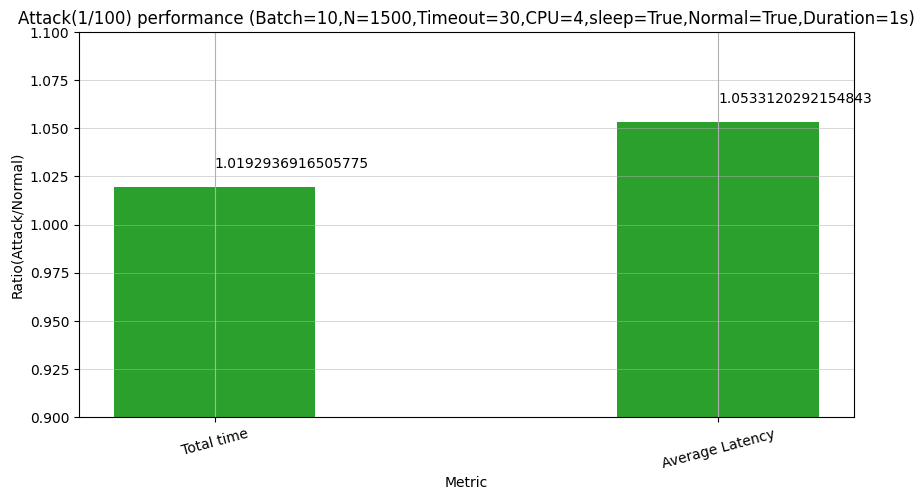

In [190]:
def NoAttack():
    Clear()
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 601.552875,"avg latency": 129.705493,"cumulative": 194558,"hmean": 50,"avg": 129,"p50": 127,"p75": 209,"p95": 252,"p99": 254,"p999": 256,"Long5": 253,"Short5": 11,"MaxM": 256,"MinM": 5,"RangM": 251,"StdDevM": 84,"RateSec": 7.709773700769294,"HistogramM":""" &[map[5.044ms - 30.169ms:294] map[30.169ms - 55.294ms:116] map[55.294ms - 80.418ms:110] map[80.418ms - 105.543ms:120] map[105.543ms - 130.668ms:130] map[130.668ms - 155.793ms:110] map[155.793ms - 180.917ms:100] map[180.917ms - 206.042ms:119] map[206.042ms - 231.167ms:142] map[231.167ms - 256.292ms:259]]""","HistogramBinSize": 25.124744,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 152,"avg batch size": 9.789473684210526,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 11,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 610.851709,"avg latency": 137.067851,"cumulative": 205601,"hmean": 55,"avg": 137,"p50": 139,"p75": 213,"p95": 256,"p99": 260,"p999": 263,"Long5": 258,"Short5": 11,"MaxM": 263,"MinM": 5,"RangM": 258,"StdDevM": 84,"RateSec": 7.2956567982797385,"HistogramM":""" &[map[5.192ms - 31.017ms:253] map[31.017ms - 56.842ms:107] map[56.842ms - 82.667ms:110] map[82.667ms - 108.492ms:131] map[108.492ms - 134.317ms:139] map[134.317ms - 160.142ms:109] map[160.142ms - 185.967ms:114] map[185.967ms - 211.791ms:136] map[211.791ms - 237.616ms:151] map[237.616ms - 263.441ms:250]]""","HistogramBinSize": 25.824932,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 155,"avg batch size": 9.606451612903227,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 11,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 613.312334,"avg latency": 137.187647,"cumulative": 205781,"hmean": 56,"avg": 137,"p50": 135,"p75": 219,"p95": 259,"p99": 264,"p999": 267,"Long5": 262,"Short5": 11,"MaxM": 268,"MinM": 2,"RangM": 265,"StdDevM": 85,"RateSec": 7.289285996880069,"HistogramM":""" &[map[2.929ms - 29.453ms:240] map[29.453ms - 55.976ms:127] map[55.976ms - 82.5ms:124] map[82.5ms - 109.024ms:138] map[109.024ms - 135.547ms:126] map[135.547ms - 162.071ms:95] map[162.071ms - 188.594ms:130] map[188.594ms - 215.118ms:138] map[215.118ms - 241.642ms:129] map[241.642ms - 268.165ms:253]]""","HistogramBinSize": 26.523588,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 154,"avg batch size": 9.662337662337663,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 10,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 641.061083,"avg latency": 167.688918,"cumulative": 251533,"hmean": 67,"avg": 167,"p50": 178,"p75": 253,"p95": 290,"p99": 294,"p999": 296,"Long5": 292,"Short5": 12,"MaxM": 296,"MinM": 3,"RangM": 293,"StdDevM": 93,"RateSec": 5.963423290530867,"HistogramM":""" &[map[3.09ms - 32.473ms:224] map[32.473ms - 61.856ms:65] map[61.856ms - 91.238ms:98] map[91.238ms - 120.621ms:112] map[120.621ms - 150.004ms:119] map[150.004ms - 179.387ms:134] map[179.387ms - 208.769ms:143] map[208.769ms - 238.152ms:144] map[238.152ms - 267.535ms:167] map[267.535ms - 296.917ms:294]]""","HistogramBinSize": 29.382723,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 152,"avg batch size": 9.769736842105264,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 11,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 609.966958,"avg latency": 141.670413,"cumulative": 212505,"hmean": 60,"avg": 141,"p50": 147,"p75": 223,"p95": 256,"p99": 261,"p999": 264,"Long5": 259,"Short5": 12,"MaxM": 265,"MinM": 4,"RangM": 261,"StdDevM": 84,"RateSec": 7.058636826707191,"HistogramM":""" &[map[4.005ms - 30.135ms:228] map[30.135ms - 56.265ms:92] map[56.265ms - 82.395ms:150] map[82.395ms - 108.525ms:110] map[108.525ms - 134.655ms:120] map[134.655ms - 160.785ms:120] map[160.785ms - 186.915ms:119] map[186.915ms - 213.045ms:121] map[213.045ms - 239.175ms:166] map[239.175ms - 265.305ms:274]]""","HistogramBinSize": 26.130029,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 156,"avg batch size": 9.544871794871796,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 10,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 606.501541,"avg latency": 136.964983,"cumulative": 205647,"hmean": 52,"avg": 137,"p50": 138,"p75": 223,"p95": 263,"p99": 267,"p999": 271,"Long5": 266,"Short5": 11,"MaxM": 271,"MinM": 4,"RangM": 267,"StdDevM": 87,"RateSec": 7.294017477725271,"HistogramM":""" &[map[4.048ms - 30.809ms:273] map[30.809ms - 57.57ms:127] map[57.57ms - 84.332ms:115] map[84.332ms - 111.093ms:115] map[111.093ms - 137.854ms:117] map[137.854ms - 164.615ms:113] map[164.615ms - 191.376ms:123] map[191.376ms - 218.138ms:137] map[218.138ms - 244.899ms:134] map[244.899ms - 271.66ms:246]]""","HistogramBinSize": 26.761212,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 155,"avg batch size": 9.612903225806452,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 11,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 610.022542,"avg latency": 139.174487,"cumulative": 208761,"hmean": 54,"avg": 139,"p50": 145,"p75": 221,"p95": 256,"p99": 260,"p999": 262,"Long5": 259,"Short5": 11,"MaxM": 262,"MinM": 4,"RangM": 258,"StdDevM": 85,"RateSec": 7.185224930636553,"HistogramM":""" &[map[4.511ms - 30.34ms:266] map[30.34ms - 56.17ms:93] map[56.17ms - 81.999ms:111] map[81.999ms - 107.828ms:120] map[107.828ms - 133.658ms:118] map[133.658ms - 159.487ms:118] map[159.487ms - 185.316ms:110] map[185.316ms - 211.145ms:127] map[211.145ms - 236.975ms:162] map[236.975ms - 262.804ms:275]]""","HistogramBinSize": 25.829316,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 154,"avg batch size": 9.668831168831169,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 9,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 596.416375,"avg latency": 129.390286,"cumulative": 194085,"hmean": 51,"avg": 129,"p50": 132,"p75": 208,"p95": 248,"p99": 252,"p999": 254,"Long5": 251,"Short5": 11,"MaxM": 254,"MinM": 4,"RangM": 250,"StdDevM": 82,"RateSec": 7.728555444257056,"HistogramM":""" &[map[4.078ms - 29.135ms:267] map[29.135ms - 54.192ms:123] map[54.192ms - 79.249ms:139] map[79.249ms - 104.306ms:110] map[104.306ms - 129.363ms:107] map[129.363ms - 154.419ms:120] map[154.419ms - 179.476ms:103] map[179.476ms - 204.533ms:138] map[204.533ms - 229.59ms:141] map[229.59ms - 254.647ms:252]]""","HistogramBinSize": 25.056885,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 154,"avg batch size": 9.668831168831169,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 10,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 628.40025,"avg latency": 150.363443,"cumulative": 225545,"hmean": 58,"avg": 150,"p50": 156,"p75": 231,"p95": 273,"p99": 276,"p999": 279,"Long5": 275,"Short5": 11,"MaxM": 279,"MinM": 3,"RangM": 276,"StdDevM": 88,"RateSec": 6.65055267291341,"HistogramM":""" &[map[3.216ms - 30.875ms:237] map[30.875ms - 58.533ms:93] map[58.533ms - 86.192ms:91] map[86.192ms - 113.851ms:128] map[113.851ms - 141.51ms:137] map[141.51ms - 169.169ms:124] map[169.169ms - 196.828ms:131] map[196.828ms - 224.487ms:148] map[224.487ms - 252.146ms:151] map[252.146ms - 279.805ms:260]]""","HistogramBinSize": 27.658924,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 155,"avg batch size": 9.6,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 12,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 654.2865,"avg latency": 176.34845,"cumulative": 264638,"hmean": 71,"avg": 176,"p50": 187,"p75": 263,"p95": 301,"p99": 305,"p999": 308,"Long5": 304,"Short5": 12,"MaxM": 308,"MinM": 4,"RangM": 304,"StdDevM": 94,"RateSec": 5.668106902978957,"HistogramM":""" &[map[4.36ms - 34.773ms:210] map[34.773ms - 65.186ms:55] map[65.186ms - 95.598ms:75] map[95.598ms - 126.011ms:144] map[126.011ms - 156.424ms:121] map[156.424ms - 186.836ms:133] map[186.836ms - 217.249ms:142] map[217.249ms - 247.662ms:160] map[247.662ms - 278.074ms:175] map[278.074ms - 308.487ms:285]]""","HistogramBinSize": 30.41265,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 153,"avg batch size": 9.732026143790849,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 8,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 641.314584,"avg latency": 160.953738,"cumulative": 242208,"hmean": 59,"avg": 161,"p50": 173,"p75": 249,"p95": 289,"p99": 293,"p999": 295,"Long5": 292,"Short5": 11,"MaxM": 296,"MinM": 4,"RangM": 291,"StdDevM": 95,"RateSec": 6.193020747559311,"HistogramM":""" &[map[4.523ms - 33.679ms:266] map[33.679ms - 62.834ms:84] map[62.834ms - 91.99ms:70] map[91.99ms - 121.145ms:130] map[121.145ms - 150.301ms:110] map[150.301ms - 179.456ms:114] map[179.456ms - 208.612ms:144] map[208.612ms - 237.767ms:131] map[237.767ms - 266.923ms:165] map[266.923ms - 296.078ms:286]]""","HistogramBinSize": 29.155494,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 154,"avg batch size": 9.655844155844155,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 12,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 625.214458,"avg latency": 148.994566,"cumulative": 223491,"hmean": 56,"avg": 148,"p50": 153,"p75": 233,"p95": 275,"p99": 279,"p999": 281,"Long5": 277,"Short5": 11,"MaxM": 281,"MinM": 4,"RangM": 277,"StdDevM": 90,"RateSec": 6.7116541583787885,"HistogramM":""" &[map[4.771ms - 32.473ms:254] map[32.473ms - 60.176ms:113] map[60.176ms - 87.878ms:86] map[87.878ms - 115.58ms:126] map[115.58ms - 143.282ms:114] map[143.282ms - 170.984ms:133] map[170.984ms - 198.686ms:125] map[198.686ms - 226.388ms:142] map[226.388ms - 254.091ms:135] map[254.091ms - 281.793ms:272]]""","HistogramBinSize": 27.702158,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 154,"avg batch size": 9.662337662337663,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 12,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 635.3585,"avg latency": 152.703002,"cumulative": 229054,"hmean": 57,"avg": 152,"p50": 160,"p75": 239,"p95": 280,"p99": 282,"p999": 282,"Long5": 281,"Short5": 11,"MaxM": 283,"MinM": 4,"RangM": 278,"StdDevM": 92,"RateSec": 6.548659718876465,"HistogramM":""" &[map[4.668ms - 32.531ms:269] map[32.531ms - 60.394ms:75] map[60.394ms - 88.257ms:87] map[88.257ms - 116.121ms:139] map[116.121ms - 143.984ms:110] map[143.984ms - 171.847ms:130] map[171.847ms - 199.71ms:115] map[199.71ms - 227.574ms:135] map[227.574ms - 255.437ms:149] map[255.437ms - 283.3ms:291]]""","HistogramBinSize": 27.863282,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 154,"avg batch size": 9.668831168831169,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 10,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 616.429708,"avg latency": 144.82568,"cumulative": 217238,"hmean": 58,"avg": 144,"p50": 150,"p75": 230,"p95": 264,"p99": 267,"p999": 270,"Long5": 266,"Short5": 11,"MaxM": 270,"MinM": 2,"RangM": 267,"StdDevM": 86,"RateSec": 6.904852757075117,"HistogramM":""" &[map[2.909ms - 29.648ms:247] map[29.648ms - 56.388ms:92] map[56.388ms - 83.127ms:111] map[83.127ms - 109.866ms:120] map[109.866ms - 136.605ms:110] map[136.605ms - 163.344ms:127] map[163.344ms - 190.084ms:123] map[190.084ms - 216.823ms:139] map[216.823ms - 243.562ms:147] map[243.562ms - 270.301ms:284]]""","HistogramBinSize": 26.73922,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 153,"avg batch size": 9.718954248366012,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 12,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 618.970458,"avg latency": 146.77864,"cumulative": 220167,"hmean": 58,"avg": 146,"p50": 150,"p75": 232,"p95": 271,"p99": 277,"p999": 278,"Long5": 275,"Short5": 11,"MaxM": 278,"MinM": 2,"RangM": 275,"StdDevM": 89,"RateSec": 6.81298039240383,"HistogramM":""" &[map[2.977ms - 30.56ms:253] map[30.56ms - 58.143ms:97] map[58.143ms - 85.727ms:120] map[85.727ms - 113.31ms:124] map[113.31ms - 140.893ms:116] map[140.893ms - 168.476ms:114] map[168.476ms - 196.06ms:126] map[196.06ms - 223.643ms:121] map[223.643ms - 251.226ms:165] map[251.226ms - 278.81ms:264]]""","HistogramBinSize": 27.583271,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 154,"avg batch size": 9.662337662337663,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 12,})

def Attack():
    Clear()
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 630.156583,"avg latency": 148.423886,"cumulative": 222635,"hmean": 56,"avg": 148,"p50": 153,"p75": 234,"p95": 278,"p99": 284,"p999": 287,"Long5": 282,"Short5": 11,"MaxM": 287,"MinM": 3,"RangM": 284,"StdDevM": 91,"RateSec": 6.7374600151297965,"HistogramM":""" &[map[3.147ms - 31.549ms:259] map[31.549ms - 59.951ms:109] map[59.951ms - 88.352ms:92] map[88.352ms - 116.754ms:130] map[116.754ms - 145.156ms:134] map[145.156ms - 173.558ms:126] map[173.558ms - 201.96ms:120] map[201.96ms - 230.362ms:136] map[230.362ms - 258.764ms:152] map[258.764ms - 287.166ms:242]]""","HistogramBinSize": 28.401884,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 154,"avg batch size": 9.668831168831169,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 14,"failed requests": 140,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 10,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 636.625458,"avg latency": 159.427512,"cumulative": 239309,"hmean": 67,"avg": 159,"p50": 163,"p75": 245,"p95": 286,"p99": 290,"p999": 292,"Long5": 288,"Short5": 12,"MaxM": 292,"MinM": 4,"RangM": 288,"StdDevM": 91,"RateSec": 6.268029914582763,"HistogramM":""" &[map[4.325ms - 33.138ms:213] map[33.138ms - 61.95ms:79] map[61.95ms - 90.763ms:111] map[90.763ms - 119.576ms:122] map[119.576ms - 148.388ms:154] map[148.388ms - 177.201ms:138] map[177.201ms - 206.014ms:128] map[206.014ms - 234.826ms:117] map[234.826ms - 263.639ms:166] map[263.639ms - 292.452ms:272]]""","HistogramBinSize": 28.812647,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 155,"avg batch size": 9.606451612903227,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 15,"failed requests": 150,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 11,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 641.451875,"avg latency": 164.285227,"cumulative": 246702,"hmean": 68,"avg": 164,"p50": 175,"p75": 250,"p95": 290,"p99": 294,"p999": 296,"Long5": 292,"Short5": 13,"MaxM": 297,"MinM": 3,"RangM": 294,"StdDevM": 93,"RateSec": 6.080208083268,"HistogramM":""" &[map[3.143ms - 32.606ms:209] map[32.606ms - 62.069ms:89] map[62.069ms - 91.532ms:100] map[91.532ms - 120.996ms:122] map[120.996ms - 150.459ms:126] map[150.459ms - 179.922ms:127] map[179.922ms - 209.385ms:151] map[209.385ms - 238.848ms:136] map[238.848ms - 268.311ms:157] map[268.311ms - 297.774ms:283]]""","HistogramBinSize": 29.463089,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 152,"avg batch size": 9.776315789473685,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 14,"failed requests": 135,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 12,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 638.878959,"avg latency": 154.922826,"cumulative": 232396,"hmean": 54,"avg": 154,"p50": 159,"p75": 249,"p95": 289,"p99": 293,"p999": 298,"Long5": 291,"Short5": 10,"MaxM": 299,"MinM": 3,"RangM": 295,"StdDevM": 96,"RateSec": 6.454478306768299,"HistogramM":""" &[map[3.113ms - 32.706ms:287] map[32.706ms - 62.299ms:91] map[62.299ms - 91.892ms:112] map[91.892ms - 121.485ms:100] map[121.485ms - 151.079ms:127] map[151.079ms - 180.672ms:118] map[180.672ms - 210.265ms:122] map[210.265ms - 239.858ms:120] map[239.858ms - 269.451ms:164] map[269.451ms - 299.044ms:259]]""","HistogramBinSize": 29.593159,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 155,"avg batch size": 9.606451612903227,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 13,"failed requests": 130,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 11,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 660.234666,"avg latency": 179.087994,"cumulative": 268631,"hmean": 69,"avg": 179,"p50": 191,"p75": 265,"p95": 310,"p99": 313,"p999": 316,"Long5": 312,"Short5": 12,"MaxM": 317,"MinM": 2,"RangM": 314,"StdDevM": 98,"RateSec": 5.583847211098766,"HistogramM":""" &[map[2.919ms - 34.328ms:243] map[34.328ms - 65.737ms:17] map[65.737ms - 97.145ms:69] map[97.145ms - 128.554ms:149] map[128.554ms - 159.963ms:129] map[159.963ms - 191.372ms:143] map[191.372ms - 222.78ms:152] map[222.78ms - 254.189ms:146] map[254.189ms - 285.598ms:182] map[285.598ms - 317.006ms:270]]""","HistogramBinSize": 31.408705,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 152,"avg batch size": 9.789473684210526,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 14,"failed requests": 140,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 7,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 647.622792,"avg latency": 170.558804,"cumulative": 256092,"hmean": 64,"avg": 170,"p50": 186,"p75": 262,"p95": 298,"p99": 304,"p999": 315,"Long5": 302,"Short5": 11,"MaxM": 321,"MinM": 4,"RangM": 317,"StdDevM": 98,"RateSec": 5.857247751354057,"HistogramM":""" &[map[4.21ms - 35.931ms:252] map[35.931ms - 67.652ms:77] map[67.652ms - 99.373ms:101] map[99.373ms - 131.093ms:97] map[131.093ms - 162.814ms:126] map[162.814ms - 194.535ms:144] map[194.535ms - 226.255ms:127] map[226.255ms - 257.976ms:186] map[257.976ms - 289.697ms:209] map[289.697ms - 321.418ms:181]]""","HistogramBinSize": 31.720742,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 155,"avg batch size": 9.606451612903227,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 15,"failed requests": 145,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 12,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 662.011625,"avg latency": 172.027333,"cumulative": 258041,"hmean": 63,"avg": 172,"p50": 183,"p75": 264,"p95": 307,"p99": 313,"p999": 319,"Long5": 311,"Short5": 12,"MaxM": 321,"MinM": 3,"RangM": 318,"StdDevM": 101,"RateSec": 5.813029702870969,"HistogramM":""" &[map[3.401ms - 35.221ms:248] map[35.221ms - 67.04ms:102] map[67.04ms - 98.859ms:90] map[98.859ms - 130.679ms:72] map[130.679ms - 162.498ms:150] map[162.498ms - 194.318ms:120] map[194.318ms - 226.137ms:150] map[226.137ms - 257.957ms:159] map[257.957ms - 289.776ms:172] map[289.776ms - 321.596ms:237]]""","HistogramBinSize": 31.819441,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 154,"avg batch size": 9.655844155844155,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 14,"failed requests": 140,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 11,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 617.015167,"avg latency": 142.347951,"cumulative": 214021,"hmean": 59,"avg": 142,"p50": 146,"p75": 226,"p95": 265,"p99": 270,"p999": 278,"Long5": 269,"Short5": 12,"MaxM": 279,"MinM": 2,"RangM": 276,"StdDevM": 87,"RateSec": 7.00864724432297,"HistogramM":""" &[map[2.798ms - 30.449ms:229] map[30.449ms - 58.1ms:131] map[58.1ms - 85.75ms:120] map[85.75ms - 113.401ms:144] map[113.401ms - 141.051ms:111] map[141.051ms - 168.702ms:111] map[168.702ms - 196.353ms:127] map[196.353ms - 224.003ms:127] map[224.003ms - 251.654ms:185] map[251.654ms - 279.305ms:215]]""","HistogramBinSize": 27.650633,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 154,"avg batch size": 9.662337662337663,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 14,"failed requests": 138,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 12,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 649.449125,"avg latency": 159.482537,"cumulative": 239453,"hmean": 60,"avg": 159,"p50": 171,"p75": 247,"p95": 294,"p99": 303,"p999": 309,"Long5": 300,"Short5": 12,"MaxM": 319,"MinM": 4,"RangM": 315,"StdDevM": 98,"RateSec": 6.26425288145288,"HistogramM":""" &[map[4.07ms - 35.659ms:262] map[35.659ms - 67.248ms:141] map[67.248ms - 98.836ms:99] map[98.836ms - 130.425ms:83] map[130.425ms - 162.014ms:129] map[162.014ms - 193.603ms:126] map[193.603ms - 225.192ms:162] map[225.192ms - 256.781ms:162] map[256.781ms - 288.369ms:176] map[288.369ms - 319.958ms:160]]""","HistogramBinSize": 31.588818,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 154,"avg batch size": 9.662337662337663,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 14,"failed requests": 137,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 11,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 617.975041,"avg latency": 147.750812,"cumulative": 221626,"hmean": 65,"avg": 147,"p50": 152,"p75": 230,"p95": 268,"p99": 271,"p999": 275,"Long5": 270,"Short5": 12,"MaxM": 275,"MinM": 4,"RangM": 271,"StdDevM": 86,"RateSec": 6.768152291141378,"HistogramM":""" &[map[4.918ms - 32.02ms:195] map[32.02ms - 59.123ms:154] map[59.123ms - 86.225ms:107] map[86.225ms - 113.328ms:123] map[113.328ms - 140.431ms:119] map[140.431ms - 167.533ms:120] map[167.533ms - 194.636ms:115] map[194.636ms - 221.738ms:137] map[221.738ms - 248.841ms:163] map[248.841ms - 275.944ms:267]]""","HistogramBinSize": 27.10262,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 155,"avg batch size": 9.6,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 14,"failed requests": 138,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 12,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 602.979166,"avg latency": 136.151249,"cumulative": 204252,"hmean": 52,"avg": 136,"p50": 138,"p75": 217,"p95": 256,"p99": 261,"p999": 266,"Long5": 260,"Short5": 11,"MaxM": 267,"MinM": 3,"RangM": 263,"StdDevM": 85,"RateSec": 7.3438621654835385,"HistogramM":""" &[map[3.51ms - 29.9ms:265] map[29.9ms - 56.29ms:115] map[56.29ms - 82.681ms:133] map[82.681ms - 109.071ms:108] map[109.071ms - 135.462ms:106] map[135.462ms - 161.852ms:117] map[161.852ms - 188.243ms:138] map[188.243ms - 214.633ms:118] map[214.633ms - 241.023ms:159] map[241.023ms - 267.414ms:241]]""","HistogramBinSize": 26.390431,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 154,"avg batch size": 9.662337662337663,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 14,"failed requests": 139,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 12,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 620.323833,"avg latency": 143.848903,"cumulative": 215794,"hmean": 57,"avg": 143,"p50": 145,"p75": 227,"p95": 269,"p99": 274,"p999": 276,"Long5": 272,"Short5": 11,"MaxM": 276,"MinM": 4,"RangM": 272,"StdDevM": 88,"RateSec": 6.951067979581148,"HistogramM":""" &[map[4.479ms - 31.719ms:276] map[31.719ms - 58.96ms:84] map[58.96ms - 86.2ms:115] map[86.2ms - 113.441ms:120] map[113.441ms - 140.681ms:135] map[140.681ms - 167.922ms:127] map[167.922ms - 195.162ms:99] map[195.162ms - 222.403ms:148] map[222.403ms - 249.643ms:130] map[249.643ms - 276.883ms:266]]""","HistogramBinSize": 27.24045,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 154,"avg batch size": 9.662337662337663,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 15,"failed requests": 150,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 11,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 624.157625,"avg latency": 150.510835,"cumulative": 226005,"hmean": 63,"avg": 150,"p50": 156,"p75": 233,"p95": 271,"p99": 275,"p999": 279,"Long5": 274,"Short5": 12,"MaxM": 280,"MinM": 6,"RangM": 273,"StdDevM": 87,"RateSec": 6.637014453975837,"HistogramM":""" &[map[6.63ms - 33.993ms:234] map[33.993ms - 61.355ms:86] map[61.355ms - 88.718ms:110] map[88.718ms - 116.081ms:136] map[116.081ms - 143.444ms:124] map[143.444ms - 170.807ms:141] map[170.807ms - 198.169ms:115] map[198.169ms - 225.532ms:146] map[225.532ms - 252.895ms:154] map[252.895ms - 280.258ms:254]]""","HistogramBinSize": 27.362829,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 154,"avg batch size": 9.668831168831169,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 14,"failed requests": 140,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 11,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 617.163209,"avg latency": 138.914753,"cumulative": 208372,"hmean": 55,"avg": 138,"p50": 142,"p75": 218,"p95": 261,"p99": 268,"p999": 274,"Long5": 265,"Short5": 11,"MaxM": 275,"MinM": 4,"RangM": 271,"StdDevM": 85,"RateSec": 7.198659411660174,"HistogramM":""" &[map[4.234ms - 31.338ms:265] map[31.338ms - 58.441ms:110] map[58.441ms - 85.544ms:125] map[85.544ms - 112.647ms:115] map[112.647ms - 139.75ms:123] map[139.75ms - 166.854ms:125] map[166.854ms - 193.957ms:131] map[193.957ms - 221.06ms:135] map[221.06ms - 248.163ms:159] map[248.163ms - 275.266ms:212]]""","HistogramBinSize": 27.103199,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 155,"avg batch size": 9.606451612903227,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 15,"failed requests": 150,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 11,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True, v = {"total time": 623.232458,"avg latency": 149.353715,"cumulative": 224464,"hmean": 61,"avg": 149,"p50": 154,"p75": 237,"p95": 271,"p99": 275,"p999": 276,"Long5": 273,"Short5": 12,"MaxM": 276,"MinM": 3,"RangM": 273,"StdDevM": 89,"RateSec": 6.682576227513819,"HistogramM":""" &[map[3.871ms - 31.18ms:251] map[31.18ms - 58.488ms:90] map[58.488ms - 85.796ms:99] map[85.796ms - 113.104ms:108] map[113.104ms - 140.413ms:131] map[140.413ms - 167.721ms:125] map[167.721ms - 195.029ms:137] map[195.029ms - 222.337ms:116] map[222.337ms - 249.645ms:143] map[249.645ms - 276.954ms:300]]""","HistogramBinSize": 27.308216,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 154,"avg batch size": 9.662337662337663,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 14,"failed requests": 133,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 11,})


NoAttack()
x = {}
total_1 = {}
avg_1 = {}


x = {e[N_ENTRY]:GetElementFromEntry(e)['total time'] for e in FindKeys()}
total_1 = x[1500]
x = {e[N_ENTRY]:GetElementFromEntry(e)['avg latency'] for e in FindKeys()}
avg_1 = x[1500]


Attack()
x = {}
total_2 = {}
avg_2  = {}


x = {e[N_ENTRY]:GetElementFromEntry(e)['total time'] for e in FindKeys()}
total_2 = x[1500]
x = {e[N_ENTRY]:GetElementFromEntry(e)['avg latency'] for e in FindKeys()}
avg_2 = x[1500]

print(total_2,total_1)

bar_plot(['Total time','Average Latency'],[total_2/total_1,avg_2/avg_1],x_label='Metric',y_label='Ratio(Attack/Normal)',rotation=True,title="Attack(1/100) performance (Batch=10,N=1500,Timeout=30,CPU=4,sleep=True,Normal=True,Duration=1s)",horizontal_grid_only=True,file_path='attack1_100.png',width=0.4,fig_size=(10,5),y_lim = [0.9,1.1],y_text = True)


# bar_plot(['Fixed','Adjusted'],[total_1,total_2],x_label='Timeout type',y_label='Total time(ms)',title="Total time(ms) by timeout type (Batch=10,N=500,Timeout=30,CPU=4,sleep=True,Normal=True,Duration=1s)",horizontal_grid_only=True,file_path='total_time_adjuted_timeout.png',width=0.4,fig_size=(10,5))
# bar_plot(['Fixed','Adjusted'],[avg_1,avg_2],x_label='Timeout type',y_label='Average Latency(ms)',title="Average Latency(ms) by timeout type (Batch=10,N=500,Timeout=30,CPU=4,sleep=True,Normal=True,Duration=1s)",horizontal_grid_only=True,file_path='avg_lat_adjuted_timeout.png',width=0.4,fig_size=(10,5))


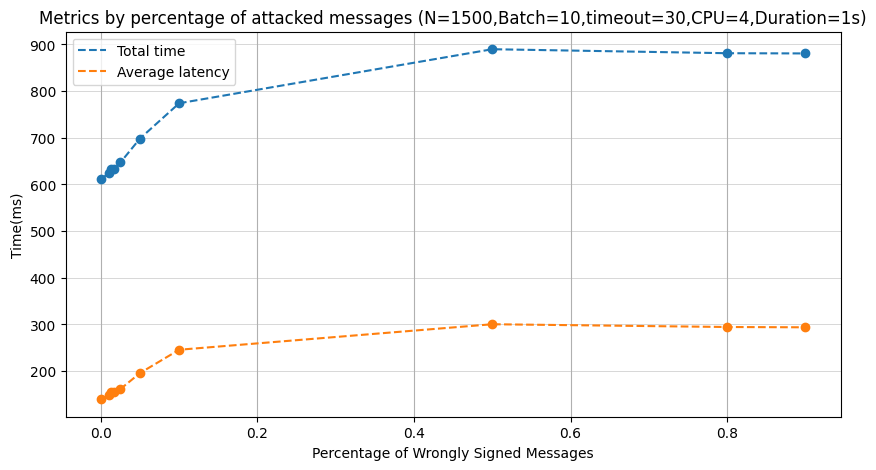

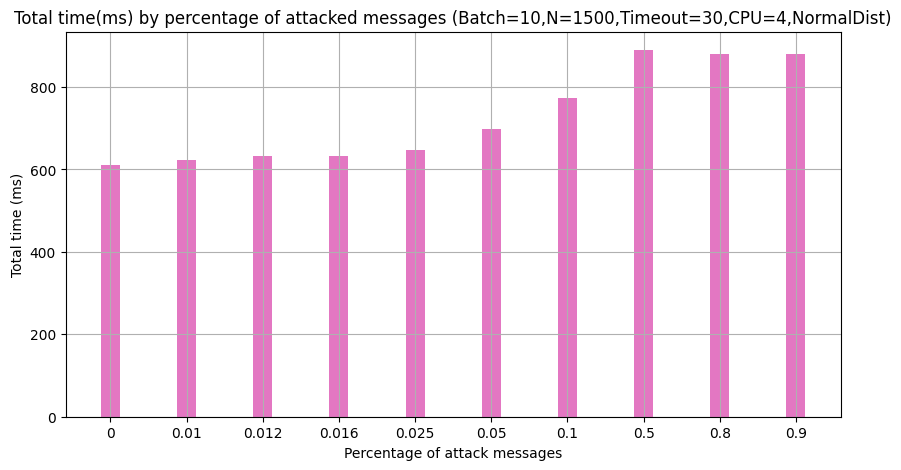

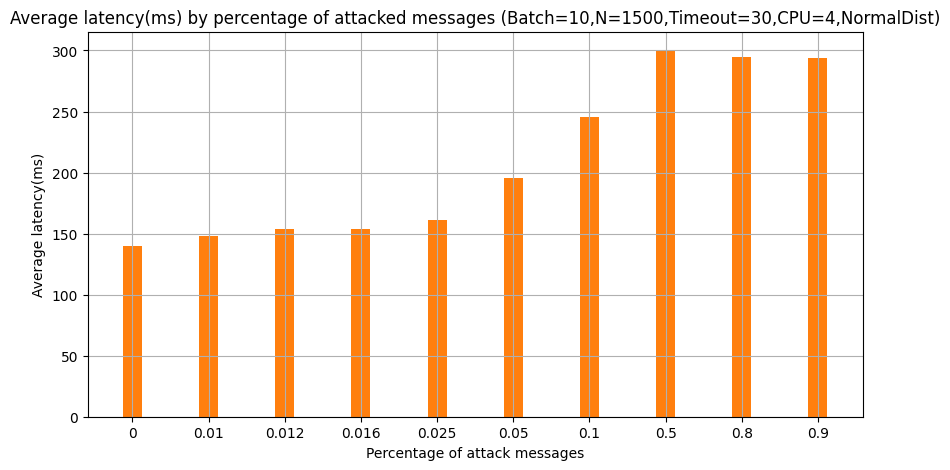

In [223]:
Clear()

def SetAttack100():
    Clear()
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=100, v = {"total time": 636.062083,"avg latency": 156.745272,"cumulative": 235226,"hmean": 63,"avg": 156,"p50": 163,"p75": 244,"p95": 282,"p99": 287,"p999": 292,"Long5": 286,"Short5": 11,"MaxM": 292,"MinM": 4,"RangM": 288,"StdDevM": 91,"RateSec": 6.37682323015675,"HistogramM":""" &[map[4.467ms - 33.291ms:233] map[33.291ms - 62.115ms:82] map[62.115ms - 90.939ms:125] map[90.939ms - 119.763ms:130] map[119.763ms - 148.587ms:128] map[148.587ms - 177.412ms:113] map[177.412ms - 206.236ms:137] map[206.236ms - 235.06ms:139] map[235.06ms - 263.884ms:178] map[263.884ms - 292.708ms:235]]""","HistogramBinSize": 28.824082,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 155,"avg batch size": 9.593548387096774,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 14,"failed requests": 140,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 13,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=100, v = {"total time": 628.802,"avg latency": 151.82409,"cumulative": 228009,"hmean": 63,"avg": 152,"p50": 157,"p75": 237,"p95": 273,"p99": 277,"p999": 295,"Long5": 277,"Short5": 12,"MaxM": 302,"MinM": 5,"RangM": 296,"StdDevM": 88,"RateSec": 6.578671850845118,"HistogramM":""" &[map[5.383ms - 35.08ms:228] map[35.08ms - 64.777ms:143] map[64.777ms - 94.474ms:91] map[94.474ms - 124.17ms:129] map[124.17ms - 153.867ms:148] map[153.867ms - 183.564ms:141] map[183.564ms - 213.261ms:141] map[213.261ms - 242.958ms:140] map[242.958ms - 272.655ms:240] map[272.655ms - 302.352ms:99]]""","HistogramBinSize": 29.696843,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 155,"avg batch size": 9.606451612903227,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 15,"failed requests": 142,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 11,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=100, v = {"total time": 615.289709,"avg latency": 139.809966,"cumulative": 209714,"hmean": 57,"avg": 139,"p50": 142,"p75": 223,"p95": 258,"p99": 262,"p999": 264,"Long5": 261,"Short5": 12,"MaxM": 265,"MinM": 3,"RangM": 261,"StdDevM": 85,"RateSec": 7.1525659087785245,"HistogramM":""" &[map[3.399ms - 29.578ms:255] map[29.578ms - 55.756ms:88] map[55.756ms - 81.935ms:127] map[81.935ms - 108.114ms:119] map[108.114ms - 134.292ms:124] map[134.292ms - 160.471ms:129] map[160.471ms - 186.649ms:106] map[186.649ms - 212.828ms:144] map[212.828ms - 239.007ms:120] map[239.007ms - 265.185ms:288]]""","HistogramBinSize": 26.178597,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 154,"avg batch size": 9.668831168831169,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 15,"failed requests": 149,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 9,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=100, v = {"total time": 617,"avg latency": 147.601809,"cumulative": 221418,"hmean": 57,"avg": 147,"p50": 153,"p75": 231,"p95": 272,"p99": 277,"p999": 280,"Long5": 275,"Short5": 11,"MaxM": 280,"MinM": 6,"RangM": 274,"StdDevM": 89,"RateSec": 6.774500204255131,"HistogramM":""" &[map[6.175ms - 33.609ms:284] map[33.609ms - 61.043ms:75] map[61.043ms - 88.477ms:109] map[88.477ms - 115.911ms:122] map[115.911ms - 143.345ms:110] map[143.345ms - 170.779ms:130] map[170.779ms - 198.213ms:126] map[198.213ms - 225.647ms:144] map[225.647ms - 253.081ms:139] map[253.081ms - 280.515ms:261]]""","HistogramBinSize": 27.433971,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 155,"avg batch size": 9.606451612903227,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 15,"failed requests": 149,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 13,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=100, v = {"total time": 609.866833,"avg latency": 139.542307,"cumulative": 209342,"hmean": 59,"avg": 139,"p50": 141,"p75": 221,"p95": 263,"p99": 268,"p999": 271,"Long5": 266,"Short5": 12,"MaxM": 271,"MinM": 2,"RangM": 268,"StdDevM": 85,"RateSec": 7.165305270895576,"HistogramM":""" &[map[2.911ms - 29.796ms:215] map[29.796ms - 56.68ms:168] map[56.68ms - 83.565ms:112] map[83.565ms - 110.45ms:125] map[110.45ms - 137.334ms:119] map[137.334ms - 164.219ms:111] map[164.219ms - 191.104ms:125] map[191.104ms - 217.988ms:145] map[217.988ms - 244.873ms:126] map[244.873ms - 271.758ms:254]]""","HistogramBinSize": 26.884678,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 153,"avg batch size": 9.718954248366012,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 14,"failed requests": 140,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 11,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=100, v = {"total time": 628.724625,"avg latency": 151.152282,"cumulative": 226743,"hmean": 66,"avg": 151,"p50": 154,"p75": 238,"p95": 273,"p99": 277,"p999": 280,"Long5": 276,"Short5": 13,"MaxM": 282,"MinM": 3,"RangM": 279,"StdDevM": 87,"RateSec": 6.6153966547965535,"HistogramM":""" &[map[3.272ms - 31.236ms:188] map[31.236ms - 59.2ms:114] map[59.2ms - 87.164ms:153] map[87.164ms - 115.128ms:118] map[115.128ms - 143.091ms:125] map[143.091ms - 171.055ms:138] map[171.055ms - 199.019ms:124] map[199.019ms - 226.983ms:125] map[226.983ms - 254.947ms:165] map[254.947ms - 282.911ms:250]]""","HistogramBinSize": 27.963882,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 154,"avg batch size": 9.662337662337663,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 15,"failed requests": 150,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 9,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=100, v = {"total time": 652.259042,"avg latency": 167.865653,"cumulative": 251798,"hmean": 62,"avg": 167,"p50": 175,"p75": 261,"p95": 299,"p99": 305,"p999": 309,"Long5": 302,"Short5": 12,"MaxM": 309,"MinM": 5,"RangM": 303,"StdDevM": 99,"RateSec": 5.957144758426369,"HistogramM":""" &[map[5.983ms - 36.378ms:271] map[36.378ms - 66.774ms:79] map[66.774ms - 97.169ms:63] map[97.169ms - 127.565ms:119] map[127.565ms - 157.96ms:165] map[157.96ms - 188.356ms:111] map[188.356ms - 218.751ms:129] map[218.751ms - 249.147ms:117] map[249.147ms - 279.542ms:171] map[279.542ms - 309.937ms:275]]""","HistogramBinSize": 30.395436,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 155,"avg batch size": 9.606451612903227,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 14,"failed requests": 140,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 11,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=100, v = {"total time": 624.793667,"avg latency": 146.692267,"cumulative": 220038,"hmean": 57,"avg": 146,"p50": 154,"p75": 228,"p95": 273,"p99": 278,"p999": 283,"Long5": 276,"Short5": 11,"MaxM": 283,"MinM": 4,"RangM": 279,"StdDevM": 89,"RateSec": 6.816991886498392,"HistogramM":""" &[map[4.48ms - 32.393ms:277] map[32.393ms - 60.305ms:96] map[60.305ms - 88.217ms:108] map[88.217ms - 116.13ms:114] map[116.13ms - 144.042ms:112] map[144.042ms - 171.954ms:130] map[171.954ms - 199.867ms:130] map[199.867ms - 227.779ms:155] map[227.779ms - 255.691ms:149] map[255.691ms - 283.604ms:229]]""","HistogramBinSize": 27.912336,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 156,"avg batch size": 9.551282051282051,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 15,"failed requests": 150,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 12,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=100, v = {"total time": 620.920875,"avg latency": 144.282074,"cumulative": 216442,"hmean": 59,"avg": 144,"p50": 145,"p75": 226,"p95": 272,"p99": 275,"p999": 279,"Long5": 275,"Short5": 12,"MaxM": 282,"MinM": 3,"RangM": 278,"StdDevM": 89,"RateSec": 6.9302513542570185,"HistogramM":""" &[map[3.517ms - 31.384ms:240] map[31.384ms - 59.252ms:140] map[59.252ms - 87.119ms:104] map[87.119ms - 114.987ms:136] map[114.987ms - 142.854ms:109] map[142.854ms - 170.722ms:131] map[170.722ms - 198.59ms:123] map[198.59ms - 226.457ms:138] map[226.457ms - 254.325ms:149] map[254.325ms - 282.192ms:230]]""","HistogramBinSize": 27.867544,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 153,"avg batch size": 9.718954248366012,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 15,"failed requests": 150,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 10,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=100, v = {"total time": 606.847542,"avg latency": 133.625326,"cumulative": 200437,"hmean": 53,"avg": 133,"p50": 136,"p75": 213,"p95": 253,"p99": 259,"p999": 263,"Long5": 257,"Short5": 10,"MaxM": 263,"MinM": 2,"RangM": 260,"StdDevM": 84,"RateSec": 7.4836112554283005,"HistogramM":""" &[map[2.936ms - 29.016ms:276] map[29.016ms - 55.096ms:114] map[55.096ms - 81.177ms:120] map[81.177ms - 107.257ms:114] map[107.257ms - 133.337ms:116] map[133.337ms - 159.418ms:115] map[159.418ms - 185.498ms:121] map[185.498ms - 211.578ms:127] map[211.578ms - 237.659ms:163] map[237.659ms - 263.739ms:234]]""","HistogramBinSize": 26.080365,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 153,"avg batch size": 9.718954248366012,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 15,"failed requests": 150,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 11,})

def SetAttack80():
    Clear()
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=80, v = {"total time": 642.834417,"avg latency": 156.067109,"cumulative": 234100,"hmean": 62,"avg": 156,"p50": 162,"p75": 247,"p95": 292,"p99": 298,"p999": 299,"Long5": 296,"Short5": 12,"MaxM": 299,"MinM": 6,"RangM": 292,"StdDevM": 95,"RateSec": 6.4074999589771355,"HistogramM":""" &[map[6.984ms - 36.264ms:261] map[36.264ms - 65.545ms:111] map[65.545ms - 94.825ms:114] map[94.825ms - 124.106ms:104] map[124.106ms - 153.386ms:134] map[153.386ms - 182.666ms:111] map[182.666ms - 211.947ms:153] map[211.947ms - 241.227ms:98] map[241.227ms - 270.507ms:185] map[270.507ms - 299.788ms:229]]""","HistogramBinSize": 29.280382,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 154,"avg batch size": 9.675324675324676,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 19,"failed requests": 190,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 10,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=80, v = {"total time": 653.880041,"avg latency": 170.873251,"cumulative": 256309,"hmean": 64,"avg": 170,"p50": 178,"p75": 265,"p95": 303,"p99": 308,"p999": 311,"Long5": 307,"Short5": 12,"MaxM": 313,"MinM": 5,"RangM": 308,"StdDevM": 99,"RateSec": 5.852291046113272,"HistogramM":""" &[map[5.464ms - 36.281ms:260] map[36.281ms - 67.098ms:75] map[67.098ms - 97.915ms:73] map[97.915ms - 128.732ms:116] map[128.732ms - 159.548ms:146] map[159.548ms - 190.365ms:122] map[190.365ms - 221.182ms:130] map[221.182ms - 251.999ms:146] map[251.999ms - 282.816ms:168] map[282.816ms - 313.633ms:264]]""","HistogramBinSize": 30.816862,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 154,"avg batch size": 9.668831168831169,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 18,"failed requests": 174,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 10,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=80, v = {"total time": 616.903375,"avg latency": 140.836422,"cumulative": 211707,"hmean": 57,"avg": 141,"p50": 145,"p75": 223,"p95": 260,"p99": 264,"p999": 268,"Long5": 262,"Short5": 11,"MaxM": 269,"MinM": 4,"RangM": 264,"StdDevM": 85,"RateSec": 7.085234243824109,"HistogramM":""" &[map[4.892ms - 31.333ms:232] map[31.333ms - 57.774ms:134] map[57.774ms - 84.214ms:116] map[84.214ms - 110.655ms:126] map[110.655ms - 137.096ms:107] map[137.096ms - 163.537ms:120] map[163.537ms - 189.978ms:106] map[189.978ms - 216.419ms:149] map[216.419ms - 242.859ms:157] map[242.859ms - 269.3ms:253]]""","HistogramBinSize": 26.440852,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 154,"avg batch size": 9.675324675324676,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 19,"failed requests": 190,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 8,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=80, v = {"total time": 626.938,"avg latency": 148.368166,"cumulative": 222872,"hmean": 59,"avg": 148,"p50": 151,"p75": 234,"p95": 270,"p99": 273,"p999": 276,"Long5": 272,"Short5": 12,"MaxM": 276,"MinM": 2,"RangM": 273,"StdDevM": 89,"RateSec": 6.730307329591686,"HistogramM":""" &[map[2.744ms - 30.117ms:267] map[30.117ms - 57.49ms:61] map[57.49ms - 84.862ms:92] map[84.862ms - 112.235ms:145] map[112.235ms - 139.607ms:142] map[139.607ms - 166.98ms:112] map[166.98ms - 194.352ms:102] map[194.352ms - 221.725ms:131] map[221.725ms - 249.097ms:153] map[249.097ms - 276.47ms:295]]""","HistogramBinSize": 27.372536,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 152,"avg batch size": 9.782894736842104,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 18,"failed requests": 180,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 10,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=80, v = {"total time": 625.844417,"avg latency": 148.134941,"cumulative": 222329,"hmean": 56,"avg": 148,"p50": 149,"p75": 237,"p95": 276,"p99": 279,"p999": 282,"Long5": 278,"Short5": 11,"MaxM": 283,"MinM": 5,"RangM": 277,"StdDevM": 92,"RateSec": 6.746739509650428,"HistogramM":""" &[map[5.774ms - 33.572ms:283] map[33.572ms - 61.369ms:76] map[61.369ms - 89.167ms:126] map[89.167ms - 116.965ms:106] map[116.965ms - 144.763ms:122] map[144.763ms - 172.561ms:126] map[172.561ms - 200.359ms:127] map[200.359ms - 228.157ms:123] map[228.157ms - 255.955ms:141] map[255.955ms - 283.752ms:270]]""","HistogramBinSize": 27.797874,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 154,"avg batch size": 9.668831168831169,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 17,"failed requests": 170,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 10,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=80, v = {"total time": 630.680458,"avg latency": 153.036759,"cumulative": 229630,"hmean": 61,"avg": 153,"p50": 154,"p75": 237,"p95": 284,"p99": 288,"p999": 291,"Long5": 286,"Short5": 12,"MaxM": 291,"MinM": 2,"RangM": 288,"StdDevM": 92,"RateSec": 6.532240811687075,"HistogramM":""" &[map[2.959ms - 31.842ms:227] map[31.842ms - 60.726ms:111] map[60.726ms - 89.609ms:122] map[89.609ms - 118.492ms:123] map[118.492ms - 147.375ms:129] map[147.375ms - 176.258ms:118] map[176.258ms - 205.141ms:123] map[205.141ms - 234.024ms:147] map[234.024ms - 262.907ms:161] map[262.907ms - 291.79ms:239]]""","HistogramBinSize": 28.883113,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 153,"avg batch size": 9.712418300653594,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 18,"failed requests": 180,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 12,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=80, v = {"total time": 624.9435,"avg latency": 149.361385,"cumulative": 224042,"hmean": 60,"avg": 149,"p50": 153,"p75": 233,"p95": 275,"p99": 279,"p999": 281,"Long5": 278,"Short5": 11,"MaxM": 282,"MinM": 4,"RangM": 278,"StdDevM": 89,"RateSec": 6.695170891138627,"HistogramM":""" &[map[4.465ms - 32.271ms:233] map[32.271ms - 60.076ms:115] map[60.076ms - 87.881ms:110] map[87.881ms - 115.687ms:124] map[115.687ms - 143.492ms:119] map[143.492ms - 171.297ms:141] map[171.297ms - 199.103ms:107] map[199.103ms - 226.908ms:143] map[226.908ms - 254.713ms:137] map[254.713ms - 282.519ms:271]]""","HistogramBinSize": 27.805336,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 155,"avg batch size": 9.612903225806452,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 16,"failed requests": 159,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 9,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=80, v = {"total time": 642.037833,"avg latency": 160.083139,"cumulative": 240406,"hmean": 61,"avg": 160,"p50": 172,"p75": 249,"p95": 288,"p99": 293,"p999": 299,"Long5": 291,"Short5": 11,"MaxM": 300,"MinM": 3,"RangM": 296,"StdDevM": 94,"RateSec": 6.239433659225383,"HistogramM":""" &[map[3.558ms - 33.216ms:243] map[33.216ms - 62.874ms:97] map[62.874ms - 92.531ms:90] map[92.531ms - 122.189ms:139] map[122.189ms - 151.847ms:102] map[151.847ms - 181.505ms:131] map[181.505ms - 211.162ms:134] map[211.162ms - 240.82ms:143] map[240.82ms - 270.478ms:171] map[270.478ms - 300.135ms:250]]""","HistogramBinSize": 29.657712,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 153,"avg batch size": 9.712418300653594,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 17,"failed requests": 163,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 12,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=80, v = {"total time": 637.478792,"avg latency": 156.231564,"cumulative": 234622,"hmean": 60,"avg": 156,"p50": 163,"p75": 245,"p95": 286,"p99": 290,"p999": 295,"Long5": 288,"Short5": 11,"MaxM": 295,"MinM": 3,"RangM": 292,"StdDevM": 93,"RateSec": 6.393238231430598,"HistogramM":""" &[map[3.283ms - 32.541ms:227] map[32.541ms - 61.799ms:124] map[61.799ms - 91.057ms:99] map[91.057ms - 120.315ms:130] map[120.315ms - 149.573ms:130] map[149.573ms - 178.831ms:109] map[178.831ms - 208.089ms:133] map[208.089ms - 237.347ms:141] map[237.347ms - 266.605ms:163] map[266.605ms - 295.863ms:244]]""","HistogramBinSize": 29.258013,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 156,"avg batch size": 9.532051282051283,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 19,"failed requests": 190,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 12,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=80, v = {"total time": 634.775416,"avg latency": 157.968175,"cumulative": 237133,"hmean": 66,"avg": 158,"p50": 164,"p75": 242,"p95": 286,"p99": 291,"p999": 294,"Long5": 289,"Short5": 13,"MaxM": 294,"MinM": 6,"RangM": 288,"StdDevM": 92,"RateSec": 6.325559104574398,"HistogramM":""" &[map[6.713ms - 35.527ms:238] map[35.527ms - 64.342ms:98] map[64.342ms - 93.156ms:114] map[93.156ms - 121.97ms:107] map[121.97ms - 150.785ms:137] map[150.785ms - 179.599ms:119] map[179.599ms - 208.413ms:139] map[208.413ms - 237.228ms:146] map[237.228ms - 266.042ms:141] map[266.042ms - 294.856ms:261]]""","HistogramBinSize": 28.814331,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 155,"avg batch size": 9.6,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 18,"failed requests": 180,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 13,})

def SetAttack60():
    Clear()
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=60, v = {"total time": 638.31925,"avg latency": 157.700985,"cumulative": 236583,"hmean": 62,"avg": 157,"p50": 164,"p75": 248,"p95": 286,"p99": 289,"p999": 294,"Long5": 288,"Short5": 12,"MaxM": 295,"MinM": 5,"RangM": 290,"StdDevM": 93,"RateSec": 6.340249663494417,"HistogramM":""" &[map[5.125ms - 34.189ms:260] map[34.189ms - 63.254ms:91] map[63.254ms - 92.318ms:74] map[92.318ms - 121.382ms:143] map[121.382ms - 150.446ms:121] map[150.446ms - 179.51ms:122] map[179.51ms - 208.574ms:140] map[208.574ms - 237.638ms:136] map[237.638ms - 266.702ms:146] map[266.702ms - 295.766ms:267]]""","HistogramBinSize": 29.06406,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 155,"avg batch size": 9.606451612903227,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 24,"failed requests": 227,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 11,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=60, v = {"total time": 624.041458,"avg latency": 145.692179,"cumulative": 218802,"hmean": 54,"avg": 145,"p50": 147,"p75": 232,"p95": 278,"p99": 283,"p999": 286,"Long5": 281,"Short5": 11,"MaxM": 286,"MinM": 3,"RangM": 283,"StdDevM": 93,"RateSec": 6.855506141922344,"HistogramM":""" &[map[3.376ms - 31.693ms:290] map[31.693ms - 60.01ms:112] map[60.01ms - 88.327ms:88] map[88.327ms - 116.644ms:122] map[116.644ms - 144.961ms:125] map[144.961ms - 173.278ms:114] map[173.278ms - 201.595ms:107] map[201.595ms - 229.912ms:146] map[229.912ms - 258.229ms:154] map[258.229ms - 286.546ms:242]]""","HistogramBinSize": 28.316945,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 154,"avg batch size": 9.662337662337663,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 21,"failed requests": 203,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 12,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=60, v = {"total time": 641.849375,"avg latency": 163.972745,"cumulative": 246041,"hmean": 68,"avg": 164,"p50": 171,"p75": 250,"p95": 290,"p99": 295,"p999": 299,"Long5": 293,"Short5": 12,"MaxM": 300,"MinM": 3,"RangM": 296,"StdDevM": 92,"RateSec": 6.09652369299471,"HistogramM":""" &[map[3.179ms - 32.874ms:216] map[32.874ms - 62.568ms:84] map[62.568ms - 92.263ms:97] map[92.263ms - 121.958ms:146] map[121.958ms - 151.653ms:105] map[151.653ms - 181.348ms:132] map[181.348ms - 211.043ms:146] map[211.043ms - 240.738ms:147] map[240.738ms - 270.433ms:171] map[270.433ms - 300.127ms:256]]""","HistogramBinSize": 29.694876,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 153,"avg batch size": 9.732026143790849,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 21,"failed requests": 208,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 10,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=60, v = {"total time": 631.552166,"avg latency": 152.483179,"cumulative": 228724,"hmean": 61,"avg": 152,"p50": 159,"p75": 233,"p95": 277,"p99": 282,"p999": 286,"Long5": 280,"Short5": 11,"MaxM": 287,"MinM": 3,"RangM": 283,"StdDevM": 90,"RateSec": 6.558100397791969,"HistogramM":""" &[map[3.245ms - 31.642ms:219] map[31.642ms - 60.039ms:130] map[60.039ms - 88.436ms:79] map[88.436ms - 116.833ms:122] map[116.833ms - 145.23ms:149] map[145.23ms - 173.627ms:121] map[173.627ms - 202.024ms:133] map[202.024ms - 230.421ms:142] map[230.421ms - 258.818ms:159] map[258.818ms - 287.215ms:246]]""","HistogramBinSize": 28.396963,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 155,"avg batch size": 9.593548387096774,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 22,"failed requests": 214,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 12,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=60, v = {"total time": 622.174041,"avg latency": 142.928661,"cumulative": 214738,"hmean": 57,"avg": 143,"p50": 145,"p75": 227,"p95": 269,"p99": 274,"p999": 276,"Long5": 272,"Short5": 11,"MaxM": 278,"MinM": 3,"RangM": 274,"StdDevM": 89,"RateSec": 6.985231214030634,"HistogramM":""" &[map[3.801ms - 31.275ms:246] map[31.275ms - 58.75ms:124] map[58.75ms - 86.224ms:134] map[86.224ms - 113.698ms:121] map[113.698ms - 141.172ms:108] map[141.172ms - 168.646ms:126] map[168.646ms - 196.12ms:118] map[196.12ms - 223.594ms:116] map[223.594ms - 251.068ms:157] map[251.068ms - 278.542ms:250]]""","HistogramBinSize": 27.474083,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 154,"avg batch size": 9.668831168831169,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 22,"failed requests": 220,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 9,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=60, v = {"total time": 630.491708,"avg latency": 143.936604,"cumulative": 216669,"hmean": 55,"avg": 144,"p50": 146,"p75": 231,"p95": 275,"p99": 281,"p999": 288,"Long5": 278,"Short5": 12,"MaxM": 289,"MinM": 5,"RangM": 284,"StdDevM": 91,"RateSec": 6.922999579890107,"HistogramM":""" &[map[5.088ms - 33.554ms:283] map[33.554ms - 62.019ms:107] map[62.019ms - 90.485ms:129] map[90.485ms - 118.95ms:103] map[118.95ms - 147.416ms:132] map[147.416ms - 175.881ms:115] map[175.881ms - 204.347ms:127] map[204.347ms - 232.812ms:134] map[232.812ms - 261.278ms:165] map[261.278ms - 289.743ms:205]]""","HistogramBinSize": 28.465499,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 155,"avg batch size": 9.6,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 23,"failed requests": 230,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 11,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=60, v = {"total time": 654.319042,"avg latency": 169.386739,"cumulative": 254080,"hmean": 67,"avg": 169,"p50": 180,"p75": 259,"p95": 312,"p99": 316,"p999": 318,"Long5": 315,"Short5": 13,"MaxM": 318,"MinM": 6,"RangM": 312,"StdDevM": 100,"RateSec": 5.903649837564539,"HistogramM":""" &[map[6.114ms - 37.353ms:263] map[37.353ms - 68.592ms:75] map[68.592ms - 99.832ms:109] map[99.832ms - 131.071ms:107] map[131.071ms - 162.31ms:137] map[162.31ms - 193.549ms:120] map[193.549ms - 224.788ms:145] map[224.788ms - 256.027ms:137] map[256.027ms - 287.266ms:164] map[287.266ms - 318.505ms:243]]""","HistogramBinSize": 31.239063,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 153,"avg batch size": 9.738562091503267,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 24,"failed requests": 240,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 10,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=60, v = {"total time": 635.948875,"avg latency": 157.414435,"cumulative": 236136,"hmean": 63,"avg": 157,"p50": 166,"p75": 245,"p95": 287,"p99": 290,"p999": 294,"Long5": 290,"Short5": 12,"MaxM": 295,"MinM": 6,"RangM": 288,"StdDevM": 92,"RateSec": 6.352244822223013,"HistogramM":""" &[map[6.027ms - 34.925ms:245] map[34.925ms - 63.822ms:107] map[63.822ms - 92.719ms:69] map[92.719ms - 121.616ms:152] map[121.616ms - 150.514ms:126] map[150.514ms - 179.411ms:133] map[179.411ms - 208.308ms:117] map[208.308ms - 237.205ms:150] map[237.205ms - 266.103ms:148] map[266.103ms - 295ms:253]]""","HistogramBinSize": 28.897255,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 154,"avg batch size": 9.675324675324676,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 22,"failed requests": 220,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 10,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=60, v = {"total time": 621.926375,"avg latency": 147.914151,"cumulative": 221886,"hmean": 59,"avg": 147,"p50": 153,"p75": 229,"p95": 268,"p99": 272,"p999": 274,"Long5": 271,"Short5": 10,"MaxM": 276,"MinM": 3,"RangM": 272,"StdDevM": 87,"RateSec": 6.760204218362957,"HistogramM":""" &[map[3.959ms - 31.253ms:217] map[31.253ms - 58.547ms:124] map[58.547ms - 85.841ms:102] map[85.841ms - 113.135ms:130] map[113.135ms - 140.429ms:127] map[140.429ms - 167.723ms:120] map[167.723ms - 195.017ms:116] map[195.017ms - 222.311ms:154] map[222.311ms - 249.605ms:159] map[249.605ms - 276.899ms:251]]""","HistogramBinSize": 27.293993,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 158,"avg batch size": 9.430379746835444,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 24,"failed requests": 240,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 12,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=60, v = {"total time": 635.093084,"avg latency": 159.34171,"cumulative": 239034,"hmean": 66,"avg": 159,"p50": 165,"p75": 244,"p95": 284,"p99": 289,"p999": 292,"Long5": 287,"Short5": 13,"MaxM": 293,"MinM": 3,"RangM": 289,"StdDevM": 92,"RateSec": 6.275239461742456,"HistogramM":""" &[map[3.919ms - 32.845ms:228] map[32.845ms - 61.771ms:112] map[61.771ms - 90.698ms:78] map[90.698ms - 119.624ms:123] map[119.624ms - 148.55ms:118] map[148.55ms - 177.476ms:141] map[177.476ms - 206.402ms:125] map[206.402ms - 235.328ms:158] map[235.328ms - 264.254ms:145] map[264.254ms - 293.18ms:272]]""","HistogramBinSize": 28.926112,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 155,"avg batch size": 9.593548387096774,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 23,"failed requests": 213,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 14,})

def SetAttack40():
    Clear()
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=40, v = {"total time": 656.876083,"avg latency": 171.613571,"cumulative": 257486,"hmean": 64,"avg": 171,"p50": 179,"p75": 264,"p95": 309,"p99": 313,"p999": 318,"Long5": 312,"Short5": 11,"MaxM": 319,"MinM": 4,"RangM": 314,"StdDevM": 100,"RateSec": 5.82554301254238,"HistogramM":""" &[map[4.512ms - 35.993ms:236] map[35.993ms - 67.473ms:56] map[67.473ms - 98.953ms:128] map[98.953ms - 130.433ms:136] map[130.433ms - 161.914ms:127] map[161.914ms - 193.394ms:137] map[193.394ms - 224.874ms:114] map[224.874ms - 256.355ms:141] map[256.355ms - 287.835ms:169] map[287.835ms - 319.315ms:256]]""","HistogramBinSize": 31.480297,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 155,"avg batch size": 9.6,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 34,"failed requests": 338,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 13,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=40, v = {"total time": 648.204417,"avg latency": 159.042536,"cumulative": 239007,"hmean": 68,"avg": 159,"p50": 163,"p75": 241,"p95": 293,"p99": 301,"p999": 305,"Long5": 297,"Short5": 13,"MaxM": 306,"MinM": 2,"RangM": 303,"StdDevM": 94,"RateSec": 6.2759538794019765,"HistogramM":""" &[map[2.839ms - 33.234ms:210] map[33.234ms - 63.628ms:144] map[63.628ms - 94.022ms:86] map[94.022ms - 124.417ms:128] map[124.417ms - 154.811ms:162] map[154.811ms - 185.205ms:117] map[185.205ms - 215.599ms:138] map[215.599ms - 245.994ms:151] map[245.994ms - 276.388ms:136] map[276.388ms - 306.782ms:228]]""","HistogramBinSize": 30.394309,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 154,"avg batch size": 9.655844155844155,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 36,"failed requests": 360,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 10,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=40, v = {"total time": 644.479417,"avg latency": 160.684892,"cumulative": 241027,"hmean": 67,"avg": 160,"p50": 167,"p75": 244,"p95": 291,"p99": 296,"p999": 300,"Long5": 294,"Short5": 12,"MaxM": 303,"MinM": 3,"RangM": 299,"StdDevM": 93,"RateSec": 6.22336042244187,"HistogramM":""" &[map[3.634ms - 33.58ms:222] map[33.58ms - 63.525ms:103] map[63.525ms - 93.471ms:113] map[93.471ms - 123.416ms:135] map[123.416ms - 153.362ms:111] map[153.362ms - 183.308ms:128] map[183.308ms - 213.253ms:154] map[213.253ms - 243.199ms:145] map[243.199ms - 273.144ms:151] map[273.144ms - 303.09ms:238]]""","HistogramBinSize": 29.945594,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 154,"avg batch size": 9.662337662337663,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 34,"failed requests": 336,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 10,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=40, v = {"total time": 645.762625,"avg latency": 163.678111,"cumulative": 246178,"hmean": 63,"avg": 164,"p50": 174,"p75": 251,"p95": 294,"p99": 300,"p999": 303,"Long5": 298,"Short5": 11,"MaxM": 303,"MinM": 5,"RangM": 298,"StdDevM": 95,"RateSec": 6.0931391020088235,"HistogramM":""" &[map[5.896ms - 35.699ms:237] map[35.699ms - 65.502ms:88] map[65.502ms - 95.305ms:90] map[95.305ms - 125.108ms:149] map[125.108ms - 154.91ms:110] map[154.91ms - 184.713ms:131] map[184.713ms - 214.516ms:139] map[214.516ms - 244.319ms:125] map[244.319ms - 274.122ms:184] map[274.122ms - 303.925ms:247]]""","HistogramBinSize": 29.802898,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 155,"avg batch size": 9.612903225806452,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 34,"failed requests": 332,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 11,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=40, v = {"total time": 632.858125,"avg latency": 150.476457,"cumulative": 226397,"hmean": 60,"avg": 150,"p50": 157,"p75": 232,"p95": 277,"p99": 285,"p999": 291,"Long5": 282,"Short5": 12,"MaxM": 292,"MinM": 2,"RangM": 289,"StdDevM": 90,"RateSec": 6.625509670359802,"HistogramM":""" &[map[2.716ms - 31.699ms:249] map[31.699ms - 60.682ms:135] map[60.682ms - 89.665ms:64] map[89.665ms - 118.649ms:118] map[118.649ms - 147.632ms:124] map[147.632ms - 176.615ms:160] map[176.615ms - 205.598ms:149] map[205.598ms - 234.581ms:129] map[234.581ms - 263.565ms:151] map[263.565ms - 292.548ms:221]]""","HistogramBinSize": 28.983242,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 154,"avg batch size": 9.64935064935065,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 34,"failed requests": 340,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 13,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=40, v = {"total time": 649.352875,"avg latency": 158.795228,"cumulative": 238192,"hmean": 57,"avg": 158,"p50": 166,"p75": 250,"p95": 296,"p99": 302,"p999": 309,"Long5": 300,"Short5": 12,"MaxM": 309,"MinM": 4,"RangM": 305,"StdDevM": 99,"RateSec": 6.297418443586982,"HistogramM":""" &[map[4.171ms - 34.707ms:299] map[34.707ms - 65.243ms:88] map[65.243ms - 95.778ms:69] map[95.778ms - 126.314ms:144] map[126.314ms - 156.85ms:120] map[156.85ms - 187.386ms:117] map[187.386ms - 217.922ms:125] map[217.922ms - 248.457ms:153] map[248.457ms - 278.993ms:152] map[278.993ms - 309.529ms:233]]""","HistogramBinSize": 30.53579,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 156,"avg batch size": 9.544871794871796,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 35,"failed requests": 350,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 13,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=40, v = {"total time": 662.924083,"avg latency": 176.324021,"cumulative": 264486,"hmean": 71,"avg": 176,"p50": 178,"p75": 267,"p95": 312,"p99": 316,"p999": 318,"Long5": 314,"Short5": 12,"MaxM": 318,"MinM": 3,"RangM": 315,"StdDevM": 98,"RateSec": 5.67137698840259,"HistogramM":""" &[map[3.32ms - 34.851ms:202] map[34.851ms - 66.382ms:86] map[66.382ms - 97.913ms:80] map[97.913ms - 129.444ms:131] map[129.444ms - 160.975ms:167] map[160.975ms - 192.505ms:128] map[192.505ms - 224.036ms:120] map[224.036ms - 255.567ms:143] map[255.567ms - 287.098ms:179] map[287.098ms - 318.629ms:264]]""","HistogramBinSize": 31.530986,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 154,"avg batch size": 9.655844155844155,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 34,"failed requests": 340,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 11,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=40, v = {"total time": 643.329208,"avg latency": 159.455661,"cumulative": 239679,"hmean": 73,"avg": 159,"p50": 167,"p75": 245,"p95": 288,"p99": 294,"p999": 297,"Long5": 291,"Short5": 14,"MaxM": 298,"MinM": 6,"RangM": 292,"StdDevM": 92,"RateSec": 6.258362142389895,"HistogramM":""" &[map[6.656ms - 35.859ms:220] map[35.859ms - 65.062ms:130] map[65.062ms - 94.266ms:90] map[94.266ms - 123.469ms:120] map[123.469ms - 152.672ms:134] map[152.672ms - 181.876ms:124] map[181.876ms - 211.079ms:137] map[211.079ms - 240.283ms:150] map[240.283ms - 269.486ms:147] map[269.486ms - 298.689ms:248]]""","HistogramBinSize": 29.203386,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 153,"avg batch size": 9.72549019607843,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 35,"failed requests": 343,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 11,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=40, v = {"total time": 639.905667,"avg latency": 157.187137,"cumulative": 235877,"hmean": 65,"avg": 157,"p50": 163,"p75": 247,"p95": 288,"p99": 297,"p999": 305,"Long5": 293,"Short5": 13,"MaxM": 306,"MinM": 2,"RangM": 303,"StdDevM": 93,"RateSec": 6.359232504644654,"HistogramM":""" &[map[2.784ms - 33.156ms:220] map[33.156ms - 63.529ms:129] map[63.529ms - 93.901ms:130] map[93.901ms - 124.274ms:119] map[124.274ms - 154.646ms:119] map[154.646ms - 185.019ms:139] map[185.019ms - 215.391ms:119] map[215.391ms - 245.764ms:146] map[245.764ms - 276.136ms:176] map[276.136ms - 306.509ms:203]]""","HistogramBinSize": 30.372465,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 153,"avg batch size": 9.718954248366012,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 34,"failed requests": 332,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 13,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=40, v = {"total time": 647.703708,"avg latency": 157.662011,"cumulative": 236724,"hmean": 67,"avg": 157,"p50": 164,"p75": 243,"p95": 287,"p99": 292,"p999": 294,"Long5": 290,"Short5": 13,"MaxM": 296,"MinM": 3,"RangM": 293,"StdDevM": 91,"RateSec": 6.336471498092408,"HistogramM":""" &[map[3.027ms - 32.361ms:203] map[32.361ms - 61.696ms:134] map[61.696ms - 91.03ms:91] map[91.03ms - 120.365ms:135] map[120.365ms - 149.699ms:133] map[149.699ms - 179.034ms:124] map[179.034ms - 208.369ms:130] map[208.369ms - 237.703ms:150] map[237.703ms - 267.038ms:180] map[267.038ms - 296.372ms:220]]""","HistogramBinSize": 29.334585,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 153,"avg batch size": 9.718954248366012,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 34,"failed requests": 340,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 10,})

def SetAttack20():
    Clear()
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=20, v = {"total time": 715.184208,"avg latency": 201.363027,"cumulative": 302568,"hmean": 88,"avg": 201,"p50": 212,"p75": 306,"p95": 351,"p99": 358,"p999": 364,"Long5": 356,"Short5": 15,"MaxM": 371,"MinM": 5,"RangM": 366,"StdDevM": 110,"RateSec": 4.957552182891767,"HistogramM":""" &[map[5.07ms - 41.747ms:192] map[41.747ms - 78.424ms:102] map[78.424ms - 115.1ms:79] map[115.1ms - 151.777ms:156] map[151.777ms - 188.454ms:134] map[188.454ms - 225.13ms:151] map[225.13ms - 261.807ms:150] map[261.807ms - 298.484ms:135] map[298.484ms - 335.16ms:160] map[335.16ms - 371.837ms:241]]""","HistogramBinSize": 36.676675,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 154,"avg batch size": 9.655844155844155,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 60,"failed requests": 597,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 12,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=20, v = {"total time": 688.743542,"avg latency": 180.455895,"cumulative": 270683,"hmean": 71,"avg": 180,"p50": 185,"p75": 272,"p95": 335,"p99": 342,"p999": 345,"Long5": 339,"Short5": 13,"MaxM": 350,"MinM": 8,"RangM": 342,"StdDevM": 105,"RateSec": 5.54152026812614,"HistogramM":""" &[map[8.136ms - 42.352ms:237] map[42.352ms - 76.568ms:95] map[76.568ms - 110.785ms:116] map[110.785ms - 145.001ms:115] map[145.001ms - 179.217ms:141] map[179.217ms - 213.433ms:158] map[213.433ms - 247.65ms:149] map[247.65ms - 281.866ms:151] map[281.866ms - 316.082ms:158] map[316.082ms - 350.299ms:180]]""","HistogramBinSize": 34.216278,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 154,"avg batch size": 9.675324675324676,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 62,"failed requests": 613,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 10,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=20, v = {"total time": 694.588,"avg latency": 188.070577,"cumulative": 282105,"hmean": 69,"avg": 188,"p50": 203,"p75": 290,"p95": 334,"p99": 342,"p999": 345,"Long5": 338,"Short5": 12,"MaxM": 346,"MinM": 4,"RangM": 341,"StdDevM": 108,"RateSec": 5.31715281755221,"HistogramM":""" &[map[4.33ms - 38.523ms:225] map[38.523ms - 72.717ms:99] map[72.717ms - 106.91ms:84] map[106.91ms - 141.103ms:133] map[141.103ms - 175.297ms:103] map[175.297ms - 209.49ms:149] map[209.49ms - 243.684ms:144] map[243.684ms - 277.877ms:142] map[277.877ms - 312.07ms:173] map[312.07ms - 346.264ms:248]]""","HistogramBinSize": 34.193383,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 155,"avg batch size": 9.606451612903227,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 63,"failed requests": 613,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 12,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=20, v = {"total time": 713.239167,"avg latency": 212.560147,"cumulative": 319714,"hmean": 100,"avg": 213,"p50": 227,"p75": 309,"p95": 366,"p99": 374,"p999": 380,"Long5": 370,"Short5": 18,"MaxM": 381,"MinM": 5,"RangM": 375,"StdDevM": 112,"RateSec": 4.691680090834043,"HistogramM":""" &[map[5.789ms - 43.375ms:190] map[43.375ms - 80.961ms:90] map[80.961ms - 118.546ms:72] map[118.546ms - 156.132ms:125] map[156.132ms - 193.718ms:147] map[193.718ms - 231.304ms:144] map[231.304ms - 268.89ms:155] map[268.89ms - 306.476ms:179] map[306.476ms - 344.062ms:182] map[344.062ms - 381.647ms:216]]""","HistogramBinSize": 37.585861,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 152,"avg batch size": 9.796052631578947,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 67,"failed requests": 667,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 8,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=20, v = {"total time": 686.154333,"avg latency": 190.584458,"cumulative": 285876,"hmean": 75,"avg": 190,"p50": 203,"p75": 284,"p95": 332,"p99": 342,"p999": 354,"Long5": 337,"Short5": 12,"MaxM": 357,"MinM": 3,"RangM": 353,"StdDevM": 106,"RateSec": 5.247017547703647,"HistogramM":""" &[map[3.84ms - 39.177ms:204] map[39.177ms - 74.514ms:83] map[74.514ms - 109.851ms:107] map[109.851ms - 145.188ms:146] map[145.188ms - 180.525ms:133] map[180.525ms - 215.862ms:128] map[215.862ms - 251.199ms:135] map[251.199ms - 286.536ms:197] map[286.536ms - 321.873ms:171] map[321.873ms - 357.21ms:196]]""","HistogramBinSize": 35.336916,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 156,"avg batch size": 9.544871794871796,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 59,"failed requests": 575,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 10,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=20, v = {"total time": 694.161041,"avg latency": 188.589784,"cumulative": 283190,"hmean": 69,"avg": 188,"p50": 206,"p75": 279,"p95": 335,"p99": 343,"p999": 354,"Long5": 340,"Short5": 12,"MaxM": 356,"MinM": 6,"RangM": 350,"StdDevM": 108,"RateSec": 5.296784403960113,"HistogramM":""" &[map[6.179ms - 41.257ms:259] map[41.257ms - 76.336ms:53] map[76.336ms - 111.414ms:87] map[111.414ms - 146.492ms:142] map[146.492ms - 181.57ms:135] map[181.57ms - 216.649ms:131] map[216.649ms - 251.727ms:153] map[251.727ms - 286.805ms:172] map[286.805ms - 321.883ms:188] map[321.883ms - 356.962ms:180]]""","HistogramBinSize": 35.078242,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 155,"avg batch size": 9.612903225806452,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 61,"failed requests": 592,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 11,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=20, v = {"total time": 688.322208,"avg latency": 196.775918,"cumulative": 295336,"hmean": 94,"avg": 196,"p50": 200,"p75": 293,"p95": 338,"p99": 344,"p999": 355,"Long5": 343,"Short5": 17,"MaxM": 355,"MinM": 7,"RangM": 348,"StdDevM": 103,"RateSec": 5.078950536234944,"HistogramM":""" &[map[7.028ms - 41.879ms:184] map[41.879ms - 76.731ms:58] map[76.731ms - 111.582ms:136] map[111.582ms - 146.433ms:116] map[146.433ms - 181.285ms:153] map[181.285ms - 216.136ms:173] map[216.136ms - 250.988ms:146] map[250.988ms - 285.839ms:117] map[285.839ms - 320.69ms:170] map[320.69ms - 355.542ms:247]]""","HistogramBinSize": 34.851374,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 154,"avg batch size": 9.668831168831169,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 61,"failed requests": 603,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 9,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=20, v = {"total time": 704.903708,"avg latency": 202.889972,"cumulative": 304922,"hmean": 81,"avg": 203,"p50": 215,"p75": 300,"p95": 360,"p99": 385,"p999": 396,"Long5": 373,"Short5": 13,"MaxM": 401,"MinM": 3,"RangM": 397,"StdDevM": 113,"RateSec": 4.9192863610480915,"HistogramM":""" &[map[3.922ms - 43.686ms:216] map[43.686ms - 83.45ms:95] map[83.45ms - 123.214ms:83] map[123.214ms - 162.978ms:167] map[162.978ms - 202.741ms:131] map[202.741ms - 242.505ms:195] map[242.505ms - 282.269ms:159] map[282.269ms - 322.033ms:172] map[322.033ms - 361.797ms:227] map[361.797ms - 401.561ms:55]]""","HistogramBinSize": 39.763836,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 154,"avg batch size": 9.668831168831169,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 61,"failed requests": 601,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 11,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=20, v = {"total time": 701.814625,"avg latency": 200.472369,"cumulative": 300722,"hmean": 84,"avg": 200,"p50": 217,"p75": 299,"p95": 347,"p99": 353,"p999": 356,"Long5": 350,"Short5": 14,"MaxM": 357,"MinM": 4,"RangM": 352,"StdDevM": 110,"RateSec": 4.987979391715529,"HistogramM":""" &[map[4.476ms - 39.738ms:200] map[39.738ms - 74.999ms:86] map[74.999ms - 110.261ms:113] map[110.261ms - 145.522ms:102] map[145.522ms - 180.784ms:125] map[180.784ms - 216.046ms:123] map[216.046ms - 251.307ms:156] map[251.307ms - 286.569ms:122] map[286.569ms - 321.83ms:196] map[321.83ms - 357.092ms:277]]""","HistogramBinSize": 35.261611,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 154,"avg batch size": 9.675324675324676,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 63,"failed requests": 619,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 8,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=20, v = {"total time": 697.296542,"avg latency": 195.397917,"cumulative": 293096,"hmean": 73,"avg": 195,"p50": 204,"p75": 302,"p95": 349,"p99": 353,"p999": 360,"Long5": 352,"Short5": 12,"MaxM": 362,"MinM": 5,"RangM": 357,"StdDevM": 113,"RateSec": 5.117761807224441,"HistogramM":""" &[map[5.236ms - 40.986ms:244] map[40.986ms - 76.736ms:71] map[76.736ms - 112.486ms:107] map[112.486ms - 148.236ms:122] map[148.236ms - 183.986ms:135] map[183.986ms - 219.736ms:127] map[219.736ms - 255.486ms:135] map[255.486ms - 291.236ms:132] map[291.236ms - 326.986ms:152] map[326.986ms - 362.736ms:275]]""","HistogramBinSize": 35.750017,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 155,"avg batch size": 9.6,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 64,"failed requests": 621,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 13,})

def SetAttack10():
    Clear()
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=10, v = {"total time": 796.7075,"avg latency": 256.481211,"cumulative": 384736,"hmean": 98,"avg": 256,"p50": 271,"p75": 388,"p95": 444,"p99": 449,"p999": 460,"Long5": 448,"Short5": 13,"MaxM": 460,"MinM": 8,"RangM": 452,"StdDevM": 140,"RateSec": 3.898771129930885,"HistogramM":""" &[map[8.113ms - 53.377ms:185] map[53.377ms - 98.64ms:51] map[98.64ms - 143.903ms:195] map[143.903ms - 189.166ms:95] map[189.166ms - 234.429ms:116] map[234.429ms - 279.692ms:129] map[279.692ms - 324.955ms:136] map[324.955ms - 370.218ms:143] map[370.218ms - 415.481ms:215] map[415.481ms - 460.745ms:235]]""","HistogramBinSize": 45.26311,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 155,"avg batch size": 9.612903225806452,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 99,"failed requests": 960,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 10,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=10, v = {"total time": 744.983084,"avg latency": 229.567243,"cumulative": 344350,"hmean": 91,"avg": 229,"p50": 236,"p75": 345,"p95": 394,"p99": 404,"p999": 418,"Long5": 400,"Short5": 15,"MaxM": 418,"MinM": 9,"RangM": 408,"StdDevM": 124,"RateSec": 4.356022162160264,"HistogramM":""" &[map[9.504ms - 50.389ms:210] map[50.389ms - 91.274ms:60] map[91.274ms - 132.159ms:100] map[132.159ms - 173.043ms:127] map[173.043ms - 213.928ms:142] map[213.928ms - 254.813ms:179] map[254.813ms - 295.698ms:141] map[295.698ms - 336.582ms:137] map[336.582ms - 377.467ms:170] map[377.467ms - 418.352ms:234]]""","HistogramBinSize": 40.884761,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 156,"avg batch size": 9.544871794871796,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 93,"failed requests": 920,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 11,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=10, v = {"total time": 810.896042,"avg latency": 281.067798,"cumulative": 421601,"hmean": 160,"avg": 281,"p50": 283,"p75": 387,"p95": 463,"p99": 511,"p999": 521,"Long5": 490,"Short5": 28,"MaxM": 521,"MinM": 11,"RangM": 510,"StdDevM": 128,"RateSec": 3.5578604370360414,"HistogramM":""" &[map[11.203ms - 62.266ms:106] map[62.266ms - 113.329ms:81] map[113.329ms - 164.392ms:106] map[164.392ms - 215.455ms:151] map[215.455ms - 266.518ms:253] map[266.518ms - 317.581ms:179] map[317.581ms - 368.644ms:192] map[368.644ms - 419.707ms:165] map[419.707ms - 470.769ms:214] map[470.769ms - 521.832ms:53]]""","HistogramBinSize": 51.062905,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 155,"avg batch size": 9.612903225806452,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 100,"failed requests": 983,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 9,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=10, v = {"total time": 768.095375,"avg latency": 230.874407,"cumulative": 346311,"hmean": 87,"avg": 230,"p50": 247,"p75": 332,"p95": 416,"p99": 427,"p999": 435,"Long5": 422,"Short5": 13,"MaxM": 457,"MinM": 6,"RangM": 451,"StdDevM": 125,"RateSec": 4.3313592520412305,"HistogramM":""" &[map[6.633ms - 51.736ms:206] map[51.736ms - 96.839ms:57] map[96.839ms - 141.942ms:124] map[141.942ms - 187.045ms:177] map[187.045ms - 232.148ms:147] map[232.148ms - 277.251ms:218] map[277.251ms - 322.354ms:151] map[322.354ms - 367.456ms:168] map[367.456ms - 412.559ms:149] map[412.559ms - 457.662ms:103]]""","HistogramBinSize": 45.102889,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 154,"avg batch size": 9.675324675324676,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 94,"failed requests": 928,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 9,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=10, v = {"total time": 764.743042,"avg latency": 247.645221,"cumulative": 371467,"hmean": 109,"avg": 247,"p50": 254,"p75": 364,"p95": 412,"p99": 418,"p999": 423,"Long5": 416,"Short5": 16,"MaxM": 424,"MinM": 6,"RangM": 418,"StdDevM": 125,"RateSec": 4.038034711371374,"HistogramM":""" &[map[6.063ms - 47.916ms:148] map[47.916ms - 89.768ms:71] map[89.768ms - 131.62ms:93] map[131.62ms - 173.472ms:129] map[173.472ms - 215.324ms:153] map[215.324ms - 257.176ms:164] map[257.176ms - 299.028ms:128] map[299.028ms - 340.88ms:146] map[340.881ms - 382.733ms:193] map[382.733ms - 424.585ms:275]]""","HistogramBinSize": 41.852136,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 154,"avg batch size": 9.662337662337663,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 103,"failed requests": 1006,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 10,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=10, v = {"total time": 759.73,"avg latency": 236.792922,"cumulative": 355189,"hmean": 100,"avg": 236,"p50": 254,"p75": 342,"p95": 400,"p99": 408,"p999": 414,"Long5": 405,"Short5": 15,"MaxM": 418,"MinM": 3,"RangM": 415,"StdDevM": 121,"RateSec": 4.223099199731654,"HistogramM":""" &[map[3.315ms - 44.867ms:147] map[44.867ms - 86.419ms:69] map[86.419ms - 127.971ms:110] map[127.971ms - 169.523ms:162] map[169.523ms - 211.076ms:131] map[211.076ms - 252.628ms:124] map[252.628ms - 294.18ms:161] map[294.18ms - 335.732ms:184] map[335.732ms - 377.284ms:174] map[377.284ms - 418.836ms:238]]""","HistogramBinSize": 41.552159,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 156,"avg batch size": 9.544871794871796,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 97,"failed requests": 959,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 11,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=10, v = {"total time": 776.930125,"avg latency": 250.087154,"cumulative": 375577,"hmean": 94,"avg": 250,"p50": 259,"p75": 369,"p95": 432,"p99": 460,"p999": 484,"Long5": 448,"Short5": 15,"MaxM": 488,"MinM": 7,"RangM": 480,"StdDevM": 134,"RateSec": 3.993852411990194,"HistogramM":""" &[map[7.266ms - 55.34ms:227] map[55.34ms - 103.414ms:54] map[103.414ms - 151.488ms:76] map[151.488ms - 199.563ms:152] map[199.563ms - 247.637ms:195] map[247.637ms - 295.711ms:163] map[295.711ms - 343.785ms:167] map[343.785ms - 391.859ms:194] map[391.859ms - 439.933ms:226] map[439.933ms - 488.007ms:46]]""","HistogramBinSize": 48.074113,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 155,"avg batch size": 9.6,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 98,"failed requests": 966,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 11,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=10, v = {"total time": 763.572583,"avg latency": 232.81063,"cumulative": 349614,"hmean": 97,"avg": 233,"p50": 239,"p75": 341,"p95": 421,"p99": 474,"p999": 487,"Long5": 448,"Short5": 17,"MaxM": 487,"MinM": 9,"RangM": 478,"StdDevM": 130,"RateSec": 4.290436077319205,"HistogramM":""" &[map[9.152ms - 57.01ms:212] map[57.01ms - 104.868ms:83] map[104.868ms - 152.727ms:144] map[152.727ms - 200.585ms:165] map[200.585ms - 248.443ms:181] map[248.443ms - 296.301ms:197] map[296.301ms - 344.159ms:150] map[344.159ms - 392.018ms:152] map[392.018ms - 439.876ms:181] map[439.876ms - 487.734ms:35]]""","HistogramBinSize": 47.858237,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 154,"avg batch size": 9.662337662337663,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 97,"failed requests": 955,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 12,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=10, v = {"total time": 794.689208,"avg latency": 263.956702,"cumulative": 395935,"hmean": 117,"avg": 263,"p50": 271,"p75": 373,"p95": 443,"p99": 457,"p999": 512,"Long5": 452,"Short5": 18,"MaxM": 520,"MinM": 8,"RangM": 512,"StdDevM": 132,"RateSec": 3.7885001218170924,"HistogramM":""" &[map[8.699ms - 59.927ms:187] map[59.927ms - 111.156ms:63] map[111.156ms - 162.385ms:85] map[162.385ms - 213.614ms:150] map[213.614ms - 264.843ms:241] map[264.843ms - 316.072ms:187] map[316.072ms - 367.3ms:189] map[367.3ms - 418.529ms:152] map[418.529ms - 469.758ms:243] map[469.758ms - 520.987ms:3]]""","HistogramBinSize": 51.228831,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 156,"avg batch size": 9.544871794871796,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 98,"failed requests": 957,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 12,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=10, v = {"total time": 759.462084,"avg latency": 227.079564,"cumulative": 340619,"hmean": 92,"avg": 227,"p50": 247,"p75": 346,"p95": 416,"p99": 444,"p999": 458,"Long5": 434,"Short5": 15,"MaxM": 466,"MinM": 5,"RangM": 460,"StdDevM": 130,"RateSec": 4.403742815485585,"HistogramM":""" &[map[5.69ms - 51.773ms:200] map[51.773ms - 97.857ms:136] map[97.857ms - 143.94ms:116] map[143.94ms - 190.023ms:204] map[190.023ms - 236.107ms:78] map[236.107ms - 282.19ms:199] map[282.19ms - 328.273ms:134] map[328.273ms - 374.357ms:183] map[374.357ms - 420.44ms:182] map[420.44ms - 466.523ms:68]]""","HistogramBinSize": 46.083346,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 156,"avg batch size": 9.544871794871796,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 91,"failed requests": 891,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 12,})

def SetAttack2():
    Clear()
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=2, v = {"total time": 903.094416,"avg latency": 305.998209,"cumulative": 458997,"hmean": 116,"avg": 305,"p50": 311,"p75": 471,"p95": 546,"p99": 570,"p999": 594,"Long5": 562,"Short5": 18,"MaxM": 596,"MinM": 5,"RangM": 591,"StdDevM": 174,"RateSec": 3.2679929779338055,"HistogramM":""" &[map[5.016ms - 64.124ms:214] map[64.124ms - 123.232ms:77] map[123.232ms - 182.34ms:99] map[182.34ms - 241.448ms:184] map[241.448ms - 300.556ms:149] map[300.556ms - 359.664ms:170] map[359.664ms - 418.772ms:120] map[418.772ms - 477.88ms:136] map[477.88ms - 536.987ms:217] map[536.987ms - 596.095ms:134]]""","HistogramBinSize": 59.107926,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 153,"avg batch size": 9.732026143790849,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 153,"failed requests": 1499,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 8,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=2, v = {"total time": 891.625041,"avg latency": 300.921876,"cumulative": 451382,"hmean": 135,"avg": 300,"p50": 289,"p75": 449,"p95": 553,"p99": 591,"p999": 611,"Long5": 577,"Short5": 22,"MaxM": 614,"MinM": 7,"RangM": 606,"StdDevM": 165,"RateSec": 3.323121645649666,"HistogramM":""" &[map[7.845ms - 68.541ms:174] map[68.541ms - 129.236ms:112] map[129.236ms - 189.932ms:126] map[189.932ms - 250.627ms:173] map[250.627ms - 311.323ms:230] map[311.323ms - 372.018ms:115] map[372.018ms - 432.714ms:147] map[432.714ms - 493.409ms:183] map[493.409ms - 554.105ms:166] map[554.105ms - 614.801ms:74]]""","HistogramBinSize": 60.695543,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 152,"avg batch size": 9.782894736842104,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 152,"failed requests": 1497,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 9,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=2, v = {"total time": 931.065417,"avg latency": 327.855593,"cumulative": 491783,"hmean": 130,"avg": 327,"p50": 339,"p75": 488,"p95": 585,"p99": 616,"p999": 640,"Long5": 604,"Short5": 19,"MaxM": 648,"MinM": 5,"RangM": 643,"StdDevM": 183,"RateSec": 3.0501233471986193,"HistogramM":""" &[map[5.547ms - 69.849ms:186] map[69.849ms - 134.151ms:100] map[134.151ms - 198.454ms:128] map[198.454ms - 262.756ms:152] map[262.756ms - 327.059ms:166] map[327.059ms - 391.361ms:144] map[391.361ms - 455.663ms:159] map[455.663ms - 519.966ms:166] map[519.966ms - 584.268ms:220] map[584.268ms - 648.571ms:79]]""","HistogramBinSize": 64.302408,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 153,"avg batch size": 9.72549019607843,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 152,"failed requests": 1488,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 12,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=2, v = {"total time": 853.687791,"avg latency": 281.844147,"cumulative": 422766,"hmean": 123,"avg": 281,"p50": 287,"p75": 420,"p95": 508,"p99": 553,"p999": 569,"Long5": 534,"Short5": 19,"MaxM": 578,"MinM": 8,"RangM": 569,"StdDevM": 154,"RateSec": 3.548060185636093,"HistogramM":""" &[map[8.733ms - 65.663ms:191] map[65.663ms - 122.593ms:52] map[122.593ms - 179.523ms:187] map[179.523ms - 236.453ms:175] map[236.453ms - 293.383ms:170] map[293.383ms - 350.313ms:172] map[350.313ms - 407.243ms:149] map[407.243ms - 464.173ms:170] map[464.173ms - 521.103ms:184] map[521.103ms - 578.033ms:50]]""","HistogramBinSize": 56.92998,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 153,"avg batch size": 9.72549019607843,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 153,"failed requests": 1498,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 9,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=2, v = {"total time": 875.42975,"avg latency": 298.631525,"cumulative": 447947,"hmean": 130,"avg": 298,"p50": 302,"p75": 443,"p95": 517,"p99": 529,"p999": 552,"Long5": 525,"Short5": 20,"MaxM": 575,"MinM": 11,"RangM": 564,"StdDevM": 158,"RateSec": 3.3486082889676467,"HistogramM":""" &[map[11.517ms - 67.951ms:175] map[67.951ms - 124.386ms:82] map[124.386ms - 180.82ms:142] map[180.82ms - 237.254ms:157] map[237.254ms - 293.689ms:167] map[293.689ms - 350.123ms:116] map[350.123ms - 406.558ms:173] map[406.558ms - 462.992ms:202] map[462.992ms - 519.426ms:230] map[519.426ms - 575.861ms:56]]""","HistogramBinSize": 56.43436,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 155,"avg batch size": 9.606451612903227,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 154,"failed requests": 1489,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 11,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=2, v = {"total time": 859.770583,"avg latency": 283.209229,"cumulative": 424813,"hmean": 125,"avg": 283,"p50": 286,"p75": 417,"p95": 506,"p99": 540,"p999": 551,"Long5": 525,"Short5": 20,"MaxM": 554,"MinM": 7,"RangM": 546,"StdDevM": 153,"RateSec": 3.530958369609882,"HistogramM":""" &[map[7.773ms - 62.457ms:180] map[62.457ms - 117.141ms:98] map[117.141ms - 171.825ms:125] map[171.825ms - 226.509ms:154] map[226.509ms - 281.193ms:177] map[281.193ms - 335.877ms:167] map[335.877ms - 390.561ms:145] map[390.561ms - 445.245ms:178] map[445.245ms - 499.929ms:173] map[499.929ms - 554.613ms:103]]""","HistogramBinSize": 54.683961,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 155,"avg batch size": 9.612903225806452,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 154,"failed requests": 1497,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 10,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=2, v = {"total time": 877.832708,"avg latency": 297.852496,"cumulative": 446778,"hmean": 127,"avg": 297,"p50": 299,"p75": 446,"p95": 525,"p99": 565,"p999": 597,"Long5": 546,"Short5": 19,"MaxM": 598,"MinM": 8,"RangM": 589,"StdDevM": 161,"RateSec": 3.357366517230731,"HistogramM":""" &[map[8.464ms - 67.419ms:178] map[67.419ms - 126.374ms:77] map[126.374ms - 185.328ms:161] map[185.328ms - 244.283ms:167] map[244.283ms - 303.238ms:175] map[303.238ms - 362.193ms:165] map[362.193ms - 421.148ms:143] map[421.148ms - 480.103ms:169] map[480.103ms - 539.057ms:229] map[539.057ms - 598.012ms:36]]""","HistogramBinSize": 58.954822,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 154,"avg batch size": 9.64935064935065,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 154,"failed requests": 1496,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 12,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=2, v = {"total time": 891.165375,"avg latency": 297.837277,"cumulative": 447025,"hmean": 118,"avg": 298,"p50": 304,"p75": 444,"p95": 526,"p99": 539,"p999": 547,"Long5": 534,"Short5": 17,"MaxM": 547,"MinM": 3,"RangM": 544,"StdDevM": 159,"RateSec": 3.355511783893987,"HistogramM":""" &[map[3.097ms - 57.529ms:166] map[57.529ms - 111.96ms:65] map[111.96ms - 166.392ms:121] map[166.392ms - 220.824ms:151] map[220.824ms - 275.256ms:177] map[275.256ms - 329.688ms:139] map[329.688ms - 384.119ms:141] map[384.119ms - 438.551ms:145] map[438.551ms - 492.983ms:181] map[492.983ms - 547.415ms:214]]""","HistogramBinSize": 54.431792,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 153,"avg batch size": 9.718954248366012,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 153,"failed requests": 1497,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 10,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=2, v = {"total time": 882.9545,"avg latency": 293.196824,"cumulative": 439795,"hmean": 127,"avg": 293,"p50": 293,"p75": 433,"p95": 529,"p99": 567,"p999": 601,"Long5": 549,"Short5": 20,"MaxM": 603,"MinM": 9,"RangM": 594,"StdDevM": 161,"RateSec": 3.410678144781817,"HistogramM":""" &[map[9.385ms - 68.81ms:176] map[68.81ms - 128.235ms:100] map[128.235ms - 187.66ms:159] map[187.66ms - 247.085ms:181] map[247.085ms - 306.51ms:172] map[306.51ms - 365.935ms:143] map[365.935ms - 425.36ms:175] map[425.36ms - 484.785ms:148] map[484.785ms - 544.21ms:210] map[544.21ms - 603.636ms:36]]""","HistogramBinSize": 59.425071,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 153,"avg batch size": 9.738562091503267,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 152,"failed requests": 1490,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 8,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=2, v = {"total time": 931.423375,"avg latency": 316.081605,"cumulative": 474122,"hmean": 116,"avg": 316,"p50": 323,"p75": 478,"p95": 571,"p99": 603,"p999": 634,"Long5": 590,"Short5": 17,"MaxM": 642,"MinM": 3,"RangM": 638,"StdDevM": 177,"RateSec": 3.1637399446998185,"HistogramM":""" &[map[3.925ms - 67.781ms:199] map[67.781ms - 131.638ms:64] map[131.638ms - 195.495ms:163] map[195.495ms - 259.352ms:174] map[259.352ms - 323.208ms:150] map[323.208ms - 387.065ms:181] map[387.065ms - 450.922ms:126] map[450.922ms - 514.779ms:149] map[514.779ms - 578.636ms:241] map[578.636ms - 642.492ms:53]]""","HistogramBinSize": 63.856778,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 153,"avg batch size": 9.72549019607843,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 152,"failed requests": 1496,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 8,})

def SetAttack0():
    Clear()
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=0, v = {"total time": 598.409208,"avg latency": 134.03405,"cumulative": 201140,"hmean": 54,"avg": 134,"p50": 136,"p75": 211,"p95": 252,"p99": 256,"p999": 259,"Long5": 255,"Short5": 10,"MaxM": 259,"MinM": 3,"RangM": 255,"StdDevM": 82,"RateSec": 7.457478325556817,"HistogramM":""" &[map[3.73ms - 29.304ms:238] map[29.304ms - 54.879ms:122] map[54.879ms - 80.453ms:130] map[80.453ms - 106.027ms:137] map[106.027ms - 131.601ms:112] map[131.601ms - 157.175ms:119] map[157.175ms - 182.749ms:119] map[182.749ms - 208.323ms:123] map[208.323ms - 233.897ms:157] map[233.897ms - 259.471ms:243]]""","HistogramBinSize": 25.574103,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 155,"avg batch size": 9.6,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 12,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=0, v = {"total time": 606.184125,"avg latency": 134.438961,"cumulative": 201658,"hmean": 53,"avg": 134,"p50": 134,"p75": 215,"p95": 258,"p99": 262,"p999": 265,"Long5": 261,"Short5": 11,"MaxM": 266,"MinM": 4,"RangM": 261,"StdDevM": 85,"RateSec": 7.438319884450099,"HistogramM":""" &[map[4.372ms - 30.537ms:249] map[30.537ms - 56.701ms:144] map[56.701ms - 82.866ms:127] map[82.866ms - 109.03ms:129] map[109.03ms - 135.195ms:110] map[135.195ms - 161.359ms:111] map[161.359ms - 187.524ms:120] map[187.524ms - 213.688ms:130] map[213.688ms - 239.853ms:145] map[239.853ms - 266.018ms:235]]""","HistogramBinSize": 26.164557,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 154,"avg batch size": 9.662337662337663,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 11,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=0, v = {"total time": 618.4235,"avg latency": 144.213761,"cumulative": 216865,"hmean": 57,"avg": 144,"p50": 151,"p75": 231,"p95": 267,"p99": 271,"p999": 272,"Long5": 269,"Short5": 11,"MaxM": 272,"MinM": 7,"RangM": 265,"StdDevM": 89,"RateSec": 6.916734297103976,"HistogramM":""" &[map[7.759ms - 34.261ms:288] map[34.261ms - 60.764ms:92] map[60.764ms - 87.266ms:90] map[87.266ms - 113.768ms:120] map[113.768ms - 140.271ms:127] map[140.271ms - 166.773ms:103] map[166.773ms - 193.275ms:132] map[193.275ms - 219.778ms:128] map[219.778ms - 246.28ms:140] map[246.28ms - 272.783ms:280]]""","HistogramBinSize": 26.502389,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 153,"avg batch size": 9.732026143790849,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 11,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=0, v = {"total time": 604.438459,"avg latency": 134.215862,"cumulative": 201323,"hmean": 57,"avg": 134,"p50": 135,"p75": 213,"p95": 251,"p99": 254,"p999": 258,"Long5": 253,"Short5": 11,"MaxM": 258,"MinM": 3,"RangM": 255,"StdDevM": 82,"RateSec": 7.450684146125906,"HistogramM":""" &[map[3.007ms - 28.566ms:226] map[28.566ms - 54.124ms:151] map[54.124ms - 79.683ms:121] map[79.683ms - 105.241ms:121] map[105.241ms - 130.8ms:113] map[130.8ms - 156.358ms:118] map[156.358ms - 181.917ms:120] map[181.917ms - 207.475ms:120] map[207.475ms - 233.034ms:152] map[233.034ms - 258.592ms:258]]""","HistogramBinSize": 25.558493,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 153,"avg batch size": 9.718954248366012,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 9,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=0, v = {"total time": 602.166666,"avg latency": 131.661254,"cumulative": 197491,"hmean": 50,"avg": 131,"p50": 134,"p75": 211,"p95": 253,"p99": 257,"p999": 258,"Long5": 255,"Short5": 10,"MaxM": 258,"MinM": 3,"RangM": 254,"StdDevM": 84,"RateSec": 7.5952489193935815,"HistogramM":""" &[map[3.839ms - 29.278ms:277] map[29.278ms - 54.718ms:119] map[54.718ms - 80.157ms:119] map[80.157ms - 105.597ms:125] map[105.597ms - 131.036ms:110] map[131.036ms - 156.475ms:110] map[156.475ms - 181.915ms:110] map[181.915ms - 207.354ms:125] map[207.354ms - 232.793ms:151] map[232.793ms - 258.233ms:254]]""","HistogramBinSize": 25.439367,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 155,"avg batch size": 9.606451612903227,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 12,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=0, v = {"total time": 600.754625,"avg latency": 131.316616,"cumulative": 197178,"hmean": 50,"avg": 131,"p50": 130,"p75": 212,"p95": 249,"p99": 251,"p999": 253,"Long5": 250,"Short5": 10,"MaxM": 253,"MinM": 4,"RangM": 249,"StdDevM": 83,"RateSec": 7.6073055539933705,"HistogramM":""" &[map[4.45ms - 29.392ms:271] map[29.392ms - 54.335ms:112] map[54.335ms - 79.278ms:114] map[79.278ms - 104.221ms:124] map[104.221ms - 129.164ms:112] map[129.164ms - 154.107ms:115] map[154.107ms - 179.05ms:112] map[179.05ms - 203.993ms:121] map[203.993ms - 228.936ms:148] map[228.936ms - 253.879ms:271]]""","HistogramBinSize": 24.942919,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 155,"avg batch size": 9.612903225806452,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 11,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=0, v = {"total time": 608.972417,"avg latency": 137.492524,"cumulative": 206238,"hmean": 54,"avg": 137,"p50": 142,"p75": 221,"p95": 259,"p99": 263,"p999": 265,"Long5": 261,"Short5": 11,"MaxM": 266,"MinM": 6,"RangM": 259,"StdDevM": 86,"RateSec": 7.273122667745337,"HistogramM":""" &[map[6.751ms - 32.682ms:282] map[32.682ms - 58.613ms:123] map[58.613ms - 84.543ms:95] map[84.543ms - 110.474ms:120] map[110.474ms - 136.405ms:120] map[136.405ms - 162.336ms:110] map[162.336ms - 188.267ms:111] map[188.267ms - 214.197ms:129] map[214.197ms - 240.128ms:152] map[240.128ms - 266.059ms:258]]""","HistogramBinSize": 25.93078,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 154,"avg batch size": 9.675324675324676,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 10,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=0, v = {"total time": 637.530167,"avg latency": 160.290498,"cumulative": 240603,"hmean": 60,"avg": 160,"p50": 170,"p75": 244,"p95": 290,"p99": 294,"p999": 327,"Long5": 293,"Short5": 12,"MaxM": 329,"MinM": 3,"RangM": 326,"StdDevM": 95,"RateSec": 6.234335281116748,"HistogramM":""" &[map[3.13ms - 35.814ms:272] map[35.814ms - 68.499ms:108] map[68.499ms - 101.183ms:70] map[101.183ms - 133.867ms:132] map[133.867ms - 166.551ms:147] map[166.551ms - 199.236ms:152] map[199.236ms - 231.92ms:167] map[231.92ms - 264.604ms:180] map[264.604ms - 297.288ms:268] map[297.288ms - 329.973ms:4]]""","HistogramBinSize": 32.684249,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 153,"avg batch size": 9.72549019607843,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 10,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=0, v = {"total time": 629.39875,"avg latency": 152.420486,"cumulative": 228913,"hmean": 56,"avg": 152,"p50": 163,"p75": 238,"p95": 277,"p99": 280,"p999": 283,"Long5": 279,"Short5": 11,"MaxM": 284,"MinM": 4,"RangM": 279,"StdDevM": 92,"RateSec": 6.552704125861241,"HistogramM":""" &[map[4.709ms - 32.682ms:254] map[32.682ms - 60.655ms:97] map[60.655ms - 88.628ms:137] map[88.628ms - 116.601ms:62] map[116.601ms - 144.573ms:120] map[144.573ms - 172.546ms:117] map[172.546ms - 200.519ms:131] map[200.519ms - 228.492ms:156] map[228.492ms - 256.464ms:146] map[256.464ms - 284.437ms:280]]""","HistogramBinSize": 27.972773,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 154,"avg batch size": 9.662337662337663,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 12,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=0, v = {"total time": 605.990042,"avg latency": 135.979713,"cumulative": 204006,"hmean": 54,"avg": 136,"p50": 138,"p75": 219,"p95": 250,"p99": 252,"p999": 254,"Long5": 251,"Short5": 11,"MaxM": 254,"MinM": 3,"RangM": 250,"StdDevM": 83,"RateSec": 7.352724311399214,"HistogramM":""" &[map[3.822ms - 28.882ms:251] map[28.882ms - 53.942ms:101] map[53.942ms - 79.002ms:130] map[79.002ms - 104.062ms:97] map[104.062ms - 129.122ms:127] map[129.122ms - 154.182ms:128] map[154.182ms - 179.242ms:85] map[179.242ms - 204.302ms:121] map[204.302ms - 229.361ms:154] map[229.361ms - 254.421ms:306]]""","HistogramBinSize": 25.059902,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 154,"avg batch size": 9.668831168831169,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 0,"failed requests": 0,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 10,})

def SetAttack5():
    Clear()
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=5, v = {"total time": 878.695958,"avg latency": 295.610369,"cumulative": 443876,"hmean": 138,"avg": 295,"p50": 287,"p75": 430,"p95": 556,"p99": 585,"p999": 612,"Long5": 575,"Short5": 22,"MaxM": 618,"MinM": 7,"RangM": 610,"StdDevM": 165,"RateSec": 3.379316675877009,"HistogramM":""" &[map[7.761ms - 68.815ms:156] map[68.815ms - 129.868ms:137] map[129.868ms - 190.922ms:158] map[190.922ms - 251.975ms:217] map[251.975ms - 313.029ms:125] map[313.029ms - 374.082ms:184] map[374.082ms - 435.136ms:167] map[435.136ms - 496.189ms:116] map[496.189ms - 557.243ms:167] map[557.243ms - 618.296ms:73]]""","HistogramBinSize": 61.053495,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 153,"avg batch size": 9.705882352941176,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 153,"failed requests": 1495,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 11,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=5, v = {"total time": 873.843417,"avg latency": 292.029972,"cumulative": 438044,"hmean": 125,"avg": 292,"p50": 291,"p75": 424,"p95": 559,"p99": 584,"p999": 605,"Long5": 576,"Short5": 19,"MaxM": 618,"MinM": 7,"RangM": 610,"StdDevM": 165,"RateSec": 3.424306044788998,"HistogramM":""" &[map[7.793ms - 68.862ms:170] map[68.862ms - 129.931ms:122] map[129.931ms - 191ms:174] map[191ms - 252.07ms:183] map[252.07ms - 313.139ms:169] map[313.139ms - 374.208ms:154] map[374.208ms - 435.277ms:185] map[435.277ms - 496.346ms:102] map[496.346ms - 557.415ms:159] map[557.415ms - 618.484ms:82]]""","HistogramBinSize": 61.069118,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 156,"avg batch size": 9.551282051282051,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 156,"failed requests": 1500,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 11,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=5, v = {"total time": 862.986542,"avg latency": 285.792583,"cumulative": 428688,"hmean": 123,"avg": 285,"p50": 285,"p75": 422,"p95": 527,"p99": 581,"p999": 589,"Long5": 562,"Short5": 19,"MaxM": 591,"MinM": 10,"RangM": 581,"StdDevM": 160,"RateSec": 3.499041120368699,"HistogramM":""" &[map[10.291ms - 68.451ms:181] map[68.451ms - 126.61ms:127] map[126.61ms - 184.77ms:149] map[184.77ms - 242.929ms:156] map[242.929ms - 301.089ms:178] map[301.089ms - 359.248ms:177] map[359.248ms - 417.408ms:147] map[417.408ms - 475.567ms:163] map[475.567ms - 533.727ms:153] map[533.727ms - 591.886ms:69]]""","HistogramBinSize": 58.159473,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 154,"avg batch size": 9.655844155844155,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 154,"failed requests": 1497,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 12,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=5, v = {"total time": 879.220833,"avg latency": 293.797051,"cumulative": 441056,"hmean": 121,"avg": 294,"p50": 311,"p75": 427,"p95": 523,"p99": 541,"p999": 560,"Long5": 535,"Short5": 18,"MaxM": 564,"MinM": 10,"RangM": 554,"StdDevM": 159,"RateSec": 3.4009227418984658,"HistogramM":""" &[map[10.747ms - 66.153ms:190] map[66.153ms - 121.56ms:72] map[121.56ms - 176.967ms:138] map[176.967ms - 232.373ms:150] map[232.373ms - 287.78ms:140] map[287.78ms - 343.186ms:172] map[343.186ms - 398.593ms:184] map[398.593ms - 453.999ms:141] map[453.999ms - 509.406ms:159] map[509.406ms - 564.812ms:154]]""","HistogramBinSize": 55.406556,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 155,"avg batch size": 9.606451612903227,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 155,"failed requests": 1499,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 11,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=5, v = {"total time": 860.629375,"avg latency": 281.075262,"cumulative": 421612,"hmean": 122,"avg": 281,"p50": 284,"p75": 423,"p95": 500,"p99": 512,"p999": 520,"Long5": 507,"Short5": 19,"MaxM": 522,"MinM": 8,"RangM": 514,"StdDevM": 152,"RateSec": 3.5577659581313483,"HistogramM":""" &[map[8.001ms - 59.499ms:186] map[59.499ms - 110.998ms:74] map[110.998ms - 162.496ms:120] map[162.496ms - 213.994ms:124] map[213.994ms - 265.492ms:207] map[265.492ms - 316.99ms:127] map[316.99ms - 368.488ms:140] map[368.488ms - 419.986ms:137] map[419.986ms - 471.484ms:196] map[471.484ms - 522.983ms:189]]""","HistogramBinSize": 51.498124,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 153,"avg batch size": 9.72549019607843,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 153,"failed requests": 1498,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 9,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=5, v = {"total time": 880.910917,"avg latency": 291.725421,"cumulative": 437588,"hmean": 121,"avg": 291,"p50": 299,"p75": 435,"p95": 520,"p99": 539,"p999": 557,"Long5": 533,"Short5": 19,"MaxM": 562,"MinM": 6,"RangM": 555,"StdDevM": 159,"RateSec": 3.427880899256463,"HistogramM":""" &[map[6.689ms - 62.264ms:181] map[62.264ms - 117.839ms:77] map[117.839ms - 173.414ms:132] map[173.414ms - 228.989ms:177] map[228.989ms - 284.564ms:136] map[284.564ms - 340.139ms:162] map[340.139ms - 395.714ms:169] map[395.714ms - 451.29ms:142] map[451.29ms - 506.865ms:184] map[506.865ms - 562.44ms:140]]""","HistogramBinSize": 55.575115,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 155,"avg batch size": 9.593548387096774,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 155,"failed requests": 1497,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 12,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=5, v = {"total time": 871.272041,"avg latency": 292.28109,"cumulative": 438481,"hmean": 125,"avg": 292,"p50": 301,"p75": 426,"p95": 527,"p99": 571,"p999": 587,"Long5": 555,"Short5": 19,"MaxM": 589,"MinM": 7,"RangM": 581,"StdDevM": 160,"RateSec": 3.4208942038935772,"HistogramM":""" &[map[7.445ms - 65.645ms:187] map[65.645ms - 123.845ms:103] map[123.845ms - 182.045ms:124] map[182.045ms - 240.244ms:156] map[240.244ms - 298.444ms:168] map[298.444ms - 356.644ms:195] map[356.644ms - 414.844ms:147] map[414.844ms - 473.043ms:173] map[473.043ms - 531.243ms:177] map[531.243ms - 589.443ms:70]]""","HistogramBinSize": 58.199719,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 153,"avg batch size": 9.72549019607843,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 153,"failed requests": 1498,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 11,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=5, v = {"total time": 868.746375,"avg latency": 287.404959,"cumulative": 431107,"hmean": 128,"avg": 287,"p50": 282,"p75": 424,"p95": 542,"p99": 569,"p999": 586,"Long5": 562,"Short5": 20,"MaxM": 587,"MinM": 9,"RangM": 577,"StdDevM": 161,"RateSec": 3.479411074285613,"HistogramM":""" &[map[9.442ms - 67.214ms:192] map[67.214ms - 124.987ms:103] map[124.987ms - 182.759ms:151] map[182.759ms - 240.531ms:156] map[240.531ms - 298.303ms:194] map[298.303ms - 356.075ms:130] map[356.075ms - 413.847ms:180] map[413.847ms - 471.62ms:145] map[471.62ms - 529.392ms:156] map[529.392ms - 587.164ms:93]]""","HistogramBinSize": 57.772155,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 154,"avg batch size": 9.642857142857142,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 154,"failed requests": 1495,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 14,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=5, v = {"total time": 876.46225,"avg latency": 293.143323,"cumulative": 439714,"hmean": 128,"avg": 293,"p50": 292,"p75": 440,"p95": 519,"p99": 539,"p999": 564,"Long5": 531,"Short5": 21,"MaxM": 565,"MinM": 11,"RangM": 554,"StdDevM": 159,"RateSec": 3.4113006101582455,"HistogramM":""" &[map[11.939ms - 67.34ms:188] map[67.34ms - 122.742ms:73] map[122.742ms - 178.144ms:129] map[178.144ms - 233.546ms:164] map[233.546ms - 288.948ms:178] map[288.948ms - 344.349ms:162] map[344.349ms - 399.751ms:143] map[399.751ms - 455.153ms:141] map[455.153ms - 510.555ms:176] map[510.555ms - 565.957ms:146]]""","HistogramBinSize": 55.401794,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 153,"avg batch size": 9.718954248366012,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 153,"failed requests": 1497,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 12,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=5, v = {"total time": 959.6515,"avg latency": 331.160597,"cumulative": 497172,"hmean": 139,"avg": 331,"p50": 333,"p75": 484,"p95": 625,"p99": 647,"p999": 661,"Long5": 638,"Short5": 20,"MaxM": 664,"MinM": 8,"RangM": 656,"StdDevM": 184,"RateSec": 3.0170638269187036,"HistogramM":""" &[map[8.298ms - 73.91ms:173] map[73.91ms - 139.522ms:118] map[139.522ms - 205.135ms:141] map[205.135ms - 270.747ms:164] map[270.747ms - 336.359ms:159] map[336.359ms - 401.971ms:157] map[401.971ms - 467.584ms:184] map[467.584ms - 533.196ms:146] map[533.196ms - 598.808ms:122] map[598.808ms - 664.42ms:136]]""","HistogramBinSize": 65.612272,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 154,"avg batch size": 9.655844155844155,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 154,"failed requests": 1497,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 11,})

def SetAttack9():
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=9, v = {"total time": 877.342917,"avg latency": 291.701975,"cumulative": 437552,"hmean": 127,"avg": 291,"p50": 300,"p75": 433,"p95": 517,"p99": 536,"p999": 569,"Long5": 532,"Short5": 20,"MaxM": 571,"MinM": 11,"RangM": 560,"StdDevM": 157,"RateSec": 3.428156422090391,"HistogramM":""" &[map[11.096ms - 67.1ms:190] map[67.1ms - 123.104ms:67] map[123.104ms - 179.108ms:149] map[179.108ms - 235.112ms:184] map[235.112ms - 291.117ms:138] map[291.117ms - 347.121ms:157] map[347.121ms - 403.125ms:158] map[403.125ms - 459.129ms:172] map[459.129ms - 515.133ms:198] map[515.133ms - 571.137ms:87]]""","HistogramBinSize": 56.004183,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 156,"avg batch size": 9.551282051282051,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 156,"failed requests": 1500,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 10,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=9, v = {"total time": 860.944334,"avg latency": 287.468378,"cumulative": 431202,"hmean": 126,"avg": 287,"p50": 291,"p75": 442,"p95": 508,"p99": 521,"p999": 527,"Long5": 516,"Short5": 21,"MaxM": 532,"MinM": 8,"RangM": 524,"StdDevM": 158,"RateSec": 3.478643481145344,"HistogramM":""" &[map[8.277ms - 60.734ms:204] map[60.734ms - 113.191ms:79] map[113.191ms - 165.647ms:101] map[165.647ms - 218.104ms:153] map[218.104ms - 270.561ms:156] map[270.561ms - 323.018ms:128] map[323.018ms - 375.475ms:145] map[375.475ms - 427.932ms:120] map[427.932ms - 480.388ms:215] map[480.388ms - 532.845ms:199]]""","HistogramBinSize": 52.456844,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 153,"avg batch size": 9.732026143790849,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 152,"failed requests": 1497,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 9,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=9, v = {"total time": 950.996458,"avg latency": 322.619095,"cumulative": 483928,"hmean": 130,"avg": 322,"p50": 329,"p75": 469,"p95": 582,"p99": 600,"p999": 608,"Long5": 593,"Short5": 19,"MaxM": 614,"MinM": 11,"RangM": 602,"StdDevM": 172,"RateSec": 3.0996305336639134,"HistogramM":""" &[map[11.584ms - 71.858ms:169] map[71.858ms - 132.131ms:62] map[132.131ms - 192.405ms:167] map[192.405ms - 252.678ms:151] map[252.678ms - 312.952ms:150] map[312.952ms - 373.225ms:165] map[373.225ms - 433.499ms:168] map[433.499ms - 493.772ms:179] map[493.772ms - 554.046ms:115] map[554.046ms - 614.319ms:174]]""","HistogramBinSize": 60.273542,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 154,"avg batch size": 9.675324675324676,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 154,"failed requests": 1500,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 10,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=9, v = {"total time": 876.003042,"avg latency": 291.898888,"cumulative": 438341,"hmean": 117,"avg": 292,"p50": 281,"p75": 442,"p95": 523,"p99": 543,"p999": 559,"Long5": 535,"Short5": 17,"MaxM": 565,"MinM": 7,"RangM": 558,"StdDevM": 162,"RateSec": 3.4219895236906663,"HistogramM":""" &[map[7.218ms - 63.045ms:168] map[63.045ms - 118.873ms:93] map[118.873ms - 174.7ms:134] map[174.7ms - 230.527ms:166] map[230.527ms - 286.355ms:199] map[286.355ms - 342.182ms:127] map[342.182ms - 398.009ms:120] map[398.009ms - 453.837ms:147] map[453.837ms - 509.664ms:170] map[509.664ms - 565.492ms:176]]""","HistogramBinSize": 55.827396,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 154,"avg batch size": 9.662337662337663,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 154,"failed requests": 1498,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 11,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=9, v = {"total time": 878.998125,"avg latency": 293.332696,"cumulative": 439999,"hmean": 126,"avg": 293,"p50": 297,"p75": 443,"p95": 517,"p99": 532,"p999": 541,"Long5": 526,"Short5": 20,"MaxM": 541,"MinM": 9,"RangM": 532,"StdDevM": 160,"RateSec": 3.4090983081049018,"HistogramM":""" &[map[9.496ms - 62.716ms:201] map[62.716ms - 115.937ms:63] map[115.937ms - 169.158ms:128] map[169.158ms - 222.379ms:140] map[222.379ms - 275.6ms:149] map[275.6ms - 328.821ms:140] map[328.821ms - 382.042ms:136] map[382.042ms - 435.263ms:146] map[435.263ms - 488.483ms:195] map[488.483ms - 541.704ms:202]]""","HistogramBinSize": 53.220872,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 152,"avg batch size": 9.789473684210526,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 152,"failed requests": 1498,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 9,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=9, v = {"total time": 874.30425,"avg latency": 292.007001,"cumulative": 438010,"hmean": 127,"avg": 292,"p50": 295,"p75": 430,"p95": 513,"p99": 528,"p999": 538,"Long5": 523,"Short5": 20,"MaxM": 541,"MinM": 9,"RangM": 532,"StdDevM": 157,"RateSec": 3.424575426188312,"HistogramM":""" &[map[9.1ms - 62.326ms:179] map[62.326ms - 115.552ms:78] map[115.552ms - 168.777ms:142] map[168.777ms - 222.003ms:125] map[222.003ms - 275.228ms:160] map[275.228ms - 328.454ms:146] map[328.454ms - 381.679ms:140] map[381.679ms - 434.905ms:171] map[434.905ms - 488.131ms:155] map[488.131ms - 541.356ms:204]]""","HistogramBinSize": 53.225573,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 154,"avg batch size": 9.662337662337663,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 154,"failed requests": 1498,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 10,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=9, v = {"total time": 866.930125,"avg latency": 288.634252,"cumulative": 432951,"hmean": 122,"avg": 288,"p50": 306,"p75": 425,"p95": 501,"p99": 517,"p999": 530,"Long5": 511,"Short5": 18,"MaxM": 536,"MinM": 9,"RangM": 526,"StdDevM": 153,"RateSec": 3.46459226822545,"HistogramM":""" &[map[9.782ms - 62.447ms:178] map[62.447ms - 115.113ms:71] map[115.113ms - 167.778ms:140] map[167.778ms - 220.444ms:134] map[220.444ms - 273.109ms:147] map[273.109ms - 325.775ms:151] map[325.775ms - 378.44ms:154] map[378.44ms - 431.106ms:169] map[431.106ms - 483.771ms:172] map[483.771ms - 536.437ms:184]]""","HistogramBinSize": 52.665536,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 154,"avg batch size": 9.64935064935065,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 154,"failed requests": 1496,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 11,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=9, v = {"total time": 867.5405,"avg latency": 282.308609,"cumulative": 423777,"hmean": 112,"avg": 282,"p50": 287,"p75": 422,"p95": 505,"p99": 519,"p999": 541,"Long5": 515,"Short5": 17,"MaxM": 544,"MinM": 7,"RangM": 536,"StdDevM": 156,"RateSec": 3.539590662767799,"HistogramM":""" &[map[7.499ms - 61.16ms:192] map[61.16ms - 114.821ms:80] map[114.821ms - 168.483ms:134] map[168.483ms - 222.144ms:127] map[222.144ms - 275.806ms:180] map[275.806ms - 329.467ms:143] map[329.467ms - 383.129ms:134] map[383.129ms - 436.79ms:184] map[436.79ms - 490.452ms:182] map[490.452ms - 544.113ms:144]]""","HistogramBinSize": 53.661444,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 156,"avg batch size": 9.544871794871796,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 156,"failed requests": 1499,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 12,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=9, v = {"total time": 874.123792,"avg latency": 291.055851,"cumulative": 437077,"hmean": 123,"avg": 291,"p50": 289,"p75": 442,"p95": 535,"p99": 558,"p999": 570,"Long5": 549,"Short5": 18,"MaxM": 581,"MinM": 5,"RangM": 575,"StdDevM": 162,"RateSec": 3.4318841510684885,"HistogramM":""" &[map[5.915ms - 63.486ms:158] map[63.486ms - 121.056ms:122] map[121.056ms - 178.627ms:147] map[178.627ms - 236.198ms:160] map[236.198ms - 293.768ms:179] map[293.768ms - 351.339ms:182] map[351.339ms - 408.909ms:124] map[408.909ms - 466.48ms:96] map[466.48ms - 524.05ms:226] map[524.05ms - 581.621ms:106]]""","HistogramBinSize": 57.570561,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 153,"avg batch size": 9.72549019607843,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 153,"failed requests": 1498,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 10,})
    Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=9, v = {"total time": 875.997,"avg latency": 289.927398,"cumulative": 434891,"hmean": 127,"avg": 289,"p50": 291,"p75": 427,"p95": 531,"p99": 567,"p999": 588,"Long5": 547,"Short5": 20,"MaxM": 589,"MinM": 12,"RangM": 576,"StdDevM": 159,"RateSec": 3.449139358301787,"HistogramM":""" &[map[12.878ms - 70.544ms:173] map[70.544ms - 128.21ms:116] map[128.21ms - 185.877ms:159] map[185.877ms - 243.543ms:153] map[243.543ms - 301.209ms:188] map[301.209ms - 358.875ms:152] map[358.875ms - 416.541ms:150] map[416.541ms - 474.207ms:154] map[474.207ms - 531.873ms:179] map[531.873ms - 589.54ms:76]]""","HistogramBinSize": 57.666144,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 153,"avg batch size": 9.732026143790849,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 153,"failed requests": 1499,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 7,})


attack_ps = [0, 100, 80, 60, 40, 20, 10, 2,5,9]
funcs = [SetAttack0,SetAttack100, SetAttack80,SetAttack60,SetAttack40,SetAttack20,SetAttack10,SetAttack2,SetAttack5,SetAttack9]
total_time = {}
avg_latency = {}

for i,attack_p in enumerate(attack_ps):
    funcs[i]()
    keys = FindKeys()
    vkeys = [GetElementFromEntry(v) for v in keys if GetElementFromEntry(v)['attack_p'] == attack_p]
    new_key = 0
    if attack_p != 0:
         new_key = 1/attack_p
    if attack_p == 5:
        new_key = 0.8
    if attack_p == 9:
        new_key = 0.9
    total_time[new_key] = sum([v['total time'] for v in vkeys])
    avg_latency[new_key] = sum([v['avg latency'] for v in vkeys])



line_plot(xx = [[k for k in total_time],[k for k in total_time]],yy = [[total_time[k] for k in total_time],[avg_latency[k] for k in avg_latency]],x_label="Percentage of Wrongly Signed Messages",y_label="Time(ms)",labels=['Total time','Average latency'],title = "Metrics by percentage of attacked messages (N=1500,Batch=10,timeout=30,CPU=4,Duration=1s)",horizontal_grid_only=True,file_path="metric_by_attacked_msgs.png",line_type="--",fig_size=(10,5))

bar_plot(xx = [str(k)[:5] for k in total_time],yy=total_time.values(),x_label='Percentage of attack messages',y_label='Total time (ms)',title='Total time(ms) by percentage of attacked messages (Batch=10,N=1500,Timeout=30,CPU=4,NormalDist)',fig_size=(10,5),file_path='total_time_attacked_msgs.png')

bar_plot(xx = [str(k)[:5] for k in total_time],yy=avg_latency.values(),x_label='Percentage of attack messages',y_label='Average latency(ms)',title='Average latency(ms) by percentage of attacked messages (Batch=10,N=1500,Timeout=30,CPU=4,NormalDist)',fig_size=(10,5),file_path='total_time_attacked_msgs.png')



In [ ]:
Clear()
#Adjust:trueSet(batch=5,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=4, v = {"total time": 913.424542,"avg latency": 306.20769,"cumulative": 459324,"hmean": 84,"avg": 306,"p50": 297,"p75": 454,"p95": 596,"p99": 620,"p999": 643,"Long5": 611,"Short5": 10,"MaxM": 648,"MinM": 5,"RangM": 642,"StdDevM": 181,"RateSec": 3.2656679960194537,"HistogramM":""" &[map[5.882ms - 70.105ms:216] map[70.105ms - 134.327ms:108] map[134.327ms - 198.55ms:90] map[198.55ms - 262.772ms:219] map[262.772ms - 326.995ms:194] map[326.995ms - 391.217ms:173] map[391.217ms - 455.44ms:126] map[455.44ms - 519.662ms:121] map[519.662ms - 583.885ms:142] map[583.885ms - 648.107ms:111]]""","HistogramBinSize": 64.222485,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 303,"avg batch size": 4.930693069306931,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 227,"failed requests": 1122,"recent batches": [5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5],"recent batches avg": 5,"timeouts triggered": 8,})
Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=4, v = {"total time": 907.235292,"avg latency": 311.743539,"cumulative": 467615,"hmean": 117,"avg": 311,"p50": 318,"p75": 455,"p95": 555,"p99": 588,"p999": 593,"Long5": 574,"Short5": 17,"MaxM": 594,"MinM": 8,"RangM": 585,"StdDevM": 169,"RateSec": 3.207764947729072,"HistogramM":""" &[map[8.344ms - 66.921ms:187] map[66.921ms - 125.498ms:53] map[125.498ms - 184.075ms:133] map[184.075ms - 242.653ms:185] map[242.653ms - 301.23ms:144] map[301.23ms - 359.807ms:176] map[359.807ms - 418.385ms:139] map[418.385ms - 476.962ms:144] map[476.962ms - 535.539ms:176] map[535.539ms - 594.117ms:163]]""","HistogramBinSize": 58.577328,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 156,"avg batch size": 9.551282051282051,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 147,"failed requests": 1417,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 10,})
Set(batch=20,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=4, v = {"total time": 902.652625,"avg latency": 316.322404,"cumulative": 475013,"hmean": 166,"avg": 316,"p50": 326,"p75": 473,"p95": 547,"p99": 563,"p999": 585,"Long5": 559,"Short5": 35,"MaxM": 603,"MinM": 16,"RangM": 587,"StdDevM": 166,"RateSec": 3.157802013104954,"HistogramM":""" &[map[16.516ms - 75.24ms:196] map[75.24ms - 133.963ms:84] map[133.963ms - 192.686ms:103] map[192.686ms - 251.41ms:177] map[251.41ms - 310.133ms:140] map[310.133ms - 368.857ms:173] map[368.857ms - 427.58ms:120] map[427.58ms - 486.303ms:199] map[486.303ms - 545.027ms:219] map[545.027ms - 603.75ms:89]]""","HistogramBinSize": 58.723401,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 78,"avg batch size": 18.96153846153846,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 78,"failed requests": 1499,"recent batches": [20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20],"recent batches avg": 20,"timeouts triggered": 9,})
Set(batch=30,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=4, v = {"total time": 924.444333,"avg latency": 324.659433,"cumulative": 486989,"hmean": 199,"avg": 324,"p50": 316,"p75": 462,"p95": 599,"p99": 643,"p999": 656,"Long5": 627,"Short5": 46,"MaxM": 659,"MinM": 7,"RangM": 651,"StdDevM": 166,"RateSec": 3.080150753812885,"HistogramM":""" &[map[7.82ms - 72.968ms:103] map[72.968ms - 138.117ms:105] map[138.117ms - 203.265ms:211] map[203.265ms - 268.414ms:207] map[268.414ms - 333.562ms:170] map[333.562ms - 398.711ms:180] map[398.711ms - 463.86ms:150] map[463.86ms - 529.008ms:167] map[529.008ms - 594.157ms:120] map[594.157ms - 659.305ms:87]]""","HistogramBinSize": 65.148552,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 54,"avg batch size": 27.185185185185187,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 53,"failed requests": 1493,"recent batches": [30,2,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30],"recent batches avg": 29,"timeouts triggered": 9,})
Set(batch=40,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=4, v = {"total time": 971.166458,"avg latency": 343.593331,"cumulative": 515389,"hmean": 217,"avg": 343,"p50": 333,"p75": 474,"p95": 638,"p99": 679,"p999": 697,"Long5": 666,"Short5": 49,"MaxM": 701,"MinM": 12,"RangM": 688,"StdDevM": 172,"RateSec": 2.910417369891724,"HistogramM":""" &[map[12.999ms - 81.853ms:89] map[81.853ms - 150.707ms:134] map[150.707ms - 219.56ms:196] map[219.56ms - 288.414ms:184] map[288.414ms - 357.268ms:212] map[357.268ms - 426.122ms:173] map[426.122ms - 494.976ms:175] map[494.976ms - 563.83ms:147] map[563.83ms - 632.683ms:103] map[632.683ms - 701.537ms:87]]""","HistogramBinSize": 68.853833,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 41,"avg batch size": 35.5609756097561,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 41,"failed requests": 1498,"recent batches": [40,40,40,17,40,10,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40],"recent batches avg": 38,"timeouts triggered": 8,})
Set(batch=50,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=4, v = {"total time": 913.318458,"avg latency": 329.626441,"cumulative": 494439,"hmean": 209,"avg": 329,"p50": 330,"p75": 471,"p95": 575,"p99": 607,"p999": 654,"Long5": 598,"Short5": 55,"MaxM": 656,"MinM": 11,"RangM": 645,"StdDevM": 161,"RateSec": 3.0337372106149285,"HistogramM":""" &[map[11.07ms - 75.572ms:60] map[75.572ms - 140.075ms:159] map[140.075ms - 204.578ms:221] map[204.578ms - 269.081ms:160] map[269.081ms - 333.583ms:159] map[333.583ms - 398.086ms:150] map[398.086ms - 462.589ms:187] map[462.589ms - 527.092ms:199] map[527.092ms - 591.595ms:163] map[591.595ms - 656.097ms:42]]""","HistogramBinSize": 64.502768,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 35,"avg batch size": 41.42857142857143,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 34,"failed requests": 1497,"recent batches": [11,50,50,50,50,13,50,50,24,50,50,50,34,2,45,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50],"recent batches avg": 44,"timeouts triggered": 8,})
Set(batch=5,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=4, v = {"total time": 791.611041,"avg latency": 245.697677,"cumulative": 368735,"hmean": 90,"avg": 245,"p50": 255,"p75": 364,"p95": 457,"p99": 479,"p999": 519,"Long5": 474,"Short5": 11,"MaxM": 525,"MinM": 5,"RangM": 520,"StdDevM": 137,"RateSec": 4.067954720046806,"HistogramM":""" &[map[5.14ms - 57.206ms:186] map[57.206ms - 109.273ms:115] map[109.273ms - 161.34ms:156] map[161.34ms - 213.407ms:166] map[213.407ms - 265.474ms:160] map[265.474ms - 317.54ms:194] map[317.54ms - 369.607ms:165] map[369.607ms - 421.674ms:194] map[421.674ms - 473.741ms:139] map[473.741ms - 525.808ms:25]]""","HistogramBinSize": 52.066806,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 301,"avg batch size": 4.95016611295681,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 227,"failed requests": 1131,"recent batches": [5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5],"recent batches avg": 5,"timeouts triggered": 10,})
Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=4, v = {"total time": 857.353292,"avg latency": 271.202657,"cumulative": 406803,"hmean": 114,"avg": 271,"p50": 259,"p75": 394,"p95": 534,"p99": 568,"p999": 588,"Long5": 558,"Short5": 18,"MaxM": 592,"MinM": 9,"RangM": 582,"StdDevM": 156,"RateSec": 3.687279496169058,"HistogramM":""" &[map[9.642ms - 67.901ms:192] map[67.901ms - 126.16ms:133] map[126.16ms - 184.418ms:154] map[184.418ms - 242.677ms:205] map[242.677ms - 300.936ms:180] map[300.936ms - 359.195ms:186] map[359.195ms - 417.454ms:127] map[417.454ms - 475.713ms:136] map[475.713ms - 533.971ms:110] map[533.971ms - 592.23ms:77]]""","HistogramBinSize": 58.258827,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 153,"avg batch size": 9.732026143790849,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 142,"failed requests": 1405,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 9,})
Set(batch=20,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=4, v = {"total time": 911.612334,"avg latency": 321.735775,"cumulative": 482603,"hmean": 177,"avg": 321,"p50": 325,"p75": 463,"p95": 591,"p99": 629,"p999": 639,"Long5": 616,"Short5": 38,"MaxM": 640,"MinM": 5,"RangM": 635,"StdDevM": 170,"RateSec": 3.1081405212123676,"HistogramM":""" &[map[5.107ms - 68.649ms:117] map[68.649ms - 132.191ms:130] map[132.192ms - 195.734ms:172] map[195.734ms - 259.276ms:151] map[259.276ms - 322.818ms:168] map[322.818ms - 386.36ms:204] map[386.36ms - 449.902ms:140] map[449.902ms - 513.445ms:158] map[513.445ms - 576.987ms:157] map[576.987ms - 640.529ms:103]]""","HistogramBinSize": 63.542196,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 77,"avg batch size": 19.181818181818183,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 77,"failed requests": 1497,"recent batches": [20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20],"recent batches avg": 20,"timeouts triggered": 8,})
Set(batch=30,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=4, v = {"total time": 911.887625,"avg latency": 322.103334,"cumulative": 483155,"hmean": 170,"avg": 322,"p50": 333,"p75": 476,"p95": 550,"p99": 572,"p999": 577,"Long5": 562,"Short5": 34,"MaxM": 577,"MinM": 6,"RangM": 571,"StdDevM": 164,"RateSec": 3.104593748792821,"HistogramM":""" &[map[6.748ms - 63.862ms:120] map[63.862ms - 120.976ms:124] map[120.976ms - 178.091ms:89] map[178.091ms - 235.205ms:124] map[235.205ms - 292.319ms:181] map[292.319ms - 349.433ms:140] map[349.433ms - 406.547ms:179] map[406.547ms - 463.661ms:154] map[463.661ms - 520.775ms:192] map[520.775ms - 577.889ms:197]]""","HistogramBinSize": 57.114129,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 54,"avg batch size": 27.203703703703702,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 53,"failed requests": 1493,"recent batches": [30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30],"recent batches avg": 30,"timeouts triggered": 10,})
Set(batch=40,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=4, v = {"total time": 928.021542,"avg latency": 335.335674,"cumulative": 503003,"hmean": 202,"avg": 335,"p50": 341,"p75": 487,"p95": 577,"p99": 604,"p999": 632,"Long5": 596,"Short5": 45,"MaxM": 649,"MinM": 8,"RangM": 641,"StdDevM": 165,"RateSec": 2.9820865380194754,"HistogramM":""" &[map[8.436ms - 72.579ms:77] map[72.579ms - 136.722ms:153] map[136.722ms - 200.865ms:144] map[200.865ms - 265.008ms:183] map[265.008ms - 329.151ms:158] map[329.151ms - 393.294ms:181] map[393.294ms - 457.437ms:144] map[457.437ms - 521.58ms:200] map[521.58ms - 585.723ms:203] map[585.723ms - 649.866ms:57]]""","HistogramBinSize": 64.14296,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 41,"avg batch size": 35.609756097560975,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 40,"failed requests": 1497,"recent batches": [40,32,40,40,40,40,40,40,17,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40],"recent batches avg": 39,"timeouts triggered": 6,})
Set(batch=50,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=4, v = {"total time": 947.21325,"avg latency": 345.691121,"cumulative": 518536,"hmean": 212,"avg": 345,"p50": 355,"p75": 490,"p95": 599,"p99": 639,"p999": 665,"Long5": 622,"Short5": 50,"MaxM": 666,"MinM": 7,"RangM": 659,"StdDevM": 174,"RateSec": 2.8927558128133826,"HistogramM":""" &[map[7.36ms - 73.271ms:62] map[73.271ms - 139.183ms:204] map[139.183ms - 205.094ms:191] map[205.094ms - 271.005ms:47] map[271.005ms - 336.916ms:183] map[336.916ms - 402.828ms:183] map[402.828ms - 468.739ms:200] map[468.739ms - 534.65ms:137] map[534.65ms - 600.561ms:221] map[600.561ms - 666.473ms:72]]""","HistogramBinSize": 65.91125,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 33,"avg batch size": 43.878787878787875,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 33,"failed requests": 1498,"recent batches": [19,30,50,50,50,3,43,50,50,50,44,10,49,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50],"recent batches avg": 45,"timeouts triggered": 9,})
Set(batch=5,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=4, v = {"total time": 803.560208,"avg latency": 248.175629,"cumulative": 372263,"hmean": 74,"avg": 248,"p50": 251,"p75": 389,"p95": 447,"p99": 459,"p999": 477,"Long5": 456,"Short5": 9,"MaxM": 478,"MinM": 6,"RangM": 471,"StdDevM": 142,"RateSec": 4.0294045083315995,"HistogramM":""" &[map[6.592ms - 53.739ms:223] map[53.739ms - 100.887ms:51] map[100.887ms - 148.034ms:139] map[148.034ms - 195.182ms:172] map[195.182ms - 242.329ms:132] map[242.329ms - 289.477ms:147] map[289.477ms - 336.624ms:138] map[336.624ms - 383.772ms:109] map[383.772ms - 430.919ms:221] map[430.919ms - 478.067ms:168]]""","HistogramBinSize": 47.147507,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 303,"avg batch size": 4.924092409240924,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 229,"failed requests": 1137,"recent batches": [5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5],"recent batches avg": 5,"timeouts triggered": 11,})
Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=4, v = {"total time": 864.746791,"avg latency": 290.367777,"cumulative": 435573,"hmean": 122,"avg": 290,"p50": 301,"p75": 431,"p95": 503,"p99": 517,"p999": 524,"Long5": 512,"Short5": 19,"MaxM": 525,"MinM": 6,"RangM": 519,"StdDevM": 156,"RateSec": 3.443736302014507,"HistogramM":""" &[map[6.053ms - 57.994ms:168] map[57.994ms - 109.934ms:77] map[109.934ms - 161.874ms:130] map[161.874ms - 213.814ms:146] map[213.814ms - 265.754ms:128] map[265.754ms - 317.695ms:142] map[317.695ms - 369.635ms:126] map[369.635ms - 421.575ms:161] map[421.575ms - 473.515ms:189] map[473.515ms - 525.455ms:233]]""","HistogramBinSize": 51.940184,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 154,"avg batch size": 9.668831168831169,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 147,"failed requests": 1442,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 11,})
Set(batch=20,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=4, v = {"total time": 903.281125,"avg latency": 310.836985,"cumulative": 466255,"hmean": 167,"avg": 310,"p50": 303,"p75": 460,"p95": 545,"p99": 558,"p999": 567,"Long5": 553,"Short5": 33,"MaxM": 572,"MinM": 9,"RangM": 562,"StdDevM": 160,"RateSec": 3.217120376452025,"HistogramM":""" &[map[9.231ms - 65.513ms:125] map[65.513ms - 121.795ms:112] map[121.795ms - 178.077ms:136] map[178.077ms - 234.359ms:129] map[234.359ms - 290.641ms:201] map[290.641ms - 346.923ms:153] map[346.923ms - 403.205ms:134] map[403.205ms - 459.487ms:133] map[459.487ms - 515.769ms:158] map[515.769ms - 572.051ms:219]]""","HistogramBinSize": 56.281981,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 79,"avg batch size": 18.70886075949367,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 78,"failed requests": 1495,"recent batches": [20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20],"recent batches avg": 20,"timeouts triggered": 8,})
Set(batch=30,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=4, v = {"total time": 924.920833,"avg latency": 327.435959,"cumulative": 491153,"hmean": 178,"avg": 327,"p50": 328,"p75": 481,"p95": 567,"p99": 590,"p999": 602,"Long5": 582,"Short5": 40,"MaxM": 603,"MinM": 10,"RangM": 593,"StdDevM": 167,"RateSec": 3.0540323103266327,"HistogramM":""" &[map[10.153ms - 69.464ms:132] map[69.464ms - 128.776ms:108] map[128.776ms - 188.087ms:130] map[188.087ms - 247.399ms:142] map[247.399ms - 306.71ms:183] map[306.71ms - 366.022ms:156] map[366.022ms - 425.333ms:129] map[425.333ms - 484.645ms:152] map[484.645ms - 543.956ms:196] map[543.956ms - 603.267ms:172]]""","HistogramBinSize": 59.311463,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 56,"avg batch size": 26.232142857142858,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 55,"failed requests": 1496,"recent batches": [30,2,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30],"recent batches avg": 29,"timeouts triggered": 11,})
Set(batch=40,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=4, v = {"total time": 925.089208,"avg latency": 334.705723,"cumulative": 502058,"hmean": 210,"avg": 334,"p50": 338,"p75": 466,"p95": 602,"p99": 636,"p999": 650,"Long5": 623,"Short5": 49,"MaxM": 650,"MinM": 16,"RangM": 634,"StdDevM": 164,"RateSec": 2.987699134509381,"HistogramM":""" &[map[16.19ms - 79.621ms:82] map[79.621ms - 143.052ms:120] map[143.052ms - 206.483ms:225] map[206.483ms - 269.915ms:147] map[269.915ms - 333.346ms:155] map[333.346ms - 396.777ms:213] map[396.777ms - 460.208ms:172] map[460.208ms - 523.639ms:127] map[523.639ms - 587.07ms:161] map[587.07ms - 650.501ms:98]]""","HistogramBinSize": 63.431117,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 41,"avg batch size": 35.609756097560975,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 41,"failed requests": 1500,"recent batches": [40,40,4,40,40,40,40,33,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40],"recent batches avg": 38,"timeouts triggered": 6,})
Set(batch=50,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=4, v = {"total time": 946.710834,"avg latency": 351.71867,"cumulative": 527578,"hmean": 237,"avg": 351,"p50": 362,"p75": 489,"p95": 610,"p99": 653,"p999": 674,"Long5": 635,"Short5": 64,"MaxM": 679,"MinM": 25,"RangM": 653,"StdDevM": 167,"RateSec": 2.843181447474303,"HistogramM":""" &[map[25.871ms - 91.22ms:88] map[91.22ms - 156.57ms:172] map[156.57ms - 221.92ms:173] map[221.92ms - 287.269ms:129] map[287.269ms - 352.619ms:166] map[352.619ms - 417.969ms:181] map[417.969ms - 483.318ms:188] map[483.318ms - 548.668ms:206] map[548.668ms - 614.018ms:129] map[614.018ms - 679.368ms:68]]""","HistogramBinSize": 65.349701,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 33,"avg batch size": 43.878787878787875,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 33,"failed requests": 1498,"recent batches": [14,44,50,36,50,50,20,50,50,14,50,20,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50],"recent batches avg": 45,"timeouts triggered": 8,})
Set(batch=5,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=4, v = {"total time": 806.06425,"avg latency": 247.539962,"cumulative": 371309,"hmean": 79,"avg": 247,"p50": 248,"p75": 374,"p95": 441,"p99": 453,"p999": 479,"Long5": 449,"Short5": 10,"MaxM": 507,"MinM": 5,"RangM": 501,"StdDevM": 139,"RateSec": 4.03975175536069,"HistogramM":""" &[map[5.812ms - 55.995ms:205] map[55.995ms - 106.178ms:78] map[106.178ms - 156.361ms:150] map[156.361ms - 206.544ms:167] map[206.544ms - 256.727ms:168] map[256.727ms - 306.911ms:167] map[306.911ms - 357.094ms:138] map[357.094ms - 407.277ms:137] map[407.277ms - 457.46ms:286] map[457.46ms - 507.643ms:4]]""","HistogramBinSize": 50.183132,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 302,"avg batch size": 4.937086092715232,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 234,"failed requests": 1163,"recent batches": [5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5],"recent batches avg": 5,"timeouts triggered": 12,})
Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=4, v = {"total time": 849.612583,"avg latency": 280.810045,"cumulative": 421670,"hmean": 121,"avg": 281,"p50": 294,"p75": 424,"p95": 496,"p99": 510,"p999": 517,"Long5": 504,"Short5": 19,"MaxM": 519,"MinM": 10,"RangM": 508,"StdDevM": 152,"RateSec": 3.55728332949793,"HistogramM":""" &[map[10.978ms - 61.814ms:192] map[61.814ms - 112.651ms:67] map[112.651ms - 163.487ms:133] map[163.487ms - 214.324ms:133] map[214.324ms - 265.16ms:170] map[265.16ms - 315.996ms:122] map[315.996ms - 366.833ms:162] map[366.833ms - 417.669ms:127] map[417.669ms - 468.506ms:209] map[468.506ms - 519.342ms:185]]""","HistogramBinSize": 50.836395,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 155,"avg batch size": 9.606451612903227,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 146,"failed requests": 1426,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 10,})
Set(batch=20,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=4, v = {"total time": 904.1065,"avg latency": 313.682865,"cumulative": 470524,"hmean": 160,"avg": 313,"p50": 304,"p75": 471,"p95": 570,"p99": 605,"p999": 621,"Long5": 594,"Short5": 30,"MaxM": 625,"MinM": 12,"RangM": 612,"StdDevM": 170,"RateSec": 3.1879331288565336,"HistogramM":""" &[map[12.882ms - 74.122ms:164] map[74.122ms - 135.361ms:103] map[135.361ms - 196.601ms:153] map[196.601ms - 257.841ms:200] map[257.841ms - 319.08ms:164] map[319.08ms - 380.32ms:153] map[380.32ms - 441.559ms:131] map[441.559ms - 502.799ms:147] map[502.799ms - 564.038ms:204] map[564.038ms - 625.278ms:81]]""","HistogramBinSize": 61.239558,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 78,"avg batch size": 18.94871794871795,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 77,"failed requests": 1478,"recent batches": [20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20],"recent batches avg": 20,"timeouts triggered": 9,})
Set(batch=30,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=4, v = {"total time": 913.080875,"avg latency": 321.606653,"cumulative": 482409,"hmean": 195,"avg": 321,"p50": 316,"p75": 462,"p95": 575,"p99": 620,"p999": 657,"Long5": 606,"Short5": 48,"MaxM": 658,"MinM": 4,"RangM": 653,"StdDevM": 163,"RateSec": 3.109388404793305,"HistogramM":""" &[map[4.097ms - 69.491ms:101] map[69.491ms - 134.886ms:129] map[134.886ms - 200.28ms:191] map[200.28ms - 265.674ms:199] map[265.674ms - 331.068ms:151] map[331.068ms - 396.462ms:175] map[396.462ms - 461.857ms:176] map[461.857ms - 527.251ms:209] map[527.251ms - 592.645ms:116] map[592.645ms - 658.039ms:53]]""","HistogramBinSize": 65.394225,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 55,"avg batch size": 26.69090909090909,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 54,"failed requests": 1495,"recent batches": [30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30],"recent batches avg": 30,"timeouts triggered": 10,})
Set(batch=40,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=4, v = {"total time": 917.291834,"avg latency": 340.8972,"cumulative": 511921,"hmean": 195,"avg": 341,"p50": 352,"p75": 491,"p95": 586,"p99": 620,"p999": 640,"Long5": 605,"Short5": 45,"MaxM": 651,"MinM": 13,"RangM": 637,"StdDevM": 173,"RateSec": 2.9301353911961523,"HistogramM":""" &[map[13.808ms - 77.593ms:113] map[77.593ms - 141.377ms:161] map[141.377ms - 205.162ms:139] map[205.162ms - 268.947ms:95] map[268.947ms - 332.731ms:196] map[332.731ms - 396.516ms:154] map[396.516ms - 460.301ms:169] map[460.301ms - 524.085ms:170] map[524.085ms - 587.87ms:231] map[587.87ms - 651.654ms:72]]""","HistogramBinSize": 63.784629,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 42,"avg batch size": 34.76190476190476,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 42,"failed requests": 1500,"recent batches": [32,40,12,40,40,40,36,40,40,4,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40],"recent batches avg": 37,"timeouts triggered": 8,})
Set(batch=50,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=4, v = {"total time": 937.57975,"avg latency": 343.683054,"cumulative": 515524,"hmean": 221,"avg": 343,"p50": 347,"p75": 479,"p95": 611,"p99": 644,"p999": 665,"Long5": 633,"Short5": 59,"MaxM": 668,"MinM": 15,"RangM": 653,"StdDevM": 170,"RateSec": 2.909657567143781,"HistogramM":""" &[map[15.375ms - 80.718ms:68] map[80.718ms - 146.062ms:180] map[146.062ms - 211.405ms:207] map[211.405ms - 276.748ms:95] map[276.748ms - 342.092ms:191] map[342.092ms - 407.435ms:180] map[407.435ms - 472.778ms:186] map[472.778ms - 538.122ms:133] map[538.122ms - 603.465ms:168] map[603.465ms - 668.808ms:92]]""","HistogramBinSize": 65.343289,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 34,"avg batch size": 42.588235294117645,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 34,"failed requests": 1498,"recent batches": [29,50,40,50,22,50,50,50,50,50,23,4,24,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50],"recent batches avg": 45,"timeouts triggered": 9,})
Set(batch=5,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=4, v = {"total time": 790.673833,"avg latency": 237.952787,"cumulative": 357120,"hmean": 73,"avg": 238,"p50": 238,"p75": 366,"p95": 434,"p99": 443,"p999": 469,"Long5": 441,"Short5": 10,"MaxM": 472,"MinM": 3,"RangM": 468,"StdDevM": 139,"RateSec": 4.200257090169306,"HistogramM":""" &[map[3.379ms - 50.242ms:227] map[50.242ms - 97.104ms:87] map[97.104ms - 143.967ms:106] map[143.967ms - 190.829ms:139] map[190.829ms - 237.692ms:187] map[237.692ms - 284.554ms:115] map[284.554ms - 331.417ms:179] map[331.417ms - 378.279ms:121] map[378.279ms - 425.142ms:191] map[425.142ms - 472.004ms:148]]""","HistogramBinSize": 46.862455,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 303,"avg batch size": 4.924092409240924,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 228,"failed requests": 1134,"recent batches": [5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5],"recent batches avg": 5,"timeouts triggered": 11,})
Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=4, v = {"total time": 863.831125,"avg latency": 280.992112,"cumulative": 421488,"hmean": 124,"avg": 280,"p50": 284,"p75": 413,"p95": 523,"p99": 550,"p999": 562,"Long5": 540,"Short5": 20,"MaxM": 569,"MinM": 12,"RangM": 556,"StdDevM": 157,"RateSec": 3.5588187557242144,"HistogramM":""" &[map[12.84ms - 68.511ms:187] map[68.511ms - 124.183ms:118] map[124.183ms - 179.855ms:148] map[179.855ms - 235.527ms:147] map[235.527ms - 291.199ms:169] map[291.199ms - 346.87ms:192] map[346.87ms - 402.542ms:146] map[402.542ms - 458.214ms:111] map[458.214ms - 513.886ms:182] map[513.886ms - 569.557ms:100]]""","HistogramBinSize": 55.67178,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 154,"avg batch size": 9.668831168831169,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 145,"failed requests": 1422,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 10,})
Set(batch=20,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=4, v = {"total time": 901.479125,"avg latency": 318.027101,"cumulative": 477040,"hmean": 166,"avg": 318,"p50": 297,"p75": 470,"p95": 568,"p99": 616,"p999": 656,"Long5": 599,"Short5": 34,"MaxM": 657,"MinM": 5,"RangM": 652,"StdDevM": 170,"RateSec": 3.1443861082452313,"HistogramM":""" &[map[5.051ms - 70.314ms:139] map[70.314ms - 135.577ms:141] map[135.577ms - 200.84ms:149] map[200.84ms - 266.104ms:188] map[266.104ms - 331.367ms:180] map[331.367ms - 396.63ms:140] map[396.63ms - 461.893ms:163] map[461.893ms - 527.157ms:169] map[527.157ms - 592.42ms:190] map[592.42ms - 657.683ms:41]]""","HistogramBinSize": 65.263232,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 79,"avg batch size": 18.72151898734177,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 78,"failed requests": 1479,"recent batches": [20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20],"recent batches avg": 20,"timeouts triggered": 8,})
Set(batch=30,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=4, v = {"total time": 919.757167,"avg latency": 327.529003,"cumulative": 491293,"hmean": 190,"avg": 327,"p50": 338,"p75": 471,"p95": 576,"p99": 612,"p999": 643,"Long5": 599,"Short5": 43,"MaxM": 651,"MinM": 6,"RangM": 645,"StdDevM": 167,"RateSec": 3.0531647226933716,"HistogramM":""" &[map[6.571ms - 71.086ms:111] map[71.086ms - 135.601ms:124] map[135.601ms - 200.116ms:204] map[200.116ms - 264.631ms:121] map[264.631ms - 329.146ms:173] map[329.146ms - 393.661ms:174] map[393.661ms - 458.176ms:174] map[458.176ms - 522.691ms:179] map[522.691ms - 587.206ms:189] map[587.206ms - 651.721ms:51]]""","HistogramBinSize": 64.514988,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 55,"avg batch size": 26.70909090909091,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 53,"failed requests": 1494,"recent batches": [30,30,30,30,2,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30],"recent batches avg": 29,"timeouts triggered": 9,})
Set(batch=40,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=4, v = {"total time": 924.468833,"avg latency": 339.241908,"cumulative": 508862,"hmean": 209,"avg": 339,"p50": 341,"p75": 495,"p95": 587,"p99": 605,"p999": 635,"Long5": 600,"Short5": 55,"MaxM": 636,"MinM": 19,"RangM": 616,"StdDevM": 172,"RateSec": 2.9477490090263165,"HistogramM":""" &[map[19.621ms - 81.266ms:94] map[81.266ms - 142.911ms:192] map[142.911ms - 204.556ms:132] map[204.556ms - 266.201ms:140] map[266.201ms - 327.846ms:143] map[327.846ms - 389.491ms:142] map[389.491ms - 451.136ms:162] map[451.136ms - 512.781ms:186] map[512.781ms - 574.426ms:201] map[574.426ms - 636.071ms:108]]""","HistogramBinSize": 61.645002,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 40,"avg batch size": 36.5,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 40,"failed requests": 1500,"recent batches": [40,40,32,40,40,31,40,40,40,25,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40],"recent batches avg": 39,"timeouts triggered": 7,})
Set(batch=50,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=4, v = {"total time": 944.356625,"avg latency": 342.512809,"cumulative": 513769,"hmean": 215,"avg": 342,"p50": 344,"p75": 484,"p95": 612,"p99": 665,"p999": 677,"Long5": 642,"Short5": 59,"MaxM": 680,"MinM": 9,"RangM": 670,"StdDevM": 173,"RateSec": 2.9195988369279924,"HistogramM":""" &[map[9.443ms - 76.507ms:69] map[76.507ms - 143.572ms:247] map[143.572ms - 210.636ms:115] map[210.636ms - 277.7ms:122] map[277.7ms - 344.765ms:198] map[344.765ms - 411.829ms:187] map[411.829ms - 478.894ms:169] map[478.894ms - 545.958ms:166] map[545.958ms - 613.023ms:154] map[613.023ms - 680.087ms:73]]""","HistogramBinSize": 67.064423,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 34,"avg batch size": 42.61764705882353,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 34,"failed requests": 1499,"recent batches": [23,50,44,50,50,44,20,50,50,30,28,50,50,50,50,8,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50],"recent batches avg": 45,"timeouts triggered": 9,})
Set(batch=5,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=4, v = {"total time": 791.470459,"avg latency": 242.023973,"cumulative": 363035,"hmean": 77,"avg": 242,"p50": 258,"p75": 361,"p95": 428,"p99": 435,"p999": 445,"Long5": 433,"Short5": 10,"MaxM": 446,"MinM": 2,"RangM": 443,"StdDevM": 133,"RateSec": 4.131822090635918,"HistogramM":""" &[map[2.892ms - 47.24ms:178] map[47.24ms - 91.587ms:96] map[91.587ms - 135.935ms:102] map[135.935ms - 180.283ms:133] map[180.283ms - 224.631ms:145] map[224.631ms - 268.978ms:124] map[268.978ms - 313.326ms:175] map[313.326ms - 357.674ms:153] map[357.674ms - 402.022ms:187] map[402.022ms - 446.369ms:207]]""","HistogramBinSize": 44.347722,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 304,"avg batch size": 4.911184210526316,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 227,"failed requests": 1124,"recent batches": [5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5],"recent batches avg": 5,"timeouts triggered": 10,})
Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=4, v = {"total time": 848.604667,"avg latency": 277.143515,"cumulative": 415715,"hmean": 104,"avg": 277,"p50": 273,"p75": 419,"p95": 500,"p99": 518,"p999": 573,"Long5": 514,"Short5": 16,"MaxM": 576,"MinM": 5,"RangM": 571,"StdDevM": 157,"RateSec": 3.6082388485625505,"HistogramM":""" &[map[5.091ms - 62.233ms:189] map[62.233ms - 119.376ms:110] map[119.376ms - 176.518ms:130] map[176.518ms - 233.66ms:174] map[233.66ms - 290.802ms:199] map[290.802ms - 347.945ms:145] map[347.945ms - 405.087ms:132] map[405.087ms - 462.229ms:160] map[462.229ms - 519.371ms:248] map[519.371ms - 576.514ms:13]]""","HistogramBinSize": 57.142262,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 155,"avg batch size": 9.606451612903227,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 144,"failed requests": 1411,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 9,})
Set(batch=20,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=4, v = {"total time": 920.722292,"avg latency": 322.830183,"cumulative": 484245,"hmean": 168,"avg": 322,"p50": 321,"p75": 485,"p95": 591,"p99": 621,"p999": 641,"Long5": 609,"Short5": 33,"MaxM": 641,"MinM": 17,"RangM": 624,"StdDevM": 177,"RateSec": 3.0976037894050616,"HistogramM":""" &[map[17.211ms - 79.679ms:162] map[79.679ms - 142.146ms:135] map[142.146ms - 204.614ms:154] map[204.614ms - 267.082ms:165] map[267.082ms - 329.549ms:172] map[329.549ms - 392.017ms:137] map[392.017ms - 454.485ms:124] map[454.485ms - 516.952ms:162] map[516.952ms - 579.42ms:194] map[579.42ms - 641.888ms:95]]""","HistogramBinSize": 62.467637,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 78,"avg batch size": 18.94871794871795,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 77,"failed requests": 1491,"recent batches": [20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20],"recent batches avg": 20,"timeouts triggered": 9,})
Set(batch=30,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=4, v = {"total time": 945.365417,"avg latency": 338.419114,"cumulative": 507628,"hmean": 203,"avg": 338,"p50": 323,"p75": 501,"p95": 612,"p99": 643,"p999": 661,"Long5": 629,"Short5": 49,"MaxM": 663,"MinM": 13,"RangM": 649,"StdDevM": 176,"RateSec": 2.9549158321146756,"HistogramM":""" &[map[13.37ms - 78.358ms:115] map[78.358ms - 143.345ms:116] map[143.345ms - 208.333ms:194] map[208.333ms - 273.321ms:189] map[273.321ms - 338.309ms:164] map[338.309ms - 403.297ms:119] map[403.297ms - 468.284ms:158] map[468.284ms - 533.272ms:166] map[533.272ms - 598.26ms:167] map[598.26ms - 663.248ms:112]]""","HistogramBinSize": 64.987788,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 55,"avg batch size": 26.70909090909091,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 54,"failed requests": 1496,"recent batches": [30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30],"recent batches avg": 30,"timeouts triggered": 9,})
Set(batch=40,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=4, v = {"total time": 944.833417,"avg latency": 346.75542,"cumulative": 520133,"hmean": 202,"avg": 346,"p50": 369,"p75": 503,"p95": 595,"p99": 604,"p999": 612,"Long5": 601,"Short5": 52,"MaxM": 615,"MinM": 12,"RangM": 602,"StdDevM": 179,"RateSec": 2.883877053153313,"HistogramM":""" &[map[12.734ms - 73.029ms:102] map[73.029ms - 133.324ms:193] map[133.324ms - 193.619ms:85] map[193.619ms - 253.913ms:103] map[253.913ms - 314.208ms:151] map[314.208ms - 374.503ms:127] map[374.503ms - 434.798ms:159] map[434.798ms - 495.093ms:187] map[495.093ms - 555.388ms:146] map[555.388ms - 615.683ms:247]]""","HistogramBinSize": 60.294886,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 40,"avg batch size": 36.5,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 40,"failed requests": 1500,"recent batches": [38,40,33,18,40,40,28,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40],"recent batches avg": 38,"timeouts triggered": 7,})
Set(batch=50,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=4, v = {"total time": 951.666375,"avg latency": 345.417037,"cumulative": 518125,"hmean": 211,"avg": 345,"p50": 351,"p75": 491,"p95": 604,"p99": 619,"p999": 629,"Long5": 613,"Short5": 57,"MaxM": 630,"MinM": 12,"RangM": 617,"StdDevM": 171,"RateSec": 2.895051177929209,"HistogramM":""" &[map[12.859ms - 74.578ms:56] map[74.578ms - 136.297ms:186] map[136.297ms - 198.016ms:109] map[198.016ms - 259.736ms:149] map[259.736ms - 321.455ms:141] map[321.455ms - 383.174ms:249] map[383.174ms - 444.893ms:117] map[444.893ms - 506.613ms:144] map[506.613ms - 568.332ms:138] map[568.332ms - 630.051ms:211]]""","HistogramBinSize": 61.719247,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 35,"avg batch size": 41.42857142857143,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 35,"failed requests": 1500,"recent batches": [35,50,45,18,50,50,7,42,50,50,50,33,50,50,50,12,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50],"recent batches avg": 45,"timeouts triggered": 9,})
Set(batch=5,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=4, v = {"total time": 800.804542,"avg latency": 249.436456,"cumulative": 374154,"hmean": 77,"avg": 249,"p50": 259,"p75": 364,"p95": 456,"p99": 486,"p999": 505,"Long5": 475,"Short5": 9,"MaxM": 539,"MinM": 6,"RangM": 532,"StdDevM": 141,"RateSec": 4.00903706480732,"HistogramM":""" &[map[6.498ms - 59.755ms:204] map[59.755ms - 113.011ms:106] map[113.011ms - 166.268ms:152] map[166.268ms - 219.524ms:158] map[219.524ms - 272.781ms:182] map[272.781ms - 326.037ms:185] map[326.037ms - 379.293ms:186] map[379.293ms - 432.55ms:136] map[432.55ms - 485.806ms:174] map[485.806ms - 539.063ms:17]]""","HistogramBinSize": 53.256478,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 301,"avg batch size": 4.95016611295681,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 225,"failed requests": 1117,"recent batches": [5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5],"recent batches avg": 5,"timeouts triggered": 12,})
Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=4, v = {"total time": 835.879833,"avg latency": 273.334238,"cumulative": 410001,"hmean": 122,"avg": 273,"p50": 276,"p75": 405,"p95": 476,"p99": 492,"p999": 515,"Long5": 486,"Short5": 20,"MaxM": 521,"MinM": 5,"RangM": 515,"StdDevM": 145,"RateSec": 3.658524474079356,"HistogramM":""" &[map[5.541ms - 57.112ms:176] map[57.112ms - 108.683ms:70] map[108.683ms - 160.253ms:126] map[160.253ms - 211.824ms:153] map[211.824ms - 263.395ms:178] map[263.395ms - 314.965ms:153] map[314.965ms - 366.536ms:166] map[366.536ms - 418.107ms:138] map[418.107ms - 469.678ms:222] map[469.678ms - 521.248ms:118]]""","HistogramBinSize": 51.570708,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 153,"avg batch size": 9.732026143790849,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 142,"failed requests": 1389,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 8,})
Set(batch=20,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=4, v = {"total time": 921.252083,"avg latency": 316.79127,"cumulative": 475186,"hmean": 166,"avg": 316,"p50": 320,"p75": 454,"p95": 575,"p99": 625,"p999": 640,"Long5": 605,"Short5": 33,"MaxM": 662,"MinM": 7,"RangM": 655,"StdDevM": 167,"RateSec": 3.15665264119151,"HistogramM":""" &[map[7.825ms - 73.339ms:140] map[73.339ms - 138.853ms:102] map[138.853ms - 204.366ms:210] map[204.366ms - 269.88ms:171] map[269.88ms - 335.394ms:164] map[335.394ms - 400.908ms:176] map[400.908ms - 466.421ms:186] map[466.421ms - 531.935ms:177] map[531.935ms - 597.449ms:130] map[597.449ms - 662.963ms:44]]""","HistogramBinSize": 65.513796,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 80,"avg batch size": 18.4875,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 77,"failed requests": 1487,"recent batches": [20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20],"recent batches avg": 20,"timeouts triggered": 10,})
Set(batch=30,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=4, v = {"total time": 902.414291,"avg latency": 331.256087,"cumulative": 496884,"hmean": 194,"avg": 331,"p50": 333,"p75": 485,"p95": 555,"p99": 577,"p999": 595,"Long5": 567,"Short5": 48,"MaxM": 601,"MinM": 8,"RangM": 593,"StdDevM": 163,"RateSec": 3.018812450897536,"HistogramM":""" &[map[8.309ms - 67.651ms:95] map[67.651ms - 126.994ms:127] map[126.994ms - 186.336ms:131] map[186.336ms - 245.678ms:136] map[245.678ms - 305.021ms:175] map[305.021ms - 364.363ms:151] map[364.363ms - 423.706ms:147] map[423.706ms - 483.048ms:150] map[483.048ms - 542.39ms:248] map[542.39ms - 601.733ms:140]]""","HistogramBinSize": 59.342403,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 54,"avg batch size": 27.22222222222222,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 54,"failed requests": 1500,"recent batches": [30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30],"recent batches avg": 30,"timeouts triggered": 7,})
Set(batch=40,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=4, v = {"total time": 924.917958,"avg latency": 334.554549,"cumulative": 503095,"hmean": 206,"avg": 335,"p50": 336,"p75": 464,"p95": 610,"p99": 648,"p999": 658,"Long5": 633,"Short5": 57,"MaxM": 660,"MinM": 6,"RangM": 654,"StdDevM": 162,"RateSec": 2.9815411248043278,"HistogramM":""" &[map[6.388ms - 71.794ms:49] map[71.794ms - 137.2ms:123] map[137.2ms - 202.606ms:227] map[202.606ms - 268.012ms:196] map[268.012ms - 333.418ms:141] map[333.418ms - 398.824ms:210] map[398.824ms - 464.23ms:178] map[464.23ms - 529.636ms:178] map[529.636ms - 595.042ms:96] map[595.042ms - 660.448ms:102]]""","HistogramBinSize": 65.406001,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 43,"avg batch size": 33.95348837209303,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 41,"failed requests": 1494,"recent batches": [2,40,40,40,40,40,40,40,40,40,40,25,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40],"recent batches avg": 38,"timeouts triggered": 7,})
Set(batch=50,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=4, v = {"total time": 951.162625,"avg latency": 353.127412,"cumulative": 530653,"hmean": 208,"avg": 353,"p50": 371,"p75": 511,"p95": 618,"p99": 681,"p999": 692,"Long5": 653,"Short5": 57,"MaxM": 701,"MinM": 6,"RangM": 694,"StdDevM": 182,"RateSec": 2.8267040061849493,"HistogramM":""" &[map[6.96ms - 76.452ms:69] map[76.452ms - 145.945ms:222] map[145.945ms - 215.437ms:109] map[215.437ms - 284.93ms:147] map[284.93ms - 354.423ms:166] map[354.423ms - 423.915ms:194] map[423.915ms - 493.408ms:207] map[493.408ms - 562.9ms:125] map[562.9ms - 632.393ms:201] map[632.393ms - 701.885ms:60]]""","HistogramBinSize": 69.492575,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 35,"avg batch size": 41.42857142857143,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 34,"failed requests": 1497,"recent batches": [25,50,36,50,19,50,50,29,38,26,50,18,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50],"recent batches avg": 45,"timeouts triggered": 9,})
Set(batch=5,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=4, v = {"total time": 822.153959,"avg latency": 260.104946,"cumulative": 390157,"hmean": 82,"avg": 260,"p50": 269,"p75": 392,"p95": 466,"p99": 494,"p999": 511,"Long5": 482,"Short5": 10,"MaxM": 522,"MinM": 5,"RangM": 516,"StdDevM": 147,"RateSec": 3.8446020143386246,"HistogramM":""" &[map[5.619ms - 57.287ms:202] map[57.287ms - 108.956ms:97] map[108.956ms - 160.624ms:118] map[160.624ms - 212.292ms:154] map[212.292ms - 263.961ms:166] map[263.961ms - 315.629ms:157] map[315.629ms - 367.297ms:181] map[367.297ms - 418.966ms:125] map[418.966ms - 470.634ms:246] map[470.634ms - 522.302ms:54]]""","HistogramBinSize": 51.668367,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 303,"avg batch size": 4.927392739273928,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 232,"failed requests": 1152,"recent batches": [5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5],"recent batches avg": 5,"timeouts triggered": 10,})
Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=4, v = {"total time": 879.363166,"avg latency": 295.466851,"cumulative": 443200,"hmean": 127,"avg": 295,"p50": 310,"p75": 435,"p95": 517,"p99": 531,"p999": 548,"Long5": 527,"Short5": 20,"MaxM": 548,"MinM": 6,"RangM": 542,"StdDevM": 157,"RateSec": 3.3844744201068018,"HistogramM":""" &[map[6.496ms - 60.703ms:174] map[60.703ms - 114.91ms:85] map[114.91ms - 169.118ms:114] map[169.118ms - 223.325ms:141] map[223.325ms - 277.532ms:134] map[277.532ms - 331.739ms:186] map[331.739ms - 385.946ms:160] map[385.946ms - 440.153ms:154] map[440.153ms - 494.36ms:163] map[494.36ms - 548.568ms:189]]""","HistogramBinSize": 54.207143,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 153,"avg batch size": 9.738562091503267,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 144,"failed requests": 1423,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 8,})
Set(batch=20,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=4, v = {"total time": 918.814333,"avg latency": 317.291298,"cumulative": 476128,"hmean": 163,"avg": 317,"p50": 315,"p75": 474,"p95": 558,"p99": 572,"p999": 586,"Long5": 567,"Short5": 33,"MaxM": 588,"MinM": 8,"RangM": 579,"StdDevM": 167,"RateSec": 3.150409976107116,"HistogramM":""" &[map[8.448ms - 66.425ms:156] map[66.425ms - 124.402ms:86] map[124.402ms - 182.379ms:146] map[182.379ms - 240.356ms:141] map[240.356ms - 298.333ms:178] map[298.333ms - 356.31ms:109] map[356.31ms - 414.288ms:158] map[414.288ms - 472.265ms:144] map[472.265ms - 530.242ms:211] map[530.242ms - 588.219ms:171]]""","HistogramBinSize": 57.977105,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 79,"avg batch size": 18.734177215189874,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 77,"failed requests": 1492,"recent batches": [20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20],"recent batches avg": 20,"timeouts triggered": 7,})
Set(batch=30,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=4, v = {"total time": 948.40725,"avg latency": 333.980341,"cumulative": 500970,"hmean": 187,"avg": 333,"p50": 345,"p75": 467,"p95": 611,"p99": 645,"p999": 658,"Long5": 631,"Short5": 41,"MaxM": 658,"MinM": 16,"RangM": 642,"StdDevM": 175,"RateSec": 2.994188203739916,"HistogramM":""" &[map[16.171ms - 80.436ms:159] map[80.436ms - 144.702ms:131] map[144.702ms - 208.967ms:125] map[208.967ms - 273.233ms:157] map[273.233ms - 337.498ms:150] map[337.498ms - 401.764ms:197] map[401.764ms - 466.029ms:201] map[466.029ms - 530.295ms:138] map[530.295ms - 594.56ms:116] map[594.56ms - 658.826ms:126]]""","HistogramBinSize": 64.265457,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 54,"avg batch size": 27.22222222222222,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 54,"failed requests": 1500,"recent batches": [30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30],"recent batches avg": 30,"timeouts triggered": 7,})
Set(batch=40,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=4, v = {"total time": 958.513459,"avg latency": 347.256418,"cumulative": 520884,"hmean": 199,"avg": 347,"p50": 360,"p75": 496,"p95": 623,"p99": 651,"p999": 667,"Long5": 638,"Short5": 43,"MaxM": 668,"MinM": 13,"RangM": 655,"StdDevM": 180,"RateSec": 2.879716386244937,"HistogramM":""" &[map[13.607ms - 79.125ms:97] map[79.125ms - 144.643ms:195] map[144.643ms - 210.161ms:141] map[210.161ms - 275.679ms:134] map[275.679ms - 341.197ms:129] map[341.197ms - 406.715ms:154] map[406.715ms - 472.233ms:208] map[472.233ms - 537.751ms:174] map[537.751ms - 603.269ms:115] map[603.269ms - 668.787ms:153]]""","HistogramBinSize": 65.517941,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 42,"avg batch size": 34.73809523809524,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 41,"failed requests": 1495,"recent batches": [40,6,40,40,40,4,27,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40],"recent batches avg": 37,"timeouts triggered": 8,})
Set(batch=50,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=4, v = {"total time": 957.049125,"avg latency": 353.765422,"cumulative": 531200,"hmean": 223,"avg": 354,"p50": 352,"p75": 506,"p95": 598,"p99": 632,"p999": 655,"Long5": 620,"Short5": 57,"MaxM": 664,"MinM": 9,"RangM": 654,"StdDevM": 172,"RateSec": 2.823795022655224,"HistogramM":""" &[map[9.751ms - 75.191ms:52] map[75.191ms - 140.631ms:185] map[140.631ms - 206.071ms:160] map[206.071ms - 271.512ms:106] map[271.512ms - 336.952ms:193] map[336.952ms - 402.392ms:152] map[402.392ms - 467.832ms:137] map[467.832ms - 533.272ms:197] map[533.272ms - 598.712ms:243] map[598.712ms - 664.153ms:75]]""","HistogramBinSize": 65.440184,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 32,"avg batch size": 45.25,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 32,"failed requests": 1498,"recent batches": [0,23,18,50,50,43,50,50,50,50,46,50,18,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50],"recent batches avg": 45,"timeouts triggered": 7,})
Set(batch=5,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=4, v = {"total time": 822.708709,"avg latency": 249.71445,"cumulative": 375489,"hmean": 77,"avg": 250,"p50": 244,"p75": 384,"p95": 469,"p99": 515,"p999": 532,"Long5": 494,"Short5": 10,"MaxM": 533,"MinM": 5,"RangM": 528,"StdDevM": 147,"RateSec": 3.9947828863087933,"HistogramM":""" &[map[5.606ms - 58.412ms:212] map[58.412ms - 111.218ms:105] map[111.218ms - 164.024ms:128] map[164.024ms - 216.831ms:197] map[216.831ms - 269.637ms:180] map[269.637ms - 322.443ms:168] map[322.443ms - 375.249ms:93] map[375.249ms - 428.055ms:190] map[428.055ms - 480.861ms:173] map[480.861ms - 533.668ms:54]]""","HistogramBinSize": 52.806166,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 302,"avg batch size": 4.937086092715232,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 227,"failed requests": 1129,"recent batches": [5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5],"recent batches avg": 5,"timeouts triggered": 10,})
Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=4, v = {"total time": 854.489667,"avg latency": 286.634406,"cumulative": 429951,"hmean": 122,"avg": 286,"p50": 294,"p75": 432,"p95": 498,"p99": 508,"p999": 513,"Long5": 503,"Short5": 19,"MaxM": 522,"MinM": 6,"RangM": 515,"StdDevM": 155,"RateSec": 3.4887647080966437,"HistogramM":""" &[map[6.674ms - 58.258ms:175] map[58.258ms - 109.841ms:75] map[109.841ms - 161.424ms:124] map[161.424ms - 213.008ms:127] map[213.008ms - 264.591ms:183] map[264.591ms - 316.175ms:139] map[316.175ms - 367.758ms:118] map[367.758ms - 419.341ms:144] map[419.341ms - 470.925ms:155] map[470.925ms - 522.508ms:260]]""","HistogramBinSize": 51.583382,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 154,"avg batch size": 9.675324675324676,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 142,"failed requests": 1397,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 9,})
Set(batch=20,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=4, v = {"total time": 895.496042,"avg latency": 314.534325,"cumulative": 471801,"hmean": 148,"avg": 314,"p50": 328,"p75": 455,"p95": 544,"p99": 555,"p999": 562,"Long5": 551,"Short5": 28,"MaxM": 563,"MinM": 5,"RangM": 558,"StdDevM": 163,"RateSec": 3.179303240907307,"HistogramM":""" &[map[5.107ms - 60.969ms:159] map[60.969ms - 116.832ms:59] map[116.832ms - 172.694ms:135] map[172.694ms - 228.556ms:150] map[228.556ms - 284.418ms:138] map[284.418ms - 340.28ms:135] map[340.28ms - 396.142ms:150] map[396.142ms - 452.004ms:185] map[452.004ms - 507.866ms:157] map[507.866ms - 563.729ms:232]]""","HistogramBinSize": 55.862125,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 82,"avg batch size": 18.048780487804876,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 79,"failed requests": 1493,"recent batches": [20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20],"recent batches avg": 20,"timeouts triggered": 10,})
Set(batch=30,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=4, v = {"total time": 908.7955,"avg latency": 326.464563,"cumulative": 489992,"hmean": 184,"avg": 326,"p50": 333,"p75": 465,"p95": 573,"p99": 603,"p999": 616,"Long5": 591,"Short5": 41,"MaxM": 618,"MinM": 6,"RangM": 611,"StdDevM": 165,"RateSec": 3.0612716352033686,"HistogramM":""" &[map[6.814ms - 67.957ms:113] map[67.957ms - 129.1ms:131] map[129.1ms - 190.242ms:140] map[190.242ms - 251.385ms:132] map[251.385ms - 312.527ms:177] map[312.527ms - 373.67ms:175] map[373.67ms - 434.813ms:179] map[434.813ms - 495.955ms:146] map[495.955ms - 557.098ms:174] map[557.098ms - 618.24ms:133]]""","HistogramBinSize": 61.142586,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 56,"avg batch size": 26.232142857142858,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 54,"failed requests": 1492,"recent batches": [30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30],"recent batches avg": 30,"timeouts triggered": 10,})
Set(batch=40,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=4, v = {"total time": 943.932167,"avg latency": 338.063442,"cumulative": 507328,"hmean": 191,"avg": 338,"p50": 356,"p75": 488,"p95": 594,"p99": 607,"p999": 616,"Long5": 602,"Short5": 43,"MaxM": 624,"MinM": 11,"RangM": 612,"StdDevM": 176,"RateSec": 2.9566669464378204,"HistogramM":""" &[map[11.935ms - 73.211ms:138] map[73.211ms - 134.486ms:137] map[134.486ms - 195.762ms:105] map[195.762ms - 257.037ms:157] map[257.037ms - 318.313ms:132] map[318.313ms - 379.588ms:171] map[379.588ms - 440.864ms:156] map[440.864ms - 502.139ms:152] map[502.139ms - 563.415ms:166] map[563.415ms - 624.69ms:186]]""","HistogramBinSize": 61.275473,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 42,"avg batch size": 34.76190476190476,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 41,"failed requests": 1494,"recent batches": [16,6,37,27,40,40,40,40,40,40,30,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40],"recent batches avg": 37,"timeouts triggered": 9,})
Set(batch=50,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=4, v = {"total time": 965.547042,"avg latency": 352.766414,"cumulative": 529149,"hmean": 218,"avg": 352,"p50": 347,"p75": 511,"p95": 616,"p99": 627,"p999": 632,"Long5": 623,"Short5": 57,"MaxM": 635,"MinM": 12,"RangM": 623,"StdDevM": 177,"RateSec": 2.8347369787479186,"HistogramM":""" &[map[12.047ms - 74.396ms:69] map[74.396ms - 136.745ms:162] map[136.745ms - 199.094ms:130] map[199.094ms - 261.444ms:138] map[261.444ms - 323.793ms:205] map[323.793ms - 386.142ms:142] map[386.142ms - 448.491ms:119] map[448.491ms - 510.84ms:159] map[510.84ms - 573.189ms:149] map[573.189ms - 635.538ms:227]]""","HistogramBinSize": 62.349105,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 34,"avg batch size": 42.61764705882353,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 34,"failed requests": 1499,"recent batches": [29,50,47,2,50,50,50,32,50,50,26,7,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50],"recent batches avg": 45,"timeouts triggered": 8,})
Set(batch=5,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=4, v = {"total time": 814.672666,"avg latency": 254.266288,"cumulative": 381399,"hmean": 80,"avg": 254,"p50": 263,"p75": 383,"p95": 457,"p99": 467,"p999": 484,"Long5": 464,"Short5": 10,"MaxM": 490,"MinM": 3,"RangM": 486,"StdDevM": 143,"RateSec": 3.9328847216473712,"HistogramM":""" &[map[3.934ms - 52.603ms:193] map[52.603ms - 101.273ms:105] map[101.273ms - 149.943ms:104] map[149.943ms - 198.612ms:152] map[198.612ms - 247.282ms:141] map[247.282ms - 295.952ms:175] map[295.952ms - 344.621ms:143] map[344.621ms - 393.291ms:133] map[393.291ms - 441.961ms:172] map[441.961ms - 490.63ms:182]]""","HistogramBinSize": 48.669666,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 302,"avg batch size": 4.940397350993377,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 237,"failed requests": 1178,"recent batches": [5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5],"recent batches avg": 5,"timeouts triggered": 9,})
Set(batch=10,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=4, v = {"total time": 878.664083,"avg latency": 301.262858,"cumulative": 452182,"hmean": 128,"avg": 301,"p50": 291,"p75": 440,"p95": 566,"p99": 588,"p999": 598,"Long5": 581,"Short5": 20,"MaxM": 598,"MinM": 10,"RangM": 588,"StdDevM": 161,"RateSec": 3.3172451618603302,"HistogramM":""" &[map[10.119ms - 69.003ms:199] map[69.003ms - 127.888ms:43] map[127.888ms - 186.772ms:116] map[186.772ms - 245.657ms:211] map[245.657ms - 304.541ms:219] map[304.541ms - 363.426ms:141] map[363.426ms - 422.31ms:137] map[422.31ms - 481.195ms:214] map[481.195ms - 540.079ms:99] map[540.079ms - 598.964ms:121]]""","HistogramBinSize": 58.884459,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 156,"avg batch size": 9.544871794871796,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 138,"failed requests": 1356,"recent batches": [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],"recent batches avg": 10,"timeouts triggered": 11,})
Set(batch=20,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=4, v = {"total time": 900.151458,"avg latency": 311.320597,"cumulative": 467552,"hmean": 156,"avg": 311,"p50": 316,"p75": 462,"p95": 543,"p99": 567,"p999": 578,"Long5": 555,"Short5": 31,"MaxM": 581,"MinM": 5,"RangM": 575,"StdDevM": 163,"RateSec": 3.208196023765482,"HistogramM":""" &[map[5.755ms - 63.292ms:158] map[63.292ms - 120.829ms:70] map[120.829ms - 178.366ms:138] map[178.366ms - 235.903ms:137] map[235.903ms - 293.44ms:185] map[293.44ms - 350.977ms:172] map[350.977ms - 408.514ms:128] map[408.514ms - 466.052ms:144] map[466.052ms - 523.589ms:207] map[523.589ms - 581.126ms:161]]""","HistogramBinSize": 57.53713,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 78,"avg batch size": 18.935897435897434,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 77,"failed requests": 1492,"recent batches": [20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20],"recent batches avg": 20,"timeouts triggered": 11,})
Set(batch=30,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=4, v = {"total time": 913.7105,"avg latency": 325.041692,"cumulative": 487562,"hmean": 194,"avg": 325,"p50": 322,"p75": 464,"p95": 577,"p99": 611,"p999": 628,"Long5": 597,"Short5": 43,"MaxM": 628,"MinM": 5,"RangM": 622,"StdDevM": 160,"RateSec": 3.0765284058302074,"HistogramM":""" &[map[5.615ms - 67.887ms:88] map[67.887ms - 130.159ms:86] map[130.159ms - 192.431ms:203] map[192.431ms - 254.703ms:157] map[254.703ms - 316.975ms:200] map[316.975ms - 379.247ms:193] map[379.247ms - 441.519ms:148] map[441.519ms - 503.792ms:161] map[503.792ms - 566.064ms:153] map[566.064ms - 628.336ms:111]]""","HistogramBinSize": 62.272118,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 55,"avg batch size": 26.727272727272727,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 52,"failed requests": 1494,"recent batches": [30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30],"recent batches avg": 30,"timeouts triggered": 9,})
Set(batch=40,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=4, v = {"total time": 931.629792,"avg latency": 337.136208,"cumulative": 505704,"hmean": 203,"avg": 337,"p50": 345,"p75": 484,"p95": 585,"p99": 623,"p999": 636,"Long5": 609,"Short5": 46,"MaxM": 637,"MinM": 9,"RangM": 627,"StdDevM": 168,"RateSec": 2.966160192635887,"HistogramM":""" &[map[9.656ms - 72.397ms:68] map[72.397ms - 135.139ms:182] map[135.139ms - 197.88ms:131] map[197.88ms - 260.622ms:143] map[260.622ms - 323.363ms:165] map[323.363ms - 386.105ms:169] map[386.105ms - 448.846ms:171] map[448.846ms - 511.588ms:174] map[511.588ms - 574.33ms:198] map[574.33ms - 637.071ms:99]]""","HistogramBinSize": 62.741533,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 42,"avg batch size": 34.73809523809524,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 42,"failed requests": 1499,"recent batches": [40,38,18,7,40,40,40,40,40,11,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40],"recent batches avg": 37,"timeouts triggered": 9,})
Set(batch=50,N=1500,timeout=30,num_cpus=4,sleep=True,attack_p=4, v = {"total time": 950.437334,"avg latency": 353.926864,"cumulative": 531420,"hmean": 222,"avg": 354,"p50": 350,"p75": 510,"p95": 611,"p99": 634,"p999": 643,"Long5": 623,"Short5": 58,"MaxM": 645,"MinM": 13,"RangM": 631,"StdDevM": 174,"RateSec": 2.822624731209622,"HistogramM":""" &[map[13.225ms - 76.421ms:63] map[76.421ms - 139.616ms:170] map[139.616ms - 202.811ms:99] map[202.811ms - 266.006ms:225] map[266.006ms - 329.202ms:140] map[329.202ms - 392.397ms:125] map[392.397ms - 455.592ms:185] map[455.592ms - 518.787ms:151] map[518.787ms - 581.983ms:117] map[581.983ms - 645.178ms:225]]""","HistogramBinSize": 63.195246,"Samples": 1500,"Count": 1500,"total requests": 1500,"duplicated requests": 0,"total batches": 33,"avg batch size": 43.878787878787875,"pending requests": 0,"pending batches": 0,"busy workers": 0,"failed batches": 32,"failed requests": 1487,"recent batches": [5,35,50,44,50,50,26,27,50,50,50,50,50,50,50,50,50,50,50,50,50,11,50,50,50,50,50,50,50,50,50,50],"recent batches avg": 45,"timeouts triggered": 8,})
